In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys
import re

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests9 as vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 700
trials =1000
skip_boot=False
skip_shi=False
refinement_test=True
linspace=40
smoothing =5
adapt_c= True
data_tuned_c = .01


In [4]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'Refinement Test','Shi (2015)', 'Naive Bootstrap','Bootstrap TIC','Bootstrap ND']



    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs7/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Bootstrap ND')
        
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')

    plt.legend()
    plt.savefig('paper_figs7/'+name,dpi=300)
    plt.show()


In [5]:
def keep_alphanumeric(string):
    return re.sub(r'[^a-zA-Z0-9_]', '', string)


def mc_run_size(nobs,c1,c2,data_tuned_c=None):
    betas = np.linspace(0,3,linspace)
    results = []

    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
        gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,
                                              c1=c1,c2=c2,data_tuned_c=data_tuned_c)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
        print(beta,boot3)

    name = keep_alphanumeric('size_c1%s_c2%s_datac%s_nobs%s_trials%s'%(c1,c2,data_tuned_c,nobs,trials))
    name = name+'.png'
    print('--------saving fig------------')
    print(name)
    print('--------------------')
    create_fig(betas,results,name=name)

In [6]:
def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

def mc_run_power(nobs,c1,c2,data_tuned_c=None):
    betas = np.linspace(0,3,linspace)
    results = []
    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
        gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,
                                              c1=c1,c2=c2,data_tuned_c=data_tuned_c)
        reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

    name = keep_alphanumeric('size_c1%s_c2%s_datac%s_nobs%s_trials%s'%(c1,c2,data_tuned_c,nobs,trials))
    name = name+'.png'
    print('--------saving fig------------')
    print(name)
    print('--------------------')
    create_fig(betas,results,name=name)

# Size stuff

Quantiles: 1th: 0.64, 5th: 1.74, 10th: 2.94, 30th: 8.89, 50th: 15.58, 70th: 23.97, 90th: 37.75, 95th: 45.16, 99th: 58.12
bonus term 0.6260105150190248 // variance stats 45.811943250656164 //part1 29.30476870338462 //part2 46.81194325065616 45.811943250656164
-1.2679674265517047 0.7462414372793017 2.5525051674998522
-2.519988456589754 0.7462414372793017 1.3004841374618028
---
Quantiles: 1th: 0.66, 5th: 1.99, 10th: 3.50, 30th: 9.97, 50th: 17.40, 70th: 26.73, 90th: 41.82, 95th: 50.57, 99th: 66.36
bonus term 2.2727501439821625 // variance stats 14.821560404810388 //part1 35.95845368805529 //part2 15.821560404810388 14.821560404810388
0.3868416623089135 -0.5237831275954992 4.0669145426942395
-4.158658625655412 -0.5237831275954992 -0.4785857452700858
---
Quantiles: 1th: 0.80, 5th: 1.77, 10th: 2.97, 30th: 8.79, 50th: 15.34, 70th: 23.77, 90th: 37.22, 95th: 44.65, 99th: 59.41
bonus term 2.8989451322369173 // variance stats 8.82712966083294 //part1 28.48830969413268 //part2 9.82712966083294 8.82

Quantiles: 1th: 0.85, 5th: 2.37, 10th: 4.44, 30th: 13.03, 50th: 22.21, 70th: 34.15, 90th: 53.82, 95th: 63.94, 99th: 83.93
bonus term 7.043964835783922 // variance stats 7.455730143733651 //part1 59.561865793337965 //part2 8.45573014373365 7.455730143733651
5.269841581818959 -1.7766114791312722 8.856138352331449
-8.818088089748885 -1.7766114791312722 -5.231791319236395
---
Quantiles: 1th: 0.65, 5th: 1.87, 10th: 3.36, 30th: 10.15, 50th: 17.57, 70th: 26.62, 90th: 42.65, 95th: 51.33, 99th: 68.32
bonus term 1.310579681600559 // variance stats 27.545842230955916 //part1 37.411600822066 //part2 28.54584223095592 27.545842230955916
-0.6099438479515441 0.040325834413753966 3.089713389696529
-3.2311032111526625 0.040325834413753966 0.46855402649541106
---
Quantiles: 1th: 0.77, 5th: 1.98, 10th: 3.39, 30th: 9.90, 50th: 17.37, 70th: 27.27, 90th: 43.31, 95th: 50.83, 99th: 66.12
bonus term 9.054613839020197 // variance stats 3.2598177424538792 //part1 38.57100468252667 //part2 4.25981774245388 3.2598

Quantiles: 1th: 0.61, 5th: 1.56, 10th: 2.75, 30th: 7.96, 50th: 13.56, 70th: 20.87, 90th: 33.29, 95th: 39.51, 99th: 51.92
bonus term 1.6194683926018256 // variance stats 13.072000073145094 //part1 22.789159339149055 //part2 14.072000073145094 13.072000073145094
-0.13075319678921327 -0.4372259123153681 3.574931150069902
-3.3696899819928645 -0.4372259123153681 0.33599436486625095
---
Quantiles: 1th: 0.76, 5th: 2.01, 10th: 3.36, 30th: 10.08, 50th: 17.69, 70th: 26.40, 90th: 40.53, 95th: 48.06, 99th: 63.45
bonus term 1.8307318925345697 // variance stats 17.45045591597997 //part1 33.77783807718766 //part2 18.450455915979973 17.45045591597997
-0.25003914115922704 -0.46983074036962463 3.6361479263561143
-3.911502926228366 -0.46983074036962463 -0.025315858713025136
---
Quantiles: 1th: 0.78, 5th: 1.97, 10th: 3.02, 30th: 8.80, 50th: 15.02, 70th: 23.02, 90th: 36.60, 95th: 43.71, 99th: 56.09
bonus term 1.066280906361359 // variance stats 24.832211336602946 //part1 27.54439371731116 //part2 25.832211

Quantiles: 1th: 0.54, 5th: 1.48, 10th: 2.51, 30th: 7.40, 50th: 12.89, 70th: 20.00, 90th: 32.08, 95th: 38.12, 99th: 49.47
bonus term 2.219203974303201 // variance stats 8.533329053340076 //part1 21.15640172351247 //part2 9.533329053340076 8.533329053340076
0.5576957281783583 -0.8494496597929907 4.029600520947237
-3.8807122204280438 -0.8494496597929907 -0.4088074276591652
---
Quantiles: 1th: 0.68, 5th: 1.77, 10th: 3.05, 30th: 9.34, 50th: 16.58, 70th: 25.28, 90th: 39.42, 95th: 46.78, 99th: 61.35
bonus term 0.9822042023696093 // variance stats 31.526703126650126 //part1 31.947864500224465 //part2 32.526703126650126 31.526703126650126
-0.9738308422154595 0.16569084772835957 2.943587786021372
-2.9382392469546783 0.16569084772835957 0.9791793812821533
---
Quantiles: 1th: 0.76, 5th: 1.92, 10th: 3.29, 30th: 9.84, 50th: 17.42, 70th: 26.92, 90th: 41.33, 95th: 48.99, 99th: 67.58
bonus term 1.8189075532063448 // variance stats 18.31339726065943 //part1 35.12928415548816 //part2 19.31339726065943 18

Quantiles: 1th: 0.57, 5th: 1.54, 10th: 2.60, 30th: 7.60, 50th: 13.40, 70th: 20.43, 90th: 32.19, 95th: 38.48, 99th: 52.02
bonus term 0.7909973275115534 // variance stats 25.935191878891636 //part1 21.30566479221418 //part2 26.935191878891636 25.935191878891636
-1.1709337628094363 0.2806243748948522 2.5546975302004333
-2.7529284178325435 0.2806243748948522 0.9727028751773267
---
Quantiles: 1th: 0.66, 5th: 1.89, 10th: 3.15, 30th: 8.64, 50th: 15.17, 70th: 23.89, 90th: 37.58, 95th: 45.37, 99th: 58.12
bonus term 0.6686384346165826 // variance stats 42.43921511581787 //part1 29.045128796013454 //part2 43.439215115817866 42.43921511581787
-1.19282999020626 0.555332432792615 2.544411883088871
-2.5301068594394254 0.555332432792615 1.207135013855706
---
Quantiles: 1th: 0.70, 5th: 1.88, 10th: 3.35, 30th: 9.43, 50th: 16.32, 70th: 25.17, 90th: 39.94, 95th: 47.46, 99th: 63.39
bonus term 1.5221272534267802 // variance stats 20.55473080451142 //part1 32.80904319782458 //part2 21.55473080451142 20.55473

Quantiles: 1th: 0.69, 5th: 1.75, 10th: 3.17, 30th: 9.91, 50th: 17.70, 70th: 27.95, 90th: 43.85, 95th: 52.39, 99th: 69.78
bonus term 1.32125172248252 // variance stats 28.921593361565673 //part1 39.53395676839018 //part2 29.921593361565677 28.921593361565673
-0.6942078461984473 0.05995818814121111 3.058086106790083
-3.3367112911634873 0.05995818814121111 0.4155826618250426
---
Quantiles: 1th: 0.81, 5th: 2.03, 10th: 3.68, 30th: 10.40, 50th: 18.14, 70th: 28.16, 90th: 43.87, 95th: 52.77, 99th: 67.17
bonus term 1.7366625370396889 // variance stats 21.789799289882986 //part1 39.578190653393484 //part2 22.78979928988299 21.789799289882986
-0.2615489281672433 -0.24254826742120156 3.6503566556940674
-3.734874002246621 -0.24254826742120156 0.17703158161469001
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.74, 5th: 1.59, 10th: 2.75, 30th: 7.94, 50th: 13.84, 70th: 21.00, 90th: 33.26, 95th: 39.76, 99th: 52.07
bonus term 0.3672412891222515 // variance stats 60.93950391978959 //part1 22.7467432

Quantiles: 1th: 0.74, 5th: 2.10, 10th: 3.72, 30th: 10.89, 50th: 19.03, 70th: 29.74, 90th: 46.81, 95th: 56.12, 99th: 72.00
bonus term 2.679470608748247 // variance stats 15.818503230122365 //part1 45.064685088250336 //part2 16.818503230122367 15.818503230122365
0.8493291635370459 -0.9624172535147751 4.516833803481905
-4.509612053959448 -0.9624172535147751 -0.8421074140145892
---
Quantiles: 1th: 0.81, 5th: 2.00, 10th: 3.31, 30th: 9.56, 50th: 16.95, 70th: 26.11, 90th: 41.07, 95th: 48.62, 99th: 62.49
bonus term 1.691096341430403 // variance stats 19.51258497483334 //part1 34.688757404220915 //part2 20.512584974833338 19.51258497483334
-0.2093649590133928 -0.308412851136551 3.7336804153270338
-3.591557641874199 -0.308412851136551 0.3514877324662279
---
Quantiles: 1th: 0.75, 5th: 1.99, 10th: 3.49, 30th: 10.10, 50th: 17.28, 70th: 26.50, 90th: 42.24, 95th: 50.75, 99th: 67.56
bonus term 4.13444385772593 // variance stats 7.8754373972816625 //part1 36.69499763182219 //part2 8.875437397281662 7.8

Quantiles: 1th: 0.69, 5th: 1.88, 10th: 3.25, 30th: 10.07, 50th: 16.96, 70th: 26.10, 90th: 42.06, 95th: 50.10, 99th: 65.66
bonus term 0.9317378225243619 // variance stats 38.04512007253123 //part1 36.37981515658251 //part2 39.04512007253123 38.04512007253123
-0.8825721615177893 0.3181152003524643 3.0435491483849892
-2.746047806566513 0.3181152003524643 1.1800735033362653
---
Quantiles: 1th: 0.54, 5th: 1.66, 10th: 2.85, 30th: 7.81, 50th: 14.25, 70th: 22.09, 90th: 34.94, 95th: 41.34, 99th: 53.83
bonus term 3.1105275173696363 // variance stats 7.070642227332868 //part1 25.10395473096426 //part2 8.070642227332868 7.070642227332868
1.321012728812577 -2.2085545512015754 4.954809235416192
-4.900042305926695 -2.2085545512015754 -1.2662457993230805
---
Quantiles: 1th: 0.68, 5th: 1.84, 10th: 3.12, 30th: 9.17, 50th: 16.33, 70th: 25.02, 90th: 39.66, 95th: 48.87, 99th: 63.36
bonus term 0.9344796436695131 // variance stats 33.60417798231215 //part1 32.33689991038747 //part2 34.60417798231215 33.60417

Quantiles: 1th: 0.75, 5th: 2.02, 10th: 3.67, 30th: 11.07, 50th: 19.15, 70th: 30.01, 90th: 47.76, 95th: 56.37, 99th: 72.85
bonus term 2.8548126990985954 // variance stats 15.427256200338208 //part1 46.89673961207166 //part2 16.42725620033821 15.427256200338208
0.9289275369256393 -1.0877308288609087 4.679067481557475
-4.780697861271551 -1.0877308288609087 -1.0305579166397156
---
Quantiles: 1th: 0.71, 5th: 1.82, 10th: 3.15, 30th: 9.25, 50th: 16.12, 70th: 24.34, 90th: 38.85, 95th: 45.29, 99th: 61.68
bonus term 0.7035597096064097 // variance stats 43.12055263678893 //part1 31.04144320081353 //part2 44.12055263678893 43.12055263678893
-1.2590642173204665 0.4727264703828809 2.712061283129031
-2.6661836365332863 0.4727264703828809 1.304941863916212
---
Quantiles: 1th: 0.67, 5th: 1.93, 10th: 3.33, 30th: 9.97, 50th: 17.34, 70th: 26.65, 90th: 42.11, 95th: 51.03, 99th: 65.74
bonus term 2.127446190792342 // variance stats 16.141578545773406 //part1 36.46778598137337 //part2 17.14157854577341 16.141

Quantiles: 1th: 0.76, 5th: 2.00, 10th: 3.40, 30th: 10.10, 50th: 17.70, 70th: 27.66, 90th: 43.46, 95th: 52.43, 99th: 67.43
bonus term 1.0301216103836197 // variance stats 36.70939513666627 //part1 38.84526284477489 //part2 37.70939513666627 36.70939513666627
-0.9737967636707485 0.03354054609380992 3.0934364936220624
-3.0340399844379875 0.03354054609380992 1.0331932728548232
---
Quantiles: 1th: 0.86, 5th: 2.05, 10th: 3.85, 30th: 11.59, 50th: 20.30, 70th: 31.31, 90th: 49.37, 95th: 58.98, 99th: 76.11
bonus term 1.2424140533659565 // variance stats 39.3349674818043 //part1 50.11273044145251 //part2 40.33496748180429 39.3349674818043
-0.5514457055073005 -0.109989974006509 3.193403204959897
-3.036273812239213 -0.109989974006509 0.7085750982279843
---
Quantiles: 1th: 0.71, 5th: 1.81, 10th: 3.14, 30th: 9.08, 50th: 16.27, 70th: 24.67, 90th: 39.91, 95th: 48.15, 99th: 64.52
bonus term 3.4683560447751343 // variance stats 8.443509105489166 //part1 32.75345188991237 //part2 9.443509105489166 8.44350

Quantiles: 1th: 0.85, 5th: 2.25, 10th: 4.30, 30th: 11.70, 50th: 20.72, 70th: 31.75, 90th: 51.38, 95th: 60.53, 99th: 77.78
bonus term 1.0953234503469 // variance stats 48.55042385290907 //part1 54.273741220719685 //part2 49.55042385290906 48.55042385290907
-0.7985192369977143 0.21984893350382992 3.1403224706195276
-2.989166137691514 0.21984893350382992 0.9496755699257277
---
Quantiles: 1th: 0.64, 5th: 1.83, 10th: 2.97, 30th: 8.25, 50th: 14.53, 70th: 22.38, 90th: 35.71, 95th: 42.57, 99th: 54.03
bonus term 3.231074904118684 // variance stats 7.115279448003808 //part1 26.221075764355227 //part2 8.115279448003808 7.115279448003808
1.4552085873850293 -4.195759342406058 5.040341381223295
-5.006941220852338 -4.195759342406058 -1.421808427014072
---
Quantiles: 1th: 0.71, 5th: 1.70, 10th: 2.83, 30th: 8.44, 50th: 15.23, 70th: 23.55, 90th: 37.76, 95th: 45.75, 99th: 59.48
bonus term 0.4802918185958111 // variance stats 60.05118177728779 //part1 29.322383123236996 //part2 61.05118177728778 60.051181

Quantiles: 1th: 0.70, 5th: 1.80, 10th: 3.14, 30th: 9.26, 50th: 15.81, 70th: 24.96, 90th: 39.49, 95th: 46.18, 99th: 59.67
bonus term 1.1216603910742724 // variance stats 27.589875802528546 //part1 32.068131273429046 //part2 28.589875802528546 27.589875802528546
-0.6212517059631302 -0.36463656513443254 3.1177516283737288
-2.864572488111675 -0.36463656513443254 0.874430846225184
---
Quantiles: 1th: 0.80, 5th: 2.07, 10th: 3.46, 30th: 10.06, 50th: 17.01, 70th: 26.01, 90th: 41.51, 95th: 49.61, 99th: 63.67
bonus term 2.173028576582961 // variance stats 15.308166441206248 //part1 35.43811170841242 //part2 16.30816644120625 15.308166441206248
0.17591015870001517 -1.6050171805410782 3.9667302365634276
-4.170146994465906 -1.6050171805410782 -0.3793269166024943
---
Quantiles: 1th: 0.53, 5th: 1.41, 10th: 2.34, 30th: 6.98, 50th: 12.00, 70th: 18.41, 90th: 28.75, 95th: 34.11, 99th: 45.40
bonus term 0.9896193715537088 // variance stats 16.17033209930775 //part1 16.99209326148541 //part2 17.170332099307

Quantiles: 1th: 0.66, 5th: 1.82, 10th: 3.16, 30th: 9.01, 50th: 15.78, 70th: 24.16, 90th: 38.88, 95th: 46.29, 99th: 59.41
bonus term 0.5244101753903593 // variance stats 58.25963535721144 //part1 31.076355771243986 //part2 59.25963535721144 58.25963535721144
-1.479466827759941 0.8427768170069411 2.4634045729118195
-2.5282871785406593 0.8427768170069411 1.4145842221311011
---
Quantiles: 1th: 0.70, 5th: 1.89, 10th: 3.32, 30th: 10.23, 50th: 17.77, 70th: 27.20, 90th: 43.62, 95th: 52.13, 99th: 68.16
bonus term 0.5086383848701598 // variance stats 75.93700766089655 //part1 39.13311531338153 //part2 76.93700766089654 75.93700766089655
-1.3733153864123915 0.9954519018719984 2.6866557759041916
-2.3905921561527106 0.9954519018719984 1.6693790061638725
---
Quantiles: 1th: 0.68, 5th: 1.98, 10th: 3.56, 30th: 11.09, 50th: 19.20, 70th: 28.84, 90th: 46.82, 95th: 55.36, 99th: 71.61
bonus term 2.871962294880615 // variance stats 14.694011355587172 //part1 45.07260886867457 //part2 15.694011355587172 14.6

Quantiles: 1th: 0.67, 5th: 1.84, 10th: 3.09, 30th: 8.68, 50th: 15.10, 70th: 23.61, 90th: 37.71, 95th: 45.07, 99th: 58.05
bonus term 0.6978238059648816 // variance stats 40.90862793511636 //part1 29.244838248449046 //part2 41.90862793511635 40.90862793511636
-1.1747803204434475 -0.5163542515769921 2.4675077122266167
-2.5704279323732107 -0.5163542515769921 1.0718601002968535
---
Quantiles: 1th: 0.78, 5th: 2.04, 10th: 3.64, 30th: 10.21, 50th: 18.14, 70th: 28.90, 90th: 45.06, 95th: 53.63, 99th: 73.34
bonus term 1.52049858470452 // variance stats 26.454620984110587 //part1 41.744712349939164 //part2 27.454620984110587 26.454620984110587
-0.3420610836790553 -1.4820413364865554 3.3713768161357924
-3.3830582530880955 -1.4820413364865554 0.33037964672675263
---
Quantiles: 1th: 0.69, 5th: 1.85, 10th: 3.17, 30th: 8.75, 50th: 14.98, 70th: 22.98, 90th: 37.11, 95th: 43.87, 99th: 59.23
bonus term 0.8969698912459977 // variance stats 30.565457544067485 //part1 28.31326502043237 //part2 31.565457544067

0.7692307692307693 [0.98428571 0.         0.01571429]
Quantiles: 1th: 0.61, 5th: 1.52, 10th: 2.75, 30th: 8.65, 50th: 15.17, 70th: 23.65, 90th: 36.67, 95th: 43.45, 99th: 57.92
bonus term 1.0606114551625898 // variance stats 25.074907978592496 //part1 27.65534609440561 //part2 26.074907978592496 25.074907978592496
-0.9250294459470252 -1.516349018812559 2.8938755116236945
-3.046252356272205 -1.516349018812559 0.7726526012985151
---
Quantiles: 1th: 0.66, 5th: 1.71, 10th: 3.06, 30th: 9.20, 50th: 16.55, 70th: 25.17, 90th: 39.12, 95th: 46.73, 99th: 63.47
bonus term 0.4424202283611757 // variance stats 70.13820095561431 //part1 31.472979111986092 //part2 71.13820095561431 70.13820095561431
-1.5249169484359952 0.7521378996139311 2.286079084506834
-2.4097574051583464 0.7521378996139311 1.4012386277844826
---
Quantiles: 1th: 0.76, 5th: 1.93, 10th: 3.40, 30th: 10.65, 50th: 18.52, 70th: 28.18, 90th: 45.03, 95th: 53.07, 99th: 69.58
bonus term 1.3640463779826681 // variance stats 29.560749591066518 /

Quantiles: 1th: 0.64, 5th: 1.75, 10th: 2.94, 30th: 8.70, 50th: 15.49, 70th: 23.45, 90th: 36.91, 95th: 44.36, 99th: 59.28
bonus term 0.46115065027215535 // variance stats 59.73742263113766 //part1 28.009101942203856 //part2 60.737422631137655 59.73742263113766
-1.590555387156581 0.6053863466096867 2.503757960604827
-2.5128566877008915 0.6053863466096867 1.5814566600605164
---
Quantiles: 1th: 0.70, 5th: 1.72, 10th: 3.09, 30th: 9.46, 50th: 16.42, 70th: 25.41, 90th: 40.14, 95th: 47.94, 99th: 62.95
bonus term 0.9240231862109769 // variance stats 34.85769672575251 //part1 33.13334317871675 //part2 35.85769672575251 34.85769672575251
-0.9472683843794568 -0.8544611658121057 2.864685695901744
-2.7953147568014107 -0.8544611658121057 1.0166393234797901
---
Quantiles: 1th: 0.84, 5th: 2.28, 10th: 4.23, 30th: 12.87, 50th: 22.05, 70th: 34.14, 90th: 54.58, 95th: 64.95, 99th: 83.82
bonus term 0.5182690743242827 // variance stats 117.19663156757237 //part1 61.257658830774034 //part2 118.19663156757237 1

Quantiles: 1th: 0.66, 5th: 1.71, 10th: 3.17, 30th: 9.63, 50th: 16.84, 70th: 26.31, 90th: 41.61, 95th: 50.05, 99th: 66.88
bonus term 2.207871253238908 // variance stats 15.123078014984186 //part1 35.59768046301183 //part2 16.123078014984188 15.123078014984186
0.3407964413723272 -3.0538921403894146 3.8103082896412523
-4.074946065105489 -3.0538921403894146 -0.605434216836564
---
Quantiles: 1th: 0.95, 5th: 2.31, 10th: 4.04, 30th: 12.65, 50th: 21.86, 70th: 33.25, 90th: 53.26, 95th: 63.51, 99th: 83.46
bonus term 0.892026519340342 // variance stats 64.39176858256766 //part1 58.33119172221696 //part2 65.39176858256765 64.39176858256766
-1.094765043271369 0.22068801164424176 2.9115210417416337
-2.878818081952053 0.22068801164424176 1.1274680030609494
---
Quantiles: 1th: 0.69, 5th: 1.83, 10th: 3.45, 30th: 10.77, 50th: 18.59, 70th: 29.07, 90th: 45.61, 95th: 54.58, 99th: 72.39
bonus term 2.7377736365866063 // variance stats 14.6216252887929 //part1 42.768473876291836 //part2 15.621625288792902 14.

Quantiles: 1th: 0.66, 5th: 1.75, 10th: 2.86, 30th: 8.26, 50th: 14.13, 70th: 22.04, 90th: 35.40, 95th: 42.14, 99th: 55.29
bonus term 0.47188132540875255 // variance stats 53.618777870971954 //part1 25.77358129396049 //part2 54.61877787097195 53.618777870971954
-1.4954212842845094 0.005296474997274526 2.402152190272544
-2.4391839351020144 0.005296474997274526 1.4583895394550392
---
Quantiles: 1th: 0.67, 5th: 1.75, 10th: 2.81, 30th: 8.14, 50th: 13.96, 70th: 21.48, 90th: 34.39, 95th: 41.04, 99th: 54.67
bonus term 0.4054528251771296 // variance stats 58.99180378361823 //part1 24.323846331540025 //part2 59.991803783618224 58.99180378361823
-1.496680759059248 0.011771187338612392 2.335582501934386
-2.307586409413507 0.011771187338612392 1.5246768515801268
---
Quantiles: 1th: 0.88, 5th: 1.95, 10th: 3.26, 30th: 9.52, 50th: 16.06, 70th: 24.56, 90th: 39.61, 95th: 47.05, 99th: 62.34
bonus term 0.8626805161237225 // variance stats 36.400272452863774 //part1 32.26448634280437 //part2 37.400272452863

Quantiles: 1th: 0.68, 5th: 1.97, 10th: 3.63, 30th: 10.41, 50th: 18.03, 70th: 28.07, 90th: 46.01, 95th: 54.70, 99th: 72.31
bonus term 1.0884095742372235 // variance stats 38.989845766901745 //part1 43.525331004965764 //part2 39.98984576690175 38.989845766901745
-0.884474514259892 -1.1661432727605954 3.021827441696557
-3.061293662734339 -1.1661432727605954 0.8450082932221102
---
Quantiles: 1th: 0.76, 5th: 1.96, 10th: 3.68, 30th: 10.03, 50th: 17.66, 70th: 26.95, 90th: 43.45, 95th: 52.57, 99th: 68.23
bonus term 1.2157590461842382 // variance stats 30.932482948069755 //part1 38.82220501123974 //part2 31.932482948069755 30.932482948069755
-0.6511156017620767 -1.6666727835916801 3.1277415296806126
-3.082633694130553 -1.6666727835916801 0.6962234373121363
---
Quantiles: 1th: 0.71, 5th: 1.77, 10th: 3.41, 30th: 10.47, 50th: 18.24, 70th: 28.20, 90th: 45.21, 95th: 54.69, 99th: 71.09
bonus term 0.5652321945932745 // variance stats 73.37012182643628 //part1 42.03638717212576 //part2 74.3701218264362

Quantiles: 1th: 0.61, 5th: 1.98, 10th: 3.76, 30th: 11.13, 50th: 18.89, 70th: 28.98, 90th: 45.86, 95th: 55.12, 99th: 75.77
bonus term 1.2227678760222525 // variance stats 34.362625773355056 //part1 43.240282807455124 //part2 35.362625773355056 34.362625773355056
-1.0386742887779588 -1.6201667846613623 3.1083087403010703
-3.484210040822464 -1.6201667846613623 0.6627729882565654
---
Quantiles: 1th: 0.86, 5th: 2.04, 10th: 3.85, 30th: 11.44, 50th: 20.20, 70th: 31.11, 90th: 48.83, 95th: 59.00, 99th: 79.40
bonus term 0.8956671320924464 // variance stats 53.735383209876424 //part1 49.02468370357106 //part2 54.735383209876424 53.735383209876424
-1.0750529041297916 -0.4094623949774259 2.9376056364713583
-2.866387168314684 -0.4094623949774259 1.1462713722864657
---
1.076923076923077 [0.96571429 0.00285714 0.03142857]
Quantiles: 1th: 0.79, 5th: 2.09, 10th: 3.65, 30th: 10.48, 50th: 18.23, 70th: 28.57, 90th: 44.50, 95th: 52.26, 99th: 66.54
bonus term 0.7584116651292366 // variance stats 52.695605752

Quantiles: 1th: 0.80, 5th: 2.12, 10th: 3.75, 30th: 10.86, 50th: 18.74, 70th: 28.16, 90th: 44.61, 95th: 52.82, 99th: 67.41
bonus term 0.565546925125057 // variance stats 71.34318353229695 //part1 40.91346500044819 //part2 72.34318353229695 71.34318353229695
-1.470399839634312 0.10652391997111614 2.5865543877259087
-2.601493689884426 0.10652391997111614 1.4554605374757947
---
Quantiles: 1th: 0.85, 5th: 2.07, 10th: 3.55, 30th: 9.69, 50th: 16.77, 70th: 25.72, 90th: 41.00, 95th: 49.08, 99th: 64.01
bonus term 0.3386803199881122 // variance stats 101.05436316940757 //part1 34.563804374397975 //part2 102.05436316940757 101.05436316940757
-1.6630344797293655 1.3235806156956658 2.2925402123538854
-2.34039511970559 1.3235806156956658 1.6151795723776612
---
Quantiles: 1th: 0.87, 5th: 2.01, 10th: 3.38, 30th: 9.99, 50th: 17.56, 70th: 26.97, 90th: 42.19, 95th: 50.32, 99th: 66.67
bonus term 0.32372029016507897 // variance stats 112.07684049415218 //part1 36.60526761571729 //part2 113.07684049415217 11

Quantiles: 1th: 0.62, 5th: 1.67, 10th: 2.85, 30th: 8.15, 50th: 14.04, 70th: 21.09, 90th: 33.22, 95th: 39.97, 99th: 52.06
bonus term 0.2956808553680763 // variance stats 75.73942797939051 //part1 22.69037970540307 //part2 76.7394279793905 75.73942797939051
-1.5242441396322988 0.6279952394475219 2.121056066954803
-2.1156058503684516 0.6279952394475219 1.52969435621865
---
Quantiles: 1th: 0.81, 5th: 2.10, 10th: 3.48, 30th: 10.53, 50th: 18.15, 70th: 27.30, 90th: 42.92, 95th: 51.62, 99th: 67.29
bonus term 0.3212220882270358 // variance stats 116.90539137578129 //part1 37.8738160309544 //part2 117.90539137578129 116.90539137578129
-1.5049294381530394 1.433757038061638 2.4697938622707487
-2.147373614607111 1.433757038061638 1.8273496858166767
---
Quantiles: 1th: 0.93, 5th: 2.26, 10th: 4.10, 30th: 11.31, 50th: 19.52, 70th: 30.37, 90th: 47.74, 95th: 56.30, 99th: 75.29
bonus term 0.3463161019214426 // variance stats 134.3231966913542 //part1 46.864601977698456 //part2 135.3231966913542 134.32319

Quantiles: 1th: 0.86, 5th: 1.99, 10th: 3.18, 30th: 9.02, 50th: 15.54, 70th: 24.25, 90th: 38.56, 95th: 46.20, 99th: 59.02
bonus term 0.29485442821861624 // variance stats 102.68840950872092 //part1 30.57298669859164 //part2 103.68840950872092 102.68840950872092
-1.407583673256045 1.2818069749371825 2.4247184758375355
-1.9972925296932775 1.2818069749371825 1.8350096194003032
---
Quantiles: 1th: 0.71, 5th: 1.66, 10th: 2.73, 30th: 7.87, 50th: 13.93, 70th: 21.48, 90th: 34.24, 95th: 41.22, 99th: 54.46
bonus term 0.842742695757471 // variance stats 27.609936801674834 //part1 24.11081526569433 //part2 28.609936801674834 27.609936801674834
-1.2394016481706365 -2.6898318995823307 2.662571128837001
-2.9248870396855784 -2.6898318995823307 0.9770857373220591
---
Quantiles: 1th: 0.82, 5th: 2.30, 10th: 3.83, 30th: 10.97, 50th: 19.11, 70th: 28.83, 90th: 46.46, 95th: 54.64, 99th: 71.21
bonus term 0.4427561249908555 // variance stats 99.22851242424767 //part1 44.376787774557705 //part2 100.2285124242476

Quantiles: 1th: 0.80, 5th: 1.88, 10th: 3.31, 30th: 9.35, 50th: 16.78, 70th: 25.59, 90th: 39.27, 95th: 45.84, 99th: 60.46
bonus term 0.26532357880352925 // variance stats 118.51176942106022 //part1 31.709290371937886 //part2 119.51176942106022 118.51176942106022
-1.6254454098054327 1.4918152204471646 2.315282559016081
-2.1560925674124913 1.4918152204471646 1.7846354014090224
---
Quantiles: 1th: 0.78, 5th: 2.15, 10th: 3.79, 30th: 10.91, 50th: 19.44, 70th: 30.35, 90th: 48.89, 95th: 57.63, 99th: 76.50
bonus term 0.7576073235016497 // variance stats 63.881975297153666 //part1 49.15505964837674 //part2 64.88197529715366 63.881975297153666
-1.1041557909243642 -0.6101246410866858 2.6666002746380317
-2.6193704379276634 -0.6101246410866858 1.1513856276347325
---
Quantiles: 1th: 0.86, 5th: 2.16, 10th: 3.81, 30th: 10.94, 50th: 19.05, 70th: 29.80, 90th: 46.95, 95th: 55.81, 99th: 71.94
bonus term 0.5093397710963654 // variance stats 87.99875227031683 //part1 45.3306041092253 //part2 88.9987522703168

Quantiles: 1th: 0.77, 5th: 2.07, 10th: 3.64, 30th: 10.94, 50th: 18.79, 70th: 29.11, 90th: 46.42, 95th: 55.69, 99th: 74.03
bonus term 0.5798010607137263 // variance stats 75.40789758560169 //part1 44.30138006703762 //part2 76.40789758560169 75.40789758560169
-1.3964652397739936 -0.38724597601708133 2.70983143693652
-2.556067361201446 -0.38724597601708133 1.5502293155090678
---
Quantiles: 1th: 0.67, 5th: 1.85, 10th: 3.59, 30th: 10.45, 50th: 18.18, 70th: 28.29, 90th: 44.92, 95th: 53.18, 99th: 69.80
bonus term 0.42612986382953805 // variance stats 96.37353557530105 //part1 41.49377145530371 //part2 97.37353557530105 96.37353557530105
-1.5499930491608989 0.5275269547600838 2.297923814411294
-2.402252776819975 0.5275269547600838 1.445664086752218
---
Quantiles: 1th: 0.91, 5th: 2.51, 10th: 4.52, 30th: 13.70, 50th: 23.44, 70th: 35.69, 90th: 57.29, 95th: 67.34, 99th: 86.85
bonus term 2.5351786790873487 // variance stats 25.62070925120142 //part1 67.48825451582917 //part2 26.62070925120142 25.62

Quantiles: 1th: 0.85, 5th: 2.02, 10th: 3.31, 30th: 9.51, 50th: 17.07, 70th: 26.03, 90th: 42.15, 95th: 49.62, 99th: 63.94
bonus term 0.5226805366395383 // variance stats 68.88773748608041 //part1 36.52896013374768 //part2 69.88773748608041 68.88773748608041
-1.445834975013116 -0.44031539122666985 2.679934490424211
-2.491196048292193 -0.44031539122666985 1.634573417145134
---
Quantiles: 1th: 0.92, 5th: 2.03, 10th: 3.86, 30th: 10.94, 50th: 19.10, 70th: 29.85, 90th: 47.88, 95th: 57.22, 99th: 74.72
bonus term 0.7922777102299519 // variance stats 58.50606086018287 //part1 47.14532564310984 //part2 59.50606086018286 58.50606086018287
-1.1257674611867543 -0.3867695757643866 2.770610834223939
-2.7103228816466585 -0.3867695757643866 1.1860554137640356
---
Quantiles: 1th: 0.64, 5th: 1.84, 10th: 3.24, 30th: 9.40, 50th: 16.11, 70th: 24.98, 90th: 38.63, 95th: 45.77, 99th: 60.46
bonus term 0.4297955103065445 // variance stats 70.40289114246175 //part1 30.688642035936997 //part2 71.40289114246175 70.4

Quantiles: 1th: 0.86, 5th: 2.18, 10th: 4.03, 30th: 12.15, 50th: 20.49, 70th: 31.76, 90th: 50.65, 95th: 60.68, 99th: 77.65
bonus term 0.7158235391140891 // variance stats 72.68951185790536 //part1 52.748687173715446 //part2 73.68951185790534 72.68951185790536
-1.3069753388475371 -1.0319736668617552 2.616538256931353
-2.7386224170757156 -1.0319736668617552 1.1848911787031744
---
Quantiles: 1th: 0.74, 5th: 1.98, 10th: 3.72, 30th: 11.73, 50th: 20.96, 70th: 32.01, 90th: 50.87, 95th: 61.19, 99th: 79.59
bonus term 0.6649067629730941 // variance stats 79.02287188796583 //part1 53.207748710837976 //part2 80.02287188796583 79.02287188796583
-1.1817645051993104 -0.37775985612765606 2.6160040768976227
-2.511578031145499 -0.37775985612765606 1.2861905509514349
---
Quantiles: 1th: 0.69, 5th: 1.66, 10th: 3.17, 30th: 8.64, 50th: 15.00, 70th: 23.44, 90th: 36.89, 95th: 43.70, 99th: 56.12
bonus term 1.0298246309450356 // variance stats 26.172882950999185 //part1 27.983304156725385 //part2 27.172882950999

Quantiles: 1th: 0.63, 5th: 1.64, 10th: 2.75, 30th: 8.30, 50th: 14.35, 70th: 22.18, 90th: 34.41, 95th: 40.75, 99th: 52.94
bonus term 0.2528324673171375 // variance stats 95.31668315866602 //part1 24.351984646808514 //part2 96.31668315866602 95.31668315866602
-1.7913125543788957 0.4862010292987999 2.146866819423957
-2.296977489013171 0.4862010292987999 1.6412018847896823
---
Quantiles: 1th: 0.66, 5th: 1.62, 10th: 2.73, 30th: 7.76, 50th: 13.27, 70th: 20.29, 90th: 32.32, 95th: 38.74, 99th: 50.91
bonus term 0.25336746545554667 // variance stats 83.7522247346304 //part1 21.473456372732194 //part2 84.7522247346304 83.7522247346304
-1.6650497949935708 0.5258021676487405 2.3012498080759496
-2.171784725904664 0.5258021676487405 1.794514877164856
---
Quantiles: 1th: 0.68, 5th: 1.89, 10th: 3.24, 30th: 9.87, 50th: 17.15, 70th: 26.33, 90th: 41.47, 95th: 49.92, 99th: 64.16
bonus term 0.43326916602974586 // variance stats 80.60413578742448 //part1 35.356555857195545 //part2 81.60413578742448 80.604135

1.6153846153846154 [0.94571429 0.00285714 0.05142857]
Quantiles: 1th: 0.84, 5th: 2.05, 10th: 3.72, 30th: 10.44, 50th: 17.82, 70th: 26.96, 90th: 43.07, 95th: 51.50, 99th: 66.55
bonus term 0.41591924293767796 // variance stats 90.69198412640404 //part1 38.13646062130755 //part2 91.69198412640404 90.69198412640404
-1.43091717669804 -0.13102771912498437 2.3185171622744525
-2.262755662573396 -0.13102771912498437 1.486678676399097
---
Quantiles: 1th: 0.68, 5th: 1.97, 10th: 3.48, 30th: 10.42, 50th: 17.77, 70th: 27.75, 90th: 43.59, 95th: 52.23, 99th: 67.31
bonus term 0.5643947129816053 // variance stats 68.21825643196931 //part1 39.066417972008466 //part2 69.21825643196931 68.21825643196931
-1.4160114488116056 -0.892543611045858 2.382505066429196
-2.5448008747748156 -0.892543611045858 1.2537156404659855
---
Quantiles: 1th: 0.65, 5th: 1.74, 10th: 3.07, 30th: 8.86, 50th: 14.85, 70th: 22.51, 90th: 36.35, 95th: 43.80, 99th: 58.62
bonus term 0.38153130320234546 // variance stats 70.20564977448777 /

Quantiles: 1th: 0.81, 5th: 2.01, 10th: 3.44, 30th: 9.54, 50th: 16.14, 70th: 24.91, 90th: 40.09, 95th: 47.70, 99th: 63.66
bonus term 0.3470513786375197 // variance stats 94.24694363278448 //part1 33.05558309876798 //part2 95.24694363278448 94.24694363278448
-1.6415029358024216 0.05532598575272745 2.2611602227266347
-2.335605693077461 0.05532598575272745 1.567057465451595
---
Quantiles: 1th: 0.92, 5th: 2.32, 10th: 4.15, 30th: 11.60, 50th: 20.71, 70th: 31.99, 90th: 50.59, 95th: 59.57, 99th: 75.66
bonus term 0.5360015941011416 // variance stats 97.1974443526735 //part1 52.633986709691136 //part2 98.1974443526735 97.1974443526735
-1.4093382966235388 -0.00035896751972048124 2.4428041103679248
-2.4813414848258217 -0.00035896751972048124 1.3708009221656419
---
Quantiles: 1th: 0.59, 5th: 1.66, 10th: 2.99, 30th: 8.89, 50th: 15.36, 70th: 23.96, 90th: 38.57, 95th: 45.81, 99th: 60.62
bonus term 0.39786623121588016 // variance stats 75.90333412743826 //part1 30.597239717219438 //part2 76.90333412743

Quantiles: 1th: 0.82, 5th: 2.23, 10th: 3.97, 30th: 11.97, 50th: 21.51, 70th: 33.40, 90th: 52.43, 95th: 63.36, 99th: 84.82
bonus term 0.8530921710637429 // variance stats 65.25484268889042 //part1 56.52148759295228 //part2 66.25484268889042 65.25484268889042
-1.1697437661494217 -1.6427712437517148 2.843611544512235
-2.8759281082769075 -1.6427712437517148 1.1374272023847494
---
Quantiles: 1th: 0.64, 5th: 1.62, 10th: 2.94, 30th: 8.99, 50th: 15.28, 70th: 23.71, 90th: 37.01, 95th: 44.56, 99th: 56.99
bonus term 0.2697851065011244 // variance stats 103.38056583636963 //part1 28.16032207081261 //part2 104.38056583636963 103.38056583636963
-1.586764469713118 0.835619744038366 2.446968657908904
-2.126334682715367 0.835619744038366 1.907398444906655
---
Quantiles: 1th: 0.80, 5th: 2.04, 10th: 3.90, 30th: 11.32, 50th: 19.49, 70th: 29.56, 90th: 46.01, 95th: 55.06, 99th: 70.68
bonus term 0.5886173369482879 // variance stats 72.9357106209735 //part1 43.51984109109666 //part2 73.9357106209735 72.935710

Quantiles: 1th: 0.56, 5th: 1.47, 10th: 2.34, 30th: 6.75, 50th: 11.64, 70th: 17.80, 90th: 28.18, 95th: 33.27, 99th: 44.76
bonus term 0.20179436403974935 // variance stats 79.90313835958344 //part1 16.325797354091993 //part2 80.90313835958344 79.90313835958344
-1.7182979464825798 -0.08348604369981134 2.1273196406808106
-2.121886674562078 -0.08348604369981134 1.7237309126013118
---
Quantiles: 1th: 0.78, 5th: 2.06, 10th: 3.42, 30th: 10.14, 50th: 17.88, 70th: 27.44, 90th: 43.72, 95th: 52.17, 99th: 69.69
bonus term 0.36889756476201374 // variance stats 105.53440385057037 //part1 39.30028214384831 //part2 106.53440385057037 105.53440385057037
-1.5518020210207328 0.12924710367714087 2.321148204413679
-2.2895971505447603 0.12924710367714087 1.5833530748896518
---
Quantiles: 1th: 0.65, 5th: 1.89, 10th: 3.19, 30th: 9.59, 50th: 16.64, 70th: 25.32, 90th: 41.28, 95th: 49.38, 99th: 65.18
bonus term 0.25927070788479206 // variance stats 134.13895518536 //part1 35.03757257371948 //part2 135.13895518536

Quantiles: 1th: 0.69, 5th: 1.78, 10th: 2.81, 30th: 7.77, 50th: 13.98, 70th: 21.45, 90th: 33.75, 95th: 41.37, 99th: 51.39
bonus term 0.2291040362360987 // variance stats 101.25271059242576 //part1 23.42650871280642 //part2 102.25271059242574 101.25271059242576
-1.7726151131793175 0.5808586497449241 2.1159295007989036
-2.2308231856515146 0.5808586497449241 1.6577214283267065
---
Quantiles: 1th: 0.42, 5th: 1.36, 10th: 2.48, 30th: 8.12, 50th: 13.97, 70th: 22.03, 90th: 34.92, 95th: 41.99, 99th: 54.82
bonus term 0.2120138994371142 // variance stats 117.23936164818934 //part1 25.068388129987788 //part2 118.23936164818933 117.23936164818934
-1.6571292719033615 1.3379067909336582 2.1924260831405817
-2.08115707077759 1.3379067909336582 1.7683982842663533
---
Quantiles: 1th: 0.70, 5th: 1.71, 10th: 2.76, 30th: 8.08, 50th: 14.52, 70th: 22.44, 90th: 36.15, 95th: 43.41, 99th: 57.45
bonus term 0.19972292240214173 // variance stats 133.5809242140753 //part1 26.878895483616276 //part2 134.5809242140753 

Quantiles: 1th: 0.68, 5th: 2.04, 10th: 3.73, 30th: 10.64, 50th: 18.73, 70th: 29.61, 90th: 46.81, 95th: 55.37, 99th: 75.05
bonus term 0.36218681280375115 // variance stats 123.39312843951213 //part1 45.05355072419455 //part2 124.39312843951213 123.39312843951213
-1.4801245556845695 0.35351863383901383 2.4462224460487825
-2.204498181292072 0.35351863383901383 1.72184882044128
---
Quantiles: 1th: 0.71, 5th: 1.61, 10th: 2.88, 30th: 8.83, 50th: 15.67, 70th: 23.94, 90th: 37.29, 95th: 43.93, 99th: 57.30
bonus term 0.2356029531785167 // variance stats 120.37568538182286 //part1 28.59646992002399 //part2 121.37568538182286 120.37568538182286
-1.634668931229523 0.9483505196182193 2.3932931215532895
-2.1058748375865566 0.9483505196182193 1.9220872151962562
---
1.9230769230769231 [0.96285714 0.00285714 0.03428571]
Quantiles: 1th: 0.71, 5th: 1.84, 10th: 3.07, 30th: 8.76, 50th: 15.19, 70th: 23.04, 90th: 37.25, 95th: 45.12, 99th: 58.19
bonus term 0.2728056003458023 // variance stats 103.5947596668367

Quantiles: 1th: 0.85, 5th: 2.11, 10th: 3.78, 30th: 11.08, 50th: 19.03, 70th: 28.72, 90th: 45.88, 95th: 54.86, 99th: 71.87
bonus term 0.41715141639227504 // variance stats 102.76647276089554 //part1 43.286331086238 //part2 103.76647276089554 102.76647276089554
-1.6867599825042898 -0.30324686540555884 2.443441356046333
-2.5210628152888397 -0.30324686540555884 1.609138523261783
---
Quantiles: 1th: 0.77, 5th: 1.93, 10th: 3.34, 30th: 10.42, 50th: 18.17, 70th: 28.11, 90th: 44.97, 95th: 53.75, 99th: 68.29
bonus term 0.44396043121961715 // variance stats 92.66405809542009 //part1 41.583135621821974 //part2 93.66405809542009 92.66405809542009
-1.3947971565652098 -0.631429971188009 2.23358717147535
-2.282718019004444 -0.631429971188009 1.3456663090361158
---
Quantiles: 1th: 0.82, 5th: 2.11, 10th: 3.58, 30th: 10.06, 50th: 17.71, 70th: 27.12, 90th: 43.17, 95th: 52.03, 99th: 68.98
bonus term 0.30878049698576565 // variance stats 123.11835458530304 //part1 38.325327213905354 //part2 124.118354585303

Quantiles: 1th: 0.59, 5th: 1.65, 10th: 3.16, 30th: 9.64, 50th: 16.83, 70th: 26.47, 90th: 41.58, 95th: 50.05, 99th: 65.30
bonus term 0.3631274151729247 // variance stats 96.91663653224252 //part1 35.55621512637999 //part2 97.9166365322425 96.91663653224252
-1.5546140669589918 -0.19664942748646558 2.308182705722936
-2.2808688973048414 -0.19664942748646558 1.5819278753770867
---
Quantiles: 1th: 0.85, 5th: 2.00, 10th: 3.49, 30th: 10.74, 50th: 18.92, 70th: 28.33, 90th: 45.04, 95th: 53.50, 99th: 70.19
bonus term 0.5578158611101975 // variance stats 73.77016245684953 //part1 41.70798255621688 //part2 74.77016245684953 73.77016245684953
-1.5102046436849759 -2.321175437350022 2.60092801192984
-2.625836365905371 -2.321175437350022 1.4852962897094448
---
Quantiles: 1th: 0.63, 5th: 1.78, 10th: 3.04, 30th: 8.57, 50th: 15.12, 70th: 23.20, 90th: 36.00, 95th: 43.68, 99th: 57.91
bonus term 0.18018217160882305 // variance stats 146.86800448002322 //part1 26.64317815867376 //part2 147.86800448002322 146.

Quantiles: 1th: 0.78, 5th: 2.32, 10th: 4.14, 30th: 12.00, 50th: 20.87, 70th: 31.90, 90th: 50.93, 95th: 60.21, 99th: 80.83
bonus term 0.3686491381489326 // variance stats 143.6638362742666 //part1 53.33019856382667 //part2 144.6638362742666 143.6638362742666
-1.6808023922118922 0.5813480746097424 2.42146354269127
-2.4181006685097577 0.5813480746097424 1.6841652663934046
---
Quantiles: 1th: 0.77, 5th: 1.94, 10th: 3.34, 30th: 9.20, 50th: 15.75, 70th: 24.28, 90th: 38.88, 95th: 46.13, 99th: 61.30
bonus term 0.3517055919008339 // variance stats 87.3725315789712 //part1 31.081113526757203 //part2 88.3725315789712 87.3725315789712
-1.5945623551310166 -1.4045722125114524 2.3024879054273786
-2.2979735389326845 -1.4045722125114524 1.599076721625711
---
Quantiles: 1th: 0.95, 5th: 2.29, 10th: 4.13, 30th: 12.25, 50th: 21.26, 70th: 31.22, 90th: 50.30, 95th: 59.83, 99th: 80.60
bonus term 0.4737657106477099 // variance stats 108.79935319532458 //part1 52.01916859524185 //part2 109.79935319532458 108.79

Quantiles: 1th: 0.64, 5th: 1.69, 10th: 2.94, 30th: 8.17, 50th: 14.51, 70th: 22.25, 90th: 35.14, 95th: 42.48, 99th: 55.68
bonus term 0.3795391932045754 // variance stats 65.89596581464858 //part1 25.389640893932576 //part2 66.89596581464856 65.89596581464858
-1.583085711177899 -2.7567202300908433 2.1887456655843684
-2.34216409758705 -2.7567202300908433 1.4296672791752174
---
Quantiles: 1th: 0.71, 5th: 2.12, 10th: 3.89, 30th: 10.98, 50th: 18.69, 70th: 28.23, 90th: 45.28, 95th: 54.27, 99th: 70.48
bonus term 0.30381161884971236 // variance stats 137.77761635510996 //part1 42.16225228495028 //part2 138.77761635510996 137.77761635510996
-1.7318535085395663 0.4835626975565767 2.1511349782558944
-2.339476746238991 0.4835626975565767 1.5435117405564698
---
Quantiles: 1th: 0.91, 5th: 2.33, 10th: 3.72, 30th: 10.36, 50th: 18.05, 70th: 27.99, 90th: 44.85, 95th: 53.00, 99th: 69.40
bonus term 0.2858192485105491 // variance stats 143.69869209534238 //part1 41.35767143515008 //part2 144.69869209534238 

Quantiles: 1th: 0.65, 5th: 1.84, 10th: 3.30, 30th: 9.77, 50th: 16.96, 70th: 26.83, 90th: 42.23, 95th: 49.80, 99th: 64.73
bonus term 0.24356677248708516 // variance stats 149.55708595177614 //part1 36.67070350033479 //part2 150.55708595177614 149.55708595177614
-1.8019402039091565 0.7403072160868374 2.0789979760372748
-2.289073748883327 0.7403072160868374 1.591864431063104
---
Quantiles: 1th: 0.71, 5th: 1.88, 10th: 3.35, 30th: 9.80, 50th: 17.07, 70th: 26.39, 90th: 41.66, 95th: 49.15, 99th: 64.00
bonus term 0.36923948465166484 // variance stats 95.62823820137743 //part1 35.678960876274914 //part2 96.62823820137743 95.62823820137743
-1.5493452563450079 -0.6255459607167462 2.3645102392420747
-2.2878242256483374 -0.6255459607167462 1.6260312699387451
---
Quantiles: 1th: 0.79, 5th: 2.06, 10th: 3.84, 30th: 10.93, 50th: 18.75, 70th: 29.38, 90th: 47.33, 95th: 55.44, 99th: 73.56
bonus term 0.3163181172929211 // variance stats 144.62286751986062 //part1 46.06315128867878 //part2 145.6228675198606

Quantiles: 1th: 0.71, 5th: 2.03, 10th: 3.77, 30th: 11.45, 50th: 20.17, 70th: 30.51, 90th: 47.45, 95th: 56.43, 99th: 74.46
bonus term 0.29065574361459784 // variance stats 158.3103606311538 //part1 46.30447133475777 //part2 159.3103606311538 158.3103606311538
-1.75654582164831 0.9683809030838559 2.259373075642602
-2.337857308877506 0.9683809030838559 1.6780615884134062
---
Quantiles: 1th: 0.74, 5th: 2.07, 10th: 3.65, 30th: 11.13, 50th: 19.75, 70th: 30.49, 90th: 47.84, 95th: 57.76, 99th: 72.97
bonus term 0.3417251567204045 // variance stats 136.70785789549222 //part1 47.05823932096827 //part2 137.70785789549222 136.70785789549222
-1.61716175746033 0.37395926623464837 2.2512297575808287
-2.3006120709011393 0.37395926623464837 1.5677794441400195
---
Quantiles: 1th: 0.68, 5th: 1.61, 10th: 2.55, 30th: 7.42, 50th: 12.91, 70th: 19.88, 90th: 31.80, 95th: 37.91, 99th: 49.52
bonus term 0.20868382822927375 // variance stats 98.66211137615919 //part1 20.797870931389152 //part2 99.66211137615917 98.

Quantiles: 1th: 0.69, 5th: 1.95, 10th: 3.80, 30th: 10.64, 50th: 19.07, 70th: 29.45, 90th: 45.89, 95th: 54.88, 99th: 71.34
bonus term 0.424613661949983 // variance stats 100.98088231689131 //part1 43.302475889465484 //part2 101.9808823168913 100.98088231689131
-1.5514235099526295 -1.3932527734970948 2.368490784601893
-2.4006508338525956 -1.3932527734970948 1.5192634607019269
---
Quantiles: 1th: 0.87, 5th: 2.19, 10th: 3.81, 30th: 10.97, 50th: 18.98, 70th: 28.78, 90th: 44.92, 95th: 54.15, 99th: 71.53
bonus term 0.35568788844718074 // variance stats 115.63025507243643 //part1 41.48396915577101 //part2 116.63025507243643 115.63025507243643
-1.6138205736963933 -0.5483475262102682 2.4046029515910416
-2.3251963505907547 -0.5483475262102682 1.6932271746966798
---
Quantiles: 1th: 0.82, 5th: 2.26, 10th: 3.93, 30th: 11.75, 50th: 20.37, 70th: 32.15, 90th: 49.60, 95th: 58.02, 99th: 78.40
bonus term 0.4689659197813041 // variance stats 106.88250991653649 //part1 50.593220491324196 //part2 107.8825099

Quantiles: 1th: 0.65, 5th: 1.66, 10th: 2.88, 30th: 8.33, 50th: 14.63, 70th: 21.87, 90th: 34.63, 95th: 41.14, 99th: 54.02
bonus term 0.2443262669828852 // variance stats 99.9203135227668 //part1 24.65748346576 //part2 100.92031352276679 99.9203135227668
-1.8946233597130089 -1.0536570587030751 2.3136930687529342
-2.3832758936787792 -1.0536570587030751 1.825040534787164
---
Quantiles: 1th: 0.71, 5th: 1.81, 10th: 3.16, 30th: 9.12, 50th: 15.83, 70th: 24.52, 90th: 38.80, 95th: 46.15, 99th: 61.38
bonus term 0.19504119653155638 // variance stats 157.72584832841235 //part1 30.958079378459885 //part2 158.72584832841235 157.72584832841235
-1.7483648785008086 1.5027095244872013 2.398638634869547
-2.1384472715639213 1.5027095244872013 2.008556241806435
---
Quantiles: 1th: 0.68, 5th: 1.61, 10th: 2.58, 30th: 7.34, 50th: 12.59, 70th: 19.22, 90th: 30.51, 95th: 36.28, 99th: 48.13
bonus term 0.17513560339200154 // variance stats 108.2882235802766 //part1 19.140258980371712 //part2 109.2882235802766 108.2

2.4615384615384617 [0.96428571 0.         0.03571429]
Quantiles: 1th: 0.75, 5th: 1.88, 10th: 3.02, 30th: 8.56, 50th: 15.19, 70th: 22.90, 90th: 36.99, 95th: 43.39, 99th: 58.43
bonus term 0.27238214535980354 // variance stats 102.27439796623798 //part1 28.130102078786035 //part2 103.27439796623798 102.27439796623798
-1.7308615030749008 -1.3010601268606892 2.0506444218838915
-2.275625793794508 -1.3010601268606892 1.505880131164284
---
Quantiles: 1th: 0.72, 5th: 1.96, 10th: 3.44, 30th: 10.10, 50th: 17.68, 70th: 26.34, 90th: 42.32, 95th: 50.35, 99th: 66.46
bonus term 0.2766567772377126 // variance stats 132.14518626873183 //part1 36.83551813782229 //part2 133.14518626873183 132.14518626873183
-1.9382725758995456 -0.20881784841006512 2.300981168186032
-2.4915861303749707 -0.20881784841006512 1.747667613710607
---
Quantiles: 1th: 0.79, 5th: 2.05, 10th: 3.45, 30th: 10.84, 50th: 19.14, 70th: 29.41, 90th: 46.56, 95th: 56.26, 99th: 70.79
bonus term 0.43862171514564846 // variance stats 100.625337

Quantiles: 1th: 0.86, 5th: 2.02, 10th: 3.35, 30th: 9.78, 50th: 17.06, 70th: 26.77, 90th: 42.16, 95th: 49.47, 99th: 63.98
bonus term 0.40942185003001136 // variance stats 88.27292193665185 //part1 36.55028485688879 //part2 89.27292193665184 88.27292193665185
-1.8974965607656837 -2.594015118505117 2.4284424890303202
-2.7163402608257066 -2.594015118505117 1.6095987889702976
---
Quantiles: 1th: 0.73, 5th: 1.94, 10th: 3.59, 30th: 10.37, 50th: 17.97, 70th: 27.97, 90th: 44.35, 95th: 52.75, 99th: 70.83
bonus term 0.24764729203151534 // variance stats 162.30810537942 //part1 40.4428100640107 //part2 163.30810537942 162.30810537942
-1.708869223615222 1.054168479600313 2.079878694116113
-2.2041638076782526 1.054168479600313 1.5845841100530824
---
Quantiles: 1th: 0.93, 5th: 2.26, 10th: 4.08, 30th: 11.65, 50th: 20.55, 70th: 31.68, 90th: 49.81, 95th: 59.63, 99th: 79.32
bonus term 0.33047302269314904 // variance stats 153.38336513769323 //part1 51.019537330593614 //part2 154.3833651376932 153.3833651

Quantiles: 1th: 0.82, 5th: 2.03, 10th: 3.37, 30th: 9.64, 50th: 17.10, 70th: 26.42, 90th: 41.69, 95th: 49.29, 99th: 64.12
bonus term 0.26575715067911854 // variance stats 133.50685054306547 //part1 35.74615734714712 //part2 134.50685054306544 133.50685054306547
-1.6103074674923676 -0.04520399165079079 2.2166272166230456
-2.1418217688506047 -0.04520399165079079 1.685112915264809
---
Quantiles: 1th: 0.70, 5th: 1.79, 10th: 3.18, 30th: 9.95, 50th: 17.51, 70th: 26.90, 90th: 41.92, 95th: 50.06, 99th: 67.31
bonus term 0.24356804485302821 // variance stats 147.3526479560247 //part1 36.13396441141853 //part2 148.3526479560247 147.3526479560247
-1.6854862973226294 0.3725230322556819 2.2663123579053353
-2.172622387028686 0.3725230322556819 1.779176268199279
---
Quantiles: 1th: 1.04, 5th: 2.50, 10th: 4.23, 30th: 12.06, 50th: 20.68, 70th: 31.92, 90th: 50.08, 95th: 59.33, 99th: 77.98
bonus term 0.3685048397721111 // variance stats 138.954091812785 //part1 51.57376017892167 //part2 139.954091812785 13

Quantiles: 1th: 0.77, 5th: 1.73, 10th: 2.91, 30th: 8.89, 50th: 15.44, 70th: 23.30, 90th: 37.48, 95th: 44.38, 99th: 57.39
bonus term 0.22045671394565372 // variance stats 130.05581892162104 //part1 28.8921351829172 //part2 131.05581892162104 130.05581892162104
-1.8323176764175502 0.07666280934421925 2.24942963801652
-2.2732311043088576 0.07666280934421925 1.8085162101252128
---
Quantiles: 1th: 0.72, 5th: 2.00, 10th: 3.40, 30th: 9.31, 50th: 16.37, 70th: 25.29, 90th: 40.04, 95th: 47.83, 99th: 62.42
bonus term 0.3135857173527312 // variance stats 104.12624615318713 //part1 32.966089312546984 //part2 105.12624615318713 104.12624615318713
-1.6290865288482805 -2.3797602134716094 2.0821399753632384
-2.2562579635537428 -2.3797602134716094 1.454968540657776
---
Quantiles: 1th: 0.77, 5th: 2.12, 10th: 3.91, 30th: 11.79, 50th: 20.78, 70th: 32.45, 90th: 50.15, 95th: 60.82, 99th: 78.93
bonus term 0.41316555495086305 // variance stats 124.1546192992913 //part1 51.70957773745568 //part2 125.15461929929

Quantiles: 1th: 0.75, 5th: 1.90, 10th: 3.50, 30th: 10.63, 50th: 18.32, 70th: 28.21, 90th: 43.86, 95th: 52.61, 99th: 66.86
bonus term 0.2272541119796683 // variance stats 173.0669779009134 //part1 39.55743648785662 //part2 174.06697790091343 173.0669779009134
-1.5701661496921628 0.7071401199785905 2.2843913235178244
-2.024674373651499 0.7071401199785905 1.8298830995584878
---
Quantiles: 1th: 0.71, 5th: 1.82, 10th: 3.10, 30th: 9.69, 50th: 16.59, 70th: 25.54, 90th: 40.61, 95th: 48.72, 99th: 63.12
bonus term 0.26018704129792164 // variance stats 129.34037607340906 //part1 33.91287681219872 //part2 130.34037607340903 129.34037607340906
-1.8233236927520002 -0.9118992121430491 2.059393405837628
-2.343697775347844 -0.9118992121430491 1.5390193232417848
---
Quantiles: 1th: 0.68, 5th: 1.68, 10th: 2.96, 30th: 8.83, 50th: 15.66, 70th: 24.60, 90th: 40.35, 95th: 49.16, 99th: 64.04
bonus term 0.2538249369438161 // variance stats 130.92743456183723 //part1 33.48647275881776 //part2 131.92743456183723 

Quantiles: 1th: 0.66, 5th: 1.60, 10th: 2.61, 30th: 7.19, 50th: 12.51, 70th: 19.50, 90th: 31.28, 95th: 37.07, 99th: 49.44
bonus term 0.13614197283244145 // variance stats 146.8044475052792 //part1 20.12238907677774 //part2 147.80444750527917 146.8044475052792
-1.7549881486957755 1.5838501549015849 2.1526269951236428
-2.027272094360659 1.5838501549015849 1.8803430494587594
---
Quantiles: 1th: 0.84, 5th: 2.05, 10th: 3.37, 30th: 9.64, 50th: 17.23, 70th: 26.82, 90th: 42.52, 95th: 51.08, 99th: 66.30
bonus term 0.23158655933898134 // variance stats 159.54958861819577 //part1 37.181126831376844 //part2 160.5495886181958 159.54958861819577
-1.7674197999416474 1.0226408172945487 2.3968835720205526
-2.2305929186196103 1.0226408172945487 1.93371045334259
---
2.769230769230769 [0.96       0.00571429 0.03428571]
Quantiles: 1th: 0.54, 5th: 1.60, 10th: 2.81, 30th: 7.97, 50th: 13.78, 70th: 21.17, 90th: 33.54, 95th: 40.14, 99th: 52.93
bonus term 0.22435975187071208 // variance stats 102.10937509324151 /

Quantiles: 1th: 0.77, 5th: 1.77, 10th: 3.29, 30th: 9.89, 50th: 17.11, 70th: 25.85, 90th: 40.82, 95th: 49.22, 99th: 66.46
bonus term 0.19188751878644483 // variance stats 177.555465722851 //part1 34.26256528331598 //part2 178.55546572285104 177.555465722851
-1.7488068212403085 1.2122036953748774 2.343530962521531
-2.1325818588131984 1.2122036953748774 1.9597559249486414
---
Quantiles: 1th: 0.78, 5th: 1.79, 10th: 3.36, 30th: 9.53, 50th: 16.00, 70th: 24.90, 90th: 38.86, 95th: 46.47, 99th: 63.80
bonus term 0.21321006551417296 // variance stats 144.61822921971697 //part1 31.04727219199371 //part2 145.61822921971694 144.61822921971697
-1.6308838772574359 0.005192717811319781 2.2034562896147207
-2.057304008285782 0.005192717811319781 1.777036158586375
---
Quantiles: 1th: 0.61, 5th: 1.64, 10th: 2.86, 30th: 8.33, 50th: 14.27, 70th: 22.17, 90th: 34.70, 95th: 41.76, 99th: 54.52
bonus term 0.18663600725975418 // variance stats 131.63346300661888 //part1 24.75417996458966 //part2 132.63346300661885

Quantiles: 1th: 0.86, 5th: 2.18, 10th: 3.92, 30th: 11.36, 50th: 19.78, 70th: 30.48, 90th: 48.21, 95th: 56.60, 99th: 74.82
bonus term 0.2813255854969052 // variance stats 168.89276236952946 //part1 47.795180845294446 //part2 169.89276236952946 168.89276236952946
-1.6728808718335098 0.2769526533702098 2.391904511246546
-2.23553204282732 0.2769526533702098 1.8292533402527356
---
Quantiles: 1th: 0.78, 5th: 1.96, 10th: 3.31, 30th: 8.93, 50th: 15.76, 70th: 23.91, 90th: 38.57, 95th: 46.42, 99th: 60.16
bonus term 0.19400501364575842 // variance stats 156.70333432595314 //part1 30.59523752788814 //part2 157.70333432595314 156.70333432595314
-1.7687458247317132 0.5693916950855007 2.100535476196013
-2.15675585202323 0.5693916950855007 1.712525448904496
---
Quantiles: 1th: 0.79, 5th: 1.87, 10th: 3.42, 30th: 10.02, 50th: 17.36, 70th: 26.73, 90th: 42.76, 95th: 51.13, 99th: 68.38
bonus term 0.24610539909698212 // variance stats 151.76794066644544 //part1 37.597015006939635 //part2 152.76794066644544 

Quantiles: 1th: 0.68, 5th: 2.04, 10th: 3.63, 30th: 11.60, 50th: 19.75, 70th: 30.79, 90th: 49.41, 95th: 58.70, 99th: 74.47
bonus term 0.26597400001272387 // variance stats 187.72770399549074 //part1 50.196662344898 //part2 188.72770399549074 187.72770399549074
-1.7194191699697186 0.7217237606491961 2.2011575754522443
-2.2513671699951665 0.7217237606491961 1.6692095754267964
---
Quantiles: 1th: 0.70, 5th: 1.82, 10th: 3.10, 30th: 8.59, 50th: 15.19, 70th: 23.56, 90th: 37.91, 95th: 45.92, 99th: 60.59
bonus term 0.19115991343878605 // variance stats 153.61057870984885 //part1 29.55534484289532 //part2 154.61057870984885 153.61057870984885
-1.9107129257884403 0.1753981274512097 2.235389733464189
-2.2930327526660124 0.1753981274512097 1.853069906586617
---
Quantiles: 1th: 0.60, 5th: 1.72, 10th: 3.09, 30th: 9.28, 50th: 15.79, 70th: 24.42, 90th: 39.48, 95th: 46.77, 99th: 60.86
bonus term 0.1704929044515649 // variance stats 186.94588151280473 //part1 32.04343921882776 //part2 187.94588151280476 

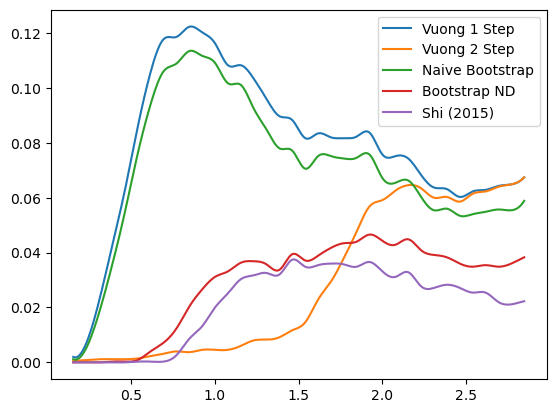

0.1 0.00020562447800032916


In [7]:
data_tuned_c = .9
calc_c =lambda nobs: (nobs**(-1/2), nobs**(-4/7)/350)
nobs=100
c1,c2 = calc_c(nobs)


mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

# Power stuff

Quantiles: 1th: 0.90, 5th: 2.04, 10th: 3.34, 30th: 9.64, 50th: 16.71, 70th: 25.58, 90th: 40.45, 95th: 48.61, 99th: 64.79
bonus term 1.1688902653183586 // variance stats 27.782031993841834 //part1 33.64303701368326 //part2 28.782031993841834 27.782031993841834
-0.603056094614059 0.13205564645224796 3.1401776651389715
-2.940836625250776 0.13205564645224796 0.8023971345022541
---
Quantiles: 1th: 0.68, 5th: 1.71, 10th: 2.96, 30th: 8.11, 50th: 14.25, 70th: 21.77, 90th: 34.99, 95th: 41.41, 99th: 54.52
bonus term 0.5884872588631809 // variance stats 41.782430610446724 //part1 25.176915317446035 //part2 42.782430610446724 41.782430610446724
-1.3897717582782483 0.7253252227078455 2.60549276796509
-2.56674627600461 0.7253252227078455 1.4285182502387281
---
Quantiles: 1th: 0.79, 5th: 1.98, 10th: 3.65, 30th: 10.65, 50th: 18.16, 70th: 27.56, 90th: 42.93, 95th: 52.32, 99th: 67.06
bonus term 2.7431464925427487 // variance stats 12.813987449694933 //part1 37.893791220660205 //part2 13.813987449694933 

Quantiles: 1th: 0.67, 5th: 1.55, 10th: 2.75, 30th: 7.60, 50th: 13.21, 70th: 20.22, 90th: 33.19, 95th: 38.92, 99th: 52.26
bonus term 1.1594684811209084 // variance stats 18.536627399395744 //part1 22.652103697002506 //part2 19.536627399395744 18.536627399395744
-0.6354306162677819 -0.033017430853053725 2.998094451230911
-2.954367578509599 -0.033017430853053725 0.6791574889890941
---
Quantiles: 1th: 0.79, 5th: 1.83, 10th: 3.02, 30th: 8.13, 50th: 13.85, 70th: 21.21, 90th: 33.52, 95th: 39.16, 99th: 52.52
bonus term 2.2485708336211365 // variance stats 9.277727156487746 //part1 23.110197519994248 //part2 10.277727156487746 9.277727156487746
0.3233686954694778 -0.8400322167185139 4.0313640830825115
-4.173772971772795 -0.8400322167185139 -0.465777584159761
---
Quantiles: 1th: 0.68, 5th: 1.89, 10th: 3.35, 30th: 9.44, 50th: 16.68, 70th: 25.41, 90th: 39.88, 95th: 48.88, 99th: 63.90
bonus term 1.6535859498114431 // variance stats 18.775357378754787 //part1 32.700253114008966 //part2 19.7753573787

Quantiles: 1th: 0.83, 5th: 1.85, 10th: 3.13, 30th: 9.90, 50th: 17.35, 70th: 26.69, 90th: 42.15, 95th: 49.94, 99th: 67.50
bonus term 1.7353581780042768 // variance stats 20.052203729240663 //part1 36.53311390654992 //part2 21.052203729240663 20.052203729240663
-0.20888642197891907 -0.2393263610619212 3.5452376348016466
-3.6796027779874727 -0.2393263610619212 0.07452127879309293
---
Quantiles: 1th: 0.76, 5th: 1.99, 10th: 3.45, 30th: 10.31, 50th: 18.24, 70th: 28.06, 90th: 44.59, 95th: 52.07, 99th: 69.71
bonus term 3.728315154594435 // variance stats 9.967089545980278 //part1 40.88876615607247 //part2 10.967089545980278 9.967089545980278
1.8973445530567956 -1.007870524929139 5.4520064901878404
-5.559285756132073 -1.007870524929139 -2.004623819001029
---
Quantiles: 1th: 0.55, 5th: 1.51, 10th: 2.40, 30th: 7.22, 50th: 12.71, 70th: 19.54, 90th: 31.15, 95th: 37.12, 99th: 49.41
bonus term 0.5832168082065968 // variance stats 33.20637236197869 //part1 19.94973130927956 //part2 34.20637236197869 3

Quantiles: 1th: 0.68, 5th: 1.82, 10th: 3.08, 30th: 8.63, 50th: 15.07, 70th: 23.25, 90th: 36.63, 95th: 43.90, 99th: 57.16
bonus term 3.8625980653295002 // variance stats 6.1439232394973455 //part1 27.594104083744902 //part2 7.1439232394973455 6.1439232394973455
2.08090931353948 -1.526298973559535 5.609728967370765
-5.644286817119521 -1.526298973559535 -2.115467163288235
---
Quantiles: 1th: 0.68, 5th: 1.67, 10th: 2.91, 30th: 8.46, 50th: 14.58, 70th: 22.76, 90th: 36.51, 95th: 43.61, 99th: 55.72
bonus term 4.841578095497065 // variance stats 4.660630222018682 //part1 27.406383289634334 //part2 5.660630222018682 4.660630222018682
3.2992582254395098 -1.8534641865694819 6.380383092930611
-6.3838979655546195 -1.8534641865694819 -3.3027730980635184
---
Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.67, 30th: 10.99, 50th: 19.13, 70th: 29.55, 90th: 45.84, 95th: 54.82, 99th: 71.25
bonus term 5.4409818437128825 // variance stats 6.94177540876824 //part1 43.21105580595345 //part2 7.94177540876824 6.941775

Quantiles: 1th: 0.74, 5th: 1.90, 10th: 3.26, 30th: 9.29, 50th: 16.26, 70th: 25.17, 90th: 39.65, 95th: 47.94, 99th: 63.98
bonus term 4.982142119227482 // variance stats 5.4872988917640795 //part1 32.32064504867559 //part2 6.4872988917640795 5.4872988917640795
3.0948731751513083 -1.9227558306685468 6.652990816189626
-6.869411063303654 -1.9227558306685468 -3.311293422265337
---
Quantiles: 1th: 0.72, 5th: 1.68, 10th: 2.81, 30th: 8.03, 50th: 13.73, 70th: 20.52, 90th: 33.35, 95th: 39.63, 99th: 51.41
bonus term 3.9243606799937987 // variance stats 4.827101515379035 //part1 22.867648065285767 //part2 5.827101515379035 4.827101515379035
2.1812629563356185 -2.510139832117882 5.645407273966512
-5.667458403651979 -2.510139832117882 -2.2033140860210847
---
Quantiles: 1th: 0.81, 5th: 1.98, 10th: 3.38, 30th: 9.45, 50th: 16.30, 70th: 24.68, 90th: 39.60, 95th: 46.69, 99th: 60.07
bonus term 1.5693327382814086 // variance stats 19.544160686467002 //part1 32.240623945786524 //part2 20.544160686467002 19.5

Quantiles: 1th: 0.82, 5th: 1.78, 10th: 2.95, 30th: 8.26, 50th: 14.67, 70th: 22.13, 90th: 35.55, 95th: 42.30, 99th: 54.68
bonus term 0.5193587053368831 // variance stats 49.04805971254939 //part1 25.99289549693267 //part2 50.04805971254939 49.04805971254939
-1.4123221543921725 0.8810103879201346 2.412039478810008
-2.4510395650659387 0.8810103879201346 1.373322068136242
---
Quantiles: 1th: 0.69, 5th: 2.08, 10th: 3.79, 30th: 11.38, 50th: 19.58, 70th: 29.77, 90th: 47.97, 95th: 56.38, 99th: 75.84
bonus term 4.649487417483601 // variance stats 9.176461533726515 //part1 47.3153298555673 //part2 10.176461533726515 9.176461533726515
2.912919864662741 -1.3142816936935937 6.345221885315044
-6.386054970304461 -1.3142816936935937 -2.9537529496521584
---
Quantiles: 1th: 0.70, 5th: 1.84, 10th: 3.28, 30th: 9.55, 50th: 16.57, 70th: 24.71, 90th: 39.16, 95th: 46.45, 99th: 61.30
bonus term 2.4934163378253107 // variance stats 11.648443385230223 //part1 31.537835384791517 //part2 12.648443385230223 11.6484

Quantiles: 1th: 0.83, 5th: 2.25, 10th: 3.87, 30th: 11.55, 50th: 20.17, 70th: 30.51, 90th: 49.18, 95th: 59.50, 99th: 79.05
bonus term 0.8295734112894553 // variance stats 58.94189303579027 //part1 49.72620068484818 //part2 59.94189303579027 58.94189303579027
-1.3329841094585313 0.6484627327318281 2.651844720638319
-2.992130932037442 0.6484627327318281 0.9926978980594082
---
Quantiles: 1th: 0.75, 5th: 1.99, 10th: 3.38, 30th: 10.55, 50th: 18.16, 70th: 27.52, 90th: 45.03, 95th: 53.44, 99th: 71.02
bonus term 1.9284432668075584 // variance stats 20.62442442722565 //part1 41.70147568527221 //part2 21.62442442722565 20.62442442722565
0.07172504136092592 -0.7317200329978778 3.799598916695525
-3.7851614922541907 -0.7317200329978778 -0.05728761691959215
---
Quantiles: 1th: 0.67, 5th: 1.76, 10th: 3.04, 30th: 9.28, 50th: 16.13, 70th: 24.41, 90th: 39.30, 95th: 47.23, 99th: 58.63
bonus term 1.3363543424361797 // variance stats 22.769703154761988 //part1 31.764746029285146 //part2 23.76970315476199 22

Quantiles: 1th: 0.58, 5th: 1.60, 10th: 2.81, 30th: 7.87, 50th: 14.04, 70th: 21.47, 90th: 33.94, 95th: 41.58, 99th: 55.46
bonus term 5.30394969479087 // variance stats 3.466505862659293 //part1 23.690122407033392 //part2 4.466505862659293 3.466505862659293
3.716328262945046 -3.0831272695561704 6.813779272935934
-6.891571126636695 -3.0831272695561704 -3.794120116645807
---
Quantiles: 1th: 0.59, 5th: 1.61, 10th: 2.56, 30th: 7.00, 50th: 11.79, 70th: 18.39, 90th: 28.57, 95th: 33.80, 99th: 45.13
bonus term 0.948855332872219 // variance stats 16.683086790565643 //part1 16.7786912028705 //part2 17.683086790565643 16.683086790565643
-0.9253913625284661 -0.29819288930763765 2.7666575251198426
-2.823102028272904 -0.29819288930763765 0.8689468593754047
---
Quantiles: 1th: 0.74, 5th: 1.78, 10th: 3.14, 30th: 9.27, 50th: 16.31, 70th: 24.90, 90th: 40.05, 95th: 47.15, 99th: 63.44
bonus term 4.265029349595848 // variance stats 6.73286457715168 //part1 32.980894378002 //part2 7.73286457715168 6.732864577

Quantiles: 1th: 0.83, 5th: 2.07, 10th: 3.52, 30th: 10.77, 50th: 19.21, 70th: 30.05, 90th: 45.86, 95th: 54.00, 99th: 74.83
bonus term 2.148321559650015 // variance stats 19.12855914626529 //part1 43.24261757861222 //part2 20.12855914626529 19.12855914626529
0.18342872331876056 -1.0685404403263943 4.079761011381921
-4.113214395981269 -1.0685404403263943 -0.2168821079181096
---
Quantiles: 1th: 0.60, 5th: 1.55, 10th: 2.90, 30th: 8.74, 50th: 15.20, 70th: 23.56, 90th: 37.77, 95th: 44.34, 99th: 58.46
bonus term 2.041966417010086 // variance stats 13.369171697283317 //part1 29.34136604610435 //part2 14.369171697283319 13.369171697283317
-0.03252217217084853 -1.4014826476923574 4.0093603362093635
-4.116455006191021 -1.4014826476923574 -0.0745724978108085
---
Quantiles: 1th: 0.60, 5th: 1.64, 10th: 2.76, 30th: 7.97, 50th: 13.53, 70th: 20.65, 90th: 32.81, 95th: 40.37, 99th: 52.10
bonus term 1.7095204124479633 // variance stats 11.946706065138548 //part1 22.1326582923182 //part2 12.94670606513855 1

Quantiles: 1th: 0.67, 5th: 1.89, 10th: 3.56, 30th: 10.07, 50th: 17.37, 70th: 26.85, 90th: 41.81, 95th: 49.78, 99th: 64.69
bonus term 2.192741761068727 // variance stats 15.3916515397845 //part1 35.942658864171975 //part2 16.3916515397845 15.3916515397845
0.31515981869038695 -2.0494332295397832 4.038041647272672
-4.070323703447068 -2.0494332295397832 -0.3474418748647818
---
Quantiles: 1th: 0.55, 5th: 1.56, 10th: 2.57, 30th: 7.47, 50th: 12.77, 70th: 19.23, 90th: 30.89, 95th: 36.90, 99th: 48.19
bonus term 0.35968360783135633 // variance stats 53.56014750749422 //part1 19.624390699306502 //part2 54.560147507494214 53.56014750749422
-1.7126182058992057 0.9200521022796454 2.381991411278188
-2.4319854215619183 0.9200521022796454 1.6626241956154755
---
Quantiles: 1th: 0.83, 5th: 2.20, 10th: 3.89, 30th: 11.74, 50th: 20.62, 70th: 32.09, 90th: 51.78, 95th: 62.06, 99th: 81.19
bonus term 1.2964824647051794 // variance stats 41.53070385549421 //part1 55.14031176021721 //part2 42.53070385549421 41.53

Quantiles: 1th: 0.68, 5th: 1.94, 10th: 3.47, 30th: 9.68, 50th: 17.31, 70th: 26.23, 90th: 41.51, 95th: 49.06, 99th: 65.11
bonus term 1.7015505749713196 // variance stats 19.818728755085374 //part1 35.42411988338746 //part2 20.818728755085374 19.818728755085374
-0.03325055589649669 -1.310226482005065 3.565933616206274
-3.436351705839136 -1.310226482005065 0.1628324662636347
---
Quantiles: 1th: 0.71, 5th: 1.73, 10th: 3.05, 30th: 8.85, 50th: 15.21, 70th: 23.47, 90th: 37.86, 95th: 44.95, 99th: 59.62
bonus term 0.7585505357403916 // variance stats 37.86370440023026 //part1 29.480083793650874 //part2 38.86370440023026 37.86370440023026
-1.1218160351809554 0.3428567226735931 2.667683373016751
-2.6389171066617383 0.3428567226735931 1.1505823015359684
---
Quantiles: 1th: 0.79, 5th: 2.10, 10th: 3.48, 30th: 9.74, 50th: 17.23, 70th: 26.36, 90th: 41.79, 95th: 48.43, 99th: 63.03
bonus term 1.3954692895314007 // variance stats 24.73264653452304 //part1 35.90911797729353 //part2 25.73264653452304 24.73

Quantiles: 1th: 0.67, 5th: 1.75, 10th: 3.14, 30th: 9.57, 50th: 17.00, 70th: 26.30, 90th: 41.81, 95th: 50.00, 99th: 66.02
bonus term 2.563338339678881 // variance stats 13.024317550510137 //part1 35.94907086505405 //part2 14.024317550510137 13.024317550510137
0.7440168963967311 -1.4614908877111628 4.375957088663097
-4.3826597829610305 -1.4614908877111628 -0.7507195906946641
---
Quantiles: 1th: 0.85, 5th: 2.15, 10th: 3.73, 30th: 10.40, 50th: 18.49, 70th: 29.12, 90th: 46.05, 95th: 55.04, 99th: 72.13
bonus term 3.4905173784286143 // variance stats 11.490313523358832 //part1 43.59765641530594 //part2 12.490313523358834 11.490313523358832
1.4022928363877383 -2.285201941535109 5.286602105967516
-5.57874192046949 -2.285201941535109 -1.6944326508897132
---
Quantiles: 1th: 0.66, 5th: 1.59, 10th: 2.66, 30th: 7.82, 50th: 13.44, 70th: 20.64, 90th: 32.51, 95th: 38.42, 99th: 52.00
bonus term 0.7402213199464681 // variance stats 28.36645276051106 //part1 21.7376744245311 //part2 29.36645276051106 28.3

Quantiles: 1th: 0.66, 5th: 1.81, 10th: 3.29, 30th: 9.25, 50th: 16.23, 70th: 24.99, 90th: 39.77, 95th: 47.29, 99th: 61.96
bonus term 0.7124498227242504 // variance stats 44.65052987390735 //part1 32.52371191593339 //part2 45.65052987390735 44.65052987390735
-1.1369816869855538 0.2907961832471966 2.6646845993917
-2.561881332434055 0.2907961832471966 1.2397849539431993
---
Quantiles: 1th: 0.90, 5th: 2.15, 10th: 3.65, 30th: 10.41, 50th: 18.20, 70th: 27.71, 90th: 43.54, 95th: 51.95, 99th: 69.92
bonus term 1.415503859892463 // variance stats 26.532401118904087 //part1 38.97222005591631 //part2 27.53240111890409 26.532401118904087
-0.41614851914440726 -1.2170248362530534 3.3609230368780545
-3.2471562389293336 -1.2170248362530534 0.5299153170931281
---
Quantiles: 1th: 0.86, 5th: 2.14, 10th: 3.83, 30th: 11.83, 50th: 21.38, 70th: 32.74, 90th: 52.40, 95th: 62.16, 99th: 82.48
bonus term 7.456077288384137 // variance stats 6.571383157863425 //part1 56.45281800499965 //part2 7.5713831578634245 6.571

Quantiles: 1th: 0.72, 5th: 1.63, 10th: 2.87, 30th: 8.29, 50th: 14.78, 70th: 22.54, 90th: 35.41, 95th: 41.81, 99th: 55.15
bonus term 2.11149703603134 // variance stats 11.211684646228424 //part1 25.78493593546074 //part2 12.211684646228424 11.211684646228424
0.19004903716540467 -2.9694455952967407 3.915863932811986
-4.032945034897275 -2.9694455952967407 -0.30713013925069377
---
Quantiles: 1th: 0.77, 5th: 1.97, 10th: 3.29, 30th: 9.63, 50th: 17.15, 70th: 26.15, 90th: 41.63, 95th: 50.53, 99th: 65.46
bonus term 2.691842504639852 // variance stats 12.239224815707619 //part1 35.63790808740448 //part2 13.239224815707619 12.239224815707619
0.3692656371524487 -4.013893784297458 4.597930981733682
-5.014419372127255 -4.013893784297458 -0.7857540275460229
---
Quantiles: 1th: 0.80, 5th: 2.16, 10th: 4.13, 30th: 12.45, 50th: 21.88, 70th: 33.46, 90th: 54.30, 95th: 64.34, 99th: 85.77
bonus term 2.60219816766789 // variance stats 22.30170136878124 //part1 60.63564460538691 //part2 23.30170136878124 22.30

Quantiles: 1th: 0.71, 5th: 1.69, 10th: 2.92, 30th: 7.92, 50th: 13.79, 70th: 21.65, 90th: 34.27, 95th: 40.50, 99th: 53.00
bonus term 0.6047419885933917 // variance stats 38.9426906297142 //part1 24.155022161183997 //part2 39.9426906297142 38.9426906297142
-1.4750113545649688 -0.5372427077429784 2.440980440344052
-2.6844953317517524 -0.5372427077429784 1.2314964631572687
---
Quantiles: 1th: 0.89, 5th: 2.20, 10th: 3.95, 30th: 11.77, 50th: 20.37, 70th: 31.37, 90th: 50.40, 95th: 58.73, 99th: 79.28
bonus term 3.5484127257683764 // variance stats 13.71772196680183 //part1 52.2245519213204 //part2 14.71772196680183 13.71772196680183
1.3111230719452653 -4.487269437406454 5.3531204679662014
-5.785702379591488 -4.487269437406454 -1.7437049835705511
---
Quantiles: 1th: 0.79, 5th: 1.99, 10th: 3.47, 30th: 10.79, 50th: 18.86, 70th: 29.02, 90th: 45.18, 95th: 53.59, 99th: 71.47
bonus term 0.836472895016204 // variance stats 49.17389118179436 //part1 41.96910001106351 //part2 50.17389118179436 49.173891

Quantiles: 1th: 0.79, 5th: 1.97, 10th: 3.39, 30th: 9.97, 50th: 17.44, 70th: 26.84, 90th: 41.49, 95th: 49.43, 99th: 64.47
bonus term 0.9614015358322401 // variance stats 35.81236176199139 //part1 35.39146113559055 //part2 36.81236176199139 35.81236176199139
-1.161402649216093 -0.6530590162484453 2.7978665646822924
-3.0842057208805733 -0.6530590162484453 0.8750634930178124
---
Quantiles: 1th: 0.72, 5th: 1.84, 10th: 3.26, 30th: 9.47, 50th: 16.45, 70th: 25.63, 90th: 39.98, 95th: 48.80, 99th: 62.74
bonus term 3.7795263958993908 // variance stats 7.697633701093716 //part1 32.872936155147805 //part2 8.697633701093716 7.697633701093716
1.6237613637397061 -5.058769722413506 5.746636248470805
-5.935291428059075 -5.058769722413506 -1.8124165433279766
---
Quantiles: 1th: 0.52, 5th: 1.39, 10th: 2.38, 30th: 7.08, 50th: 12.24, 70th: 19.01, 90th: 30.46, 95th: 35.96, 99th: 46.00
bonus term 1.4594703287588942 // variance stats 12.0722234742821 //part1 19.07852229162023 //part2 13.0722234742821 12.072223

Quantiles: 1th: 0.79, 5th: 1.92, 10th: 3.29, 30th: 9.59, 50th: 17.20, 70th: 26.06, 90th: 40.23, 95th: 48.58, 99th: 63.95
bonus term 1.9820382610296006 // variance stats 15.787608485963244 //part1 33.27368233036435 //part2 16.787608485963244 15.787608485963244
0.22245828319564062 -3.0410749514577624 3.7508257796239586
-3.741618238863561 -3.0410749514577624 -0.21325074243524283
---
Quantiles: 1th: 0.67, 5th: 1.99, 10th: 3.65, 30th: 10.36, 50th: 18.52, 70th: 28.68, 90th: 46.08, 95th: 54.59, 99th: 72.80
bonus term 1.6485963196756621 // variance stats 25.48768529047118 //part1 43.66750048659796 //part2 26.48768529047118 25.48768529047118
-0.20851474230014544 -1.4745897170895779 3.4884537441807177
-3.5057073816514697 -1.4745897170895779 0.19126110482939385
---
Quantiles: 1th: 0.62, 5th: 1.47, 10th: 2.30, 30th: 6.43, 50th: 11.23, 70th: 17.10, 90th: 26.75, 95th: 32.11, 99th: 41.05
bonus term 1.2234692124551598 // variance stats 11.023652978260511 //part1 14.710569240146526 //part2 12.023652978

Quantiles: 1th: 0.66, 5th: 1.67, 10th: 3.16, 30th: 9.59, 50th: 16.56, 70th: 24.99, 90th: 40.80, 95th: 48.83, 99th: 64.84
bonus term 0.9582437659599432 // variance stats 34.717993228182145 //part1 34.22654434350501 //part2 35.717993228182145 34.717993228182145
-0.7540000069831028 -0.9303703002228337 2.8704923845564916
-2.670487538902989 -0.9303703002228337 0.9540048526366054
---
Quantiles: 1th: 0.79, 5th: 2.06, 10th: 3.44, 30th: 9.77, 50th: 16.84, 70th: 26.37, 90th: 41.14, 95th: 48.73, 99th: 64.55
bonus term 2.1135028798177022 // variance stats 15.469432768507579 //part1 34.808193585204805 //part2 16.46943276850758 15.469432768507579
-0.1134765320136662 -3.9338139642636785 4.058043043817725
-4.340482291649071 -3.9338139642636785 -0.16896271581767955
---
Quantiles: 1th: 0.78, 5th: 2.06, 10th: 3.81, 30th: 10.87, 50th: 18.98, 70th: 28.42, 90th: 44.81, 95th: 53.75, 99th: 71.32
bonus term 0.8526546922975992 // variance stats 47.42858897606246 //part1 41.292863631791434 //part2 48.42858897606

Quantiles: 1th: 0.87, 5th: 2.38, 10th: 4.20, 30th: 12.21, 50th: 20.95, 70th: 32.47, 90th: 50.50, 95th: 60.24, 99th: 79.88
bonus term 1.8727451278828624 // variance stats 26.998165839153394 //part1 52.433428664930915 //part2 27.998165839153394 26.998165839153394
0.07608747308108364 -2.376483138154847 3.625646800209116
-3.6694027826846414 -2.376483138154847 -0.11984345555660879
---
Quantiles: 1th: 0.63, 5th: 1.80, 10th: 2.99, 30th: 9.38, 50th: 16.39, 70th: 25.58, 90th: 40.14, 95th: 47.99, 99th: 60.80
bonus term 2.028398220981704 // variance stats 15.336736099457964 //part1 33.13740644078812 //part2 16.336736099457966 15.336736099457964
-0.09303438410035425 -4.4354375881173596 3.8235828569350505
-4.149830826063763 -4.4354375881173596 -0.233213585028358
---
Quantiles: 1th: 0.71, 5th: 1.66, 10th: 2.90, 30th: 8.66, 50th: 15.38, 70th: 24.12, 90th: 38.48, 95th: 45.51, 99th: 59.51
bonus term 2.7587786383553485 // variance stats 10.03681706565901 //part1 30.448135156175837 //part2 11.03681706565

Quantiles: 1th: 0.72, 5th: 1.58, 10th: 2.62, 30th: 7.43, 50th: 13.27, 70th: 20.34, 90th: 32.47, 95th: 38.00, 99th: 51.83
bonus term 0.769493075695001 // variance stats 27.17590084489251 //part1 21.681160601613715 //part2 28.17590084489251 27.17590084489251
-1.0179981151439166 -1.5743916768001631 2.711329124607345
-2.5569842665339184 -1.5743916768001631 1.1723429732173427
---
Quantiles: 1th: 0.75, 5th: 1.98, 10th: 3.32, 30th: 9.70, 50th: 16.90, 70th: 25.83, 90th: 40.56, 95th: 47.86, 99th: 62.36
bonus term 0.6992351186907404 // variance stats 47.38033105947879 //part1 33.82922653067196 //part2 48.38033105947879 47.38033105947879
-1.1746387422021694 0.028745658894846753 2.775708175511418
-2.57310897958365 0.028745658894846753 1.3772379381299378
---
Quantiles: 1th: 0.55, 5th: 1.78, 10th: 3.10, 30th: 9.44, 50th: 16.64, 70th: 25.32, 90th: 40.51, 95th: 48.03, 99th: 65.17
bonus term 0.9922384138436139 // variance stats 33.0049158329908 //part1 33.74098374901238 //part2 34.0049158329908 33.0049

Quantiles: 1th: 0.74, 5th: 1.82, 10th: 3.00, 30th: 8.44, 50th: 14.66, 70th: 22.07, 90th: 35.15, 95th: 41.84, 99th: 52.83
bonus term 1.4541681959614285 // variance stats 16.471562587954345 //part1 25.40659064915276 //part2 17.471562587954345 16.471562587954345
-0.4560620986938167 -4.450404984284358 3.198638310238836
-3.364398490616674 -4.450404984284358 0.2903019183159787
---
Quantiles: 1th: 0.62, 5th: 1.81, 10th: 3.20, 30th: 9.10, 50th: 15.43, 70th: 23.51, 90th: 37.43, 95th: 44.97, 99th: 58.61
bonus term 1.1723022791096778 // variance stats 23.579639820961145 //part1 28.814767781807742 //part2 24.579639820961145 23.579639820961145
-0.8846127635298108 -2.59653147550816 3.1493385087509367
-3.229217321749166 -2.59653147550816 0.8047339505315809
---
Quantiles: 1th: 0.79, 5th: 2.06, 10th: 3.73, 30th: 11.59, 50th: 20.87, 70th: 32.11, 90th: 50.44, 95th: 60.04, 99th: 79.54
bonus term 4.33459914738264 // variance stats 11.070363369798566 //part1 52.32018677132751 //part2 12.070363369798567 11.0

Quantiles: 1th: 0.67, 5th: 1.76, 10th: 3.26, 30th: 9.41, 50th: 16.48, 70th: 25.36, 90th: 40.83, 95th: 48.75, 99th: 64.14
bonus term 1.5035743024210748 // variance stats 21.793374418139216 //part1 34.27153204057605 //part2 22.79337441813922 21.793374418139216
-0.6216551963225759 -3.5324430963655367 3.195537271052721
-3.6288038011647257 -3.5324430963655367 0.18838866621057151
---
Quantiles: 1th: 0.71, 5th: 1.82, 10th: 3.11, 30th: 9.23, 50th: 15.99, 70th: 24.55, 90th: 37.81, 95th: 46.34, 99th: 60.70
bonus term 1.0030003265405811 // variance stats 28.305973161633734 //part1 29.393900650708144 //part2 29.305973161633734 28.305973161633734
-1.1669752956683033 -2.5466830878383817 2.898916753003527
-3.1729759487494658 -2.5466830878383817 0.8929160999223643
---
Quantiles: 1th: 0.90, 5th: 2.41, 10th: 4.10, 30th: 11.82, 50th: 21.05, 70th: 32.37, 90th: 50.66, 95th: 59.42, 99th: 78.57
bonus term 1.4862931562636572 // variance stats 34.51088686053426 //part1 52.7795881136651 //part2 35.5108868605342

Quantiles: 1th: 0.69, 5th: 1.89, 10th: 3.48, 30th: 10.70, 50th: 18.73, 70th: 28.77, 90th: 45.45, 95th: 53.54, 99th: 70.22
bonus term 0.9056307398319755 // variance stats 45.90560908112194 //part1 42.47916145440588 //part2 46.90560908112193 45.90560908112194
-1.0339127569993178 -1.3115336013438652 2.7965697500703257
-2.845174236663269 -1.3115336013438652 0.9853082704063747
---
Quantiles: 1th: 0.65, 5th: 1.74, 10th: 3.19, 30th: 9.80, 50th: 16.81, 70th: 25.72, 90th: 40.93, 95th: 48.67, 99th: 65.69
bonus term 2.1917081714749806 // variance stats 14.71354093896571 //part1 34.43949607873778 //part2 15.71354093896571 14.71354093896571
0.019576935886007226 -5.274308852148579 4.132942917082344
-4.363839407063955 -5.274308852148579 -0.25047342586761645
---
Quantiles: 1th: 0.82, 5th: 2.10, 10th: 3.67, 30th: 10.81, 50th: 19.10, 70th: 29.66, 90th: 48.90, 95th: 57.64, 99th: 74.09
bonus term 1.8333293863467153 // variance stats 25.823292979196125 //part1 49.17593125734779 //part2 26.823292979196125 2

Quantiles: 1th: 0.67, 5th: 1.55, 10th: 2.46, 30th: 6.50, 50th: 11.45, 70th: 17.81, 90th: 28.42, 95th: 33.96, 99th: 44.49
bonus term 0.5025186875991554 // variance stats 32.03961325671606 //part1 16.60302309254861 //part2 33.03961325671606 32.03961325671606
-1.640409069202366 -1.9500619336020308 2.393708599691476
-2.6454464444006773 -1.9500619336020308 1.3886712244931654
---
Quantiles: 1th: 0.68, 5th: 1.93, 10th: 3.23, 30th: 9.45, 50th: 16.27, 70th: 24.83, 90th: 39.09, 95th: 47.14, 99th: 60.88
bonus term 2.1121003100186684 // variance stats 13.875094734821644 //part1 31.417692200973857 //part2 14.875094734821646 13.875094734821644
0.00933593073751745 -6.631415253468001 3.9388960263775386
-4.214864689299819 -6.631415253468001 -0.2853045936597981
---
Quantiles: 1th: 0.77, 5th: 1.89, 10th: 3.11, 30th: 8.51, 50th: 14.47, 70th: 22.02, 90th: 35.01, 95th: 41.65, 99th: 55.21
bonus term 1.466220538268883 // variance stats 16.19097697287794 //part1 25.205763510541075 //part2 17.19097697287794 16.

Quantiles: 1th: 0.72, 5th: 1.80, 10th: 2.95, 30th: 8.60, 50th: 14.74, 70th: 22.90, 90th: 36.33, 95th: 43.59, 99th: 56.39
bonus term 0.5004585119947907 // variance stats 53.22903385450492 //part1 27.139381589740662 //part2 54.22903385450492 53.22903385450492
-1.6287928770486053 -1.2127240618294508 2.394100300272189
-2.6297099010381864 -1.2127240618294508 1.393183276282607
---
Quantiles: 1th: 0.73, 5th: 1.85, 10th: 2.95, 30th: 8.36, 50th: 14.13, 70th: 21.74, 90th: 34.05, 95th: 40.64, 99th: 52.29
bonus term 0.8054519694161879 // variance stats 28.602865774563337 //part1 23.84368653848511 //part2 29.602865774563337 28.602865774563337
-1.169413490735014 -2.9177789874898625 2.654231317956943
-2.78031742956739 -2.9177789874898625 1.0433273791245672
---
Quantiles: 1th: 0.61, 5th: 1.69, 10th: 2.94, 30th: 8.20, 50th: 14.43, 70th: 22.06, 90th: 35.75, 95th: 43.33, 99th: 55.67
bonus term 0.8670795932012021 // variance stats 29.311958853304073 //part1 26.282880951654477 //part2 30.311958853304077 29

Quantiles: 1th: 0.71, 5th: 1.62, 10th: 2.70, 30th: 7.67, 50th: 13.30, 70th: 20.54, 90th: 32.99, 95th: 39.60, 99th: 53.06
bonus term 0.8152714877549753 // variance stats 26.44207374601448 //part1 22.372740289994976 //part2 27.44207374601448 26.44207374601448
-1.3424030776124525 -3.6002399092347783 2.7515422085496573
-2.972946053122403 -3.6002399092347783 1.120999233039707
---
Quantiles: 1th: 0.73, 5th: 1.72, 10th: 2.80, 30th: 8.63, 50th: 14.86, 70th: 22.75, 90th: 36.54, 95th: 44.12, 99th: 58.63
bonus term 0.7119340430090428 // variance stats 37.56959984073446 //part1 27.459011151855023 //part2 38.56959984073447 37.56959984073446
-1.3356993143016205 -1.7065604101827831 2.680800787615818
-2.759567400319706 -1.7065604101827831 1.256932701597732
---
Quantiles: 1th: 0.75, 5th: 2.19, 10th: 3.65, 30th: 10.06, 50th: 17.59, 70th: 26.71, 90th: 43.69, 95th: 51.53, 99th: 69.17
bonus term 0.7608387103578754 // variance stats 50.584346222717855 //part1 39.24736745474679 //part2 51.58434622271785 50.5

Quantiles: 1th: 0.78, 5th: 2.09, 10th: 3.66, 30th: 10.61, 50th: 18.06, 70th: 27.50, 90th: 44.58, 95th: 54.03, 99th: 69.76
bonus term 1.1276201987582721 // variance stats 35.24371168863344 //part1 40.869141378074346 //part2 36.24371168863344 35.24371168863344
-0.9839831823166559 -2.6855092881939124 2.93894470124566
-3.2392235798332 -2.6855092881939124 0.6837043037291158
---
Quantiles: 1th: 0.89, 5th: 2.10, 10th: 3.60, 30th: 9.97, 50th: 17.23, 70th: 26.67, 90th: 42.44, 95th: 50.92, 99th: 66.31
bonus term 1.128211509764813 // variance stats 31.81991541198105 //part1 37.027806317304595 //part2 32.81991541198105 31.81991541198105
-0.9525171037591835 -3.478875047678453 2.9980672618891364
-3.20894012328881 -3.478875047678453 0.7416442423595104
---
Quantiles: 1th: 0.64, 5th: 1.69, 10th: 2.95, 30th: 8.52, 50th: 15.19, 70th: 23.74, 90th: 37.43, 95th: 44.68, 99th: 58.77
bonus term 1.850080147940606 // variance stats 14.572155055134612 //part1 28.8097349281575 //part2 15.572155055134614 14.5721550

Quantiles: 1th: 0.63, 5th: 1.66, 10th: 3.15, 30th: 9.35, 50th: 16.26, 70th: 24.77, 90th: 39.66, 95th: 46.81, 99th: 62.88
bonus term 1.2729036150228286 // variance stats 24.40639913383852 //part1 32.33989730217591 //part2 25.406399133838523 24.40639913383852
-1.0521817967664222 -4.814313990142176 3.243357899774208
-3.5979890268120793 -4.814313990142176 0.6975506697285511
---
Quantiles: 1th: 0.78, 5th: 1.90, 10th: 3.35, 30th: 10.13, 50th: 17.63, 70th: 26.93, 90th: 41.87, 95th: 50.14, 99th: 67.08
bonus term 2.1193468319373063 // variance stats 16.010268646064393 //part1 36.05065896543907 //part2 17.010268646064397 16.010268646064393
-0.04252420325242538 -7.3530973050884425 4.050263442071525
-4.281217867127038 -7.3530973050884425 -0.18843022180308802
---
Quantiles: 1th: 0.78, 5th: 2.31, 10th: 3.93, 30th: 11.72, 50th: 19.44, 70th: 29.96, 90th: 48.10, 95th: 56.69, 99th: 74.60
bonus term 2.733480315647489 // variance stats 16.402882952024772 //part1 47.57043798487699 //part2 17.40288295202477

Quantiles: 1th: 0.58, 5th: 1.71, 10th: 2.99, 30th: 8.27, 50th: 14.19, 70th: 21.53, 90th: 34.77, 95th: 41.04, 99th: 53.67
bonus term 0.7030868482376816 // variance stats 34.360384789261836 //part1 24.861421493953763 //part2 35.360384789261836 34.360384789261836
-1.4496717994550001 -3.8477154951954327 2.6270680892319582
-2.8558454959303634 -3.8477154951954327 1.2208943927565947
---
Quantiles: 1th: 0.68, 5th: 1.81, 10th: 3.12, 30th: 9.28, 50th: 16.20, 70th: 24.40, 90th: 38.83, 95th: 46.53, 99th: 62.56
bonus term 1.5886482655493714 // variance stats 18.51312821095458 //part1 30.999497287775508 //part2 19.513128210954584 18.51312821095458
-0.9435753209568541 -9.127267666692156 3.6634615401619417
-4.120871852055598 -9.127267666692156 0.48616500906319876
---
Quantiles: 1th: 0.69, 5th: 1.95, 10th: 3.43, 30th: 10.33, 50th: 17.92, 70th: 27.51, 90th: 44.19, 95th: 52.33, 99th: 70.01
bonus term 2.026406554457419 // variance stats 18.81112305392881 //part1 40.145389607643814 //part2 19.8111230539288

Quantiles: 1th: 0.83, 5th: 2.19, 10th: 3.60, 30th: 10.18, 50th: 17.71, 70th: 27.27, 90th: 42.54, 95th: 50.55, 99th: 69.08
bonus term 1.7583503224022434 // variance stats 20.162721929840774 //part1 37.21147892824456 //part2 21.162721929840774 20.162721929840774
-0.5014936132895337 -9.158425950806512 3.6968560685421936
-4.018194258094021 -9.158425950806512 0.1801554237377065
---
Quantiles: 1th: 0.65, 5th: 1.77, 10th: 3.06, 30th: 9.47, 50th: 16.59, 70th: 25.86, 90th: 40.89, 95th: 48.39, 99th: 62.65
bonus term 1.55109594709423 // variance stats 21.16753311095382 //part1 34.38397076547762 //part2 22.16753311095382 21.16753311095382
-0.7759329020748272 -5.218896061704008 3.467238608912956
-3.878124796263287 -5.218896061704008 0.3650467147244962
---
Quantiles: 1th: 0.59, 5th: 1.77, 10th: 3.21, 30th: 9.29, 50th: 15.87, 70th: 24.09, 90th: 36.86, 95th: 45.26, 99th: 58.02
bonus term 1.501439940198233 // variance stats 17.604431972007625 //part1 27.933437227473224 //part2 18.604431972007628 17.604

Quantiles: 1th: 0.54, 5th: 1.75, 10th: 3.13, 30th: 9.56, 50th: 16.96, 70th: 26.35, 90th: 41.59, 95th: 49.88, 99th: 66.04
bonus term 1.6298399898141815 // variance stats 20.818666134051472 //part1 35.56093458968148 //part2 21.818666134051476 20.818666134051472
-0.5640883330225289 -7.127129463927263 3.5449221738410595
-3.8237683126508917 -7.127129463927263 0.28524219421269653
---
Quantiles: 1th: 0.68, 5th: 2.10, 10th: 3.37, 30th: 9.64, 50th: 16.57, 70th: 25.63, 90th: 41.07, 95th: 48.79, 99th: 64.29
bonus term 1.0786322076726589 // variance stats 31.147512092714567 //part1 34.67534193974821 //part2 32.147512092714564 31.147512092714567
-0.9387555678767403 -4.799794217315623 3.1665078958169492
-3.096019983222058 -4.799794217315623 1.0092434804716315
---
Quantiles: 1th: 0.82, 5th: 2.16, 10th: 3.50, 30th: 9.96, 50th: 17.58, 70th: 27.12, 90th: 43.52, 95th: 52.28, 99th: 69.75
bonus term 1.3325208204507144 // variance stats 28.227542856000394 //part1 38.94630938623606 //part2 29.227542856000394

Quantiles: 1th: 0.66, 5th: 1.80, 10th: 3.30, 30th: 9.46, 50th: 16.19, 70th: 24.86, 90th: 40.19, 95th: 48.23, 99th: 61.85
bonus term 0.8968285777553089 // variance stats 36.03631292740003 //part1 33.21522384798073 //part2 37.03631292740003 36.03631292740003
-1.3592324367550161 -3.86048168482344 2.884600535148169
-3.1528895922656335 -3.86048168482344 1.0909433796375514
---
Quantiles: 1th: 0.71, 5th: 2.00, 10th: 3.39, 30th: 9.78, 50th: 16.90, 70th: 26.12, 90th: 41.75, 95th: 49.63, 99th: 66.13
bonus term 1.470580437047341 // variance stats 23.373653239673054 //part1 35.843417633638744 //part2 24.373653239673057 23.373653239673054
-1.090069019319118 -7.940764093007502 3.4659895307517736
-4.0312298934138 -7.940764093007502 0.5248286566570917
---
Quantiles: 1th: 0.58, 5th: 1.56, 10th: 2.92, 30th: 8.47, 50th: 14.03, 70th: 21.46, 90th: 33.88, 95th: 40.25, 99th: 53.37
bonus term 0.7055823890623397 // variance stats 32.44833191527072 //part1 23.600553942926823 //part2 33.44833191527072 32.4483319

Quantiles: 1th: 0.72, 5th: 1.63, 10th: 2.72, 30th: 8.11, 50th: 13.88, 70th: 21.76, 90th: 33.43, 95th: 39.78, 99th: 50.24
bonus term 1.0916265564116214 // variance stats 20.055667429435843 //part1 22.984925728943384 //part2 21.055667429435843 20.055667429435843
-1.4233284137721298 -9.711998936486793 3.321609362084996
-3.606581526595373 -9.711998936486793 1.138356249261753
---
Quantiles: 1th: 0.79, 5th: 2.23, 10th: 4.12, 30th: 12.40, 50th: 21.83, 70th: 33.95, 90th: 53.54, 95th: 63.66, 99th: 84.22
bonus term 2.15691901068435 // variance stats 26.32860178369331 //part1 58.94558072267034 //part2 27.32860178369331 26.32860178369331
-0.1738229250086146 -5.687966007852237 4.228200984947216
-4.487660946377314 -5.687966007852237 -0.08563703642148385
---
Quantiles: 1th: 0.58, 5th: 1.52, 10th: 2.61, 30th: 7.39, 50th: 12.50, 70th: 19.16, 90th: 30.69, 95th: 35.81, 99th: 47.71
bonus term 0.883323917916691 // variance stats 20.926319851286802 //part1 19.36804275653318 //part2 21.926319851286806 20.926

Quantiles: 1th: 0.75, 5th: 1.72, 10th: 3.01, 30th: 8.11, 50th: 14.38, 70th: 21.88, 90th: 35.24, 95th: 41.92, 99th: 54.93
bonus term 0.7420570707447814 // variance stats 33.403297067798775 //part1 25.529209846093288 //part2 34.403297067798775 33.403297067798775
-1.2971069449188468 -6.165727762021296 2.650234935736843
-2.78122108640841 -6.165727762021296 1.1661207942472795
---
Quantiles: 1th: 0.81, 5th: 2.11, 10th: 3.57, 30th: 10.75, 50th: 18.59, 70th: 28.68, 90th: 44.92, 95th: 54.71, 99th: 71.57
bonus term 1.2158804707917963 // variance stats 33.12433848267688 //part1 41.491116739775784 //part2 34.12433848267688 33.12433848267688
-1.2135681681426858 -5.348355332340703 3.327192822705752
-3.645329109726278 -5.348355332340703 0.8954318811221593
---
Quantiles: 1th: 0.64, 5th: 1.71, 10th: 2.79, 30th: 8.20, 50th: 14.29, 70th: 21.73, 90th: 33.29, 95th: 40.10, 99th: 52.71
bonus term 0.9545159947793069 // variance stats 22.876613803697023 //part1 22.790609776797197 //part2 23.876613803697026 22.

Quantiles: 1th: 0.64, 5th: 1.89, 10th: 3.14, 30th: 8.81, 50th: 14.98, 70th: 22.74, 90th: 36.03, 95th: 42.30, 99th: 56.03
bonus term 0.8912591232759164 // variance stats 28.946881817241838 //part1 26.69043163328244 //part2 29.946881817241838 28.946881817241838
-1.125534286475423 -7.569809950384714 2.7736729977022456
-2.9080525330272557 -7.569809950384714 0.991154751150413
---
Quantiles: 1th: 0.65, 5th: 1.87, 10th: 3.23, 30th: 9.33, 50th: 16.91, 70th: 26.10, 90th: 41.63, 95th: 49.72, 99th: 65.36
bonus term 0.8671307600335167 // variance stats 40.09111081968407 //part1 35.6313661556941 //part2 41.09111081968407 40.09111081968407
-1.4260709863237122 -4.318925778420984 2.91114643054857
-3.1603325063907457 -4.318925778420984 1.1768849104815364
---
Quantiles: 1th: 0.68, 5th: 1.83, 10th: 3.20, 30th: 9.43, 50th: 17.14, 70th: 25.62, 90th: 41.17, 95th: 49.07, 99th: 63.52
bonus term 1.5408205799078316 // variance stats 21.615924061192565 //part1 34.84708122711822 //part2 22.615924061192565 21.6159

Quantiles: 1th: 0.85, 5th: 2.21, 10th: 3.97, 30th: 11.19, 50th: 19.27, 70th: 29.50, 90th: 47.08, 95th: 55.35, 99th: 74.59
bonus term 1.6777629279728394 // variance stats 26.16540911188349 //part1 45.5771163311337 //part2 27.165409111883495 26.16540911188349
-0.9493451582997773 -8.778061303940763 3.674566737743077
-4.304871014245456 -8.778061303940763 0.3190408817973979
---
Quantiles: 1th: 0.73, 5th: 1.92, 10th: 3.28, 30th: 10.01, 50th: 17.85, 70th: 27.07, 90th: 43.47, 95th: 51.55, 99th: 68.21
bonus term 0.9479569515596634 // variance stats 39.9959975722529 //part1 38.862440884740224 //part2 40.995997572252904 39.9959975722529
-0.8566708882730592 -5.322032872354518 2.6681695779533534
-2.752584791392386 -5.322032872354518 0.7722556748340266
---
Quantiles: 1th: 0.86, 5th: 2.12, 10th: 3.68, 30th: 10.37, 50th: 18.34, 70th: 28.30, 90th: 44.67, 95th: 52.99, 99th: 71.59
bonus term 0.9327502218148015 // variance stats 42.99135140795754 //part1 41.03294278370526 //part2 43.99135140795753 42.9913

Quantiles: 1th: 0.72, 5th: 1.63, 10th: 2.83, 30th: 7.93, 50th: 14.25, 70th: 22.15, 90th: 35.16, 95th: 41.93, 99th: 54.29
bonus term 1.1151624353968652 // variance stats 21.79208642407049 //part1 25.416878604442278 //part2 22.79208642407049 21.79208642407049
-1.8097009119330996 -10.722306070457526 3.4734544000067396
-4.04002578272683 -10.722306070457526 1.2431295292130093
---
Quantiles: 1th: 0.60, 5th: 1.70, 10th: 3.16, 30th: 9.56, 50th: 16.56, 70th: 25.86, 90th: 41.55, 95th: 49.28, 99th: 64.95
bonus term 1.4458984499863512 // variance stats 23.553531020256372 //part1 35.501912443880485 //part2 24.553531020256372 23.553531020256372
-0.8220373253186787 -9.31020733625374 3.3905965326327356
-3.713834225291381 -9.31020733625374 0.49879963266003347
---
Quantiles: 1th: 0.98, 5th: 2.24, 10th: 3.68, 30th: 10.57, 50th: 18.59, 70th: 28.68, 90th: 44.92, 95th: 52.80, 99th: 72.33
bonus term 1.5096538392263772 // variance stats 26.486236289764058 //part1 41.49470214072568 //part2 27.486236289764058 2

Quantiles: 1th: 0.80, 5th: 1.96, 10th: 3.44, 30th: 9.47, 50th: 17.03, 70th: 26.19, 90th: 42.67, 95th: 50.83, 99th: 66.93
bonus term 0.913116391400669 // variance stats 40.00608595287726 //part1 37.44332923075694 //part2 41.00608595287725 40.00608595287726
-1.590462460698176 -6.403130496529133 2.874449661557332
-3.416695243499514 -6.403130496529133 1.0482168787559938
---
Quantiles: 1th: 0.86, 5th: 2.00, 10th: 3.11, 30th: 8.90, 50th: 15.92, 70th: 24.49, 90th: 38.52, 95th: 46.24, 99th: 61.71
bonus term 1.1037963815508351 // variance stats 26.63596458466675 //part1 30.50447770922219 //part2 27.635964584666752 26.63596458466675
-1.1206923627197765 -8.818712532833175 3.077347172805024
-3.3282851258214468 -8.818712532833175 0.8697544097033537
---
Quantiles: 1th: 0.76, 5th: 1.71, 10th: 2.99, 30th: 8.30, 50th: 14.14, 70th: 21.37, 90th: 35.20, 95th: 41.34, 99th: 55.67
bonus term 1.0713134616580688 // variance stats 22.786674872474574 //part1 25.48298499896574 //part2 23.786674872474578 22.786674

Quantiles: 1th: 0.68, 5th: 1.67, 10th: 2.86, 30th: 8.56, 50th: 14.76, 70th: 22.92, 90th: 36.77, 95th: 43.83, 99th: 56.61
bonus term 1.037383604603209 // variance stats 25.792500441624444 //part1 27.794100684465434 //part2 26.792500441624444 25.792500441624444
-1.899589768161916 -10.189140130090701 3.396218220521922
-3.974356977368334 -10.189140130090701 1.3214510113155038
---
Quantiles: 1th: 0.85, 5th: 1.91, 10th: 3.15, 30th: 9.28, 50th: 16.32, 70th: 25.24, 90th: 40.10, 95th: 47.00, 99th: 63.65
bonus term 1.3288666088698644 // variance stats 23.877410190254817 //part1 33.058759716988526 //part2 24.877410190254817 23.877410190254817
-0.8110441369724942 -9.2915321822244 3.2939663089482885
-3.468777354712223 -9.2915321822244 0.6362330912085598
---
Quantiles: 1th: 0.74, 5th: 1.96, 10th: 3.53, 30th: 10.56, 50th: 18.49, 70th: 28.07, 90th: 45.14, 95th: 53.93, 99th: 70.16
bonus term 1.7104390497140158 // variance stats 23.49076538861511 //part1 41.88996147807174 //part2 24.490765388615113 23.4

Quantiles: 1th: 0.88, 5th: 2.19, 10th: 3.83, 30th: 11.38, 50th: 20.30, 70th: 31.00, 90th: 48.21, 95th: 58.66, 99th: 77.15
bonus term 1.5561933432448427 // variance stats 29.712089046644536 //part1 47.79394853153107 //part2 30.712089046644536 29.712089046644536
-0.8296012654911112 -8.713648717935424 3.368320963461771
-3.9419879519807965 -8.713648717935424 0.2559342769720856
---
Quantiles: 1th: 0.57, 5th: 1.55, 10th: 2.56, 30th: 7.54, 50th: 13.41, 70th: 20.04, 90th: 31.95, 95th: 37.13, 99th: 49.63
bonus term 0.5925646988421368 // variance stats 34.419477277280414 //part1 20.988331885957574 //part2 35.419477277280414 34.419477277280414
-1.6914378616662824 -7.3436123599456495 2.5959559810263113
-2.8765672593505562 -7.3436123599456495 1.4108265833420375
---
Quantiles: 1th: 0.82, 5th: 1.77, 10th: 2.92, 30th: 8.47, 50th: 14.36, 70th: 22.22, 90th: 34.91, 95th: 42.38, 99th: 55.89
bonus term 0.5610319910626791 // variance stats 43.65614995729773 //part1 25.053528723736317 //part2 44.656149957297

Quantiles: 1th: 0.74, 5th: 1.69, 10th: 3.11, 30th: 9.85, 50th: 16.95, 70th: 26.05, 90th: 41.73, 95th: 49.59, 99th: 66.07
bonus term 0.9833320716234245 // variance stats 35.413219406886654 //part1 35.80628647385214 //part2 36.413219406886654 35.413219406886654
-1.3463592575223735 -7.9668430499254965 2.9233008050534273
-3.313023400769222 -7.9668430499254965 0.9566366618065785
---
Quantiles: 1th: 0.76, 5th: 2.11, 10th: 3.90, 30th: 11.03, 50th: 19.04, 70th: 28.46, 90th: 45.22, 95th: 53.23, 99th: 69.36
bonus term 1.2227107065198808 // variance stats 33.392105556534986 //part1 42.051595683737204 //part2 34.392105556534986 33.392105556534986
-1.0512303515959718 -6.880005621711987 3.3571906273233534
-3.4966517646357334 -6.880005621711987 0.9117692142835916
---
Quantiles: 1th: 0.89, 5th: 2.13, 10th: 3.50, 30th: 9.69, 50th: 16.30, 70th: 25.20, 90th: 40.20, 95th: 48.37, 99th: 62.41
bonus term 1.0821207665046493 // variance stats 29.709089947059994 //part1 33.23094395217278 //part2 30.709089947059

Quantiles: 1th: 0.79, 5th: 2.03, 10th: 3.21, 30th: 8.78, 50th: 15.70, 70th: 24.26, 90th: 38.84, 95th: 46.38, 99th: 60.05
bonus term 1.0265845891022922 // variance stats 29.212859246868096 //part1 31.01605569555147 //part2 30.212859246868096 29.212859246868096
-1.9211394280050165 -9.875176055246762 3.16021471149189
-3.974308606209601 -9.875176055246762 1.107045533287306
---
Quantiles: 1th: 0.60, 5th: 1.61, 10th: 2.82, 30th: 7.91, 50th: 13.80, 70th: 20.93, 90th: 33.15, 95th: 39.54, 99th: 52.46
bonus term 0.6577247129903975 // variance stats 33.35081983713897 //part1 22.59338311836708 //part2 34.35081983713897 33.35081983713897
-1.839549373172261 -9.335572356104311 2.4418616231718744
-3.1549987991530557 -9.335572356104311 1.1264121971910797
---
Quantiles: 1th: 0.59, 5th: 1.59, 10th: 2.72, 30th: 8.35, 50th: 14.64, 70th: 22.63, 90th: 35.94, 95th: 43.19, 99th: 54.53
bonus term 1.0178954059845198 // variance stats 25.08898006935319 //part1 26.555852959416313 //part2 26.088980069353195 25.0889

Quantiles: 1th: 0.79, 5th: 2.09, 10th: 3.54, 30th: 10.47, 50th: 17.96, 70th: 27.79, 90th: 43.95, 95th: 52.91, 99th: 68.38
bonus term 1.362311095649847 // variance stats 28.15717607241872 //part1 39.721144481272255 //part2 29.15717607241872 28.15717607241872
-1.2264558370447578 -11.875143948539948 3.4784297261247663
-3.951078028344452 -11.875143948539948 0.7538075348250722
---
Quantiles: 1th: 0.79, 5th: 2.18, 10th: 3.90, 30th: 10.94, 50th: 18.81, 70th: 29.28, 90th: 46.22, 95th: 55.79, 99th: 75.34
bonus term 1.5179211256796603 // variance stats 27.938309064673177 //part1 43.92607067071464 //part2 28.93830906467318 27.938309064673177
-0.9971116409288544 -11.956028508977573 3.388447113051238
-4.032953892288175 -11.956028508977573 0.3526048616919172
---
Quantiles: 1th: 0.65, 5th: 1.75, 10th: 3.41, 30th: 10.67, 50th: 18.21, 70th: 28.39, 90th: 45.31, 95th: 52.78, 99th: 67.95
bonus term 1.2834341629939434 // variance stats 31.888907955621683 //part1 42.21074805380816 //part2 32.88890795562168 

Quantiles: 1th: 0.64, 5th: 1.60, 10th: 2.64, 30th: 7.90, 50th: 13.58, 70th: 20.39, 90th: 32.61, 95th: 39.04, 99th: 51.62
bonus term 0.8596804869877748 // variance stats 24.44279281082535 //part1 21.872672513939392 //part2 25.44279281082535 24.44279281082535
-1.9814501379964706 -11.88056749436601 3.0326466358332764
-3.70081111197202 -11.88056749436601 1.3132856618577273
---
Quantiles: 1th: 0.73, 5th: 1.82, 10th: 3.24, 30th: 9.27, 50th: 15.97, 70th: 24.07, 90th: 38.75, 95th: 45.80, 99th: 58.88
bonus term 1.127595176652055 // variance stats 26.384044322606126 //part1 30.87811629539676 //part2 27.384044322606126 26.384044322606126
-1.4728140850710776 -11.311424529087889 3.271365066343091
-3.7280044383751876 -11.311424529087889 1.0161747130389804
---
Quantiles: 1th: 0.71, 5th: 1.52, 10th: 2.49, 30th: 7.11, 50th: 12.15, 70th: 18.76, 90th: 29.75, 95th: 35.23, 99th: 46.92
bonus term 0.7132745421048202 // variance stats 24.50866071209456 //part1 18.19467828912647 //part2 25.50866071209456 24.50

Quantiles: 1th: 0.78, 5th: 1.89, 10th: 3.34, 30th: 9.70, 50th: 16.78, 70th: 25.40, 90th: 40.10, 95th: 47.39, 99th: 59.63
bonus term 0.8956303229382035 // variance stats 35.91042202489555 //part1 33.05809319794259 //part2 36.91042202489556 35.91042202489555
-1.828538036729155 -8.995256202813248 3.040845931715668
-3.6197986826055617 -8.995256202813248 1.2495852858392613
---
Quantiles: 1th: 0.70, 5th: 1.76, 10th: 3.12, 30th: 9.04, 50th: 15.77, 70th: 24.29, 90th: 37.58, 95th: 45.09, 99th: 57.89
bonus term 1.058240402991135 // variance stats 26.440751478843318 //part1 29.03891190335074 //part2 27.440751478843318 26.440751478843318
-1.765673244916447 -14.143613274046384 3.2320085330831256
-3.882154050898717 -14.143613274046384 1.1155277271008552
---
Quantiles: 1th: 0.67, 5th: 1.72, 10th: 2.88, 30th: 9.03, 50th: 15.29, 70th: 23.64, 90th: 37.87, 95th: 44.48, 99th: 58.96
bonus term 0.7325821760302608 // variance stats 39.25510322030027 //part1 29.490171113450327 //part2 40.25510322030026 39.255

Quantiles: 1th: 0.73, 5th: 1.87, 10th: 3.21, 30th: 9.52, 50th: 16.20, 70th: 24.95, 90th: 40.57, 95th: 47.61, 99th: 61.22
bonus term 1.1880370396044242 // variance stats 27.491139380620524 //part1 33.84852888470943 //part2 28.491139380620524 27.491139380620524
-1.3379790609195168 -13.775510166815302 3.226890553945656
-3.714053140128365 -13.775510166815302 0.8508164747368077
---
Quantiles: 1th: 0.65, 5th: 1.87, 10th: 3.34, 30th: 9.83, 50th: 17.00, 70th: 26.18, 90th: 42.64, 95th: 50.77, 99th: 67.74
bonus term 1.235776226233668 // variance stats 29.250027597808135 //part1 37.38226494828365 //part2 30.250027597808135 29.250027597808135
-1.8211898273793778 -12.245909200860266 3.5383956388352957
-4.292742279846713 -12.245909200860266 1.0668431863679602
---
Quantiles: 1th: 0.76, 5th: 1.98, 10th: 3.35, 30th: 9.84, 50th: 17.54, 70th: 27.23, 90th: 43.85, 95th: 51.74, 99th: 67.95
bonus term 1.4411480761793791 // variance stats 26.43198309878943 //part1 39.53354966860563 //part2 27.43198309878943 2

Quantiles: 1th: 0.89, 5th: 2.17, 10th: 3.57, 30th: 10.03, 50th: 17.67, 70th: 27.46, 90th: 43.28, 95th: 52.03, 99th: 68.02
bonus term 1.1281023845687042 // variance stats 33.13768759176972 //part1 38.510806775936885 //part2 34.13768759176972 33.13768759176972
-1.6257218758818315 -10.973932295084477 3.51514415388289
-3.88192664501924 -10.973932295084477 1.2589393847454815
---
Quantiles: 1th: 0.84, 5th: 1.98, 10th: 3.23, 30th: 8.63, 50th: 14.65, 70th: 22.29, 90th: 36.10, 95th: 43.08, 99th: 56.33
bonus term 0.8091011698541105 // variance stats 32.128193086986975 //part1 26.80405978183402 //part2 33.12819308698698 32.128193086986975
-1.8383101992372917 -12.982233414713203 2.909107958603633
-3.4565125389455122 -12.982233414713203 1.2909056188954122
---
Quantiles: 1th: 0.88, 5th: 2.20, 10th: 3.79, 30th: 11.42, 50th: 20.37, 70th: 30.84, 90th: 49.03, 95th: 57.50, 99th: 76.44
bonus term 1.352188441502345 // variance stats 35.56134164918795 //part1 49.43782358385024 //part2 36.56134164918795 35.5

Quantiles: 1th: 0.71, 5th: 2.11, 10th: 4.03, 30th: 11.35, 50th: 19.77, 70th: 30.48, 90th: 47.43, 95th: 57.31, 99th: 76.38
bonus term 1.3540375688246642 // variance stats 33.15712875138792 //part1 46.250035572560336 //part2 34.15712875138792 33.15712875138792
-1.14457190407349 -11.216887631447932 3.6414242107311834
-3.8526470417228182 -11.216887631447932 0.9333490730818549
---
Quantiles: 1th: 0.74, 5th: 1.89, 10th: 3.32, 30th: 8.93, 50th: 15.72, 70th: 24.41, 90th: 37.68, 95th: 45.30, 99th: 58.55
bonus term 0.8383962165360647 // variance stats 33.81477061764561 //part1 29.188571965405032 //part2 34.81477061764561 33.81477061764561
-1.618781848831181 -11.658731164524198 2.8006805628405247
-3.29557428190331 -11.658731164524198 1.1238881297683958
---
Quantiles: 1th: 0.77, 5th: 2.04, 10th: 3.78, 30th: 11.48, 50th: 19.52, 70th: 29.72, 90th: 47.08, 95th: 55.79, 99th: 74.01
bonus term 0.9083436250827428 // variance stats 49.17229968286861 //part1 45.57368857267461 //part2 50.17229968286861 49.1

Quantiles: 1th: 0.64, 5th: 1.54, 10th: 2.58, 30th: 7.74, 50th: 13.53, 70th: 20.58, 90th: 32.88, 95th: 39.38, 99th: 51.44
bonus term 0.5329986176343855 // variance stats 40.71718722311701 //part1 22.23520312151621 //part2 41.71718722311701 40.71718722311701
-1.6930542438237866 -9.221801818633022 2.3083873393307153
-2.7590514790925575 -9.221801818633022 1.242390104061944
---
Quantiles: 1th: 0.68, 5th: 1.77, 10th: 2.92, 30th: 8.09, 50th: 13.87, 70th: 21.48, 90th: 33.94, 95th: 40.21, 99th: 53.59
bonus term 0.7610614796688692 // variance stats 30.118046282449583 //part1 23.682746348125434 //part2 31.118046282449583 30.118046282449583
-2.254846441448138 -13.85242983738506 3.2272271147117233
-3.7769694007858767 -13.85242983738506 1.7051041553739847
---
Quantiles: 1th: 0.65, 5th: 1.87, 10th: 3.20, 30th: 9.40, 50th: 16.22, 70th: 24.99, 90th: 39.90, 95th: 47.31, 99th: 60.65
bonus term 0.9895009403333067 // variance stats 32.091227232099826 //part1 32.743800462945906 //part2 33.091227232099826 32

Quantiles: 1th: 0.72, 5th: 1.86, 10th: 3.23, 30th: 9.76, 50th: 16.75, 70th: 25.51, 90th: 40.85, 95th: 47.65, 99th: 63.01
bonus term 1.0306308892203702 // variance stats 32.28630854079539 //part1 34.305897770263556 //part2 33.28630854079539 32.28630854079539
-2.4733142607513994 -14.32548823151155 3.7213999023976263
-4.53457603919214 -14.32548823151155 1.660138123956886
---
Quantiles: 1th: 0.82, 5th: 2.15, 10th: 3.59, 30th: 11.27, 50th: 20.41, 70th: 31.26, 90th: 48.95, 95th: 58.35, 99th: 80.64
bonus term 1.3110448618281776 // variance stats 36.58183558410302 //part1 49.27147244060963 //part2 37.581835584103025 36.58183558410302
-2.083974591126563 -12.826257493317561 4.096025846645019
-4.7060643147829175 -12.826257493317561 1.4739361229886634
---
Quantiles: 1th: 0.68, 5th: 2.17, 10th: 3.89, 30th: 11.81, 50th: 19.89, 70th: 30.39, 90th: 49.17, 95th: 59.66, 99th: 75.17
bonus term 1.589022658639768 // variance stats 30.289509631190366 //part1 49.719739781688745 //part2 31.289509631190366 30.2

Quantiles: 1th: 0.84, 5th: 2.02, 10th: 3.64, 30th: 10.55, 50th: 18.19, 70th: 28.60, 90th: 44.77, 95th: 52.37, 99th: 69.56
bonus term 1.4098446519901495 // variance stats 28.229126055153753 //part1 41.208527051204456 //part2 29.229126055153753 28.229126055153753
-1.6681715815654603 -12.871198863056176 3.791438298185266
-4.487860885545759 -12.871198863056176 0.9717489942049669
---
Quantiles: 1th: 0.65, 5th: 1.83, 10th: 3.15, 30th: 9.22, 50th: 16.27, 70th: 25.22, 90th: 38.93, 95th: 46.26, 99th: 61.38
bonus term 0.9532034465425283 // variance stats 31.69138009701923 //part1 31.16153618071055 //part2 32.691380097019234 31.69138009701923
-1.8033806579082867 -14.551412197523637 2.9682148431720825
-3.709787550993344 -14.551412197523637 1.0618079500870254
---
Quantiles: 1th: 0.71, 5th: 1.89, 10th: 3.43, 30th: 9.61, 50th: 16.67, 70th: 25.75, 90th: 41.65, 95th: 49.48, 99th: 64.32
bonus term 0.8645314171211446 // variance stats 40.2589993683463 //part1 35.66970119291683 //part2 41.258999368346295 

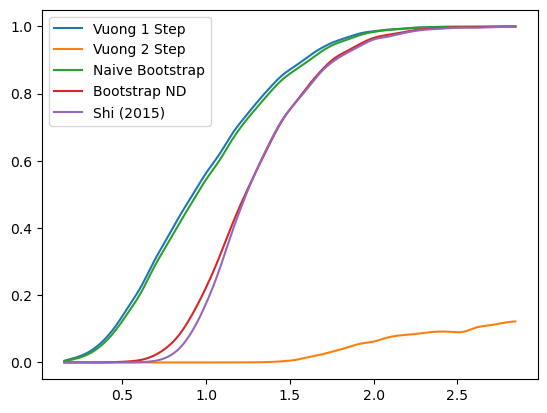

0.1 0.00020562447800032916


In [8]:
nobs = 100
c1,c2 = calc_c(nobs)
    
mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

# extra size sims

Quantiles: 1th: 0.74, 5th: 1.74, 10th: 3.05, 30th: 9.07, 50th: 15.64, 70th: 23.52, 90th: 37.34, 95th: 45.21, 99th: 60.05
bonus term 2.295236399286885 // variance stats 17.495651520446277 //part1 42.45189259825411 //part2 18.495651520446277 17.495651520446277
0.4061542215058533 -0.2339552702498409 4.033765790432005
-4.184318577067916 -0.2339552702498409 -0.5567070081417653
---
Quantiles: 1th: 0.67, 5th: 1.70, 10th: 2.99, 30th: 8.48, 50th: 14.64, 70th: 22.62, 90th: 36.22, 95th: 43.13, 99th: 57.12
bonus term 0.49734489874188087 // variance stats 79.34697714739367 //part1 39.96015921358673 //part2 80.34697714739367 79.34697714739367
-1.4846959103137085 1.676641397297752 2.3157557332149024
-2.4793857077974706 1.676641397297752 1.3210659357311403
---
Quantiles: 1th: 0.67, 5th: 1.83, 10th: 3.29, 30th: 9.86, 50th: 17.29, 70th: 26.39, 90th: 41.87, 95th: 49.79, 99th: 63.11
bonus term 1.8422631136326153 // variance stats 27.981288983311956 //part1 53.3911596794829 //part2 28.981288983311956 27.98

Quantiles: 1th: 0.75, 5th: 1.88, 10th: 3.43, 30th: 9.60, 50th: 17.15, 70th: 26.23, 90th: 41.43, 95th: 49.41, 99th: 62.94
bonus term 0.9402861981805665 // variance stats 54.59052436710609 //part1 52.27100281201034 //part2 55.59052436710609 54.59052436710609
-1.0645887948467694 0.8371554433707864 2.8356001831608704
-2.9451611912079025 0.8371554433707864 0.9550277867997372
---
Quantiles: 1th: 0.85, 5th: 2.04, 10th: 3.68, 30th: 10.12, 50th: 17.75, 70th: 27.61, 90th: 43.51, 95th: 51.41, 99th: 68.62
bonus term 1.223730608321842 // variance stats 46.107473145596344 //part1 57.646856768965456 //part2 47.107473145596344 46.107473145596344
-0.6881645730603052 0.5903017517777653 3.1620073022354873
-3.135625789703989 0.5903017517777653 0.7145460855918037
---
Quantiles: 1th: 0.71, 5th: 1.93, 10th: 3.34, 30th: 9.90, 50th: 17.06, 70th: 25.54, 90th: 40.14, 95th: 48.86, 99th: 64.37
bonus term 5.330812432615829 // variance stats 8.20277867738886 //part1 49.0582869880364 //part2 9.20277867738886 8.202778

Quantiles: 1th: 0.72, 5th: 1.94, 10th: 3.45, 30th: 10.11, 50th: 17.90, 70th: 27.72, 90th: 44.61, 95th: 52.99, 99th: 70.14
bonus term 1.9103751298778415 // variance stats 30.722842829036402 //part1 60.602529989614766 //part2 31.722842829036402 30.722842829036402
-0.06820996240411593 0.03593716740543588 3.782833480065662
-3.8889602221597994 0.03593716740543588 -0.03791677969002073
---
Quantiles: 1th: 0.82, 5th: 2.08, 10th: 3.45, 30th: 9.80, 50th: 16.87, 70th: 26.07, 90th: 41.80, 95th: 48.83, 99th: 67.26
bonus term 2.1533497473744894 // variance stats 23.704661108445134 //part1 53.1977757568427 //part2 24.704661108445134 23.704661108445134
0.33395251391803665 -0.20720571862442758 4.2114974770574936
-3.972746980830942 -0.20720571862442758 -0.09520201769148556
---
Quantiles: 1th: 0.85, 5th: 2.18, 10th: 3.66, 30th: 9.70, 50th: 17.54, 70th: 27.02, 90th: 41.86, 95th: 49.65, 99th: 65.46
bonus term 1.2765382203774716 // variance stats 40.79836656617957 //part1 53.357212471076075 //part2 41.79836

Quantiles: 1th: 0.75, 5th: 1.95, 10th: 3.45, 30th: 9.84, 50th: 17.65, 70th: 27.12, 90th: 43.50, 95th: 52.55, 99th: 68.80
bonus term 1.5985241498703449 // variance stats 35.05550793631179 //part1 57.63560017203629 //part2 36.0555079363118 35.05550793631179
-0.1844894075415271 0.19237693382521756 3.57791476332083
-3.381537707282217 0.19237693382521756 0.3808664635801401
---
Quantiles: 1th: 0.68, 5th: 1.87, 10th: 3.31, 30th: 9.52, 50th: 16.36, 70th: 25.75, 90th: 40.42, 95th: 47.94, 99th: 60.63
bonus term 10.151298984093078 // variance stats 3.9005677481569636 //part1 49.74712840334509 //part2 4.900567748156964 3.9005677481569636
8.577083116832457 -3.8109191087188052 11.639108482061816
-11.725514851353699 -3.8109191087188052 -8.66348948612434
---
Quantiles: 1th: 0.78, 5th: 1.93, 10th: 3.31, 30th: 9.85, 50th: 17.60, 70th: 26.89, 90th: 41.97, 95th: 50.42, 99th: 65.13
bonus term 2.0272579224261733 // variance stats 25.458032419930426 //part1 53.637255835112505 //part2 26.458032419930426 25.45

Quantiles: 1th: 0.77, 5th: 2.23, 10th: 4.06, 30th: 11.25, 50th: 19.65, 70th: 29.62, 90th: 46.98, 95th: 55.97, 99th: 72.53
bonus term 4.950647505183307 // variance stats 12.579072166983128 //part1 67.2251997461791 //part2 13.579072166983126 12.579072166983128
2.9629760659097304 -0.9726734230349057 6.815745161716509
-6.938318944456884 -0.9726734230349057 -3.0855498486501034
---
Quantiles: 1th: 0.86, 5th: 2.00, 10th: 3.55, 30th: 10.72, 50th: 18.30, 70th: 28.23, 90th: 45.47, 95th: 53.40, 99th: 68.96
bonus term 2.4315798083149427 // variance stats 24.89143985269696 //part1 62.95710235401873 //part2 25.89143985269696 24.89143985269696
0.562176196370943 -0.11155131155438018 4.266300566692709
-4.300983420258942 -0.11155131155438018 -0.5968590499371761
---
Quantiles: 1th: 0.77, 5th: 1.93, 10th: 3.49, 30th: 10.18, 50th: 17.63, 70th: 26.94, 90th: 43.64, 95th: 51.74, 99th: 66.52
bonus term 2.0861923798617976 // variance stats 26.794487981310052 //part1 57.984649028769354 //part2 27.794487981310052

Quantiles: 1th: 0.65, 5th: 1.88, 10th: 3.43, 30th: 10.11, 50th: 17.21, 70th: 26.33, 90th: 41.95, 95th: 50.27, 99th: 67.57
bonus term 0.8602894650705522 // variance stats 61.28441190261108 //part1 53.58262339793122 //part2 62.28441190261108 61.28441190261108
-1.0641027675306187 0.9183882699568316 2.8075664869070196
-2.784681697671723 0.9183882699568316 1.0869875567659153
---
Quantiles: 1th: 0.77, 5th: 1.99, 10th: 3.50, 30th: 10.08, 50th: 17.37, 70th: 26.32, 90th: 41.86, 95th: 49.81, 99th: 64.31
bonus term 1.6077369206942307 // variance stats 32.187446904443604 //part1 53.356683691853455 //part2 33.18744690444361 32.187446904443604
-0.33566744966038725 0.001327072032793642 3.714527775915789
-3.551141291048849 0.001327072032793642 0.49905393452732766
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.67, 5th: 1.71, 10th: 3.05, 30th: 9.26, 50th: 16.13, 70th: 25.27, 90th: 40.44, 95th: 48.14, 99th: 61.08
bonus term 4.740044747275682 // variance stats 9.50506445456281 //part1 49.79447558764

Quantiles: 1th: 0.80, 5th: 2.22, 10th: 4.32, 30th: 12.88, 50th: 21.34, 70th: 33.19, 90th: 52.42, 95th: 62.24, 99th: 81.69
bonus term 1.6245927579360748 // variance stats 50.51181271329796 //part1 83.6857178821833 //part2 51.51181271329796 50.51181271329796
-0.27755107113797933 0.0814162852629967 3.4061366644653055
-3.5267365870101286 0.0814162852629967 0.15695114859315598
---
Quantiles: 1th: 0.84, 5th: 2.07, 10th: 3.53, 30th: 10.96, 50th: 19.22, 70th: 29.22, 90th: 46.54, 95th: 55.28, 99th: 70.86
bonus term 0.8969038135081986 // variance stats 72.55492225771424 //part1 65.97169027524299 //part2 73.55492225771425 72.55492225771424
-0.9712608812824932 0.9575170761547764 2.9008223023584714
-2.7650685082988904 0.9575170761547764 1.1070146753420742
---
Quantiles: 1th: 0.67, 5th: 1.75, 10th: 3.05, 30th: 8.30, 50th: 14.54, 70th: 22.00, 90th: 34.86, 95th: 41.55, 99th: 54.71
bonus term 5.680074652954021 // variance stats 5.513914201468345 //part1 36.99951894727758 //part2 6.513914201468344 5.513

Quantiles: 1th: 0.75, 5th: 1.69, 10th: 2.86, 30th: 8.73, 50th: 15.14, 70th: 23.12, 90th: 36.57, 95th: 44.15, 99th: 56.86
bonus term 0.7583581931241884 // variance stats 52.703902687145806 //part1 40.72679460554115 //part2 53.70390268714581 52.703902687145806
-1.1520262032236142 0.41756744474510243 2.596456812626672
-2.668742589471991 0.41756744474510243 1.079740426378295
---
Quantiles: 1th: 0.76, 5th: 1.91, 10th: 3.34, 30th: 9.34, 50th: 16.61, 70th: 25.39, 90th: 40.42, 95th: 48.12, 99th: 63.99
bonus term 2.2389775499525313 // variance stats 21.217636877238284 //part1 49.744790181133986 //part2 22.217636877238284 21.217636877238284
0.3456523253792635 -0.8905497282403004 4.20472931651143
-4.132302774525799 -0.8905497282403004 -0.2732257833936324
---
Quantiles: 1th: 0.74, 5th: 1.88, 10th: 3.17, 30th: 9.21, 50th: 16.85, 70th: 26.25, 90th: 41.93, 95th: 49.55, 99th: 67.82
bonus term 1.9362746980297922 // variance stats 26.652683778796938 //part1 53.54319193350337 //part2 27.652683778796934 2

Quantiles: 1th: 0.65, 5th: 1.92, 10th: 3.47, 30th: 9.83, 50th: 17.03, 70th: 25.85, 90th: 40.65, 95th: 49.01, 99th: 63.47
bonus term 0.8890516805005779 // variance stats 55.58685321543433 //part1 50.30863694542143 //part2 56.58685321543433 55.58685321543433
-1.0902304033560999 0.5896596970210166 2.8721232278904996
-2.8683337643572555 0.5896596970210166 1.094019866889344
---
Quantiles: 1th: 0.81, 5th: 2.11, 10th: 3.87, 30th: 10.90, 50th: 18.85, 70th: 29.80, 90th: 47.42, 95th: 56.71, 99th: 72.85
bonus term 1.9824348555246003 // variance stats 33.53579573161938 //part1 68.46496522163999 //part2 34.53579573161938 33.53579573161938
0.23041369431103273 -0.6173159860313921 3.896086988503802
-3.7344560167381675 -0.6173159860313921 -0.06878272254539884
---
Quantiles: 1th: 0.68, 5th: 1.90, 10th: 3.32, 30th: 10.00, 50th: 17.76, 70th: 27.62, 90th: 43.70, 95th: 52.12, 99th: 67.48
bonus term 1.0448385898941281 // variance stats 54.66163203787005 //part1 58.157421129653976 //part2 55.66163203787005 54

Quantiles: 1th: 0.71, 5th: 1.96, 10th: 3.61, 30th: 10.45, 50th: 18.14, 70th: 28.52, 90th: 45.05, 95th: 53.30, 99th: 70.52
bonus term 1.52626262253529 // variance stats 39.50027242547016 //part1 61.81405200549179 //part2 40.500272425470165 39.50027242547016
-0.330015381765072 -0.13114363448418762 3.5278085296629698
-3.382540626835652 -0.13114363448418762 0.4752832845923899
---
Quantiles: 1th: 0.74, 5th: 1.96, 10th: 3.40, 30th: 9.85, 50th: 17.10, 70th: 25.96, 90th: 41.04, 95th: 48.79, 99th: 64.94
bonus term 0.8483215264775106 // variance stats 59.47520039844559 //part1 51.302414316042714 //part2 60.475200398445594 59.47520039844559
-1.3083628524983582 0.48769934460920317 2.8434958206941006
-3.0050059054533795 0.48769934460920317 1.1468527677390796
---
Quantiles: 1th: 0.89, 5th: 2.32, 10th: 4.06, 30th: 11.55, 50th: 19.32, 70th: 29.82, 90th: 47.83, 95th: 57.37, 99th: 75.84
bonus term 2.4635080663748425 // variance stats 27.2798435764355 //part1 69.66762276636763 //part2 28.2798435764355 27

Quantiles: 1th: 0.66, 5th: 1.69, 10th: 2.78, 30th: 7.71, 50th: 13.38, 70th: 20.68, 90th: 32.57, 95th: 38.99, 99th: 51.09
bonus term 0.6257845365129908 // variance stats 50.62587149764333 //part1 32.30667206723196 //part2 51.62587149764333 50.62587149764333
-1.3986838153992318 0.589010691588118 2.3857981767716585
-2.6502528884252134 0.589010691588118 1.1342291037456766
---
Quantiles: 1th: 0.72, 5th: 2.05, 10th: 3.45, 30th: 9.99, 50th: 17.90, 70th: 28.17, 90th: 43.68, 95th: 52.57, 99th: 69.95
bonus term 1.4665848361433285 // variance stats 38.61727517425393 //part1 58.10209501987837 //part2 39.61727517425394 38.61727517425393
-0.4005928158942101 -0.5387550165444135 3.4528798096223015
-3.333762488180867 -0.5387550165444135 0.5197101373356446
---
Quantiles: 1th: 0.65, 5th: 1.75, 10th: 2.98, 30th: 8.77, 50th: 15.51, 70th: 23.58, 90th: 37.33, 95th: 44.73, 99th: 57.81
bonus term 0.8336491447539568 // variance stats 49.90283965347385 //part1 42.43510874266627 //part2 50.90283965347385 49.90283

Quantiles: 1th: 0.83, 5th: 2.11, 10th: 3.95, 30th: 11.81, 50th: 20.49, 70th: 32.02, 90th: 50.12, 95th: 58.62, 99th: 77.05
bonus term 1.6117289952013507 // variance stats 46.45320593003755 //part1 76.48170791270222 //part2 47.453205930037555 46.45320593003755
-0.3538861906008499 -0.7592735936272339 3.759847217416113
-3.577344181003551 -0.7592735936272339 0.5363892270134112
---
Quantiles: 1th: 0.75, 5th: 1.97, 10th: 3.33, 30th: 9.85, 50th: 17.16, 70th: 26.20, 90th: 41.53, 95th: 50.00, 99th: 66.89
bonus term 1.8906174585488926 // variance stats 26.77520724128294 //part1 52.51229172518315 //part2 27.77520724128294 26.77520724128294
0.08037815272930159 -1.5537932204657474 3.694667969634942
-3.7008567643684835 -1.5537932204657474 -0.08656694746284313
---
Quantiles: 1th: 0.75, 5th: 1.76, 10th: 3.14, 30th: 9.00, 50th: 15.87, 70th: 24.56, 90th: 38.87, 95th: 45.92, 99th: 59.30
bonus term 0.9984318811794499 // variance stats 45.083776863863406 //part1 46.01151202604116 //part2 46.08377686386341 4

Quantiles: 1th: 0.68, 5th: 1.64, 10th: 2.96, 30th: 8.18, 50th: 14.59, 70th: 22.33, 90th: 35.08, 95th: 42.59, 99th: 54.95
bonus term 0.8168950804296403 // variance stats 44.88503864524883 //part1 37.483262334627696 //part2 45.885038645248834 44.88503864524883
-1.0506927706775224 -0.5250846164300648 2.6456827783776338
-2.6844829315368033 -0.5250846164300648 1.0118926175183531
---
Quantiles: 1th: 0.72, 5th: 1.89, 10th: 3.42, 30th: 10.42, 50th: 17.55, 70th: 26.86, 90th: 42.48, 95th: 50.02, 99th: 66.45
bonus term 0.5847059619300157 // variance stats 92.99184365470617 //part1 54.95759135770062 //part2 93.99184365470619 92.99184365470617
-1.208932798766645 1.0870070232985625 2.6012443568672388
-2.378344722626676 1.0870070232985625 1.4318324330072076
---
Quantiles: 1th: 0.87, 5th: 2.11, 10th: 3.54, 30th: 9.52, 50th: 17.06, 70th: 26.30, 90th: 41.29, 95th: 48.47, 99th: 63.02
bonus term 0.9140489386138106 // variance stats 55.79142208876206 //part1 51.910139082601894 //part2 56.79142208876206 55.

Quantiles: 1th: 0.81, 5th: 1.99, 10th: 3.44, 30th: 10.43, 50th: 18.36, 70th: 28.06, 90th: 44.58, 95th: 53.21, 99th: 70.82
bonus term 0.8519122876866431 // variance stats 70.03818767813536 //part1 60.51830497799339 //part2 71.03818767813536 70.03818767813536
-1.0475141852780727 0.1434816117230207 2.8465547056979528
-2.7513387606513584 0.1434816117230207 1.1427301303246669
---
Quantiles: 1th: 0.75, 5th: 1.98, 10th: 3.61, 30th: 10.27, 50th: 17.95, 70th: 27.63, 90th: 43.85, 95th: 52.58, 99th: 69.45
bonus term 0.5964092636980077 // variance stats 97.15831085165185 //part1 58.54252590087385 //part2 98.15831085165185 97.15831085165185
-1.299811617012143 0.9853343699737914 2.565131423959041
-2.492630144408158 0.9853343699737914 1.3723128965630254
---
Quantiles: 1th: 0.68, 5th: 1.81, 10th: 3.17, 30th: 9.25, 50th: 15.87, 70th: 24.10, 90th: 37.67, 95th: 45.43, 99th: 58.92
bonus term 0.721598225038452 // variance stats 58.885330442133274 //part1 43.21314815288455 //part2 59.88533044213328 58.88533

0.7692307692307693 [0.98 0.   0.02]
Quantiles: 1th: 0.76, 5th: 1.89, 10th: 3.29, 30th: 9.59, 50th: 16.99, 70th: 26.38, 90th: 43.11, 95th: 50.85, 99th: 67.18
bonus term 0.538649532760814 // variance stats 104.04768318132591 //part1 56.58388546322722 //part2 105.04768318132591 104.04768318132591
-1.3542940653249629 0.9657906391369864 2.363194000783277
-2.4315931308465912 0.9657906391369864 1.2858949352616493
---
Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.27, 30th: 9.79, 50th: 16.40, 70th: 25.79, 90th: 40.14, 95th: 47.95, 99th: 62.01
bonus term 1.0137872847437752 // variance stats 47.39811997210187 //part1 49.06539863322064 //part2 48.398119972101874 47.39811997210187
-0.8463672527625393 -1.0013099384922222 2.8805609357945214
-2.8739418222500897 -1.0013099384922222 0.8529863663069713
---
Quantiles: 1th: 0.77, 5th: 2.05, 10th: 3.44, 30th: 9.35, 50th: 16.41, 70th: 24.92, 90th: 40.65, 95th: 48.07, 99th: 62.92
bonus term 1.1586495889701205 // variance stats 42.42262452639267 //part1 50.31160605

Quantiles: 1th: 0.64, 5th: 1.83, 10th: 3.05, 30th: 8.71, 50th: 14.93, 70th: 23.57, 90th: 37.40, 95th: 44.16, 99th: 56.95
bonus term 0.8363956150249833 // variance stats 49.93917210595242 //part1 42.60530018242156 //part2 50.93917210595242 49.93917210595242
-1.0590758237095577 -1.1402915497164812 2.8163967262141227
-2.7318670537595247 -1.1402915497164812 1.1436054961641557
---
Quantiles: 1th: 0.74, 5th: 1.89, 10th: 3.30, 30th: 9.76, 50th: 17.00, 70th: 25.91, 90th: 42.10, 95th: 49.36, 99th: 64.08
bonus term 0.8134595617653504 // variance stats 65.36220593631646 //part1 53.98297095873793 //part2 66.36220593631646 65.36220593631646
-0.991252487432144 -0.4070598259338918 2.6930920893041823
-2.618171610962845 -0.4070598259338918 1.0661729657734815
---
Quantiles: 1th: 0.61, 5th: 1.71, 10th: 2.87, 30th: 9.02, 50th: 16.18, 70th: 24.62, 90th: 38.68, 95th: 46.85, 99th: 60.23
bonus term 1.0590697317386222 // variance stats 42.021896697454835 //part1 45.56318859426022 //part2 43.02189669745484 42.0

Quantiles: 1th: 0.69, 5th: 1.98, 10th: 3.53, 30th: 10.54, 50th: 18.47, 70th: 28.21, 90th: 45.23, 95th: 53.66, 99th: 70.64
bonus term 0.9908526282154327 // variance stats 61.88382778555952 //part1 62.30860603356832 //part2 62.883827785559525 61.88382778555952
-1.0742459492687468 -0.6871412188001027 2.815573780533546
-3.0559512056996128 -0.6871412188001027 0.8338685241026803
---
Quantiles: 1th: 0.75, 5th: 1.89, 10th: 3.31, 30th: 9.44, 50th: 16.85, 70th: 25.79, 90th: 40.90, 95th: 48.02, 99th: 62.82
bonus term 0.62496746970379 // variance stats 80.50704103801628 //part1 50.939249200572014 //part2 81.5070410380163 80.50704103801628
-1.3267292153347987 0.22485904023454603 2.682019022717004
-2.576664154742379 0.22485904023454603 1.4320840833094242
---
Quantiles: 1th: 0.91, 5th: 1.98, 10th: 3.52, 30th: 9.93, 50th: 17.75, 70th: 27.25, 90th: 42.85, 95th: 50.38, 99th: 66.92
bonus term 1.0170656590987428 // variance stats 53.98271196145754 //part1 55.92102818011615 //part2 54.98271196145755 53.982

Quantiles: 1th: 0.74, 5th: 1.98, 10th: 3.41, 30th: 10.16, 50th: 17.35, 70th: 27.12, 90th: 42.89, 95th: 51.45, 99th: 68.32
bonus term 0.7982763913348077 // variance stats 69.18636482980101 //part1 56.028118037241825 //part2 70.18636482980102 69.18636482980101
-0.952748807061387 -0.8158409940252473 2.73793820251046
-2.5493015897310025 -0.8158409940252473 1.1413854198408449
---
Quantiles: 1th: 0.63, 5th: 1.91, 10th: 3.67, 30th: 10.64, 50th: 18.31, 70th: 28.17, 90th: 45.19, 95th: 54.69, 99th: 71.44
bonus term 0.7441266054573399 // variance stats 82.58339709749127 //part1 62.196629554749066 //part2 83.58339709749129 82.58339709749127
-1.286495077546501 -0.08223038019955078 2.656569322939023
-2.7747482884611805 -0.08223038019955078 1.1683161120243428
---
Quantiles: 1th: 0.81, 5th: 2.21, 10th: 4.08, 30th: 11.75, 50th: 20.62, 70th: 31.22, 90th: 48.43, 95th: 57.46, 99th: 76.80
bonus term 1.6197359129808786 // variance stats 43.09201699311256 //part1 71.4174233995076 //part2 44.092016993112566 4

Quantiles: 1th: 0.87, 5th: 2.09, 10th: 3.68, 30th: 10.52, 50th: 18.15, 70th: 27.90, 90th: 44.86, 95th: 53.52, 99th: 70.10
bonus term 0.6757115849120922 // variance stats 89.69241606256763 //part1 61.28191619714447 //part2 90.69241606256764 89.69241606256763
-1.3223126709296338 -0.026342871329961215 2.7109585681615127
-2.6737358407538183 -0.026342871329961215 1.3595353983373282
---
Quantiles: 1th: 0.66, 5th: 1.70, 10th: 2.94, 30th: 8.69, 50th: 15.52, 70th: 23.98, 90th: 37.41, 95th: 44.16, 99th: 57.95
bonus term 0.46005005364190765 // variance stats 91.63801053420121 //part1 42.61812171553888 //part2 92.63801053420123 91.63801053420121
-1.3793609794954707 0.3921127752715058 2.405932178473371
-2.299461086779286 0.3921127752715058 1.4858320711895558
---
Quantiles: 1th: 0.74, 5th: 1.75, 10th: 2.91, 30th: 8.98, 50th: 15.89, 70th: 24.41, 90th: 38.57, 95th: 45.63, 99th: 61.21
bonus term 0.6486066891923665 // variance stats 68.85190241259382 //part1 45.30641115762076 //part2 69.85190241259382 6

Quantiles: 1th: 0.71, 5th: 1.85, 10th: 3.38, 30th: 9.57, 50th: 16.75, 70th: 25.97, 90th: 42.18, 95th: 49.63, 99th: 63.32
bonus term 1.0854157568554421 // variance stats 48.91451185737617 //part1 54.1779976657439 //part2 49.914511857376176 48.91451185737617
-0.8694735020705819 -2.376157250781624 2.967878784316698
-3.0403050157814664 -2.376157250781624 0.7970472706058138
---
Quantiles: 1th: 0.84, 5th: 2.25, 10th: 3.98, 30th: 11.04, 50th: 18.94, 70th: 28.83, 90th: 45.48, 95th: 54.18, 99th: 73.01
bonus term 0.6697099304285208 // variance stats 93.05970406575098 //part1 62.99271786600134 //part2 94.05970406575098 93.05970406575098
-1.3811093510547126 -0.014160858690068091 2.5604050149778073
-2.7205292119117543 -0.014160858690068091 1.2209851541207655
---
1.076923076923077 [0.96428571 0.00142857 0.03428571]
Quantiles: 1th: 0.77, 5th: 1.94, 10th: 3.49, 30th: 10.37, 50th: 17.78, 70th: 27.03, 90th: 43.09, 95th: 50.97, 99th: 66.71
bonus term 0.7465142506946253 // variance stats 74.75713221936797

Quantiles: 1th: 0.75, 5th: 1.98, 10th: 3.16, 30th: 9.12, 50th: 15.77, 70th: 24.32, 90th: 38.69, 95th: 45.61, 99th: 60.85
bonus term 0.3455894466680357 // variance stats 130.87272295978985 //part1 45.57382135828095 //part2 131.87272295978988 130.87272295978985
-1.581630141383923 1.5779759390602437 2.2387028730095566
-2.2728090347199945 1.5779759390602437 1.5475239796734848
---
Quantiles: 1th: 0.66, 5th: 1.68, 10th: 2.91, 30th: 9.03, 50th: 16.03, 70th: 25.08, 90th: 39.44, 95th: 47.03, 99th: 61.21
bonus term 0.5404913957484914 // variance stats 86.64582552402393 //part1 47.37181456900844 //part2 87.64582552402393 86.64582552402393
-1.3981128049485545 -0.7042997025503164 2.3802847888006458
-2.479095596445537 -0.7042997025503164 1.299301997303663
---
Quantiles: 1th: 0.68, 5th: 2.02, 10th: 3.45, 30th: 10.42, 50th: 18.20, 70th: 28.17, 90th: 45.03, 95th: 53.91, 99th: 71.53
bonus term 1.1248227869035219 // variance stats 53.89205653213022 //part1 61.74383600733639 //part2 54.89205653213022 53.8

Quantiles: 1th: 0.78, 5th: 1.88, 10th: 3.41, 30th: 10.16, 50th: 17.85, 70th: 27.96, 90th: 44.12, 95th: 52.27, 99th: 68.02
bonus term 0.5590829544747783 // variance stats 105.04558472164025 //part1 59.28827881518004 //part2 106.04558472164025 105.04558472164025
-1.3651950244248972 0.3852647729040342 2.5028273878161644
-2.483360933374454 0.3852647729040342 1.3846614788666078
---
Quantiles: 1th: 0.62, 5th: 1.80, 10th: 3.16, 30th: 9.42, 50th: 17.12, 70th: 26.84, 90th: 41.94, 95th: 50.54, 99th: 67.38
bonus term 0.8930447268380785 // variance stats 58.978431000214876 //part1 53.563421528763435 //part2 59.978431000214876 58.978431000214876
-1.0211210552741992 -2.4514546633419267 2.683825858058498
-2.807210508950356 -2.4514546633419267 0.8977364043823411
---
Quantiles: 1th: 0.82, 5th: 2.09, 10th: 3.60, 30th: 9.94, 50th: 17.33, 70th: 26.23, 90th: 42.21, 95th: 50.24, 99th: 64.35
bonus term 0.47632843551212584 // variance stats 112.88906748095434 //part1 54.24860133513792 //part2 113.889067480954

Quantiles: 1th: 0.76, 5th: 1.93, 10th: 3.33, 30th: 9.94, 50th: 17.53, 70th: 27.13, 90th: 43.18, 95th: 51.46, 99th: 67.90
bonus term 0.427474147982453 // variance stats 131.79480458472446 //part1 56.76634594635143 //part2 132.79480458472446 131.79480458472446
-1.4946483418825032 0.9347226353844547 2.389297465075249
-2.3495966378474096 0.9347226353844547 1.5343491691103426
---
Quantiles: 1th: 0.77, 5th: 1.86, 10th: 3.01, 30th: 8.96, 50th: 15.03, 70th: 22.93, 90th: 35.44, 95th: 42.55, 99th: 56.79
bonus term 0.5046981824524209 // variance stats 74.76890778449697 //part1 38.24043004524072 //part2 75.76890778449699 74.76890778449697
-1.393780620441536 -1.0674847918400105 2.402985095225517
-2.4031769853463776 -1.0674847918400105 1.393588730320675
---
Quantiles: 1th: 0.71, 5th: 1.91, 10th: 3.25, 30th: 9.89, 50th: 17.73, 70th: 27.67, 90th: 43.97, 95th: 52.30, 99th: 69.75
bonus term 0.4949476368036961 // variance stats 117.94667288369972 //part1 58.872374649449455 //part2 118.94667288369973 117.

Quantiles: 1th: 0.72, 5th: 1.84, 10th: 3.30, 30th: 9.38, 50th: 16.53, 70th: 24.72, 90th: 39.79, 95th: 47.24, 99th: 59.84
bonus term 0.3263436913745014 // variance stats 146.77109632938885 //part1 48.2241650545898 //part2 147.77109632938885 146.77109632938885
-1.574007489280076 1.1989101313113713 2.1965479047926335
-2.226694872029079 1.1989101313113713 1.5438605220436308
---
Quantiles: 1th: 0.74, 5th: 1.79, 10th: 3.11, 30th: 9.96, 50th: 16.94, 70th: 26.35, 90th: 41.83, 95th: 49.57, 99th: 65.88
bonus term 0.41366466247201017 // variance stats 127.79193197913894 //part1 53.27667107126861 //part2 128.79193197913895 127.79193197913894
-1.5671515672098923 0.4384094152438526 2.2690551165588793
-2.394480892153913 0.4384094152438526 1.441725791614859
---
Quantiles: 1th: 0.66, 5th: 1.78, 10th: 3.43, 30th: 10.08, 50th: 17.68, 70th: 27.42, 90th: 43.32, 95th: 51.94, 99th: 68.74
bonus term 0.3598344181930983 // variance stats 157.80062216804544 //part1 57.141929486540654 //part2 158.80062216804544 1

Quantiles: 1th: 0.70, 5th: 1.89, 10th: 3.47, 30th: 9.47, 50th: 16.05, 70th: 24.77, 90th: 38.95, 95th: 46.75, 99th: 61.96
bonus term 0.48263298379286446 // variance stats 94.71840671428262 //part1 46.19686023641318 //part2 95.71840671428262 94.71840671428262
-1.4100036827511755 -0.9911503128541916 2.4537254459874354
-2.375269650336904 -0.9911503128541916 1.4884594784017064
---
Quantiles: 1th: 0.71, 5th: 1.72, 10th: 2.84, 30th: 8.11, 50th: 14.45, 70th: 21.88, 90th: 36.03, 95th: 42.22, 99th: 55.34
bonus term 0.3377488614643785 // variance stats 116.0584807079106 //part1 39.53636858384672 //part2 117.05848070791062 116.0584807079106
-1.608758486959747 0.7572865468818116 2.471296566219436
-2.284256209888504 0.7572865468818116 1.7957988432906788
---
Quantiles: 1th: 0.68, 5th: 1.86, 10th: 3.04, 30th: 9.25, 50th: 15.79, 70th: 24.25, 90th: 38.60, 95th: 46.13, 99th: 59.87
bonus term 0.3665468566542877 // variance stats 122.78371324231051 //part1 45.37253099396465 //part2 123.78371324231053 122.7

Quantiles: 1th: 0.73, 5th: 1.70, 10th: 2.84, 30th: 8.45, 50th: 14.80, 70th: 22.99, 90th: 36.51, 95th: 43.50, 99th: 57.46
bonus term 0.31371877674039156 // variance stats 128.41915518372494 //part1 40.601219051013096 //part2 129.41915518372494 128.41915518372494
-1.6514985308098213 0.6518382567722738 2.4845446241044753
-2.2789360842906046 0.6518382567722738 1.857107070623692
---
Quantiles: 1th: 0.83, 5th: 2.29, 10th: 3.99, 30th: 11.73, 50th: 19.95, 70th: 30.53, 90th: 49.43, 95th: 59.73, 99th: 76.93
bonus term 0.494946277083947 // variance stats 149.30195056478507 //part1 74.39139087049581 //part2 150.30195056478507 149.30195056478507
-1.3805819947342792 0.5731404983976006 2.516195638084295
-2.3704745489021732 0.5731404983976006 1.526303083916401
---
Quantiles: 1th: 0.65, 5th: 1.97, 10th: 3.34, 30th: 10.14, 50th: 17.38, 70th: 26.82, 90th: 42.54, 95th: 50.59, 99th: 65.12
bonus term 0.6324816654183739 // variance stats 86.14099266877788 //part1 55.11508016935896 //part2 87.1409926687779 86

Quantiles: 1th: 0.73, 5th: 2.04, 10th: 3.46, 30th: 9.66, 50th: 16.93, 70th: 26.52, 90th: 41.85, 95th: 49.85, 99th: 64.08
bonus term 0.35755363569731197 // variance stats 148.17785528945103 //part1 53.339084524270696 //part2 149.17785528945103 148.17785528945103
-1.559826557029601 0.7914484827379162 2.4663035199284327
-2.274933828424225 0.7914484827379162 1.7511962485338088
---
Quantiles: 1th: 0.72, 5th: 1.78, 10th: 3.21, 30th: 9.23, 50th: 16.02, 70th: 23.97, 90th: 38.85, 95th: 45.64, 99th: 61.80
bonus term 0.4273101004573351 // variance stats 106.58192148818117 //part1 45.97084167850783 //part2 107.58192148818117 106.58192148818117
-1.5473530949892411 -0.6734797921603723 2.4848161309724306
-2.4019732959039115 -0.6734797921603723 1.6301959300577602
---
Quantiles: 1th: 0.77, 5th: 1.97, 10th: 3.21, 30th: 9.24, 50th: 16.18, 70th: 24.94, 90th: 39.65, 95th: 47.38, 99th: 59.77
bonus term 0.4646779795470107 // variance stats 102.03832433252765 //part1 47.87964036674854 //part2 103.038324332527

Quantiles: 1th: 0.71, 5th: 1.82, 10th: 3.19, 30th: 9.14, 50th: 15.78, 70th: 24.61, 90th: 39.63, 95th: 46.64, 99th: 60.38
bonus term 0.3263828492664072 // variance stats 145.50532455892966 //part1 47.816825262243206 //part2 146.50532455892966 145.50532455892966
-1.7971990285347297 0.7802278279365518 2.3385488139614847
-2.449964727067544 0.7802278279365518 1.6857831154286702
---
Quantiles: 1th: 0.70, 5th: 1.79, 10th: 3.37, 30th: 10.02, 50th: 17.43, 70th: 26.37, 90th: 42.07, 95th: 49.00, 99th: 63.31
bonus term 0.3251286320934364 // variance stats 164.7717353169333 //part1 53.89713754334973 //part2 165.7717353169333 164.7717353169333
-1.6964551424506473 0.8901103189244306 2.3494262295038912
-2.3467124066375202 0.8901103189244306 1.6991689653170186
---
Quantiles: 1th: 0.77, 5th: 2.00, 10th: 3.41, 30th: 10.11, 50th: 17.72, 70th: 27.85, 90th: 43.06, 95th: 51.47, 99th: 69.62
bonus term 0.46642722766224953 // variance stats 120.07534348353778 //part1 56.47283679928114 //part2 121.07534348353778

1.6153846153846154 [0.96857143 0.00285714 0.02857143]
Quantiles: 1th: 0.73, 5th: 2.04, 10th: 3.46, 30th: 9.93, 50th: 17.07, 70th: 26.63, 90th: 42.28, 95th: 49.70, 99th: 66.68
bonus term 0.34519598691717013 // variance stats 156.728545097893 //part1 54.44726079007655 //part2 157.728545097893 156.728545097893
-1.494343075243901 0.67144958679509 2.3377465426666517
-2.1847350490782413 0.67144958679509 1.6473545688323112
---
Quantiles: 1th: 0.71, 5th: 2.01, 10th: 3.79, 30th: 11.02, 50th: 19.15, 70th: 29.37, 90th: 46.93, 95th: 56.26, 99th: 73.50
bonus term 0.3474516488004366 // variance stats 191.99605891537055 //part1 67.05679888213172 //part2 192.99605891537055 191.99605891537055
-1.388326989640833 1.2866222827646296 2.2776911707438323
-2.083230287241706 1.2866222827646296 1.5827878731429592
---
Quantiles: 1th: 0.71, 5th: 1.97, 10th: 3.46, 30th: 10.23, 50th: 17.76, 70th: 26.84, 90th: 42.55, 95th: 50.61, 99th: 64.93
bonus term 0.4265718403755147 // variance stats 128.23093308351883 //part1 

Quantiles: 1th: 0.70, 5th: 1.86, 10th: 3.14, 30th: 9.16, 50th: 15.92, 70th: 24.88, 90th: 39.16, 95th: 47.37, 99th: 62.98
bonus term 0.4116904536545513 // variance stats 112.4367726922162 //part1 46.700836410766705 //part2 113.4367726922162 112.4367726922162
-1.5780653504751068 -0.9810543176112075 2.4155305852831663
-2.4014462577842095 -0.9810543176112075 1.5921496779740638
---
Quantiles: 1th: 0.66, 5th: 1.91, 10th: 3.39, 30th: 10.20, 50th: 17.58, 70th: 26.90, 90th: 43.09, 95th: 51.40, 99th: 65.22
bonus term 0.3841106539055339 // variance stats 146.19073384004912 //part1 56.53752902413667 //part2 147.19073384004912 146.19073384004912
-1.6476782476339906 0.23928478466908715 2.4453941643022903
-2.4158995554450584 0.23928478466908715 1.6771728564912223
---
Quantiles: 1th: 0.82, 5th: 2.01, 10th: 3.69, 30th: 10.59, 50th: 18.50, 70th: 29.12, 90th: 45.98, 95th: 55.49, 99th: 71.33
bonus term 0.5567180711534846 // variance stats 114.66292025805403 //part1 64.39163787004314 //part2 115.6629202580

Quantiles: 1th: 0.83, 5th: 2.18, 10th: 3.90, 30th: 10.81, 50th: 19.31, 70th: 29.75, 90th: 48.49, 95th: 56.05, 99th: 75.10
bonus term 0.45961321663141697 // variance stats 154.7955872000463 //part1 71.60571096999368 //part2 155.7955872000463 154.7955872000463
-1.5520523196211473 0.2841807143383149 2.3526484261441443
-2.471278752883981 0.2841807143383149 1.4334219928813106
---
Quantiles: 1th: 0.73, 5th: 1.98, 10th: 3.32, 30th: 9.69, 50th: 17.01, 70th: 25.97, 90th: 40.85, 95th: 48.38, 99th: 64.23
bonus term 0.31030043430102267 // variance stats 162.74846255367615 //part1 50.811219046530454 //part2 163.74846255367615 162.74846255367615
-1.710821242888748 0.5070963281094573 2.3013308047407928
-2.3314221114907934 0.5070963281094573 1.6807299361387475
---
Quantiles: 1th: 0.72, 5th: 1.80, 10th: 3.22, 30th: 9.34, 50th: 16.53, 70th: 25.96, 90th: 41.31, 95th: 49.55, 99th: 63.82
bonus term 0.3913694739338178 // variance stats 131.7953477422423 //part1 51.97204538673979 //part2 132.79534774224234 1

Quantiles: 1th: 0.82, 5th: 1.98, 10th: 3.29, 30th: 9.04, 50th: 16.16, 70th: 24.73, 90th: 38.83, 95th: 46.33, 99th: 58.41
bonus term 0.40524914537905693 // variance stats 112.31502892257113 //part1 45.92081862947507 //part2 113.31502892257113 112.31502892257113
-1.5548099964996567 -1.3742000327237687 2.434859086906634
-2.36530828725777 -1.3742000327237687 1.6243607961485205
---
Quantiles: 1th: 0.63, 5th: 1.73, 10th: 2.97, 30th: 8.48, 50th: 14.95, 70th: 23.26, 90th: 36.77, 95th: 43.43, 99th: 58.03
bonus term 0.36771361149425863 // variance stats 110.98719883971178 //part1 41.17921732647607 //part2 111.98719883971178 110.98719883971178
-1.5209055127667095 -1.2848558441980489 2.4569014461564334
-2.256332735755227 -1.2848558441980489 1.721474223167916
---
Quantiles: 1th: 0.59, 5th: 1.64, 10th: 2.89, 30th: 8.33, 50th: 14.53, 70th: 22.53, 90th: 36.00, 95th: 42.48, 99th: 56.85
bonus term 0.2600201894525631 // variance stats 150.82167668204522 //part1 39.47670113387118 //part2 151.8216766820452

Quantiles: 1th: 0.73, 5th: 1.83, 10th: 3.43, 30th: 10.31, 50th: 17.89, 70th: 27.19, 90th: 43.23, 95th: 51.80, 99th: 68.26
bonus term 0.31913698292567655 // variance stats 177.35830783200464 //part1 56.92073224123502 //part2 178.35830783200464 177.35830783200464
-1.7358968166238182 0.5001225317578483 2.3014084390323712
-2.3741707824751717 0.5001225317578483 1.663134473181018
---
Quantiles: 1th: 0.74, 5th: 2.05, 10th: 3.62, 30th: 10.22, 50th: 17.58, 70th: 26.63, 90th: 42.62, 95th: 51.03, 99th: 66.11
bonus term 0.3645933154486187 // variance stats 150.72063119980888 //part1 55.31632795109547 //part2 151.72063119980888 150.72063119980888
-1.542673300427584 -0.5117571099189803 2.224675848897967
-2.2718599313248213 -0.5117571099189803 1.4954892180007295
---
Quantiles: 1th: 0.68, 5th: 1.94, 10th: 3.49, 30th: 10.36, 50th: 17.98, 70th: 27.07, 90th: 42.64, 95th: 50.58, 99th: 65.84
bonus term 0.339705102073968 // variance stats 161.95607382475646 //part1 55.35700969221195 //part2 162.956073824756

Quantiles: 1th: 0.63, 5th: 1.67, 10th: 2.96, 30th: 8.88, 50th: 15.56, 70th: 24.08, 90th: 38.52, 95th: 45.85, 99th: 61.20
bonus term 0.26847662023980423 // variance stats 167.30390175110404 //part1 45.18566271530848 //part2 168.30390175110404 167.30390175110404
-1.6563451196569359 0.7526512372282332 2.269870627049513
-2.1932983601365446 0.7526512372282332 1.7329173865699046
---
Quantiles: 1th: 0.98, 5th: 2.35, 10th: 3.98, 30th: 11.66, 50th: 20.68, 70th: 31.51, 90th: 49.23, 95th: 59.72, 99th: 78.40
bonus term 0.44712213052978916 // variance stats 164.0609455829465 //part1 73.80240165630862 //part2 165.0609455829465 164.0609455829465
-1.4539162969762323 0.1270571289444384 2.2565334630238842
-2.3481605580358105 0.1270571289444384 1.362289201964306
---
1.9230769230769231 [0.98428571 0.00142857 0.01428571]
Quantiles: 1th: 0.61, 5th: 1.76, 10th: 3.26, 30th: 9.25, 50th: 16.24, 70th: 24.46, 90th: 39.02, 95th: 46.26, 99th: 61.30
bonus term 0.3271181052217183 // variance stats 140.77055370843325 

Quantiles: 1th: 0.74, 5th: 2.08, 10th: 3.49, 30th: 10.25, 50th: 17.98, 70th: 27.43, 90th: 43.51, 95th: 51.47, 99th: 67.86
bonus term 0.32813635476592373 // variance stats 174.69438272607442 //part1 57.65171430058315 //part2 175.69438272607442 174.69438272607442
-1.642741556755124 0.38387724901295495 2.4129207967491433
-2.2990142662869713 0.38387724901295495 1.7566480872172958
---
Quantiles: 1th: 0.73, 5th: 1.88, 10th: 3.25, 30th: 9.48, 50th: 16.17, 70th: 24.62, 90th: 39.80, 95th: 47.66, 99th: 61.79
bonus term 0.32908307996961195 // variance stats 145.61124887188492 //part1 48.24728133695118 //part2 146.61124887188492 145.61124887188492
-1.5227396233788943 -0.8535949592370812 2.3934091090942595
-2.1809057833181185 -0.8535949592370812 1.7352429491550352
---
Quantiles: 1th: 0.63, 5th: 1.67, 10th: 2.78, 30th: 8.70, 50th: 15.20, 70th: 23.60, 90th: 37.04, 95th: 44.23, 99th: 58.78
bonus term 0.2794807079821831 // variance stats 148.4650561567772 //part1 41.77259971329285 //part2 149.465056156

Quantiles: 1th: 0.72, 5th: 1.87, 10th: 3.27, 30th: 9.47, 50th: 16.28, 70th: 24.78, 90th: 39.71, 95th: 47.50, 99th: 61.22
bonus term 0.31983630998168655 // variance stats 149.16843254135762 //part1 48.02931733976164 //part2 150.16843254135762 149.16843254135762
-1.6577910510492653 -0.5891196227922655 2.296849012189674
-2.2974636710126384 -0.5891196227922655 1.657176392226301
---
Quantiles: 1th: 0.63, 5th: 1.78, 10th: 2.99, 30th: 9.24, 50th: 16.19, 70th: 25.39, 90th: 39.33, 95th: 47.50, 99th: 63.33
bonus term 0.23098834083626243 // variance stats 202.88304452565725 //part1 47.09460617962739 //part2 203.88304452565725 202.88304452565725
-1.5677147569012773 1.543905229097152 2.3357081623997846
-2.0296914385738023 1.543905229097152 1.8737314807272598
---
Quantiles: 1th: 0.83, 5th: 1.87, 10th: 3.13, 30th: 9.06, 50th: 15.84, 70th: 23.80, 90th: 37.35, 95th: 44.35, 99th: 60.50
bonus term 0.33342449583797457 // variance stats 126.38131517751252 //part1 42.47205079224025 //part2 127.3813151775125

Quantiles: 1th: 0.76, 5th: 1.90, 10th: 3.30, 30th: 9.58, 50th: 17.16, 70th: 26.38, 90th: 41.60, 95th: 49.75, 99th: 66.10
bonus term 0.25942180784846575 // variance stats 202.14033261342965 //part1 52.69903233351457 //part2 203.14033261342965 202.14033261342965
-1.6362068989578635 0.8418510898874886 2.1684091072481304
-2.155050514654795 0.8418510898874886 1.6495654915511988
---
Quantiles: 1th: 0.62, 5th: 1.94, 10th: 3.47, 30th: 10.22, 50th: 17.62, 70th: 26.99, 90th: 42.58, 95th: 50.35, 99th: 65.77
bonus term 0.31357101662067166 // variance stats 175.10856584533548 //part1 55.22254202773035 //part2 176.10856584533548 175.10856584533548
-1.587676462776987 -0.2954791713023442 2.148260534950011
-2.21481849601833 -0.2954791713023442 1.5211185017086681
---
Quantiles: 1th: 0.63, 5th: 1.70, 10th: 2.92, 30th: 8.65, 50th: 14.86, 70th: 22.93, 90th: 36.40, 95th: 43.75, 99th: 56.37
bonus term 0.2983091987916292 // variance stats 134.23276942332325 //part1 40.34117909704469 //part2 135.23276942332325

Quantiles: 1th: 0.62, 5th: 1.68, 10th: 2.95, 30th: 8.70, 50th: 15.25, 70th: 23.59, 90th: 37.37, 95th: 44.87, 99th: 58.61
bonus term 0.24000123091128303 // variance stats 176.20547949915996 //part1 42.52953320402252 //part2 177.20547949915996 176.20547949915996
-1.6529840918167982 -0.08242800138624712 2.2089730240913834
-2.132986553639364 -0.08242800138624712 1.728970562268817
---
Quantiles: 1th: 0.86, 5th: 2.20, 10th: 3.63, 30th: 10.46, 50th: 17.99, 70th: 27.37, 90th: 44.06, 95th: 52.40, 99th: 68.10
bonus term 0.35315240043748175 // variance stats 166.3652355309713 //part1 59.105434677547024 //part2 167.3652355309713 166.3652355309713
-1.6171229791557535 -0.6664922924565341 2.2530733703126957
-2.323427780030717 -0.6664922924565341 1.5467685694377324
---
Quantiles: 1th: 0.69, 5th: 1.85, 10th: 3.39, 30th: 10.42, 50th: 18.47, 70th: 28.42, 90th: 45.28, 95th: 53.35, 99th: 69.88
bonus term 0.3216838157253202 // variance stats 193.05779719875574 //part1 62.4252526741461 //part2 194.0577971987

Quantiles: 1th: 0.65, 5th: 1.72, 10th: 2.92, 30th: 8.81, 50th: 15.19, 70th: 23.22, 90th: 36.77, 95th: 43.53, 99th: 59.45
bonus term 0.2665197656356032 // variance stats 153.51243302496272 //part1 41.18061743759991 //part2 154.51243302496272 153.51243302496272
-1.760187208343183 -1.279030065185343 2.1587228236183016
-2.293226739614389 -1.279030065185343 1.6256832923470956
---
Quantiles: 1th: 0.84, 5th: 2.10, 10th: 3.57, 30th: 10.47, 50th: 18.33, 70th: 28.23, 90th: 44.19, 95th: 53.53, 99th: 71.89
bonus term 0.35829592652042724 // variance stats 164.9445608197327 //part1 59.457260169931516 //part2 165.9445608197327 164.9445608197327
-1.697708587508797 -0.6878490262200772 2.343382644371166
-2.4143004405496513 -0.6878490262200772 1.6267907913303117
---
Quantiles: 1th: 0.75, 5th: 1.87, 10th: 3.44, 30th: 9.91, 50th: 17.38, 70th: 26.44, 90th: 41.99, 95th: 49.98, 99th: 67.51
bonus term 0.2112881119971656 // variance stats 253.1258111537649 //part1 53.693762848427234 //part2 254.12581115376486 2

Quantiles: 1th: 0.78, 5th: 1.94, 10th: 3.35, 30th: 10.28, 50th: 17.74, 70th: 26.86, 90th: 42.02, 95th: 49.88, 99th: 64.78
bonus term 0.2665977274625189 // variance stats 200.71231377360786 //part1 53.776044453250414 //part2 201.71231377360786 200.71231377360786
-1.6194093012302804 0.2671468091648349 2.215515766312543
-2.1526047561553185 0.2671468091648349 1.6823203113875054
---
Quantiles: 1th: 0.83, 5th: 1.95, 10th: 3.64, 30th: 10.56, 50th: 18.13, 70th: 27.72, 90th: 43.81, 95th: 51.94, 99th: 69.71
bonus term 0.2982696191164062 // variance stats 194.982224517194 //part1 58.45554346032946 //part2 195.982224517194 194.982224517194
-1.557471041335383 0.2524851661572831 2.1012097224557125
-2.1540102795681952 0.2524851661572831 1.5046704842229002
---
Quantiles: 1th: 0.60, 5th: 1.60, 10th: 2.82, 30th: 7.87, 50th: 13.75, 70th: 21.52, 90th: 33.98, 95th: 40.31, 99th: 54.52
bonus term 0.24768645198815467 // variance stats 140.92097755737316 //part1 35.15190339387628 //part2 141.92097755737316 140

Quantiles: 1th: 0.73, 5th: 1.99, 10th: 3.37, 30th: 8.95, 50th: 15.67, 70th: 24.18, 90th: 38.19, 95th: 45.91, 99th: 60.79
bonus term 0.23358869482647088 // variance stats 189.09181985956548 //part1 44.403300098184516 //part2 190.09181985956548 189.09181985956548
-1.525040478686792 0.011726256807772891 2.250006858388483
-1.9922178683397338 0.011726256807772891 1.7828294687355413
---
Quantiles: 1th: 0.83, 5th: 2.05, 10th: 3.68, 30th: 10.56, 50th: 18.33, 70th: 28.27, 90th: 44.10, 95th: 52.38, 99th: 68.40
bonus term 0.2843000037884715 // variance stats 207.31846758648197 //part1 59.2249411240454 //part2 208.31846758648197 207.31846758648197
-1.5506420308613398 0.4721136034926444 2.0477632204652183
-2.1192420384382826 0.4721136034926444 1.4791632128882755
---
Quantiles: 1th: 0.70, 5th: 1.69, 10th: 3.04, 30th: 8.32, 50th: 14.60, 70th: 22.01, 90th: 35.32, 95th: 41.67, 99th: 54.41
bonus term 0.2608311625469994 // variance stats 144.63784947409403 //part1 37.98688958917285 //part2 145.6378494740

Quantiles: 1th: 0.67, 5th: 1.77, 10th: 2.88, 30th: 8.37, 50th: 15.17, 70th: 23.14, 90th: 36.77, 95th: 43.47, 99th: 58.54
bonus term 0.1980043178040065 // variance stats 206.9505318195979 //part1 41.17510318991983 //part2 207.9505318195979 206.9505318195979
-1.7870801135024648 0.6861607524710893 2.238012173045195
-2.183088749110478 0.6861607524710893 1.8420035374371821
---
Quantiles: 1th: 0.83, 5th: 2.07, 10th: 3.59, 30th: 10.23, 50th: 17.83, 70th: 26.75, 90th: 42.70, 95th: 50.94, 99th: 66.55
bonus term 0.24767856542070035 // variance stats 223.13600176276788 //part1 55.51368337573392 //part2 224.13600176276788 223.13600176276788
-1.7309245826429756 0.7521880026349582 2.1426298851249066
-2.226281713484376 0.7521880026349582 1.647272754283506
---
Quantiles: 1th: 0.72, 5th: 1.78, 10th: 3.04, 30th: 8.83, 50th: 15.15, 70th: 23.15, 90th: 37.10, 95th: 44.24, 99th: 57.53
bonus term 0.1676667440353 // variance stats 248.98822562837637 //part1 41.914711838271806 //part2 249.98822562837637 248.98

2.4615384615384617 [0.97428571 0.00571429 0.02      ]
Quantiles: 1th: 0.75, 5th: 1.95, 10th: 3.28, 30th: 9.45, 50th: 16.89, 70th: 26.28, 90th: 41.75, 95th: 50.03, 99th: 64.51
bonus term 0.21754762441144168 // variance stats 243.02672988978767 //part1 53.08743538041587 //part2 244.02672988978767 243.02672988978767
-1.7614534692313863 1.0818255753608417 2.137399584694059
-2.1965487180542698 1.0818255753608417 1.7023043358711758
---
Quantiles: 1th: 0.77, 5th: 2.01, 10th: 3.65, 30th: 10.89, 50th: 18.80, 70th: 28.55, 90th: 44.40, 95th: 52.44, 99th: 70.55
bonus term 0.33111809391798136 // variance stats 180.29696237837481 //part1 60.03070461584745 //part2 181.29696237837481 180.29696237837481
-1.7790993322946578 -1.0674155020401792 2.244223531014679
-2.441335520130621 -1.0674155020401792 1.5819873431787164
---
Quantiles: 1th: 0.63, 5th: 1.60, 10th: 2.75, 30th: 8.25, 50th: 15.12, 70th: 23.53, 90th: 37.73, 95th: 44.87, 99th: 58.61
bonus term 0.16937543596555313 // variance stats 254.9796354541

Quantiles: 1th: 0.68, 5th: 1.91, 10th: 3.35, 30th: 9.89, 50th: 17.34, 70th: 26.91, 90th: 42.68, 95th: 51.20, 99th: 69.04
bonus term 0.2722058809520986 // variance stats 202.80736182696526 //part1 55.477562470632186 //part2 203.80736182696526 202.80736182696526
-1.5801682609956573 -0.3490323693528224 2.3197311027094614
-2.1245800228998544 -0.3490323693528224 1.775319340805264
---
Quantiles: 1th: 0.76, 5th: 1.95, 10th: 3.39, 30th: 9.68, 50th: 16.62, 70th: 25.33, 90th: 40.36, 95th: 47.86, 99th: 61.78
bonus term 0.23087356945375662 // variance stats 213.84362291249357 //part1 49.60171409618429 //part2 214.84362291249357 213.84362291249357
-1.7947138352003846 0.9150778247687636 2.3339029790636068
-2.2564609741078976 0.9150778247687636 1.8721558401560938
---
Quantiles: 1th: 0.81, 5th: 2.03, 10th: 3.40, 30th: 9.96, 50th: 17.39, 70th: 26.47, 90th: 42.86, 95th: 51.31, 99th: 66.73
bonus term 0.2479380881813199 // variance stats 224.64950847860342 //part1 55.94710773123948 //part2 225.64950847860

Quantiles: 1th: 0.76, 5th: 1.98, 10th: 3.28, 30th: 9.65, 50th: 16.83, 70th: 25.93, 90th: 41.32, 95th: 48.90, 99th: 63.86
bonus term 0.20361668055139737 // variance stats 254.28885092320243 //part1 51.98106840676301 //part2 255.2888509232024 254.28885092320243
-1.7789046251902738 1.3428883080165703 2.1670714194443796
-2.186137986293069 1.3428883080165703 1.759838058341585
---
Quantiles: 1th: 0.75, 5th: 1.78, 10th: 3.12, 30th: 10.06, 50th: 17.42, 70th: 26.23, 90th: 40.76, 95th: 49.22, 99th: 63.42
bonus term 0.32154325207198164 // variance stats 156.32491055241658 //part1 50.586763370957655 //part2 157.32491055241658 156.32491055241658
-1.568672258849471 -3.2645727632605164 2.1504042425781416
-2.2117587629934343 -3.2645727632605164 1.507317738434178
---
Quantiles: 1th: 0.61, 5th: 1.47, 10th: 2.62, 30th: 7.99, 50th: 13.56, 70th: 20.60, 90th: 32.53, 95th: 38.91, 99th: 50.06
bonus term 0.15505959824289348 // variance stats 206.8408638971869 //part1 32.227720854353706 //part2 207.840863897186

Quantiles: 1th: 0.70, 5th: 1.75, 10th: 3.26, 30th: 9.25, 50th: 16.30, 70th: 24.98, 90th: 39.97, 95th: 47.90, 99th: 63.71
bonus term 0.2385092138929086 // variance stats 202.98351338205836 //part1 48.65194742386834 //part2 203.98351338205836 202.98351338205836
-1.7054726278762602 -0.7258115770207071 2.159856509880283
-2.182491055662078 -0.7258115770207071 1.6828380820944653
---
Quantiles: 1th: 0.71, 5th: 1.74, 10th: 2.99, 30th: 9.23, 50th: 16.38, 70th: 25.21, 90th: 39.43, 95th: 47.79, 99th: 63.51
bonus term 0.2659752521060779 // variance stats 176.96698407040245 //part1 47.33481345468365 //part2 177.96698407040245 176.96698407040245
-1.567825910918763 -1.7853556796079142 2.1368545825826386
-2.0997764151309193 -1.7853556796079142 1.6049040783704829
---
Quantiles: 1th: 0.69, 5th: 1.69, 10th: 2.75, 30th: 8.29, 50th: 14.56, 70th: 22.59, 90th: 35.69, 95th: 42.75, 99th: 55.09
bonus term 0.18296814762756355 // variance stats 211.00715930118966 //part1 38.79055722112046 //part2 212.007159301189

Quantiles: 1th: 0.76, 5th: 1.86, 10th: 3.28, 30th: 9.68, 50th: 16.58, 70th: 25.86, 90th: 41.27, 95th: 49.86, 99th: 66.38
bonus term 0.2690949795251026 // variance stats 191.70339275669534 //part1 51.85551552828073 //part2 192.70339275669537 191.70339275669534
-1.6451947442231987 -1.2242967304083043 2.1331320685926496
-2.183384703273404 -1.2242967304083043 1.5949421095424443
---
Quantiles: 1th: 0.69, 5th: 1.63, 10th: 2.74, 30th: 8.70, 50th: 14.72, 70th: 23.04, 90th: 36.23, 95th: 43.40, 99th: 55.68
bonus term 0.1656719335634746 // variance stats 240.23751592325016 //part1 39.96628571105435 //part2 241.23751592325016 240.23751592325016
-1.8221179485034442 1.232082260166706 2.06681110518492
-2.1534618156303935 1.232082260166706 1.7354672380579705
---
Quantiles: 1th: 0.83, 5th: 1.97, 10th: 3.29, 30th: 9.65, 50th: 16.57, 70th: 25.10, 90th: 38.90, 95th: 47.24, 99th: 60.99
bonus term 0.17563705121630135 // variance stats 261.42543765895476 //part1 46.09163003456613 //part2 262.4254376589547 26

Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.18, 30th: 9.33, 50th: 16.65, 70th: 25.46, 90th: 40.37, 95th: 47.59, 99th: 64.54
bonus term 0.20834423957256706 // variance stats 237.15187624402932 //part1 49.61757155884239 //part2 238.15187624402932 237.15187624402932
-1.759886751577529 0.7881635786909943 2.323892144352123
-2.176575230722663 0.7881635786909943 1.907203665206989
---
Quantiles: 1th: 0.78, 5th: 2.00, 10th: 3.38, 30th: 9.28, 50th: 16.44, 70th: 25.24, 90th: 41.00, 95th: 48.65, 99th: 63.52
bonus term 0.22645185985259217 // variance stats 225.05957980154753 //part1 51.19161228355592 //part2 226.05957980154753 225.05957980154753
-1.6534663520235628 0.3408166788716949 2.122858789281279
-2.106370071728747 0.3408166788716949 1.6699550695760947
---
2.769230769230769 [0.95428571 0.01       0.03571429]
Quantiles: 1th: 0.73, 5th: 1.90, 10th: 3.28, 30th: 10.18, 50th: 18.27, 70th: 27.39, 90th: 43.35, 95th: 51.65, 99th: 67.98
bonus term 0.2563948609890232 // variance stats 222.21348527373632 //

Quantiles: 1th: 0.67, 5th: 1.77, 10th: 2.87, 30th: 8.59, 50th: 15.23, 70th: 23.40, 90th: 37.94, 95th: 44.81, 99th: 58.44
bonus term 0.1866831973218426 // variance stats 233.85330448042896 //part1 43.8431657820067 //part2 234.85330448042896 233.85330448042896
-1.9593499337092466 0.8286982016988728 2.2005720273551943
-2.332716328352932 0.8286982016988728 1.8272056327115092
---
Quantiles: 1th: 0.61, 5th: 1.81, 10th: 3.12, 30th: 9.55, 50th: 16.51, 70th: 25.60, 90th: 40.65, 95th: 47.88, 99th: 63.14
bonus term 0.24515153911798168 // variance stats 204.2708540566536 //part1 50.32246580805123 //part2 205.2708540566536 204.2708540566536
-1.7402287383731212 -1.4117064578246368 2.198505003658688
-2.2305318166090844 -1.4117064578246368 1.708201925422725
---
Quantiles: 1th: 0.78, 5th: 1.89, 10th: 3.30, 30th: 9.63, 50th: 17.11, 70th: 25.59, 90th: 40.48, 95th: 48.07, 99th: 61.06
bonus term 0.23738747711921568 // variance stats 209.2168885731814 //part1 49.90285682623881 //part2 210.2168885731814 209.

Quantiles: 1th: 0.78, 5th: 2.12, 10th: 3.65, 30th: 11.55, 50th: 20.26, 70th: 31.45, 90th: 48.94, 95th: 58.30, 99th: 76.86
bonus term 0.2636726064435703 // variance stats 275.6138382157002 //part1 72.93549170069375 //part2 276.6138382157002 275.6138382157002
-1.5953790694243646 0.6507622659390986 2.2158255918919156
-2.122724282311505 0.6507622659390986 1.6884803790047753
---
Quantiles: 1th: 0.83, 5th: 1.91, 10th: 3.10, 30th: 9.14, 50th: 16.30, 70th: 25.05, 90th: 39.52, 95th: 46.71, 99th: 62.03
bonus term 0.22405121992198543 // variance stats 211.28098930935028 //part1 47.56181462100588 //part2 212.28098930935028 211.28098930935028
-1.6517172917894034 -0.9029605381165097 2.208367321077394
-2.0998197316333744 -0.9029605381165097 1.760264881233423
---
Quantiles: 1th: 0.69, 5th: 1.70, 10th: 3.13, 30th: 8.85, 50th: 15.50, 70th: 23.69, 90th: 37.77, 95th: 44.62, 99th: 59.61
bonus term 0.2225734510327664 // variance stats 194.21697820512432 //part1 43.45011653930286 //part2 195.21697820512432 1

Quantiles: 1th: 0.68, 5th: 2.08, 10th: 3.39, 30th: 9.70, 50th: 16.61, 70th: 25.21, 90th: 40.09, 95th: 47.55, 99th: 61.81
bonus term 0.19142449276422033 // variance stats 254.72636252374733 //part1 48.95228923254746 //part2 255.7263625237473 254.72636252374733
-1.7573173319498343 0.5088180065276444 2.235805191018012
-2.140166317478275 0.5088180065276444 1.8529562054895719
---
Quantiles: 1th: 0.77, 5th: 2.03, 10th: 3.53, 30th: 10.51, 50th: 18.77, 70th: 28.59, 90th: 46.18, 95th: 54.62, 99th: 70.86
bonus term 0.2188155830214783 // variance stats 295.77264120569043 //part1 64.93847851024714 //part2 296.77264120569043 295.77264120569043
-1.640055281392552 1.1723274190960788 2.0942886912545378
-2.077686447435509 1.1723274190960788 1.6566575252115812
---
Quantiles: 1th: 0.72, 5th: 1.95, 10th: 3.59, 30th: 10.57, 50th: 18.71, 70th: 28.90, 90th: 46.04, 95th: 54.04, 99th: 70.31
bonus term 0.2409341297714994 // variance stats 266.94556622834193 //part1 64.5572318253572 //part2 267.9455662283419 266

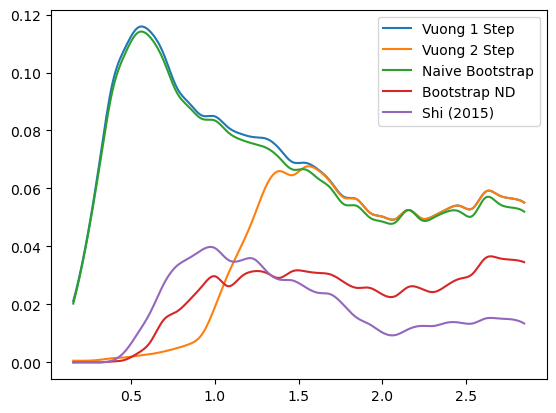

0.06324555320336758 0.00012180932094479097


In [9]:
nobs =250
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.64, 5th: 1.75, 10th: 3.01, 30th: 8.92, 50th: 15.35, 70th: 23.38, 90th: 37.21, 95th: 45.14, 99th: 59.41
bonus term 1.3160417119545993 // variance stats 42.11027989324908 //part1 56.73492655355345 //part2 43.11027989324908 42.11027989324908
-0.446255843500195 0.6448113826980512 3.4288482017702826
-3.0783392674093935 0.6448113826980512 0.796764777861084
---
Quantiles: 1th: 0.74, 5th: 1.85, 10th: 3.27, 30th: 9.75, 50th: 17.47, 70th: 26.59, 90th: 41.98, 95th: 49.96, 99th: 65.81
bonus term 3.681039085260723 // variance stats 18.625134167494892 //part1 72.24088592403436 //part2 19.625134167494892 18.625134167494892
1.719528728346547 -0.3201261749138178 5.5453620724769745
-5.642549442174899 -0.3201261749138178 -1.8167160980444714
---
Quantiles: 1th: 0.72, 5th: 1.84, 10th: 3.29, 30th: 9.74, 50th: 17.25, 70th: 26.70, 90th: 42.92, 95th: 51.62, 99th: 68.28
bonus term 12.633665634305862 // variance stats 4.976591096088558 //part1 75.50625354095241 //part2 5.976591096088558 4.97659

Quantiles: 1th: 0.81, 5th: 2.00, 10th: 3.27, 30th: 9.54, 50th: 16.42, 70th: 25.16, 90th: 39.41, 95th: 47.14, 99th: 62.60
bonus term 19.953929366661306 // variance stats 2.1902900640120477 //part1 63.658822596457775 //part2 3.1902900640120477 2.1902900640120477
18.564212132389265 -3.7999154385794394 21.3371920566528
-21.343646600933347 -3.7999154385794394 -18.570666676669813
---
Quantiles: 1th: 0.76, 5th: 2.07, 10th: 3.71, 30th: 10.17, 50th: 18.20, 70th: 27.59, 90th: 43.38, 95th: 51.31, 99th: 65.86
bonus term 2.2334330901705437 // variance stats 33.53806495501497 //part1 77.13845714099003 //part2 34.53806495501497 33.53806495501497
0.31542614165371813 0.2571633778950586 4.21292410372755
-4.151440038687369 0.2571633778950586 -0.2539420766135375
---
Quantiles: 1th: 0.86, 5th: 2.09, 10th: 3.68, 30th: 10.01, 50th: 17.23, 70th: 26.87, 90th: 43.02, 95th: 51.68, 99th: 69.94
bonus term 4.2948923878823555 // variance stats 16.659926796249373 //part1 75.84748516777107 //part2 17.659926796249373 1

Quantiles: 1th: 0.87, 5th: 2.17, 10th: 3.85, 30th: 10.78, 50th: 18.46, 70th: 28.47, 90th: 46.67, 95th: 55.95, 99th: 71.48
bonus term 2.077849408915207 // variance stats 41.96559815675931 //part1 89.27604273371065 //part2 42.96559815675931 41.96559815675931
0.22924063188121227 0.302360204271697 3.9464307920121793
-3.926458185949202 0.302360204271697 -0.20926802581823475
---
Quantiles: 1th: 0.78, 5th: 1.98, 10th: 3.24, 30th: 9.45, 50th: 16.74, 70th: 25.95, 90th: 41.23, 95th: 49.44, 99th: 65.47
bonus term 12.278784512087041 // variance stats 4.6747171703241825 //part1 69.67862930145097 //part2 5.6747171703241825 4.6747171703241825
10.582709298863062 -2.3643768715592897 13.87845459494694
-13.97485972531102 -2.3643768715592897 -10.679114429227143
---
Quantiles: 1th: 0.77, 5th: 2.10, 10th: 3.71, 30th: 10.77, 50th: 18.54, 70th: 28.15, 90th: 44.58, 95th: 53.02, 99th: 70.60
bonus term 2.61009518212765 // variance stats 30.21166853405532 //part1 81.46542566690296 //part2 31.21166853405532 30.211

Quantiles: 1th: 0.80, 5th: 1.95, 10th: 3.32, 30th: 9.74, 50th: 16.79, 70th: 26.34, 90th: 41.47, 95th: 50.15, 99th: 67.08
bonus term 2.0670911423413076 // variance stats 33.101421945249214 //part1 70.49074724426812 //part2 34.101421945249214 33.101421945249214
0.09163605564743757 0.22516309245278265 4.067677144666707
-4.042546229035178 0.22516309245278265 -0.06650514001590795
---
Quantiles: 1th: 0.80, 5th: 1.89, 10th: 3.16, 30th: 9.26, 50th: 16.18, 70th: 25.05, 90th: 39.77, 95th: 47.26, 99th: 62.00
bonus term 1.1492753610964872 // variance stats 55.39730354804213 //part1 64.81603140004431 //part2 56.39730354804214 55.39730354804213
-0.8273058255849115 0.8470763936641008 2.968886920535836
-3.1258565477778855 0.8470763936641008 0.6703361983428614
---
Quantiles: 1th: 0.78, 5th: 2.02, 10th: 3.62, 30th: 10.22, 50th: 17.98, 70th: 27.72, 90th: 44.76, 95th: 52.72, 99th: 68.78
bonus term 4.893780168657673 // variance stats 15.77864823447659 //part1 82.11101598676461 //part2 16.778648234476588 15

Quantiles: 1th: 0.77, 5th: 1.93, 10th: 3.46, 30th: 10.22, 50th: 17.36, 70th: 26.96, 90th: 42.25, 95th: 51.23, 99th: 67.39
bonus term 0.9218821649961465 // variance stats 78.36185985762842 //part1 73.16228318367125 //part2 79.36185985762842 78.36185985762842
-1.0434903462746807 1.208255297351908 2.828151671105723
-2.8872546762669735 1.208255297351908 0.9843873411134302
---
Quantiles: 1th: 0.71, 5th: 1.86, 10th: 3.33, 30th: 9.64, 50th: 16.48, 70th: 25.01, 90th: 40.08, 95th: 47.44, 99th: 63.63
bonus term 3.9423456122296563 // variance stats 15.70423612973576 //part1 65.85387201171186 //part2 16.704236129735758 15.70423612973576
2.0797011561378054 -0.8782461161665931 5.7572711035212505
-5.804990068321508 -0.8782461161665931 -2.127420120938061
---
Quantiles: 1th: 0.82, 5th: 1.73, 10th: 2.87, 30th: 8.35, 50th: 14.65, 70th: 22.19, 90th: 36.03, 95th: 42.97, 99th: 56.38
bonus term 7.369719151000581 // variance stats 6.217772557088806 //part1 53.192956641543795 //part2 7.217772557088806 6.217772

Quantiles: 1th: 0.84, 5th: 2.13, 10th: 3.52, 30th: 10.25, 50th: 17.84, 70th: 26.97, 90th: 42.19, 95th: 50.13, 99th: 67.80
bonus term 5.5925084105901295 // variance stats 12.047925575731211 //part1 72.97063352303084 //part2 13.047925575731211 12.047925575731211
3.718201493384405 -1.3976215584780975 7.398847380495696
-7.466815327795854 -1.3976215584780975 -3.786169440684563
---
Quantiles: 1th: 0.79, 5th: 1.86, 10th: 3.27, 30th: 9.42, 50th: 16.01, 70th: 24.53, 90th: 38.30, 95th: 46.09, 99th: 59.92
bonus term 1.3665204646550688 // variance stats 42.99191436642975 //part1 60.11585126107958 //part2 43.99191436642975 42.99191436642975
-0.4792306831622289 0.30510695255610704 3.205822751844831
-3.2122716124723665 0.30510695255610704 0.472781822534693
---
0.23076923076923078 [1. 0. 0.]
Quantiles: 1th: 0.71, 5th: 1.93, 10th: 3.49, 30th: 10.04, 50th: 17.67, 70th: 27.07, 90th: 43.18, 95th: 51.50, 99th: 67.54
bonus term 1.212863015251245 // variance stats 62.00692582210032 //part1 76.41877003430413 

Quantiles: 1th: 0.72, 5th: 1.91, 10th: 3.56, 30th: 10.41, 50th: 17.92, 70th: 27.18, 90th: 42.65, 95th: 51.54, 99th: 67.95
bonus term 1.4420135349661622 // variance stats 50.69227746557914 //part1 74.54096375859147 //part2 51.69227746557914 50.69227746557914
-0.4460137110785894 0.1921102647953122 3.4115463057528137
-3.330040781010914 0.1921102647953122 0.5275192358204892
---
Quantiles: 1th: 0.83, 5th: 1.95, 10th: 3.28, 30th: 9.37, 50th: 16.29, 70th: 24.76, 90th: 39.96, 95th: 47.81, 99th: 61.25
bonus term 1.1448306565944768 // variance stats 56.175122275103156 //part1 65.45583277507585 //part2 57.17512227510316 56.175122275103156
-0.8862098558623628 0.41051884626151663 2.9879923276446796
-3.1758711690513164 0.41051884626151663 0.6983310144557261
---
Quantiles: 1th: 0.68, 5th: 1.91, 10th: 3.20, 30th: 9.33, 50th: 16.07, 70th: 24.81, 90th: 39.45, 95th: 46.42, 99th: 60.31
bonus term 1.7569275177498507 // variance stats 35.31304998446217 //part1 63.79939677112736 //part2 36.31304998446217 35.

Quantiles: 1th: 0.76, 5th: 1.95, 10th: 3.24, 30th: 8.77, 50th: 15.15, 70th: 22.88, 90th: 36.38, 95th: 44.26, 99th: 58.15
bonus term 1.1451326446295396 // variance stats 46.36894486389472 //part1 54.24372510530261 //part2 47.36894486389472 46.36894486389472
-0.8420307119839443 -0.19081889607986008 3.0871486611187615
-3.1322960012430237 -0.19081889607986008 0.7968833718596825
---
Quantiles: 1th: 0.73, 5th: 1.70, 10th: 2.95, 30th: 8.43, 50th: 14.91, 70th: 22.83, 90th: 35.46, 95th: 42.44, 99th: 56.30
bonus term 1.58280950711101 // variance stats 31.563455915852355 //part1 51.541747608001366 //part2 32.56345591585236 31.563455915852355
-0.26490761233531096 -0.9416203991539112 3.484713213640463
-3.430526626557331 -0.9416203991539112 0.31909419941844275
---
Quantiles: 1th: 0.65, 5th: 1.74, 10th: 3.13, 30th: 9.79, 50th: 17.40, 70th: 26.20, 90th: 42.55, 95th: 50.59, 99th: 65.72
bonus term 2.33140335055339 // variance stats 30.830849460498438 //part1 74.21054908316663 //part2 31.830849460498438 

Quantiles: 1th: 0.81, 5th: 2.05, 10th: 3.52, 30th: 10.11, 50th: 18.06, 70th: 27.60, 90th: 43.57, 95th: 52.41, 99th: 68.57
bonus term 1.776482203750663 // variance stats 42.791588544612324 //part1 77.79497772347518 //part2 43.791588544612324 42.791588544612324
-0.0886125087612151 -0.6158488524796527 3.5611313146683
-3.6415769162625407 -0.6158488524796527 0.008166907166973979
---
Quantiles: 1th: 0.73, 5th: 2.09, 10th: 3.44, 30th: 9.94, 50th: 17.48, 70th: 26.82, 90th: 42.41, 95th: 50.91, 99th: 67.79
bonus term 1.0448565507693495 // variance stats 69.56798252911418 //part1 73.73341882012195 //part2 70.56798252911418 69.56798252911418
-0.8072447745720801 0.6166287962010913 2.9425137665949297
-2.896957876110779 0.6166287962010913 0.8528006650562308
---
Quantiles: 1th: 0.75, 5th: 1.95, 10th: 3.41, 30th: 10.29, 50th: 17.63, 70th: 27.17, 90th: 42.04, 95th: 50.05, 99th: 65.73
bonus term 2.0075548077877916 // variance stats 35.089347255937206 //part1 72.45134259357988 //part2 36.089347255937206 3

Quantiles: 1th: 0.67, 5th: 1.67, 10th: 2.93, 30th: 8.58, 50th: 15.36, 70th: 23.47, 90th: 37.16, 95th: 44.14, 99th: 57.73
bonus term 0.6192716049106558 // variance stats 90.37633509942596 //part1 56.586769687875396 //part2 91.37633509942596 90.37633509942596
-1.232411129375814 1.210918377755762 2.421559298963013
-2.470954339197126 1.210918377755762 1.183016089141701
---
Quantiles: 1th: 0.67, 5th: 1.83, 10th: 3.21, 30th: 9.15, 50th: 15.91, 70th: 24.75, 90th: 39.39, 95th: 46.31, 99th: 61.05
bonus term 0.8525008081298071 // variance stats 73.57866647229427 //part1 63.57837343687422 //part2 74.57866647229429 73.57866647229427
-1.1301581642105476 0.2574524369093534 2.7743737504557604
-2.835159780470162 0.2574524369093534 1.0693721341961462
---
Quantiles: 1th: 0.79, 5th: 2.08, 10th: 3.73, 30th: 10.91, 50th: 18.38, 70th: 28.15, 90th: 45.06, 95th: 53.97, 99th: 71.20
bonus term 1.632571913457361 // variance stats 49.97302792602455 //part1 83.2171337359054 //part2 50.97302792602455 49.97302792602

Quantiles: 1th: 0.80, 5th: 2.11, 10th: 3.53, 30th: 10.38, 50th: 17.64, 70th: 26.65, 90th: 43.07, 95th: 51.77, 99th: 66.36
bonus term 1.8597690116514545 // variance stats 39.88881515249627 //part1 76.043751343757 //part2 40.88881515249627 39.88881515249627
0.011812788705152006 -1.323654974489661 3.820934138083269
-3.707725234597757 -1.323654974489661 0.10139611478036015
---
Quantiles: 1th: 0.73, 5th: 1.81, 10th: 3.25, 30th: 9.78, 50th: 16.98, 70th: 26.07, 90th: 42.02, 95th: 50.07, 99th: 64.50
bonus term 0.9587477778020108 // variance stats 74.4950520703527 //part1 72.38071340749774 //part2 75.4950520703527 74.4950520703527
-1.0357289439340767 0.04225471400828486 2.820701377447411
-2.9532244995380985 0.04225471400828486 0.9032058218433893
---
Quantiles: 1th: 0.73, 5th: 1.93, 10th: 3.28, 30th: 9.44, 50th: 16.23, 70th: 25.11, 90th: 39.89, 95th: 46.81, 99th: 60.24
bonus term 0.8540618702300268 // variance stats 75.37386110726172 //part1 65.22800265395624 //part2 76.37386110726172 75.3738611

Quantiles: 1th: 0.82, 5th: 1.97, 10th: 3.57, 30th: 10.39, 50th: 17.60, 70th: 26.65, 90th: 43.55, 95th: 51.64, 99th: 66.57
bonus term 0.7076168196709084 // variance stats 108.83800580497523 //part1 77.72322034671133 //part2 109.83800580497523 108.83800580497523
-1.4290260178045704 1.1021229471821103 2.527967065748935
-2.8442596571463867 1.1021229471821103 1.1127334264071178
---
Quantiles: 1th: 0.79, 5th: 1.88, 10th: 3.21, 30th: 9.88, 50th: 17.41, 70th: 27.34, 90th: 43.29, 95th: 53.10, 99th: 69.63
bonus term 0.6805606090634807 // variance stats 111.84656163478344 //part1 76.79892471688783 //part2 112.84656163478344 111.84656163478344
-1.2561019793217165 1.1873833756809502 2.624076847072761
-2.6172231974486784 1.1873833756809502 1.2629556289457997
---
Quantiles: 1th: 0.82, 5th: 2.10, 10th: 3.75, 30th: 11.32, 50th: 19.21, 70th: 29.38, 90th: 46.26, 95th: 54.82, 99th: 71.11
bonus term 2.814206577958861 // variance stats 30.16717336512604 //part1 87.7108643005219 //part2 31.16717336512604 30.

Quantiles: 1th: 0.85, 5th: 2.11, 10th: 3.65, 30th: 10.82, 50th: 19.35, 70th: 29.59, 90th: 47.22, 95th: 55.92, 99th: 73.87
bonus term 0.7456597031571389 // variance stats 121.53883795801742 //part1 91.372273536996 //part2 122.53883795801742 121.53883795801742
-1.2186704377750954 1.1951825313730828 2.7258501147717284
-2.709989844089373 1.1951825313730828 1.2345307084574506
---
Quantiles: 1th: 0.80, 5th: 1.87, 10th: 3.35, 30th: 9.84, 50th: 17.09, 70th: 26.10, 90th: 41.04, 95th: 49.00, 99th: 63.12
bonus term 0.9741978776793305 // variance stats 69.87673119234802 //part1 69.04796110443384 //part2 70.87673119234802 69.87673119234802
-0.79531657067563 -0.45127197630743643 2.906476195426616
-2.743712326034291 -0.45127197630743643 0.9580804400679551
---
Quantiles: 1th: 0.63, 5th: 1.74, 10th: 3.03, 30th: 8.50, 50th: 14.91, 70th: 22.80, 90th: 35.96, 95th: 42.49, 99th: 56.65
bonus term 0.405311296870741 // variance stats 129.77712920459464 //part1 53.005447838946715 //part2 130.77712920459464 129.

Quantiles: 1th: 0.68, 5th: 1.77, 10th: 3.42, 30th: 9.35, 50th: 16.42, 70th: 26.20, 90th: 42.04, 95th: 49.74, 99th: 63.58
bonus term 1.596407745654844 // variance stats 44.375579055867945 //part1 72.4379258683613 //part2 45.37557905586795 44.375579055867945
-0.4425200266571458 -2.3933181628527587 3.3814342485464737
-3.6353355179668334 -2.3933181628527587 0.18861875723678592
---
Quantiles: 1th: 0.80, 5th: 1.94, 10th: 3.32, 30th: 9.48, 50th: 16.30, 70th: 25.23, 90th: 40.21, 95th: 48.40, 99th: 63.08
bonus term 0.7685712643317582 // variance stats 85.20628248332967 //part1 66.25567152155337 //part2 86.20628248332967 85.20628248332967
-1.2071915119432577 -0.06786494462730547 2.7536289999093206
-2.744334040606774 -0.06786494462730547 1.2164864712458041
---
Quantiles: 1th: 0.81, 5th: 2.14, 10th: 3.66, 30th: 10.80, 50th: 19.14, 70th: 29.51, 90th: 46.08, 95th: 55.53, 99th: 74.90
bonus term 1.1921358076329334 // variance stats 72.01666183484784 //part1 87.0457771271471 //part2 73.01666183484784 7

0.7692307692307693 [0.98857143 0.         0.01142857]
Quantiles: 1th: 0.67, 5th: 1.60, 10th: 2.81, 30th: 7.93, 50th: 14.13, 70th: 21.66, 90th: 34.04, 95th: 40.88, 99th: 54.75
bonus term 0.4996653153918798 // variance stats 94.0637928627034 //part1 47.500080043091025 //part2 95.0637928627034 94.0637928627034
-1.4784188068678634 0.17713370589753089 2.3673945399560417
-2.477749437651623 0.17713370589753089 1.368063909172282
---
Quantiles: 1th: 0.69, 5th: 1.81, 10th: 3.07, 30th: 8.97, 50th: 15.73, 70th: 24.24, 90th: 38.54, 95th: 46.25, 99th: 58.46
bonus term 0.5655826832776508 // variance stats 106.62413341708103 //part1 60.870346163464575 //part2 107.62413341708104 106.62413341708103
-1.4287974124733773 0.4050639972280099 2.4263788467556777
-2.5599627790286785 0.4050639972280099 1.2952134802003763
---
Quantiles: 1th: 0.67, 5th: 1.88, 10th: 3.39, 30th: 9.88, 50th: 16.92, 70th: 26.31, 90th: 42.20, 95th: 50.14, 99th: 67.79
bonus term 0.604997919039958 // variance stats 119.62197137286644 //p

Quantiles: 1th: 0.73, 5th: 1.79, 10th: 3.20, 30th: 9.76, 50th: 17.21, 70th: 26.13, 90th: 42.56, 95th: 50.32, 99th: 64.64
bonus term 0.6590715026970378 // variance stats 111.65792655350738 //part1 74.24962894435264 //part2 112.6579265535074 111.65792655350738
-1.2483309701884544 0.3356363044898529 2.5234361367312035
-2.56647397558253 0.3356363044898529 1.2052931313371278
---
Quantiles: 1th: 0.75, 5th: 1.90, 10th: 3.46, 30th: 10.68, 50th: 18.87, 70th: 29.17, 90th: 46.69, 95th: 55.92, 99th: 75.00
bonus term 1.313223071853067 // variance stats 67.03340367848165 //part1 89.34303536727542 //part2 68.03340367848165 67.03340367848165
-0.5205634668730693 -1.8124307839011082 3.2625490144073894
-3.1470096105792034 -1.8124307839011082 0.6361028707012552
---
Quantiles: 1th: 0.64, 5th: 1.72, 10th: 2.89, 30th: 8.23, 50th: 14.32, 70th: 21.84, 90th: 34.21, 95th: 40.97, 99th: 54.94
bonus term 0.49614396028287727 // variance stats 95.68196420722526 //part1 47.96817260970013 //part2 96.68196420722528 95.6

Quantiles: 1th: 0.72, 5th: 1.96, 10th: 3.28, 30th: 9.11, 50th: 15.31, 70th: 23.43, 90th: 37.01, 95th: 44.48, 99th: 57.89
bonus term 0.6254801825834306 // variance stats 88.75958316438164 //part1 56.14284046627004 //part2 89.75958316438162 88.75958316438164
-1.3888521898502326 -0.6234060171834072 2.693853872822326
-2.639812555017094 -0.6234060171834072 1.4428935076554648
---
Quantiles: 1th: 0.74, 5th: 1.70, 10th: 2.99, 30th: 9.37, 50th: 16.46, 70th: 25.24, 90th: 41.12, 95th: 49.69, 99th: 65.14
bonus term 0.4516724396083758 // variance stats 152.4092608469225 //part1 69.29073510524717 //part2 153.4092608469225 152.4092608469225
-1.426081353799478 1.488545770951295 2.4293474648743105
-2.3294262330162296 1.488545770951295 1.5260025856575592
---
Quantiles: 1th: 0.64, 5th: 1.78, 10th: 3.11, 30th: 9.72, 50th: 17.16, 70th: 26.18, 90th: 41.93, 95th: 49.41, 99th: 66.28
bonus term 0.7693801414429301 // variance stats 92.64586249611136 //part1 72.04926693280333 //part2 93.64586249611136 92.6458624

Quantiles: 1th: 0.78, 5th: 1.85, 10th: 3.28, 30th: 9.57, 50th: 16.36, 70th: 25.57, 90th: 40.45, 95th: 48.87, 99th: 63.68
bonus term 0.6324068451463616 // variance stats 105.03581272747843 //part1 67.05777379951503 //part2 106.03581272747843 105.03581272747843
-1.4360287707532127 -0.38665345793806344 2.571430587104273
-2.700842461045936 -0.38665345793806344 1.3066168968115497
---
Quantiles: 1th: 0.63, 5th: 1.72, 10th: 3.07, 30th: 9.63, 50th: 16.69, 70th: 25.90, 90th: 41.42, 95th: 49.11, 99th: 63.76
bonus term 0.5684352146612667 // variance stats 122.69933587334458 //part1 70.31505854062074 //part2 123.69933587334458 122.69933587334458
-1.3845679028777174 0.03420710570755756 2.5592306127246336
-2.5214383322002507 0.03420710570755756 1.4223601834021002
---
Quantiles: 1th: 0.83, 5th: 1.97, 10th: 3.63, 30th: 10.99, 50th: 19.44, 70th: 29.31, 90th: 46.11, 95th: 54.05, 99th: 71.89
bonus term 0.5718997795131332 // variance stats 151.35039219220258 //part1 87.12915570346001 //part2 152.350392192

Quantiles: 1th: 0.67, 5th: 1.68, 10th: 3.02, 30th: 8.70, 50th: 15.58, 70th: 23.84, 90th: 37.38, 95th: 44.43, 99th: 61.24
bonus term 0.3929378733464706 // variance stats 144.78187454666664 //part1 57.28321975682916 //part2 145.78187454666664 144.78187454666664
-1.5011866413027535 1.1499859688117409 2.3985601905646994
-2.287062387995695 1.1499859688117409 1.6126844438717585
---
Quantiles: 1th: 0.60, 5th: 1.81, 10th: 3.32, 30th: 10.11, 50th: 17.38, 70th: 26.79, 90th: 41.79, 95th: 49.72, 99th: 65.16
bonus term 0.4393614498416105 // variance stats 161.9344531929027 //part1 71.58711758398375 //part2 162.9344531929027 161.9344531929027
-1.5279459299387241 1.0425004644260594 2.3847040890048006
-2.406668829621945 1.0425004644260594 1.5059811893215795
---
Quantiles: 1th: 0.77, 5th: 1.90, 10th: 3.40, 30th: 9.74, 50th: 17.11, 70th: 26.65, 90th: 42.84, 95th: 50.68, 99th: 64.48
bonus term 0.6518104403007102 // variance stats 114.38917677588259 //part1 75.21187012022452 //part2 115.38917677588259 114

Quantiles: 1th: 0.76, 5th: 1.87, 10th: 3.30, 30th: 9.76, 50th: 16.79, 70th: 25.91, 90th: 41.87, 95th: 49.61, 99th: 65.04
bonus term 0.5224982520484865 // variance stats 136.51814362465043 //part1 71.85298966883258 //part2 137.51814362465043 136.51814362465043
-1.4950860435123436 0.10123209107522745 2.2732720503225887
-2.540082547609317 0.10123209107522745 1.2282755462256154
---
Quantiles: 1th: 0.75, 5th: 1.83, 10th: 3.25, 30th: 9.44, 50th: 16.58, 70th: 25.67, 90th: 40.35, 95th: 48.06, 99th: 61.72
bonus term 0.5257584414006785 // variance stats 125.94119838162479 //part1 66.74040661065739 //part2 126.9411983816248 125.94119838162479
-1.3292234294662164 0.08584575443783143 2.3681941146847802
-2.380740312267573 0.08584575443783143 1.3166772318834232
---
1.076923076923077 [0.97857143 0.00142857 0.02      ]
Quantiles: 1th: 0.74, 5th: 1.74, 10th: 2.89, 30th: 8.52, 50th: 14.99, 70th: 22.99, 90th: 37.08, 95th: 43.38, 99th: 56.49
bonus term 0.4094509548366367 // variance stats 136.5995473415576

Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.25, 30th: 9.25, 50th: 15.79, 70th: 24.42, 90th: 37.58, 95th: 45.34, 99th: 59.71
bonus term 0.4031557498215304 // variance stats 142.57931202990255 //part1 57.88482520027484 //part2 143.57931202990255 142.57931202990255
-1.5814716059570229 0.5560959613357654 2.35768803650961
-2.387783105600084 0.5560959613357654 1.5513765368665495
---
Quantiles: 1th: 0.74, 5th: 2.14, 10th: 3.89, 30th: 11.08, 50th: 18.94, 70th: 28.73, 90th: 45.00, 95th: 53.72, 99th: 70.42
bonus term 0.6566449730612649 // variance stats 125.40800065212595 //part1 83.0051781829436 //part2 126.40800065212595 125.40800065212595
-1.3444961508456152 -0.8401215885894175 2.5306906723206675
-2.657786096968145 -0.8401215885894175 1.2174007261981374
---
Quantiles: 1th: 0.82, 5th: 2.04, 10th: 3.49, 30th: 10.88, 50th: 19.22, 70th: 29.81, 90th: 46.78, 95th: 55.76, 99th: 71.89
bonus term 0.6422385495814872 // variance stats 138.6645906856361 //part1 89.69798414983501 //part2 139.6645906856361 13

Quantiles: 1th: 0.63, 5th: 1.57, 10th: 2.72, 30th: 8.07, 50th: 14.27, 70th: 21.84, 90th: 35.14, 95th: 41.19, 99th: 55.59
bonus term 0.37538667732009706 // variance stats 133.80056340239886 //part1 50.602335596503586 //part2 134.80056340239886 133.80056340239886
-1.548835493425044 0.0598807754823683 2.391520405390166
-2.299608848065238 0.0598807754823683 1.640747050749972
---
Quantiles: 1th: 0.80, 5th: 1.84, 10th: 3.19, 30th: 9.01, 50th: 15.89, 70th: 25.18, 90th: 40.69, 95th: 48.45, 99th: 63.65
bonus term 0.5042076343928109 // variance stats 133.57468468662907 //part1 67.85358341500367 //part2 134.57468468662907 133.57468468662907
-1.5375508349349827 -0.19693342420746077 2.3982205352534964
-2.545966103720604 -0.19693342420746077 1.3898052664678744
---
Quantiles: 1th: 0.72, 5th: 1.90, 10th: 3.41, 30th: 10.03, 50th: 17.45, 70th: 26.67, 90th: 43.47, 95th: 50.99, 99th: 66.22
bonus term 0.47391757766523973 // variance stats 162.40245897058708 //part1 77.43929753988434 //part2 163.40245897058

Quantiles: 1th: 0.70, 5th: 2.00, 10th: 3.66, 30th: 10.58, 50th: 18.50, 70th: 28.85, 90th: 45.83, 95th: 53.80, 99th: 69.59
bonus term 0.4377732354166551 // variance stats 195.62288869430947 //part1 86.07623814067671 //part2 196.62288869430947 195.62288869430947
-1.6266203158789971 1.2114063898542438 2.400110556443177
-2.502166786712307 1.2114063898542438 1.524564085609867
---
Quantiles: 1th: 0.70, 5th: 1.78, 10th: 3.21, 30th: 9.20, 50th: 15.87, 70th: 24.48, 90th: 38.45, 95th: 45.22, 99th: 61.00
bonus term 0.3844887218859271 // variance stats 156.63247465644065 //part1 60.60790870837066 //part2 157.63247465644065 156.63247465644065
-1.7047328607651597 0.26809047479876563 2.429375302019216
-2.473710304537014 0.26809047479876563 1.660397858247362
---
Quantiles: 1th: 0.73, 5th: 1.83, 10th: 3.22, 30th: 9.50, 50th: 16.58, 70th: 24.99, 90th: 38.88, 95th: 46.77, 99th: 61.40
bonus term 0.39567642925364427 // variance stats 155.55655050791302 //part1 61.94573688123882 //part2 156.55655050791302 1

Quantiles: 1th: 0.64, 5th: 1.75, 10th: 3.10, 30th: 9.06, 50th: 16.01, 70th: 24.76, 90th: 39.58, 95th: 47.26, 99th: 63.23
bonus term 0.636162952909682 // variance stats 99.9210496181719 //part1 64.20223293584077 //part2 100.9210496181719 99.9210496181719
-1.3782601807981163 -3.7085326559505907 2.7056523229413902
-2.6505860866174804 -3.7085326559505907 1.4333264171220264
---
Quantiles: 1th: 0.77, 5th: 1.79, 10th: 3.15, 30th: 9.79, 50th: 17.01, 70th: 25.90, 90th: 41.60, 95th: 49.06, 99th: 64.13
bonus term 0.43661256956488675 // variance stats 161.41762661048136 //part1 70.9135772970326 //part2 162.41762661048136 161.41762661048136
-1.49264711165507 0.304706770847483 2.4904696895303187
-2.365872250784843 0.304706770847483 1.617244550400545
---
Quantiles: 1th: 0.77, 5th: 2.17, 10th: 3.77, 30th: 10.37, 50th: 17.71, 70th: 27.40, 90th: 43.49, 95th: 51.84, 99th: 68.57
bonus term 0.35194004456766736 // variance stats 219.2630732294796 //part1 77.51939580899443 //part2 220.26307322947963 219.2630

Quantiles: 1th: 0.75, 5th: 1.77, 10th: 3.01, 30th: 9.26, 50th: 16.49, 70th: 24.90, 90th: 38.81, 95th: 46.03, 99th: 60.22
bonus term 0.5182660856872094 // variance stats 118.14433619125597 //part1 61.748468749643145 //part2 119.14433619125597 118.14433619125597
-1.3854775201831087 -1.696662617499918 2.380218106705317
-2.4220096915575273 -1.696662617499918 1.3436859353308983
---
Quantiles: 1th: 0.65, 5th: 1.86, 10th: 3.26, 30th: 9.37, 50th: 16.51, 70th: 25.08, 90th: 39.75, 95th: 47.43, 99th: 62.29
bonus term 0.4062518804613853 // variance stats 158.40841585550575 //part1 64.75996870266971 //part2 159.40841585550575 158.40841585550575
-1.6261588262721975 0.17078198437421277 2.3715378038001926
-2.438662587194968 0.17078198437421277 1.559034042877422
---
Quantiles: 1th: 0.66, 5th: 1.79, 10th: 2.97, 30th: 8.85, 50th: 15.52, 70th: 23.27, 90th: 36.69, 95th: 44.22, 99th: 58.03
bonus term 0.34465106702273746 // variance stats 159.04173395796064 //part1 55.1585543767802 //part2 160.04173395796064

Quantiles: 1th: 0.70, 5th: 1.88, 10th: 3.29, 30th: 9.30, 50th: 16.14, 70th: 24.43, 90th: 37.84, 95th: 44.89, 99th: 60.22
bonus term 0.34378222701143557 // variance stats 169.72213660169453 //part1 58.69123632108106 //part2 170.72213660169453 169.72213660169453
-1.598627246578154 0.301940225017332 2.35410695436721
-2.2861917006010253 0.301940225017332 1.666542500344339
---
Quantiles: 1th: 0.66, 5th: 1.72, 10th: 2.95, 30th: 8.64, 50th: 14.72, 70th: 22.74, 90th: 36.23, 95th: 43.17, 99th: 56.34
bonus term 0.3301247379481987 // variance stats 161.98651700454857 //part1 53.805881215216225 //part2 162.98651700454857 161.98651700454857
-1.5006383969258714 0.0843577558243189 2.195583771674225
-2.160887872822269 0.0843577558243189 1.5353342957778275
---
Quantiles: 1th: 0.67, 5th: 1.69, 10th: 3.05, 30th: 9.24, 50th: 15.92, 70th: 24.81, 90th: 39.41, 95th: 46.28, 99th: 60.92
bonus term 0.43798216634481363 // variance stats 144.35487371801216 //part1 63.66284247979177 //part2 145.35487371801216 144.

Quantiles: 1th: 0.73, 5th: 1.95, 10th: 3.33, 30th: 9.46, 50th: 16.33, 70th: 25.20, 90th: 39.26, 95th: 46.30, 99th: 59.86
bonus term 0.39454613893476503 // variance stats 159.12871617552824 //part1 63.17816669963551 //part2 160.12871617552824 159.12871617552824
-1.4744207878629012 -0.7102525857700789 2.1664857060022653
-2.2635130657324316 -0.7102525857700789 1.3773934281327354
---
Quantiles: 1th: 0.66, 5th: 1.84, 10th: 3.22, 30th: 9.80, 50th: 17.50, 70th: 26.95, 90th: 42.74, 95th: 50.67, 99th: 68.46
bonus term 0.3395359401645163 // variance stats 219.53117668564542 //part1 74.87826041154767 //part2 220.53117668564542 219.53117668564542
-1.6526659073064498 1.3784489388325054 2.455673217236051
-2.331737787635482 1.3784489388325054 1.7766013369070186
---
Quantiles: 1th: 0.68, 5th: 1.86, 10th: 3.16, 30th: 9.36, 50th: 16.51, 70th: 25.50, 90th: 40.53, 95th: 48.34, 99th: 62.49
bonus term 0.44126428550700125 // variance stats 151.5468900532878 //part1 67.31349444567911 //part2 152.5468900532878

Quantiles: 1th: 0.95, 5th: 2.11, 10th: 3.59, 30th: 10.37, 50th: 18.21, 70th: 28.11, 90th: 44.22, 95th: 53.38, 99th: 67.61
bonus term 0.3793026454831221 // variance stats 210.26725127746818 //part1 80.13422731349118 //part2 211.26725127746818 210.26725127746818
-1.4331867920571628 0.7801857516520015 2.2827236451819304
-2.1917920830234072 0.7801857516520015 1.524118354215686
---
Quantiles: 1th: 0.68, 5th: 1.99, 10th: 3.32, 30th: 10.21, 50th: 17.94, 70th: 27.50, 90th: 44.16, 95th: 52.38, 99th: 68.95
bonus term 0.4651548964831362 // variance stats 170.80708316885563 //part1 79.91690598647861 //part2 171.80708316885563 170.80708316885563
-1.4259371685898667 -0.6857608129906702 2.3756882454431665
-2.356246961556139 -0.6857608129906702 1.445378452476894
---
Quantiles: 1th: 0.78, 5th: 2.10, 10th: 3.61, 30th: 10.10, 50th: 17.14, 70th: 26.20, 90th: 41.48, 95th: 49.58, 99th: 64.53
bonus term 0.4953731307513728 // variance stats 141.3265362044049 //part1 70.50474182857467 //part2 142.3265362044049

1.6153846153846154 [0.97857143 0.00285714 0.01857143]
Quantiles: 1th: 0.66, 5th: 1.64, 10th: 2.86, 30th: 8.87, 50th: 15.68, 70th: 23.61, 90th: 37.20, 95th: 44.53, 99th: 57.35
bonus term 0.3309862554010676 // variance stats 170.3525059116649 //part1 56.71532428529126 //part2 171.35250591166493 170.3525059116649
-1.6497725126395308 -0.7715992911129168 2.2699348595530915
-2.311745023441666 -0.7715992911129168 1.607962348750956
---
Quantiles: 1th: 0.81, 5th: 1.88, 10th: 3.19, 30th: 9.59, 50th: 17.06, 70th: 26.05, 90th: 41.68, 95th: 49.78, 99th: 65.97
bonus term 0.37752701323314103 // variance stats 187.61725297054738 //part1 71.20810815821055 //part2 188.61725297054738 187.61725297054738
-1.5206722446304186 -0.0422383977650422 2.210701151766784
-2.275726271096701 -0.0422383977650422 1.4556471253005017
---
Quantiles: 1th: 0.79, 5th: 2.12, 10th: 3.51, 30th: 9.97, 50th: 16.99, 70th: 26.18, 90th: 41.01, 95th: 49.09, 99th: 64.09
bonus term 0.3744935134558333 // variance stats 183.10429557203426

Quantiles: 1th: 0.65, 5th: 1.74, 10th: 3.06, 30th: 9.26, 50th: 16.03, 70th: 24.85, 90th: 39.47, 95th: 45.93, 99th: 61.55
bonus term 0.3787100787089845 // variance stats 167.56880513309582 //part1 63.83870545983418 //part2 168.56880513309582 167.56880513309582
-1.5102770236894942 -0.6258225395110987 2.0896542409723398
-2.2676971811074633 -0.6258225395110987 1.3322340835543707
---
Quantiles: 1th: 0.63, 5th: 1.71, 10th: 2.78, 30th: 8.71, 50th: 15.28, 70th: 23.27, 90th: 37.67, 95th: 44.53, 99th: 58.87
bonus term 0.30292316474676045 // variance stats 191.02582596335105 //part1 58.16907091392894 //part2 192.02582596335108 191.02582596335105
-1.7847181467247148 0.12855469902429154 2.081120079020832
-2.390564476218236 0.12855469902429154 1.475273749527311
---
Quantiles: 1th: 0.66, 5th: 1.74, 10th: 2.87, 30th: 8.30, 50th: 14.50, 70th: 22.20, 90th: 34.88, 95th: 42.63, 99th: 56.32
bonus term 0.264285232130291 // variance stats 187.6709265441637 //part1 49.86293961796139 //part2 188.67092654416373

Quantiles: 1th: 0.74, 5th: 1.96, 10th: 3.28, 30th: 9.61, 50th: 16.76, 70th: 26.13, 90th: 41.04, 95th: 49.21, 99th: 66.08
bonus term 0.3648663973586277 // variance stats 188.15550887345563 //part1 69.01648906319568 //part2 189.15550887345566 188.15550887345563
-1.693242490226632 -0.6102645376550216 2.353220700661929
-2.4229752849438877 -0.6102645376550216 1.6234879059446736
---
Quantiles: 1th: 0.80, 5th: 1.93, 10th: 3.46, 30th: 9.99, 50th: 17.22, 70th: 26.28, 90th: 40.07, 95th: 48.07, 99th: 61.57
bonus term 0.28331712647653623 // variance stats 231.3215902082359 //part1 65.82068535625679 //part2 232.3215902082359 231.3215902082359
-1.7406252498342674 1.3180404013405262 2.345686955479432
-2.30725950278734 1.3180404013405262 1.77905270252636
---
Quantiles: 1th: 0.65, 5th: 1.96, 10th: 3.53, 30th: 9.90, 50th: 16.66, 70th: 25.75, 90th: 40.37, 95th: 47.50, 99th: 66.14
bonus term 0.31383163687699983 // variance stats 211.86281142685215 //part1 66.80308454032914 //part2 212.86281142685215 211.8

Quantiles: 1th: 0.73, 5th: 1.97, 10th: 3.49, 30th: 10.05, 50th: 17.29, 70th: 26.27, 90th: 41.40, 95th: 49.86, 99th: 66.33
bonus term 0.3723875257134314 // variance stats 187.64787099311664 //part1 70.25011391023331 //part2 188.64787099311664 187.64787099311664
-1.5222875144149766 -1.252427185536758 2.1725682931204062
-2.2670625658418393 -1.252427185536758 1.4277932416935435
---
Quantiles: 1th: 0.72, 5th: 1.77, 10th: 2.93, 30th: 9.25, 50th: 15.76, 70th: 24.18, 90th: 38.78, 95th: 46.53, 99th: 59.74
bonus term 0.37110111018941316 // variance stats 165.07683187702727 //part1 61.631296686305326 //part2 166.07683187702727 165.07683187702727
-1.5564369191450955 -1.7536493832479645 2.1362478754678937
-2.2986391395239223 -1.7536493832479645 1.3940456550890672
---
Quantiles: 1th: 0.71, 5th: 1.92, 10th: 3.34, 30th: 9.87, 50th: 17.26, 70th: 26.21, 90th: 41.17, 95th: 48.33, 99th: 65.20
bonus term 0.3202029933094279 // variance stats 215.9915422358479 //part1 69.48134134674766 //part2 216.9915422358

Quantiles: 1th: 0.78, 5th: 1.92, 10th: 3.42, 30th: 9.79, 50th: 17.27, 70th: 26.29, 90th: 42.00, 95th: 50.84, 99th: 66.72
bonus term 0.31516857503190393 // variance stats 228.35400619250566 //part1 72.28517530955048 //part2 229.35400619250566 228.35400619250566
-1.6701682894779615 0.6974231415840966 2.2349045532891374
-2.300505439541769 0.6974231415840966 1.6045674032253296
---
Quantiles: 1th: 0.75, 5th: 1.92, 10th: 3.24, 30th: 9.98, 50th: 17.59, 70th: 26.68, 90th: 42.39, 95th: 50.79, 99th: 66.92
bonus term 0.3604818456733531 // variance stats 203.2986498824399 //part1 73.64595437819608 //part2 204.2986498824399 203.2986498824399
-1.4932735401628807 -0.6186579640681987 2.3332375372708407
-2.2142372315095873 -0.6186579640681987 1.6122738459241346
---
Quantiles: 1th: 0.80, 5th: 2.02, 10th: 3.60, 30th: 9.90, 50th: 16.93, 70th: 25.55, 90th: 39.94, 95th: 47.47, 99th: 61.58
bonus term 0.32404211248021286 // variance stats 200.81377435645845 //part1 65.3961617700718 //part2 201.81377435645845 

Quantiles: 1th: 0.76, 5th: 2.03, 10th: 3.51, 30th: 10.17, 50th: 17.63, 70th: 26.66, 90th: 43.05, 95th: 50.51, 99th: 66.34
bonus term 0.31573667856958804 // variance stats 239.5817521867855 //part1 75.96048335990736 //part2 240.5817521867855 239.5817521867855
-1.6629972677918712 0.5865840814679913 2.2239899079963625
-2.2944706249310474 0.5865840814679913 1.5925165508571866
---
Quantiles: 1th: 0.66, 5th: 1.87, 10th: 3.11, 30th: 9.20, 50th: 16.12, 70th: 24.60, 90th: 38.97, 95th: 46.34, 99th: 59.30
bonus term 0.29735929096205216 // variance stats 208.2908537215054 //part1 62.23457986746942 //part2 209.2908537215054 208.2908537215054
-1.6195030881950268 -0.904915347615341 2.2136865040536002
-2.214221670119131 -0.904915347615341 1.618967922129496
---
1.9230769230769231 [0.98142857 0.00571429 0.01285714]
Quantiles: 1th: 0.92, 5th: 1.95, 10th: 3.49, 30th: 10.38, 50th: 18.44, 70th: 27.58, 90th: 43.87, 95th: 51.71, 99th: 66.14
bonus term 0.4484176029394465 // variance stats 174.91443236853382 //

Quantiles: 1th: 0.79, 5th: 1.90, 10th: 3.28, 30th: 9.57, 50th: 16.71, 70th: 25.50, 90th: 41.42, 95th: 48.97, 99th: 67.68
bonus term 0.30969094217513377 // variance stats 226.01839802993945 //part1 70.30554157698147 //part2 227.01839802993945 226.01839802993945
-1.6218610045916082 -0.05557798587300415 2.19613008998235
-2.241242888941876 -0.05557798587300415 1.5767482056320825
---
Quantiles: 1th: 0.92, 5th: 2.08, 10th: 3.47, 30th: 10.19, 50th: 17.28, 70th: 26.73, 90th: 42.20, 95th: 50.02, 99th: 65.31
bonus term 0.29829478902224343 // variance stats 243.70563656283622 //part1 72.99441623106499 //part2 244.70563656283622 243.70563656283622
-1.7497281828533522 0.35308554546967164 2.217639374279345
-2.346317760897839 0.35308554546967164 1.6210497962348582
---
Quantiles: 1th: 0.87, 5th: 2.12, 10th: 3.55, 30th: 10.51, 50th: 18.00, 70th: 27.59, 90th: 43.82, 95th: 52.50, 99th: 68.67
bonus term 0.32701109713258214 // variance stats 239.6527429952343 //part1 78.69611751483687 //part2 240.652742995

Quantiles: 1th: 0.81, 5th: 1.98, 10th: 3.49, 30th: 10.72, 50th: 18.30, 70th: 28.21, 90th: 45.98, 95th: 54.03, 99th: 70.85
bonus term 0.3704752906091004 // variance stats 232.86215585912308 //part1 86.64015015437934 //part2 233.86215585912308 232.86215585912308
-1.6580727337028083 -0.6463216133970395 2.417553438327757
-2.399023314921009 -0.6463216133970395 1.6766028571095561
---
Quantiles: 1th: 0.72, 5th: 1.89, 10th: 3.42, 30th: 10.30, 50th: 17.66, 70th: 26.76, 90th: 43.36, 95th: 50.80, 99th: 66.96
bonus term 0.2962157856096987 // variance stats 259.14660806280676 //part1 77.05953188102269 //part2 260.14660806280676 259.14660806280676
-1.5385900111146789 0.8110648401692361 2.2537842151004917
-2.131021582334076 0.8110648401692361 1.6613526438810944
---
Quantiles: 1th: 0.58, 5th: 1.77, 10th: 3.34, 30th: 9.60, 50th: 16.17, 70th: 24.81, 90th: 39.29, 95th: 46.01, 99th: 58.30
bonus term 0.32360623498113483 // variance stats 194.51131165708892 //part1 63.26867946157379 //part2 195.511311657088

Quantiles: 1th: 0.62, 5th: 1.74, 10th: 3.13, 30th: 8.70, 50th: 14.87, 70th: 23.22, 90th: 37.14, 95th: 44.80, 99th: 57.53
bonus term 0.27851647210587854 // variance stats 201.96873793910197 //part1 56.530136838581264 //part2 202.96873793910197 201.96873793910197
-1.7145175202450813 -1.8534177753906986 2.1331196052479364
-2.2715504644568383 -1.8534177753906986 1.5760866610361794
---
Quantiles: 1th: 0.66, 5th: 1.93, 10th: 3.59, 30th: 10.44, 50th: 18.34, 70th: 27.96, 90th: 44.34, 95th: 52.67, 99th: 68.80
bonus term 0.3256164687448707 // variance stats 246.4664317037117 //part1 80.57914562425631 //part2 247.4664317037117 246.4664317037117
-1.642768736234613 -0.6134672881525685 2.2188262998617443
-2.2940016737243543 -0.6134672881525685 1.5675933623720024
---
Quantiles: 1th: 0.70, 5th: 1.90, 10th: 3.47, 30th: 9.66, 50th: 16.96, 70th: 26.31, 90th: 41.73, 95th: 49.78, 99th: 68.14
bonus term 0.3134112948445905 // variance stats 226.7052231086793 //part1 71.36538881736755 //part2 227.705223108679

Quantiles: 1th: 0.60, 5th: 1.74, 10th: 3.10, 30th: 9.49, 50th: 16.47, 70th: 25.16, 90th: 39.73, 95th: 47.99, 99th: 61.62
bonus term 0.23423399175796314 // variance stats 275.1644007994258 //part1 64.68708998069553 //part2 276.1644007994258 275.1644007994258
-1.6554368103968893 1.1328505901050987 2.1499542662781534
-2.1239047939128155 1.1328505901050987 1.681486282762227
---
Quantiles: 1th: 0.72, 5th: 1.95, 10th: 3.49, 30th: 10.06, 50th: 17.96, 70th: 27.97, 90th: 44.50, 95th: 53.38, 99th: 69.28
bonus term 0.31853618979497955 // variance stats 253.7910105538598 //part1 81.1601576958389 //part2 254.7910105538598 253.7910105538598
-1.6720223255126319 -0.3266305415159096 2.28805274140643
-2.309094705102591 -0.3266305415159096 1.650980361816471
---
Quantiles: 1th: 0.76, 5th: 1.94, 10th: 3.25, 30th: 9.33, 50th: 16.04, 70th: 24.98, 90th: 39.34, 95th: 47.22, 99th: 61.39
bonus term 0.24308105689373607 // variance stats 259.9633773397102 //part1 63.43525357429561 //part2 260.9633773397102 259.963

Quantiles: 1th: 0.75, 5th: 1.94, 10th: 3.30, 30th: 9.36, 50th: 16.16, 70th: 25.20, 90th: 40.48, 95th: 48.10, 99th: 64.85
bonus term 0.2765272861758063 // variance stats 241.82556340590577 //part1 67.14789406274629 //part2 242.82556340590577 241.82556340590577
-1.6647085417814511 -0.47606219938075856 2.1605474472021955
-2.2177631141330636 -0.47606219938075856 1.607492874850583
---
Quantiles: 1th: 0.78, 5th: 1.88, 10th: 3.30, 30th: 8.89, 50th: 15.73, 70th: 24.34, 90th: 38.44, 95th: 45.57, 99th: 57.88
bonus term 0.2501589759939379 // variance stats 241.04641701978045 //part1 60.550083824669926 //part2 242.04641701978048 241.04641701978045
-1.695840511760325 -0.36691502607343 2.2403262917540285
-2.196158463748201 -0.36691502607343 1.7400083397661525
---
Quantiles: 1th: 0.76, 5th: 2.06, 10th: 3.60, 30th: 10.89, 50th: 19.46, 70th: 29.65, 90th: 47.91, 95th: 57.71, 99th: 73.98
bonus term 0.3212396399915691 // variance stats 291.9068612650423 //part1 94.09329466384267 //part2 292.9068612650423 

Quantiles: 1th: 0.80, 5th: 2.02, 10th: 3.41, 30th: 10.10, 50th: 17.66, 70th: 27.49, 90th: 43.62, 95th: 52.93, 99th: 67.67
bonus term 0.2955125520145475 // variance stats 262.92345177432696 //part1 77.9926927703197 //part2 263.92345177432696 262.92345177432696
-1.6289684821705805 -0.08212645668119165 2.2909545458288623
-2.219993586199675 -0.08212645668119165 1.6999294417997675
---
Quantiles: 1th: 0.78, 5th: 2.02, 10th: 3.58, 30th: 10.49, 50th: 18.04, 70th: 27.93, 90th: 43.79, 95th: 51.46, 99th: 66.13
bonus term 0.2687036583498534 // variance stats 291.49756498113527 //part1 78.595165768855 //part2 292.49756498113527 291.49756498113527
-1.5301306415169045 0.6996339901931876 2.3090038061718285
-2.0675379582166116 0.6996339901931876 1.7715964894721221
---
Quantiles: 1th: 0.83, 5th: 2.13, 10th: 3.79, 30th: 10.84, 50th: 18.71, 70th: 28.40, 90th: 45.74, 95th: 54.36, 99th: 72.61
bonus term 0.35827316434550893 // variance stats 238.37473601689882 //part1 85.76154413714521 //part2 239.3747360168

Quantiles: 1th: 0.71, 5th: 1.93, 10th: 3.34, 30th: 9.75, 50th: 17.19, 70th: 26.00, 90th: 41.51, 95th: 49.41, 99th: 67.05
bonus term 0.23841443879346177 // variance stats 295.1627343583427 //part1 70.60947210358135 //part2 296.1627343583427 295.1627343583427
-1.8295060226658801 0.7893875505868251 2.2225374043694184
-2.3063349002528035 0.7893875505868251 1.7457085267824948
---
Quantiles: 1th: 0.90, 5th: 2.01, 10th: 3.34, 30th: 9.79, 50th: 16.95, 70th: 25.60, 90th: 40.89, 95th: 49.72, 99th: 66.92
bonus term 0.2890010033695985 // variance stats 236.10870670612826 //part1 68.52465414573891 //part2 237.10870670612826 236.10870670612826
-1.558586922875849 -1.1174726652234173 2.3608677875309563
-2.136588929615046 -1.1174726652234173 1.7828657807917594
---
Quantiles: 1th: 0.76, 5th: 1.96, 10th: 3.39, 30th: 10.34, 50th: 18.25, 70th: 27.77, 90th: 43.28, 95th: 52.36, 99th: 68.02
bonus term 0.2750040805766856 // variance stats 278.1968801230149 //part1 76.78028131810882 //part2 279.1968801230149 27

Quantiles: 1th: 0.77, 5th: 1.80, 10th: 2.99, 30th: 9.08, 50th: 16.23, 70th: 25.18, 90th: 39.75, 95th: 46.90, 99th: 61.81
bonus term 0.21110491350541233 // variance stats 305.76776819582005 //part1 64.76018317122696 //part2 306.76776819582005 305.76776819582005
-1.7757105047342148 1.3103646930545045 2.099725424855766
-2.1979203317450398 1.3103646930545045 1.6775155978449414
---
Quantiles: 1th: 0.79, 5th: 1.87, 10th: 3.14, 30th: 9.34, 50th: 16.27, 70th: 24.55, 90th: 39.05, 95th: 48.20, 99th: 61.94
bonus term 0.21583619547732735 // variance stats 288.53676591911506 //part1 62.49251400679129 //part2 289.53676591911506 288.53676591911506
-1.7503908669505241 0.7031065539077783 2.3078710800295426
-2.182063257905179 0.7031065539077783 1.876198689074888
---
Quantiles: 1th: 0.77, 5th: 1.97, 10th: 3.43, 30th: 10.30, 50th: 17.48, 70th: 26.28, 90th: 42.50, 95th: 50.66, 99th: 65.65
bonus term 0.2787761252945286 // variance stats 264.6131132215175 //part1 74.04659453131157 //part2 265.6131132215175 2

2.4615384615384617 [0.96       0.01857143 0.02142857]
Quantiles: 1th: 0.65, 5th: 1.74, 10th: 3.07, 30th: 9.25, 50th: 16.22, 70th: 24.91, 90th: 39.62, 95th: 47.06, 99th: 62.92
bonus term 0.2301396617059369 // variance stats 278.5879124570352 //part1 64.34426758993116 //part2 279.5879124570352 278.5879124570352
-1.75596023015637 -0.2612812961850687 2.2268318884050173
-2.2162395535682435 -0.2612812961850687 1.7665525649931435
---
Quantiles: 1th: 0.80, 5th: 2.01, 10th: 3.60, 30th: 10.75, 50th: 18.95, 70th: 29.45, 90th: 46.07, 95th: 55.44, 99th: 70.96
bonus term 0.34912459378102007 // variance stats 248.17017403733635 //part1 86.99143579313112 //part2 249.17017403733638 248.17017403733635
-1.5398904012931256 -2.293545257322539 2.238377079976755
-2.238139588855166 -2.293545257322539 1.5401278924147144
---
Quantiles: 1th: 0.72, 5th: 2.05, 10th: 3.77, 30th: 11.32, 50th: 19.38, 70th: 29.14, 90th: 45.58, 95th: 54.91, 99th: 72.56
bonus term 0.27208986952804626 // variance stats 311.98793729430923

Quantiles: 1th: 0.68, 5th: 2.02, 10th: 3.45, 30th: 10.56, 50th: 18.95, 70th: 29.06, 90th: 46.20, 95th: 54.35, 99th: 70.33
bonus term 0.26117487235441833 // variance stats 333.97110124850064 //part1 87.48603461099609 //part2 334.97110124850064 333.97110124850064
-1.7165180578776207 1.0559903656688232 2.173976577919912
-2.2388678025864572 1.0559903656688232 1.6516268332110753
---
Quantiles: 1th: 0.61, 5th: 1.66, 10th: 2.99, 30th: 9.00, 50th: 15.50, 70th: 23.45, 90th: 37.22, 95th: 44.04, 99th: 57.38
bonus term 0.18609161026139953 // variance stats 304.1193798605608 //part1 56.78015672021139 //part2 305.1193798605608 304.1193798605608
-1.6599599815624013 1.0997564190520717 2.1353310796012837
-2.0321432020852 1.0997564190520717 1.7631478590784841
---
Quantiles: 1th: 0.73, 5th: 1.93, 10th: 3.19, 30th: 9.09, 50th: 16.08, 70th: 24.71, 90th: 38.53, 95th: 45.43, 99th: 60.69
bonus term 0.2309167818674664 // variance stats 262.5545232198868 //part1 60.859162348550704 //part2 263.5545232198868 262.

Quantiles: 1th: 0.67, 5th: 1.84, 10th: 3.27, 30th: 9.27, 50th: 16.19, 70th: 24.51, 90th: 39.19, 95th: 46.50, 99th: 58.56
bonus term 0.2098585535222184 // variance stats 298.91558711198394 //part1 62.93985129008783 //part2 299.91558711198394 298.91558711198394
-1.852304527652662 0.16653557005960984 2.2982608314215676
-2.2720216346970985 0.16653557005960984 1.8785437243771306
---
Quantiles: 1th: 0.83, 5th: 2.00, 10th: 3.38, 30th: 9.50, 50th: 16.29, 70th: 24.98, 90th: 38.98, 95th: 46.49, 99th: 59.61
bonus term 0.21897371817172334 // variance stats 283.37964538910546 //part1 62.2716683232086 //part2 284.37964538910546 283.37964538910546
-1.7988302418844846 -0.17651704516185257 2.0741724149462537
-2.2367776782279316 -0.17651704516185257 1.6362249786028071
---
Quantiles: 1th: 0.77, 5th: 2.06, 10th: 3.71, 30th: 10.80, 50th: 18.84, 70th: 28.58, 90th: 44.62, 95th: 52.64, 99th: 69.96
bonus term 0.27993214459480736 // variance stats 290.52742553957466 //part1 81.60789743949614 //part2 291.5274255

Quantiles: 1th: 0.72, 5th: 1.99, 10th: 3.39, 30th: 9.92, 50th: 16.99, 70th: 25.57, 90th: 41.33, 95th: 49.00, 99th: 65.34
bonus term 0.20728457973605613 // variance stats 336.67949759058854 //part1 69.99575274354771 //part2 337.67949759058854 336.67949759058854
-1.7297178652159138 1.4451850740770862 2.2704260943097667
-2.144287024688026 1.4451850740770862 1.8558569348376546
---
Quantiles: 1th: 0.67, 5th: 1.65, 10th: 3.13, 30th: 9.17, 50th: 16.30, 70th: 25.17, 90th: 39.56, 95th: 47.17, 99th: 61.89
bonus term 0.24710734811984753 // variance stats 258.6385714372631 //part1 64.15859885748768 //part2 259.6385714372631 258.6385714372631
-1.6482349005348462 -1.5946953083640443 2.242462294082418
-2.142449596774541 -1.5946953083640443 1.7482475978427232
---
Quantiles: 1th: 0.73, 5th: 1.80, 10th: 2.97, 30th: 9.17, 50th: 16.15, 70th: 25.04, 90th: 39.09, 95th: 47.22, 99th: 62.98
bonus term 0.20498050859575032 // variance stats 304.58911114947796 //part1 62.63981142474326 //part2 305.58911114947796 

Quantiles: 1th: 0.72, 5th: 1.91, 10th: 3.13, 30th: 8.98, 50th: 15.38, 70th: 23.46, 90th: 36.97, 95th: 44.62, 99th: 59.49
bonus term 0.1918202725001823 // variance stats 291.04585565489054 //part1 56.020315614270004 //part2 292.04585565489054 291.04585565489054
-1.8187273109638251 -0.8072055684793527 2.055185189933699
-2.2023678559641895 -0.8072055684793527 1.6715446449333344
---
Quantiles: 1th: 0.62, 5th: 1.71, 10th: 2.89, 30th: 8.57, 50th: 15.11, 70th: 23.99, 90th: 37.64, 95th: 44.68, 99th: 57.23
bonus term 0.18352296292214787 // variance stats 315.4815721250291 //part1 58.08163582664477 //part2 316.4815721250291 315.4815721250291
-1.772063539707692 0.5454836688875802 2.060473673939864
-2.139109465551988 0.5454836688875802 1.6934277480955677
---
Quantiles: 1th: 0.78, 5th: 2.09, 10th: 3.42, 30th: 9.72, 50th: 16.85, 70th: 25.72, 90th: 40.99, 95th: 49.01, 99th: 63.92
bonus term 0.2152678825964305 // variance stats 318.83240204003437 //part1 68.84964397288849 //part2 319.83240204003437 31

Quantiles: 1th: 0.69, 5th: 1.79, 10th: 3.04, 30th: 9.04, 50th: 15.82, 70th: 23.99, 90th: 37.43, 95th: 44.95, 99th: 58.91
bonus term 0.17468518696193733 // variance stats 327.67223489797016 //part1 57.4141708023497 //part2 328.6722348979702 327.67223489797016
-1.7421189263289656 0.8386478226968028 2.1070227283205383
-2.09148930025284 0.8386478226968028 1.7576523543966638
---
Quantiles: 1th: 0.61, 5th: 1.77, 10th: 3.08, 30th: 9.44, 50th: 16.75, 70th: 25.60, 90th: 40.48, 95th: 48.49, 99th: 61.65
bonus term 0.23720702867558816 // variance stats 282.1636796014854 //part1 67.1684150671146 //part2 283.1636796014854 282.1636796014854
-1.6304167504971625 -1.2532518320419908 2.2342914270974124
-2.1048308078483386 -1.2532518320419908 1.7598773697462362
---
2.769230769230769 [0.97285714 0.00571429 0.02142857]
Quantiles: 1th: 0.69, 5th: 1.90, 10th: 3.28, 30th: 9.83, 50th: 17.03, 70th: 26.21, 90th: 42.71, 95th: 50.52, 99th: 64.22
bonus term 0.2354749390569299 // variance stats 316.43603033990416 //p

Quantiles: 1th: 0.84, 5th: 2.05, 10th: 3.54, 30th: 9.75, 50th: 17.22, 70th: 26.52, 90th: 41.76, 95th: 50.42, 99th: 65.49
bonus term 0.21152611510185143 // variance stats 336.9177568871598 //part1 71.4784303382728 //part2 337.91775688715984 336.9177568871598
-1.6977248363834108 0.1859168688565385 2.1266524999836345
-2.1207770665871135 0.1859168688565385 1.7036002697799315
---
Quantiles: 1th: 0.79, 5th: 2.05, 10th: 3.47, 30th: 10.13, 50th: 17.33, 70th: 26.15, 90th: 41.81, 95th: 50.14, 99th: 65.57
bonus term 0.20319999945641995 // variance stats 351.6654640379544 //part1 71.66162210081042 //part2 352.6654640379544 351.6654640379544
-1.712465082446682 0.8159593786934457 2.209276352014023
-2.1188650813595222 0.8159593786934457 1.802876353101183
---
Quantiles: 1th: 0.78, 5th: 1.83, 10th: 3.34, 30th: 9.41, 50th: 16.52, 70th: 25.41, 90th: 41.16, 95th: 48.24, 99th: 63.01
bonus term 0.20849933032914897 // variance stats 332.0829728804871 //part1 69.44757678962364 //part2 333.0829728804871 332.08

Quantiles: 1th: 0.64, 5th: 1.82, 10th: 3.34, 30th: 9.88, 50th: 16.93, 70th: 25.48, 90th: 40.37, 95th: 48.33, 99th: 65.12
bonus term 0.21436660411417943 // variance stats 310.6317043369017 //part1 66.80343019301561 //part2 311.6317043369017 310.6317043369017
-1.8971612032027332 -0.7557610251691788 2.2376195832072856
-2.325894411431092 -0.7557610251691788 1.8088863749789263
---
Quantiles: 1th: 0.75, 5th: 1.87, 10th: 3.29, 30th: 9.78, 50th: 17.05, 70th: 26.22, 90th: 41.15, 95th: 49.03, 99th: 66.59
bonus term 0.2001563768188979 // variance stats 345.78805616261747 //part1 69.41184084557798 //part2 346.78805616261747 345.78805616261747
-1.7659440857395237 0.6155965797482456 2.174206545135206
-2.16625683937732 0.6155965797482456 1.77389379149741
---
Quantiles: 1th: 0.63, 5th: 1.89, 10th: 3.43, 30th: 9.92, 50th: 16.88, 70th: 25.48, 90th: 39.73, 95th: 47.28, 99th: 61.96
bonus term 0.19196476377964036 // variance stats 335.96877942614015 //part1 64.68613214365274 //part2 336.9687794261402 335.9

Quantiles: 1th: 0.72, 5th: 2.01, 10th: 3.27, 30th: 9.33, 50th: 16.00, 70th: 24.97, 90th: 40.07, 95th: 47.40, 99th: 63.11
bonus term 0.21016097770496422 // variance stats 312.0531344676731 //part1 65.79155281332982 //part2 313.0531344676731 312.0531344676731
-1.8010837500653976 -0.7094147114564444 2.2438145854497193
-2.221405705475326 -0.7094147114564444 1.823492630039791
---
Quantiles: 1th: 0.84, 5th: 2.04, 10th: 3.56, 30th: 9.80, 50th: 16.80, 70th: 26.05, 90th: 40.95, 95th: 49.46, 99th: 64.86
bonus term 0.19360821220263594 // variance stats 354.02788575600175 //part1 68.73631424330118 //part2 355.02788575600175 354.02788575600175
-1.7274111053081076 0.6887664586737023 2.1625869864094276
-2.1146275297133794 0.6887664586737023 1.7753705620041556
---
Quantiles: 1th: 0.71, 5th: 1.83, 10th: 3.09, 30th: 9.28, 50th: 16.36, 70th: 24.75, 90th: 38.52, 95th: 46.00, 99th: 59.81
bonus term 0.17528630767091108 // variance stats 346.0028090780597 //part1 60.824841154727196 //part2 347.0028090780597 

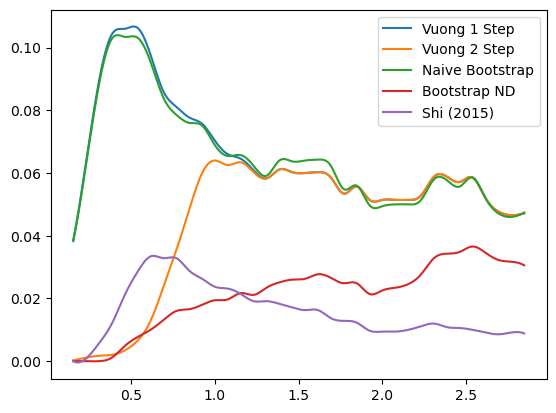

0.044721359549995794 8.197159426200533e-05


In [10]:
nobs = 500
c1,c2 = calc_c(nobs)

mc_run_size(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

# Extra Power Sims

Quantiles: 1th: 0.60, 5th: 1.74, 10th: 3.23, 30th: 9.27, 50th: 16.43, 70th: 25.33, 90th: 40.39, 95th: 48.22, 99th: 62.08
bonus term 1.7852925815933502 // variance stats 26.821918691295405 //part1 49.67026504526306 //part2 27.8219186912954 26.821918691295405
-0.08857858237897319 0.09303145430883518 3.69722091545951
-3.6591637455656736 0.09303145430883518 0.1266357522728095
---
Quantiles: 1th: 0.72, 5th: 1.86, 10th: 3.08, 30th: 9.10, 50th: 16.32, 70th: 24.62, 90th: 39.24, 95th: 46.46, 99th: 61.97
bonus term 1.261737241246676 // variance stats 36.16143025288455 //part1 46.88796048805533 //part2 37.16143025288455 36.16143025288455
-0.5142942624777402 0.41541729845810843 3.2187682396564203
-3.037768744971092 0.41541729845810843 0.695293757163068
---
Quantiles: 1th: 0.61, 5th: 1.63, 10th: 2.85, 30th: 8.16, 50th: 14.32, 70th: 21.94, 90th: 34.60, 95th: 41.95, 99th: 55.79
bonus term 1.0861107129392544 // variance stats 32.57160411090356 //part1 36.46247887540787 //part2 33.57160411090356 32.571

Quantiles: 1th: 0.78, 5th: 1.85, 10th: 3.24, 30th: 9.59, 50th: 16.89, 70th: 26.19, 90th: 41.80, 95th: 49.58, 99th: 65.04
bonus term 3.983428189405816 // variance stats 12.358693026601339 //part1 53.21339437578267 //part2 13.358693026601339 12.358693026601339
2.2593920633203246 -0.6890593230592317 5.838783089385831
-5.707464315491308 -0.6890593230592317 -2.1280732894258017
---
Quantiles: 1th: 0.69, 5th: 1.88, 10th: 3.49, 30th: 10.28, 50th: 17.93, 70th: 26.94, 90th: 42.63, 95th: 51.38, 99th: 65.89
bonus term 2.579480385863603 // variance stats 20.450243342002576 //part1 55.33048197269699 //part2 21.450243342002576 20.450243342002576
0.7808798884121734 -0.22766708359963386 4.399632429573585
-4.378080883315033 -0.22766708359963386 -0.7593283421536207
---
Quantiles: 1th: 0.90, 5th: 2.15, 10th: 3.68, 30th: 10.66, 50th: 18.47, 70th: 28.03, 90th: 44.90, 95th: 53.50, 99th: 71.16
bonus term 1.3441893280778348 // variance stats 44.67896649862032 //part1 61.40117928507038 //part2 45.67896649862032

Quantiles: 1th: 0.76, 5th: 2.00, 10th: 3.54, 30th: 10.38, 50th: 18.44, 70th: 28.41, 90th: 45.76, 95th: 55.63, 99th: 72.84
bonus term 4.660593861725845 // variance stats 12.680207769352107 //part1 63.75789235697664 //part2 13.680207769352107 12.680207769352107
2.784935908081257 -0.762709853307038 6.527863036591246
-6.5362518153704325 -0.762709853307038 -2.793324686860444
---
Quantiles: 1th: 0.80, 5th: 1.95, 10th: 3.28, 30th: 9.21, 50th: 15.85, 70th: 24.20, 90th: 38.50, 95th: 46.31, 99th: 60.89
bonus term 17.0604210414188 // variance stats 1.6459884903792708 //part1 45.141677716618474 //part2 2.6459884903792705 1.6459884903792708
15.741835284127648 -4.564180593698294 18.44103212572796
-18.37900679870995 -4.564180593698294 -15.679809957109635
---
Quantiles: 1th: 0.68, 5th: 1.98, 10th: 3.48, 30th: 9.86, 50th: 16.37, 70th: 25.09, 90th: 39.28, 95th: 47.03, 99th: 62.52
bonus term 2.0077538344439176 // variance stats 22.401331696898563 //part1 46.98411344554208 //part2 23.401331696898563 22.40

Quantiles: 1th: 0.85, 5th: 1.93, 10th: 3.29, 30th: 9.65, 50th: 16.75, 70th: 25.59, 90th: 40.29, 95th: 48.12, 99th: 62.59
bonus term 2.791201664289296 // variance stats 16.706471972752336 //part1 49.42233403903809 //part2 17.706471972752333 16.706471972752336
0.9216958442032975 -0.4488754901875888 4.466688982675324
-4.660707484375295 -0.4488754901875888 -1.1157143459032688
---
Quantiles: 1th: 0.77, 5th: 1.71, 10th: 2.99, 30th: 8.47, 50th: 14.59, 70th: 22.75, 90th: 36.00, 95th: 43.52, 99th: 57.56
bonus term 1.0685797039628464 // variance stats 35.93853895418742 //part1 39.471773020485664 //part2 36.93853895418742 35.93853895418742
-0.7747176062816317 0.435382429453143 2.9227746659165965
-2.9118770142073247 0.435382429453143 0.7856152579909038
---
Quantiles: 1th: 0.77, 5th: 1.92, 10th: 3.15, 30th: 9.65, 50th: 17.18, 70th: 26.20, 90th: 42.12, 95th: 48.77, 99th: 64.60
bonus term 3.718790982399714 // variance stats 13.530049961894486 //part1 54.03421877211051 //part2 14.530049961894484 13.53

Quantiles: 1th: 0.70, 5th: 1.94, 10th: 3.31, 30th: 9.87, 50th: 17.08, 70th: 26.78, 90th: 42.65, 95th: 50.11, 99th: 66.93
bonus term 2.9129806410404093 // variance stats 18.012811792894343 //part1 55.38395268444602 //part2 19.012811792894343 18.012811792894343
1.0673167697521055 -0.6421302821418114 4.7557987801924835
-4.758644512328713 -0.6421302821418114 -1.0701625018883354
---
Quantiles: 1th: 0.66, 5th: 2.02, 10th: 3.44, 30th: 10.75, 50th: 18.44, 70th: 28.81, 90th: 45.38, 95th: 53.34, 99th: 68.46
bonus term 2.408784301641145 // variance stats 25.03660071532272 //part1 62.71655507116798 //part2 26.03660071532272 25.03660071532272
0.5739963016887966 -0.1011697605006231 4.16682274453957
-4.243572301593494 -0.1011697605006231 -0.6507458587427194
---
Quantiles: 1th: 0.71, 5th: 1.98, 10th: 4.00, 30th: 11.88, 50th: 20.41, 70th: 30.76, 90th: 49.27, 95th: 58.83, 99th: 77.80
bonus term 2.504225513230222 // variance stats 28.52273537632941 //part1 73.93158714974855 //part2 29.52273537632941 28.5

Quantiles: 1th: 0.73, 5th: 1.77, 10th: 3.21, 30th: 9.41, 50th: 16.55, 70th: 25.70, 90th: 40.08, 95th: 47.46, 99th: 61.38
bonus term 1.7375126445000963 // variance stats 27.16044030448279 //part1 48.929121103728995 //part2 28.16044030448279 27.16044030448279
-0.02923451886319884 -0.3981058320709151 3.5760929754234034
-3.5042598078633915 -0.3981058320709151 0.10106768642321112
---
Quantiles: 1th: 0.80, 5th: 2.12, 10th: 3.68, 30th: 10.55, 50th: 18.61, 70th: 28.71, 90th: 46.01, 95th: 54.78, 99th: 69.94
bonus term 5.254166162890021 // variance stats 11.26876792977997 //part1 64.46214531700018 //part2 12.268767929779969 11.26876792977997
3.386707811670133 -2.0337983542094005 7.1607036634223595
-7.12162451410991 -2.0337983542094005 -3.3476286623576827
---
Quantiles: 1th: 0.71, 5th: 1.85, 10th: 3.08, 30th: 8.80, 50th: 15.57, 70th: 23.56, 90th: 37.17, 95th: 45.35, 99th: 57.87
bonus term 0.8981580397383411 // variance stats 45.84569488452065 //part1 42.0748374876615 //part2 46.84569488452065 45.

Quantiles: 1th: 0.74, 5th: 1.83, 10th: 3.19, 30th: 9.14, 50th: 15.68, 70th: 23.94, 90th: 37.50, 95th: 44.79, 99th: 58.39
bonus term 1.7998205448950226 // variance stats 22.798978946706075 //part1 42.8338912558057 //part2 23.798978946706075 22.798978946706075
-0.14524012817325918 -0.21811911800795863 3.763016715570945
-3.744881217963304 -0.21811911800795863 0.1633756257808998
---
Quantiles: 1th: 0.75, 5th: 1.96, 10th: 3.05, 30th: 9.23, 50th: 16.03, 70th: 24.67, 90th: 39.62, 95th: 47.25, 99th: 63.31
bonus term 7.903622998732021 // variance stats 5.047053278040627 //part1 47.793629362879756 //part2 6.047053278040626 5.047053278040627
6.175564034019303 -3.7236457789615858 9.580629809279728
-9.631681963444738 -3.7236457789615858 -6.226616188184315
---
Quantiles: 1th: 0.71, 5th: 1.75, 10th: 3.07, 30th: 8.35, 50th: 14.45, 70th: 22.18, 90th: 34.63, 95th: 41.80, 99th: 56.33
bonus term 1.859350803949478 // variance stats 18.642943824370942 //part1 36.523123391778554 //part2 19.642943824370942 18

Quantiles: 1th: 0.62, 5th: 1.72, 10th: 2.79, 30th: 8.00, 50th: 14.38, 70th: 21.68, 90th: 34.74, 95th: 41.26, 99th: 55.82
bonus term 3.408103661436886 // variance stats 9.781270616504735 //part1 36.743687863051704 //part2 10.781270616504735 9.781270616504735
1.765395753125894 -2.514809001450957 5.321709022764685
-5.050811569747879 -2.514809001450957 -1.4944983001090872
---
Quantiles: 1th: 0.74, 5th: 2.03, 10th: 3.50, 30th: 10.20, 50th: 17.41, 70th: 26.33, 90th: 42.72, 95th: 50.66, 99th: 66.52
bonus term 1.4508641634375041 // variance stats 37.30850047632842 //part1 55.58043049613346 //part2 38.30850047632842 37.30850047632842
-0.39040618526864274 0.09676182955919098 3.2756174362925687
-3.2921345121436514 0.09676182955919098 0.3738891094175606
---
Quantiles: 1th: 0.72, 5th: 1.96, 10th: 3.63, 30th: 10.13, 50th: 17.63, 70th: 27.42, 90th: 44.02, 95th: 51.56, 99th: 66.87
bonus term 1.8058715851230245 // variance stats 31.681441382445456 //part1 59.01848635342199 //part2 32.68144138244546 31.

Quantiles: 1th: 0.83, 5th: 2.06, 10th: 3.68, 30th: 10.96, 50th: 18.83, 70th: 28.80, 90th: 44.98, 95th: 53.84, 99th: 70.49
bonus term 4.449889659436658 // variance stats 12.844545224403547 //part1 61.60669863367651 //part2 13.844545224403547 12.844545224403547
2.5962280964627733 -2.759926049550194 6.265364272688937
-6.303551222410543 -2.759926049550194 -2.6344150461843787
---
Quantiles: 1th: 0.73, 5th: 1.86, 10th: 3.14, 30th: 9.46, 50th: 16.32, 70th: 25.66, 90th: 40.02, 95th: 48.30, 99th: 63.86
bonus term 4.659395927035832 // variance stats 9.46683530178678 //part1 48.76912977410019 //part2 10.46683530178678 9.46683530178678
2.9758202006540055 -3.993957916404395 6.375069582909927
-6.342971653417659 -3.993957916404395 -2.943722271161737
---
Quantiles: 1th: 0.72, 5th: 1.93, 10th: 3.54, 30th: 10.26, 50th: 18.35, 70th: 28.43, 90th: 45.02, 95th: 53.99, 99th: 71.28
bonus term 6.60500678408052 // variance stats 8.343561354297403 //part1 61.714286132606915 //part2 9.343561354297401 8.3435613542

Quantiles: 1th: 0.78, 5th: 1.97, 10th: 3.36, 30th: 9.77, 50th: 16.84, 70th: 25.69, 90th: 41.48, 95th: 49.67, 99th: 65.60
bonus term 2.5171544181463728 // variance stats 19.811699091327593 //part1 52.38626031686811 //part2 20.811699091327593 19.811699091327593
0.6662960127469365 -2.8560842367743593 4.415896279726864
-4.3680128235458096 -2.8560842367743593 -0.6184125565658816
---
Quantiles: 1th: 0.71, 5th: 1.78, 10th: 3.13, 30th: 9.12, 50th: 16.39, 70th: 25.40, 90th: 39.58, 95th: 47.16, 99th: 62.23
bonus term 2.6574118174990704 // variance stats 16.95199640741945 //part1 47.70584740077731 //part2 17.95199640741945 16.95199640741945
0.7903976115012835 -2.03218840519853 4.344981732449495
-4.524426023496858 -2.03218840519853 -0.9698419025486467
---
Quantiles: 1th: 0.70, 5th: 1.96, 10th: 3.36, 30th: 9.87, 50th: 17.17, 70th: 26.27, 90th: 41.95, 95th: 50.32, 99th: 67.73
bonus term 2.805356023346953 // variance stats 18.101532909586748 //part1 53.58660040306923 //part2 19.101532909586748 18.101

Quantiles: 1th: 0.80, 5th: 2.04, 10th: 3.44, 30th: 9.73, 50th: 17.01, 70th: 26.20, 90th: 42.31, 95th: 49.84, 99th: 67.13
bonus term 5.242627342478063 // variance stats 9.399939651842054 //part1 54.52300797886894 //part2 10.399939651842054 9.399939651842054
3.3252553585811064 -4.733500772356347 7.200334064097454
-7.15999932637502 -4.733500772356347 -3.284920620858673
---
Quantiles: 1th: 0.74, 5th: 1.83, 10th: 3.08, 30th: 9.68, 50th: 16.93, 70th: 26.32, 90th: 41.79, 95th: 49.61, 99th: 66.98
bonus term 0.9161807111793218 // variance stats 57.05760657355267 //part1 53.191259279926754 //part2 58.057606573552675 57.05760657355267
-0.9663378292331316 0.31227096311638863 2.934007073007164
-2.798699251591775 0.31227096311638863 1.1016456506485204
---
Quantiles: 1th: 0.76, 5th: 1.90, 10th: 3.29, 30th: 10.21, 50th: 18.26, 70th: 27.47, 90th: 44.23, 95th: 52.26, 99th: 70.10
bonus term 5.124824699550891 // variance stats 10.624219997716597 //part1 59.572089757311424 //part2 11.624219997716597 10.624

Quantiles: 1th: 0.67, 5th: 1.66, 10th: 2.83, 30th: 9.00, 50th: 15.47, 70th: 23.65, 90th: 37.20, 95th: 43.96, 99th: 56.67
bonus term 4.24854274205283 // variance stats 8.918962303771885 //part1 42.14113530438566 //part2 9.918962303771885 8.918962303771885
2.4888328204740224 -5.745978108594259 6.057919038390229
-6.008252663631638 -5.745978108594259 -2.4391664457154327
---
Quantiles: 1th: 0.72, 5th: 1.94, 10th: 3.29, 30th: 9.51, 50th: 16.18, 70th: 24.74, 90th: 38.60, 95th: 45.82, 99th: 63.01
bonus term 1.6954839893552205 // variance stats 25.75532372125351 //part1 45.36322299940127 //part2 26.75532372125351 25.75532372125351
-0.2503866704672868 -1.5997043387096141 3.600690189858242
-3.6413546491777278 -1.5997043387096141 0.20972221114780096
---
Quantiles: 1th: 0.77, 5th: 1.95, 10th: 3.37, 30th: 9.87, 50th: 16.97, 70th: 25.94, 90th: 41.79, 95th: 49.99, 99th: 63.40
bonus term 1.3428428141485105 // variance stats 38.609769699980866 //part1 53.189694611696716 //part2 39.60976969998087 38.6097

Quantiles: 1th: 0.84, 5th: 2.37, 10th: 4.51, 30th: 12.49, 50th: 21.48, 70th: 32.91, 90th: 52.48, 95th: 61.71, 99th: 81.24
bonus term 6.721099301035274 // variance stats 11.479993080144233 //part1 83.87927276788245 //part2 12.479993080144233 11.479993080144233
4.7712233915850515 -6.67213637478355 8.413496962199583
-8.670975210485496 -6.67213637478355 -5.028701639870965
---
Quantiles: 1th: 0.79, 5th: 2.17, 10th: 3.92, 30th: 11.56, 50th: 19.80, 70th: 30.73, 90th: 49.60, 95th: 58.96, 99th: 77.06
bonus term 1.6356851173515559 // variance stats 44.801783044719606 //part1 74.91729487441269 //part2 45.801783044719606 44.801783044719606
-0.2889003361125676 -1.4360429548037035 3.6720317709854426
-3.560270570815679 -1.4360429548037035 0.4006615362823313
---
Quantiles: 1th: 0.74, 5th: 1.99, 10th: 3.50, 30th: 10.12, 50th: 17.08, 70th: 26.07, 90th: 41.57, 95th: 49.20, 99th: 67.06
bonus term 1.7172434826507081 // variance stats 29.637313396379234 //part1 52.61172675585947 //part2 30.63731339637923 29

Quantiles: 1th: 0.71, 5th: 1.94, 10th: 3.16, 30th: 9.05, 50th: 15.90, 70th: 24.34, 90th: 38.40, 95th: 46.49, 99th: 59.68
bonus term 2.3512720058606402 // variance stats 18.100752057322072 //part1 44.91106360326643 //part2 19.100752057322072 18.100752057322072
0.34923427665562035 -4.954520694337992 4.3311853872266415
-4.35330973506566 -4.954520694337992 -0.3713586244946392
---
Quantiles: 1th: 0.72, 5th: 2.02, 10th: 3.35, 30th: 9.03, 50th: 15.64, 70th: 24.29, 90th: 39.02, 95th: 46.48, 99th: 61.54
bonus term 2.070265366815591 // variance stats 21.39217079214344 //part1 46.3577356787942 //part2 22.39217079214344 21.39217079214344
0.19016033659183346 -3.2715878317610114 3.8268962734229377
-3.950370397039348 -3.2715878317610114 -0.31363446020824404
---
Quantiles: 1th: 0.70, 5th: 2.00, 10th: 3.69, 30th: 11.29, 50th: 19.54, 70th: 30.16, 90th: 47.21, 95th: 56.47, 99th: 76.76
bonus term 4.258403790412483 // variance stats 14.940619544197778 //part1 67.88159468853515 //part2 15.94061954419778 14.

Quantiles: 1th: 0.93, 5th: 2.11, 10th: 3.59, 30th: 10.08, 50th: 17.78, 70th: 27.57, 90th: 45.19, 95th: 53.72, 99th: 69.33
bonus term 3.590960206689393 // variance stats 16.31579978829873 //part1 62.180347986781356 //part2 17.31579978829873 16.31579978829873
1.7766305860192655 -5.558185379523893 5.489299467411595
-5.40528982735952 -5.558185379523893 -1.692620945967192
---
Quantiles: 1th: 0.63, 5th: 1.70, 10th: 2.97, 30th: 8.59, 50th: 15.13, 70th: 23.01, 90th: 35.84, 95th: 42.70, 99th: 56.88
bonus term 2.729476238930811 // variance stats 13.330634552965325 //part1 39.115126501119725 //part2 14.330634552965325 13.330634552965325
0.8725856410637288 -6.372233598708118 4.592400625141117
-4.586366836797893 -6.372233598708118 -0.8665518527205052
---
Quantiles: 1th: 0.77, 5th: 1.86, 10th: 3.37, 30th: 9.52, 50th: 16.73, 70th: 25.86, 90th: 40.48, 95th: 48.44, 99th: 64.94
bonus term 1.5471169912229115 // variance stats 31.259507192363056 //part1 49.9092317057826 //part2 32.25950719236305 31.259507

Quantiles: 1th: 0.79, 5th: 1.91, 10th: 3.16, 30th: 8.84, 50th: 15.22, 70th: 23.21, 90th: 38.42, 95th: 44.72, 99th: 57.92
bonus term 2.241904133766751 // variance stats 19.04875185873018 //part1 44.94737966895102 //part2 20.04875185873018 19.04875185873018
0.34494772325608103 -5.022418634345416 4.158535652188144
-4.138860544277422 -5.022418634345416 -0.32527261534535845
---
Quantiles: 1th: 0.78, 5th: 1.93, 10th: 3.29, 30th: 9.01, 50th: 15.45, 70th: 23.39, 90th: 36.96, 95th: 44.22, 99th: 57.69
bonus term 2.2673092769434016 // variance stats 17.343823601925386 //part1 41.59112142725875 //part2 18.343823601925386 17.343823601925386
0.2788072163891283 -6.0887753388598185 4.307618474202799
-4.255811337497675 -6.0887753388598185 -0.2270000796840041
---
Quantiles: 1th: 0.77, 5th: 1.95, 10th: 3.49, 30th: 9.57, 50th: 17.46, 70th: 26.24, 90th: 41.00, 95th: 49.18, 99th: 67.34
bonus term 2.931399407786668 // variance stats 16.458906924235674 //part1 51.17902941830701 //part2 17.45890692423567 16.45

Quantiles: 1th: 0.70, 5th: 1.79, 10th: 3.15, 30th: 8.92, 50th: 15.52, 70th: 23.75, 90th: 37.34, 95th: 44.65, 99th: 58.58
bonus term 2.4401106836179247 // variance stats 16.401003093988255 //part1 42.4603735553093 //part2 17.401003093988255 16.401003093988255
0.3445851803656789 -6.589233752155426 4.341721674634828
-4.53563618687017 -6.589233752155426 -0.5384996926010217
---
Quantiles: 1th: 0.73, 5th: 1.63, 10th: 2.75, 30th: 7.88, 50th: 13.74, 70th: 21.25, 90th: 33.92, 95th: 40.43, 99th: 51.95
bonus term 1.8316081582389039 // variance stats 18.127051823329527 //part1 35.033264162668665 //part2 19.127051823329527 18.127051823329527
-0.10934144342289795 -5.920850565817014 3.7161735506816638
-3.772557759900706 -5.920850565817014 0.05295723420385592
---
Quantiles: 1th: 0.78, 5th: 2.01, 10th: 3.56, 30th: 10.47, 50th: 18.68, 70th: 28.61, 90th: 45.51, 95th: 54.35, 99th: 72.33
bonus term 2.5012018393292625 // variance stats 24.214718960780978 //part1 63.0671014428758 //part2 25.214718960780978 2

Quantiles: 1th: 0.75, 5th: 1.91, 10th: 3.22, 30th: 8.75, 50th: 15.55, 70th: 24.44, 90th: 39.00, 95th: 46.37, 99th: 61.65
bonus term 0.981989903060143 // variance stats 46.164084639537435 //part1 46.31465490309975 //part2 47.164084639537435 46.164084639537435
-1.0609872901891773 -1.9653997694404142 2.830279565319074
-3.0249670963094637 -1.9653997694404142 0.8662997591987883
---
Quantiles: 1th: 0.73, 5th: 1.99, 10th: 3.39, 30th: 9.61, 50th: 16.85, 70th: 26.19, 90th: 40.93, 95th: 49.55, 99th: 64.37
bonus term 2.4688873723155695 // variance stats 19.66743768051886 //part1 51.025575907551996 //part2 20.66743768051886 19.66743768051886
0.4861158809146557 -5.429802508350513 4.331923148198112
-4.451658863716484 -5.429802508350513 -0.6058515964330272
---
Quantiles: 1th: 0.75, 5th: 1.88, 10th: 3.15, 30th: 9.32, 50th: 16.47, 70th: 24.98, 90th: 39.42, 95th: 46.50, 99th: 63.60
bonus term 2.576857405725856 // variance stats 17.361821141810665 //part1 47.3157947918884 //part2 18.361821141810665 17.36

Quantiles: 1th: 0.66, 5th: 1.65, 10th: 2.83, 30th: 7.45, 50th: 12.96, 70th: 20.47, 90th: 32.22, 95th: 38.15, 99th: 51.21
bonus term 1.4826622498337898 // variance stats 20.32014465305335 //part1 31.610573638077927 //part2 21.32014465305335 20.32014465305335
-0.7585361727534337 -6.81993694933694 3.370176905803533
-3.723860672421013 -6.81993694933694 0.4048524061359534
---
Quantiles: 1th: 0.71, 5th: 1.92, 10th: 3.41, 30th: 9.78, 50th: 17.32, 70th: 26.58, 90th: 41.56, 95th: 48.91, 99th: 64.14
bonus term 2.3655964139165704 // variance stats 21.232512452991166 //part1 52.5931517311514 //part2 22.232512452991166 21.232512452991166
0.42272193512483597 -7.205406373323225 4.1930923361358925
-4.308470892708304 -7.205406373323225 -0.5381004916972478
---
Quantiles: 1th: 0.70, 5th: 1.88, 10th: 3.29, 30th: 9.96, 50th: 17.49, 70th: 26.51, 90th: 42.14, 95th: 50.51, 99th: 65.29
bonus term 2.5132640826863035 // variance stats 20.511667221633722 //part1 54.0645005868323 //part2 21.511667221633722 20.5116

Quantiles: 1th: 0.85, 5th: 2.05, 10th: 3.35, 30th: 9.50, 50th: 16.38, 70th: 24.97, 90th: 39.11, 95th: 45.92, 99th: 61.99
bonus term 2.337787334679013 // variance stats 18.923066490872493 //part1 46.57589251032957 //part2 19.923066490872493 18.923066490872493
0.004267875265093999 -7.889182282176751 4.298702016996378
-4.671306794092932 -7.889182282176751 -0.3768726523616477
---
Quantiles: 1th: 0.75, 5th: 1.85, 10th: 3.32, 30th: 9.40, 50th: 16.10, 70th: 25.47, 90th: 39.36, 95th: 46.98, 99th: 62.58
bonus term 2.565551653244906 // variance stats 17.38968648782687 //part1 47.179690571499734 //part2 18.38968648782687 17.38968648782687
0.4801526578297093 -9.174077154813832 4.482535822087192
-4.650950648660102 -9.174077154813832 -0.6485674844026208
---
Quantiles: 1th: 0.71, 5th: 1.80, 10th: 3.22, 30th: 9.27, 50th: 16.07, 70th: 25.03, 90th: 40.31, 95th: 48.37, 99th: 64.89
bonus term 1.4434573931442476 // variance stats 33.28231852440345 //part1 49.485066128176165 //part2 34.28231852440345 33.282

Quantiles: 1th: 0.82, 5th: 2.00, 10th: 3.57, 30th: 10.58, 50th: 18.73, 70th: 28.96, 90th: 47.07, 95th: 55.86, 99th: 74.30
bonus term 1.1239220236462661 // variance stats 59.04263392838075 //part1 67.48323862983766 //part2 60.04263392838075 59.04263392838075
-0.6989639156164045 -1.7839832216185851 3.1623909938617176
-2.946807962908937 -1.7839832216185851 0.9145469465691854
---
Quantiles: 1th: 0.78, 5th: 1.86, 10th: 3.28, 30th: 9.14, 50th: 15.51, 70th: 23.79, 90th: 38.20, 95th: 45.69, 99th: 59.04
bonus term 1.2284636340572908 // variance stats 35.167437565410665 //part1 44.43038178614457 //part2 36.16743756541067 35.167437565410665
-0.7233731973103319 -4.4250144437461625 3.054589768639609
-3.180300465424913 -4.4250144437461625 0.5976625005250271
---
Quantiles: 1th: 0.69, 5th: 1.76, 10th: 3.19, 30th: 9.66, 50th: 17.06, 70th: 26.17, 90th: 41.61, 95th: 49.91, 99th: 66.83
bonus term 2.078573123927261 // variance stats 24.36203683800731 //part1 52.716848139535124 //part2 25.36203683800731 24.

Quantiles: 1th: 0.84, 5th: 2.21, 10th: 3.68, 30th: 11.05, 50th: 19.15, 70th: 28.52, 90th: 44.47, 95th: 53.40, 99th: 69.69
bonus term 1.1578106769705705 // variance stats 51.00598106118287 //part1 60.213080138966816 //part2 52.00598106118287 51.00598106118287
-0.768464331885645 -2.9869237071536654 3.0817278731674844
-3.084085685826786 -2.9869237071536654 0.7661065192263434
---
Quantiles: 1th: 0.63, 5th: 1.58, 10th: 2.71, 30th: 7.97, 50th: 14.00, 70th: 21.81, 90th: 34.70, 95th: 40.92, 99th: 53.43
bonus term 1.0707148953226542 // variance stats 33.24607404965202 //part1 36.667781591285035 //part2 34.24607404965203 33.24607404965202
-0.8648239484640171 -5.357461102257252 2.907150068899609
-3.0062537391093254 -5.357461102257252 0.7657202782543007
---
Quantiles: 1th: 0.72, 5th: 1.95, 10th: 3.37, 30th: 9.88, 50th: 17.16, 70th: 26.23, 90th: 41.98, 95th: 49.08, 99th: 65.12
bonus term 2.5205765202463963 // variance stats 20.28938600098576 //part1 53.661526484547025 //part2 21.289386000985758 20.

Quantiles: 1th: 0.75, 5th: 1.89, 10th: 3.23, 30th: 9.56, 50th: 17.10, 70th: 25.88, 90th: 40.69, 95th: 48.70, 99th: 64.39
bonus term 2.0515803891609115 // variance stats 23.576361130128173 //part1 50.420380531507455 //part2 24.576361130128173 23.576361130128173
-0.05099478202717358 -9.792935858101819 3.84244774276248
-4.154155560348996 -9.792935858101819 -0.2607130355593431
---
Quantiles: 1th: 0.82, 5th: 1.87, 10th: 2.94, 30th: 8.15, 50th: 14.02, 70th: 22.03, 90th: 35.58, 95th: 42.07, 99th: 53.99
bonus term 0.8575781726390359 // variance stats 43.95690752343528 //part1 38.55406260144975 //part2 44.95690752343528 43.95690752343528
-1.2906870703493025 -4.732994573487382 2.7711756563667653
-3.005843415627374 -4.732994573487382 1.0560193110886933
---
Quantiles: 1th: 0.74, 5th: 1.89, 10th: 3.14, 30th: 9.59, 50th: 16.46, 70th: 24.92, 90th: 38.65, 95th: 47.08, 99th: 62.57
bonus term 1.1994729167652647 // variance stats 36.92367943472717 //part1 45.488426386043095 //part2 37.92367943472718 36.9

Quantiles: 1th: 0.80, 5th: 2.19, 10th: 3.75, 30th: 10.51, 50th: 18.12, 70th: 27.30, 90th: 44.11, 95th: 52.75, 99th: 67.23
bonus term 1.9465148955781209 // variance stats 29.439598715315615 //part1 59.251132314782474 //part2 30.439598715315615 29.439598715315615
-0.12980054250785558 -7.061846133060825 3.8424662754554957
-4.022830333664097 -7.061846133060825 -0.05056351570074564
---
Quantiles: 1th: 0.83, 5th: 1.92, 10th: 3.38, 30th: 10.28, 50th: 18.22, 70th: 28.37, 90th: 44.48, 95th: 52.93, 99th: 68.00
bonus term 2.2595180756641677 // variance stats 25.664814148651928 //part1 60.24962955310468 //part2 26.664814148651928 25.664814148651928
0.16139447401870474 -8.197644469872454 4.058754181296059
-4.357641677309632 -8.197644469872454 -0.46028197003227633
---
Quantiles: 1th: 0.70, 5th: 1.89, 10th: 3.37, 30th: 9.72, 50th: 16.95, 70th: 25.70, 90th: 40.43, 95th: 48.65, 99th: 63.49
bonus term 0.9753168504561259 // variance stats 50.04146008062131 //part1 49.781596088513666 //part2 51.0414600806

Quantiles: 1th: 0.74, 5th: 1.94, 10th: 3.28, 30th: 9.74, 50th: 16.80, 70th: 25.49, 90th: 40.24, 95th: 47.83, 99th: 63.05
bonus term 1.9477598254238546 // variance stats 24.315834822841648 //part1 49.309166014997196 //part2 25.315834822841648 24.315834822841648
0.008088550417881738 -10.258163024109567 3.765883460623977
-3.8874311004298274 -10.258163024109567 -0.12963619022373238
---
Quantiles: 1th: 0.78, 5th: 1.90, 10th: 3.36, 30th: 9.88, 50th: 17.02, 70th: 25.91, 90th: 41.22, 95th: 49.31, 99th: 64.04
bonus term 2.0204288018007275 // variance stats 24.607255034357426 //part1 51.737635606472416 //part2 25.607255034357426 24.607255034357426
-0.3590011986036537 -11.902077654964504 4.048939444284632
-4.3998588022051095 -11.902077654964504 0.00808184068317628
---
Quantiles: 1th: 0.81, 5th: 1.94, 10th: 3.31, 30th: 9.51, 50th: 16.70, 70th: 25.26, 90th: 40.74, 95th: 49.19, 99th: 64.29
bonus term 1.0661383414490007 // variance stats 46.416255986899564 //part1 50.55228851559436 //part2 47.4162559

Quantiles: 1th: 0.70, 5th: 2.04, 10th: 3.71, 30th: 10.79, 50th: 18.48, 70th: 28.01, 90th: 44.26, 95th: 52.36, 99th: 69.61
bonus term 1.9473836407567653 // variance stats 29.634849573027644 //part1 59.657804895558414 //part2 30.634849573027644 29.634849573027644
-0.22672742759639106 -8.420866371281047 3.968073990935164
-4.121494709109921 -8.420866371281047 0.07330670942163361
---
Quantiles: 1th: 0.70, 5th: 2.01, 10th: 3.53, 30th: 9.59, 50th: 16.59, 70th: 24.97, 90th: 40.60, 95th: 47.78, 99th: 61.45
bonus term 1.5924651269382553 // variance stats 30.528777639451498 //part1 50.20847888581716 //part2 31.528777639451498 30.528777639451498
-0.2893281785475491 -9.506100519957254 3.545364907848502
-3.4742584324240595 -9.506100519957254 0.3604346539719913
---
Quantiles: 1th: 0.66, 5th: 1.82, 10th: 3.24, 30th: 10.01, 50th: 17.57, 70th: 26.80, 90th: 42.78, 95th: 51.98, 99th: 66.62
bonus term 2.0431101729114682 // variance stats 26.278778678285487 //part1 55.73355022220554 //part2 27.2787786782854

Quantiles: 1th: 0.69, 5th: 1.87, 10th: 3.23, 30th: 9.24, 50th: 15.93, 70th: 24.38, 90th: 38.23, 95th: 45.40, 99th: 58.40
bonus term 1.775885133012681 // variance stats 24.068296524481056 //part1 44.51841510777937 //part2 25.068296524481056 24.068296524481056
-0.5740470021334199 -13.061114074666147 3.932769674321797
-4.125817268158782 -13.061114074666147 0.38099940829643475
---
Quantiles: 1th: 0.90, 5th: 2.02, 10th: 3.28, 30th: 9.61, 50th: 16.70, 70th: 25.33, 90th: 40.53, 95th: 47.98, 99th: 64.50
bonus term 1.6708952753742723 // variance stats 28.93958381439786 //part1 50.025909142149416 //part2 29.93958381439786 28.93958381439786
-0.6364165395912234 -10.22566385426215 3.6070573609558
-3.9782070903397684 -10.22566385426215 0.26526681020725523
---
Quantiles: 1th: 0.74, 5th: 1.79, 10th: 3.10, 30th: 8.59, 50th: 14.95, 70th: 22.79, 90th: 36.66, 95th: 43.48, 99th: 57.13
bonus term 1.5193831955579025 // variance stats 25.93873561677422 //part1 40.9302622057039 //part2 26.93873561677422 25.938

Quantiles: 1th: 0.77, 5th: 1.90, 10th: 3.51, 30th: 9.97, 50th: 17.64, 70th: 26.94, 90th: 42.11, 95th: 50.68, 99th: 65.98
bonus term 2.0513203920512266 // variance stats 25.329119363339505 //part1 54.009459454769136 //part2 26.329119363339505 25.329119363339505
-0.1629857963478398 -13.403455884229665 4.045228321435713
-4.265626580450293 -13.403455884229665 -0.05741246266673997
---
Quantiles: 1th: 0.94, 5th: 2.31, 10th: 4.27, 30th: 12.32, 50th: 21.02, 70th: 31.56, 90th: 49.05, 95th: 58.28, 99th: 76.63
bonus term 1.9227991270432896 // variance stats 37.10966700619318 //part1 73.2772344514187 //part2 38.109667006193185 37.10966700619318
-0.3188761928621716 -8.511516931381989 3.949467613130416
-4.16447444694875 -8.511516931381989 0.10386935904383676
---
Quantiles: 1th: 0.64, 5th: 1.85, 10th: 3.20, 30th: 8.92, 50th: 15.44, 70th: 23.46, 90th: 37.66, 95th: 44.04, 99th: 57.07
bonus term 1.0366844229307643 // variance stats 40.67059164631863 //part1 43.19925325404736 //part2 41.670591646318634 4

Quantiles: 1th: 0.76, 5th: 1.92, 10th: 3.20, 30th: 9.26, 50th: 16.46, 70th: 25.17, 90th: 40.11, 95th: 47.04, 99th: 63.41
bonus term 1.220072851866381 // variance stats 39.16416836152237 //part1 49.003211435684086 //part2 40.16416836152238 39.16416836152237
-0.9892114307435499 -9.255674564483408 3.321503222977138
-3.429357134476312 -9.255674564483408 0.8813575192443761
---
Quantiles: 1th: 0.67, 5th: 1.88, 10th: 3.31, 30th: 9.81, 50th: 16.55, 70th: 25.15, 90th: 40.81, 95th: 48.45, 99th: 62.83
bonus term 1.6951661984888913 // variance stats 28.918646565580232 //part1 50.71707836250737 //part2 29.918646565580232 28.918646565580232
-0.6406467676496076 -12.204536116900053 3.788936364087952
-4.03097916462739 -12.204536116900053 0.3986039671101689
---
Quantiles: 1th: 0.76, 5th: 1.91, 10th: 3.44, 30th: 9.93, 50th: 17.64, 70th: 27.60, 90th: 43.96, 95th: 51.35, 99th: 67.79
bonus term 2.0131593261729686 // variance stats 28.23374500453265 //part1 58.85218639483733 //part2 29.23374500453265 28.2337

Quantiles: 1th: 0.73, 5th: 1.91, 10th: 3.44, 30th: 10.03, 50th: 17.84, 70th: 27.58, 90th: 43.71, 95th: 51.40, 99th: 68.26
bonus term 2.1839476151770554 // variance stats 25.635717482174005 //part1 58.17101167372373 //part2 26.635717482174005 25.635717482174005
-0.18315365817160004 -12.936048431579948 4.288399932228183
-4.551048888525711 -12.936048431579948 -0.07949529812592848
---
Quantiles: 1th: 0.67, 5th: 1.75, 10th: 3.08, 30th: 9.03, 50th: 15.35, 70th: 23.46, 90th: 37.77, 95th: 44.57, 99th: 58.54
bonus term 1.1764634254668611 // variance stats 35.91913349520774 //part1 43.43401025704043 //part2 36.91913349520774 35.91913349520774
-1.0956290786088358 -10.380655775274597 3.084734177890974
-3.448555929542558 -10.380655775274597 0.7318073269572519
---
Quantiles: 1th: 0.80, 5th: 1.88, 10th: 3.41, 30th: 10.06, 50th: 16.99, 70th: 26.48, 90th: 42.78, 95th: 50.53, 99th: 66.43
bonus term 1.5252360838125696 // variance stats 35.54454268078564 //part1 55.7390551631628 //part2 36.544542680785646

Quantiles: 1th: 0.73, 5th: 1.79, 10th: 3.27, 30th: 9.89, 50th: 17.04, 70th: 26.15, 90th: 41.37, 95th: 49.47, 99th: 65.07
bonus term 1.535958260531019 // variance stats 32.92734081710145 //part1 52.110979385878196 //part2 33.92734081710146 32.92734081710145
-0.5272779963000747 -11.385438547340566 3.302707371321569
-3.5991945173621125 -11.385438547340566 0.23079085025953117
---
Quantiles: 1th: 0.63, 5th: 1.66, 10th: 2.93, 30th: 9.07, 50th: 15.83, 70th: 24.31, 90th: 39.02, 95th: 46.51, 99th: 59.93
bonus term 0.9385960082069038 // variance stats 48.397022292360745 //part1 46.36384794091724 //part2 49.39702229236075 48.397022292360745
-1.15651308677067 -7.907280068308846 2.9826061913754263
-3.0337051031844777 -7.907280068308846 1.1054141749616184
---
Quantiles: 1th: 0.86, 5th: 1.98, 10th: 3.42, 30th: 9.71, 50th: 16.88, 70th: 26.50, 90th: 42.88, 95th: 51.06, 99th: 66.35
bonus term 1.2529614912816858 // variance stats 43.695568387984586 //part1 56.00182602109175 //part2 44.69556838798459 43.6

Quantiles: 1th: 0.74, 5th: 1.96, 10th: 3.36, 30th: 10.33, 50th: 17.75, 70th: 27.25, 90th: 43.18, 95th: 51.96, 99th: 69.93
bonus term 1.7837072915095018 // variance stats 30.831946012975337 //part1 56.778874206280925 //part2 31.831946012975337 30.831946012975337
-0.5608728672341974 -14.406207143109295 3.9769982839670543
-4.1282874502532 -14.406207143109295 0.4095837009480509
---
Quantiles: 1th: 0.72, 5th: 1.77, 10th: 3.03, 30th: 9.08, 50th: 15.23, 70th: 23.55, 90th: 36.81, 95th: 43.69, 99th: 55.67
bonus term 1.4636442952292867 // variance stats 27.196891766848854 //part1 41.27021977774597 //part2 28.19689176684885 27.196891766848854
-0.8765151597619539 -13.862897986630678 3.56641041159497
-3.8038037502205273 -13.862897986630678 0.6391218211363964
---
Quantiles: 1th: 0.72, 5th: 1.84, 10th: 3.53, 30th: 10.96, 50th: 19.30, 70th: 29.02, 90th: 47.23, 95th: 55.83, 99th: 73.54
bonus term 1.2256848305226167 // variance stats 54.4137514392855 //part1 67.91979454148304 //part2 55.4137514392855 54

Quantiles: 1th: 0.76, 5th: 2.00, 10th: 3.63, 30th: 10.57, 50th: 18.19, 70th: 27.78, 90th: 44.07, 95th: 53.34, 99th: 71.19
bonus term 1.737842157243963 // variance stats 33.026730752917096 //part1 59.13308717560895 //part2 34.026730752917096 33.026730752917096
-0.6566214296515493 -12.802958323842942 3.509182731377838
-4.132305744139476 -12.802958323842942 0.03349841688991166
---
Quantiles: 1th: 0.66, 5th: 1.94, 10th: 3.29, 30th: 9.99, 50th: 16.95, 70th: 26.62, 90th: 42.73, 95th: 51.01, 99th: 67.23
bonus term 1.454704961408523 // variance stats 37.2130967607405 //part1 55.58878144863317 //part2 38.2130967607405 37.2130967607405
-1.0592775611212337 -11.650207572821047 3.5780057517611414
-3.9686874839382797 -11.650207572821047 0.6685958289440954
---
Quantiles: 1th: 0.74, 5th: 1.99, 10th: 3.33, 30th: 9.69, 50th: 16.75, 70th: 25.50, 90th: 41.04, 95th: 48.36, 99th: 64.52
bonus term 1.4057278142566771 // variance stats 35.48429881786383 //part1 51.2869936319232 //part2 36.48429881786384 35.484

Quantiles: 1th: 0.58, 5th: 1.60, 10th: 2.80, 30th: 8.09, 50th: 14.04, 70th: 21.24, 90th: 33.63, 95th: 40.04, 99th: 51.82
bonus term 0.7605708605828027 // variance stats 44.274239340062664 //part1 34.43426717710324 //part2 45.274239340062664 44.274239340062664
-1.3562135837214695 -8.96763776111278 2.656729890478532
-2.877355304887075 -8.96763776111278 1.1355881693129266
---
Quantiles: 1th: 0.67, 5th: 1.91, 10th: 3.42, 30th: 9.91, 50th: 17.70, 70th: 27.14, 90th: 42.33, 95th: 51.04, 99th: 67.42
bonus term 1.3137663286160965 // variance stats 40.53532817761533 //part1 54.567715607770396 //part2 41.53532817761533 40.53532817761533
-0.9396428612252257 -11.182270544925162 3.296337733754109
-3.5671755184574185 -11.182270544925162 0.6688050765219162
---
Quantiles: 1th: 0.79, 5th: 1.89, 10th: 3.34, 30th: 10.43, 50th: 18.09, 70th: 27.49, 90th: 43.65, 95th: 51.69, 99th: 68.04
bonus term 1.364111687259983 // variance stats 41.54026324190559 //part1 58.02967026739968 //part2 42.54026324190559 41.540

Quantiles: 1th: 0.83, 5th: 2.20, 10th: 3.70, 30th: 10.92, 50th: 19.44, 70th: 29.33, 90th: 46.49, 95th: 55.12, 99th: 71.46
bonus term 1.990528962396478 // variance stats 32.067980668596775 //part1 65.82277324880874 //part2 33.067980668596775 32.067980668596775
-0.3921916822354299 -15.543315557506103 3.905119841733634
-4.373249607028386 -15.543315557506103 -0.07593808305932183
---
Quantiles: 1th: 0.64, 5th: 1.68, 10th: 2.93, 30th: 8.71, 50th: 15.53, 70th: 23.71, 90th: 37.75, 95th: 44.86, 99th: 58.19
bonus term 0.8978536571295472 // variance stats 47.324598223368994 //part1 43.388417244167876 //part2 48.324598223369 47.324598223368994
-1.3782971284084544 -9.905447880459848 2.9865963474197983
-3.174004442667549 -9.905447880459848 1.1908890331607038
---
Quantiles: 1th: 0.68, 5th: 1.70, 10th: 3.14, 30th: 9.87, 50th: 16.84, 70th: 26.08, 90th: 40.96, 95th: 49.15, 99th: 64.31
bonus term 0.8226716414329291 // variance stats 61.092878100864866 //part1 51.08204994853328 //part2 62.092878100864866 

Quantiles: 1th: 0.65, 5th: 1.95, 10th: 3.39, 30th: 9.75, 50th: 16.56, 70th: 26.11, 90th: 41.80, 95th: 49.75, 99th: 64.76
bonus term 1.5695025783627554 // variance stats 32.89604593638653 //part1 53.199931493461065 //part2 33.89604593638653 32.89604593638653
-0.9883639515835537 -15.820075487905266 3.885120795528764
-4.127369108309064 -15.820075487905266 0.7461156388032533
---
Quantiles: 1th: 0.65, 5th: 1.78, 10th: 3.34, 30th: 9.39, 50th: 16.27, 70th: 25.42, 90th: 40.12, 95th: 47.01, 99th: 60.33
bonus term 0.942159935071011 // variance stats 51.01669036327721 //part1 49.00804161527415 //part2 52.01669036327722 51.01669036327721
-1.1573199061892363 -8.927352344728257 3.077913431564653
-3.0416397763312584 -8.927352344728257 1.193593561422631
---
Quantiles: 1th: 0.70, 5th: 1.91, 10th: 3.55, 30th: 10.58, 50th: 18.56, 70th: 28.13, 90th: 44.60, 95th: 53.06, 99th: 68.41
bonus term 1.3569244847915238 // variance stats 43.63898462221682 //part1 60.57173121011831 //part2 44.63898462221682 43.63898

Quantiles: 1th: 0.66, 5th: 1.79, 10th: 2.98, 30th: 8.75, 50th: 15.89, 70th: 24.78, 90th: 39.03, 95th: 46.39, 99th: 60.69
bonus term 1.1922764113658018 // variance stats 37.91598111460353 //part1 46.39860630809882 //part2 38.91598111460353 37.91598111460353
-0.9557169750964902 -14.747322581843346 3.3005908678771028
-3.3402697978280935 -14.747322581843346 0.9160380451454996
---
Quantiles: 1th: 0.67, 5th: 1.91, 10th: 3.14, 30th: 9.74, 50th: 16.83, 70th: 26.04, 90th: 41.46, 95th: 49.22, 99th: 66.38
bonus term 1.4821481175523472 // variance stats 34.31154718268973 //part1 52.33694318468448 //part2 35.31154718268973 34.31154718268973
-1.056700903992652 -15.884336815782024 3.6276844179730445
-4.0209971390973465 -15.884336815782024 0.6633881828683503
---
Quantiles: 1th: 0.74, 5th: 1.85, 10th: 3.43, 30th: 9.42, 50th: 16.64, 70th: 25.42, 90th: 39.96, 95th: 47.55, 99th: 61.28
bonus term 1.3942584378140999 // variance stats 33.8811163208004 //part1 48.633290750651085 //part2 34.88111632080041 33.8

Quantiles: 1th: 0.77, 5th: 1.88, 10th: 3.16, 30th: 9.62, 50th: 16.66, 70th: 25.24, 90th: 39.51, 95th: 46.97, 99th: 61.77
bonus term 0.9517190024855484 // variance stats 48.94736992377672 //part1 47.53586108063347 //part2 49.94736992377672 48.94736992377672
-1.4447868557718657 -12.966025226363806 3.0192737510073306
-3.3482248607429628 -12.966025226363806 1.115835746036234
---
Quantiles: 1th: 0.72, 5th: 1.93, 10th: 3.36, 30th: 9.84, 50th: 16.69, 70th: 25.75, 90th: 40.67, 95th: 47.85, 99th: 62.87
bonus term 0.8342492580529345 // variance stats 59.373303720805396 //part1 50.36638383528638 //part2 60.3733037208054 59.373303720805396
-1.3133872412019012 -9.617773454710155 2.84737866222567
-2.98188575730777 -9.617773454710155 1.1788801461198009
---
Quantiles: 1th: 0.70, 5th: 1.72, 10th: 2.80, 30th: 8.37, 50th: 14.83, 70th: 22.79, 90th: 35.23, 95th: 42.50, 99th: 55.34
bonus term 0.7754302317121389 // variance stats 47.742735109985276 //part1 37.79659038061929 //part2 48.742735109985276 47.7427

Quantiles: 1th: 0.81, 5th: 2.01, 10th: 3.55, 30th: 10.46, 50th: 18.06, 70th: 27.74, 90th: 44.59, 95th: 52.88, 99th: 70.67
bonus term 1.6151032682782211 // variance stats 36.485883332205304 //part1 60.54357268414089 //part2 37.48588333220531 36.485883332205304
-0.90808554754824 -18.600817382303227 3.8682052239223474
-4.138292084104682 -18.600817382303227 0.637998687365905
---
Quantiles: 1th: 0.61, 5th: 1.88, 10th: 3.56, 30th: 10.61, 50th: 18.31, 70th: 28.29, 90th: 45.68, 95th: 53.67, 99th: 68.74
bonus term 1.6986286208915025 // variance stats 36.40400163174469 //part1 63.53550770755399 //part2 37.40400163174469 36.40400163174469
-0.5410584094796268 -17.097522206442555 3.9349371961800776
-3.9383156512626316 -17.097522206442555 0.5376799543970728
---
Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.59, 30th: 10.45, 50th: 18.61, 70th: 28.72, 90th: 46.10, 95th: 53.95, 99th: 70.92
bonus term 1.387735691550143 // variance stats 45.63400753319166 //part1 64.71567669382831 //part2 46.634007533191664 45

Quantiles: 1th: 0.69, 5th: 1.76, 10th: 3.31, 30th: 9.55, 50th: 16.33, 70th: 25.19, 90th: 40.34, 95th: 48.11, 99th: 63.23
bonus term 1.2477397149066152 // variance stats 38.7113182524834 //part1 49.54938891491951 //part2 39.7113182524834 38.7113182524834
-1.3115798382220385 -15.904253685226514 3.3623395474001634
-3.807059268035269 -15.904253685226514 0.8668601175869332
---
Quantiles: 1th: 0.85, 5th: 1.99, 10th: 3.43, 30th: 9.78, 50th: 17.01, 70th: 25.97, 90th: 41.23, 95th: 49.00, 99th: 63.41
bonus term 0.9893371063570148 // variance stats 51.33082060357806 //part1 51.772822629231975 //part2 52.33082060357807 51.33082060357806
-1.4781307060064546 -12.506292585438905 3.131061515307431
-3.4568049187204837 -12.506292585438905 1.1523873025934017
---
Quantiles: 1th: 0.70, 5th: 1.84, 10th: 3.22, 30th: 9.30, 50th: 16.19, 70th: 25.00, 90th: 39.25, 95th: 46.47, 99th: 62.05
bonus term 0.9541361558926845 // variance stats 48.16678843552912 //part1 46.91181051546466 //part2 49.16678843552913 48.1667

Quantiles: 1th: 0.75, 5th: 1.73, 10th: 2.93, 30th: 8.18, 50th: 14.40, 70th: 22.24, 90th: 34.86, 95th: 41.53, 99th: 55.04
bonus term 0.8593818907431289 // variance stats 42.07367406402107 //part1 37.0167354583917 //part2 43.07367406402107 42.07367406402107
-1.3738973452076717 -16.32805049844895 2.9735649571669556
-3.0926611266939297 -16.32805049844895 1.2548011756806976
---
Quantiles: 1th: 0.80, 5th: 1.97, 10th: 3.40, 30th: 9.69, 50th: 16.97, 70th: 25.61, 90th: 40.75, 95th: 48.51, 99th: 63.77
bonus term 1.0564164359584562 // variance stats 46.864757503710166 //part1 50.56511653008528 //part2 47.864757503710166 46.864757503710166
-1.4582773612768702 -14.835396040366039 3.1573002968407615
-3.571110233193783 -14.835396040366039 1.0444674249238486
---
Quantiles: 1th: 0.73, 5th: 1.90, 10th: 3.58, 30th: 11.61, 50th: 19.99, 70th: 30.72, 90th: 48.65, 95th: 58.56, 99th: 77.63
bonus term 1.5618014208250148 // variance stats 45.14581324472036 //part1 72.07059669073006 //part2 46.14581324472036 45.

Quantiles: 1th: 0.75, 5th: 2.12, 10th: 3.83, 30th: 11.82, 50th: 20.34, 70th: 31.28, 90th: 48.40, 95th: 56.98, 99th: 76.32
bonus term 1.8094989814487494 // variance stats 38.42632624356097 //part1 71.34189717998967 //part2 39.42632624356097 38.42632624356097
-1.3520238136446259 -21.282938417349204 4.297350448311273
-4.971021776542124 -21.282938417349204 0.6783524854137742
---
Quantiles: 1th: 0.75, 5th: 1.93, 10th: 3.43, 30th: 10.10, 50th: 17.39, 70th: 26.84, 90th: 42.80, 95th: 50.53, 99th: 66.02
bonus term 1.483358194503055 // variance stats 36.60872359497884 //part1 55.78720832941226 //part2 37.60872359497885 36.60872359497884
-1.3532800867353283 -19.43003799584345 3.9607328876258125
-4.319996475741438 -19.43003799584345 0.9940164986197025
---
Quantiles: 1th: 0.72, 5th: 1.97, 10th: 3.38, 30th: 10.27, 50th: 17.61, 70th: 26.81, 90th: 43.01, 95th: 51.18, 99th: 67.20
bonus term 1.1040152376289951 // variance stats 50.01889669343022 //part1 56.325639356566526 //part2 51.01889669343022 50.01

Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.39, 30th: 10.22, 50th: 17.93, 70th: 27.73, 90th: 44.16, 95th: 51.90, 99th: 70.70
bonus term 1.45188507891119 // variance stats 39.89348107736373 //part1 59.3726350009615 //part2 40.89348107736373 39.89348107736373
-1.0361490259248003 -19.902564592596196 3.6785206295015676
-3.93991918374718 -19.902564592596196 0.7747504716791876
---
Quantiles: 1th: 0.81, 5th: 2.12, 10th: 3.74, 30th: 11.02, 50th: 18.76, 70th: 28.47, 90th: 46.19, 95th: 54.72, 99th: 72.62
bonus term 1.3975099348677418 // variance stats 45.49675477273888 //part1 64.97967673401169 //part2 46.49675477273889 45.49675477273888
-1.0319309371914682 -17.93583615017173 3.6348092577309865
-3.826950806926952 -17.93583615017173 0.8397893879955031
---
Quantiles: 1th: 0.66, 5th: 1.82, 10th: 3.41, 30th: 10.22, 50th: 17.73, 70th: 27.31, 90th: 43.13, 95th: 50.95, 99th: 65.33
bonus term 1.271782972278543 // variance stats 43.541565940540444 //part1 56.64720512180124 //part2 44.541565940540444 43.5415

Quantiles: 1th: 0.83, 5th: 2.19, 10th: 3.88, 30th: 10.68, 50th: 19.03, 70th: 29.23, 90th: 45.91, 95th: 53.82, 99th: 71.37
bonus term 1.305382798280911 // variance stats 48.1667867286611 //part1 64.18147764234038 //part2 49.1667867286611 48.1667867286611
-1.3267380687581727 -16.004148583248842 3.5438136951593426
-3.9375036653199946 -16.004148583248842 0.9330480985975208
---
Quantiles: 1th: 0.72, 5th: 1.65, 10th: 2.90, 30th: 8.69, 50th: 15.08, 70th: 23.01, 90th: 36.13, 95th: 43.29, 99th: 57.86
bonus term 0.7482278836170944 // variance stats 52.138479315630896 //part1 39.75969191696525 //part2 53.138479315630896 52.138479315630896
-2.0587516414721065 -14.405349831313904 2.99010691054873
-3.555207408706295 -14.405349831313904 1.4936511433145419
---
Quantiles: 1th: 0.70, 5th: 1.77, 10th: 3.07, 30th: 8.83, 50th: 15.54, 70th: 23.79, 90th: 38.60, 95th: 46.23, 99th: 59.80
bonus term 0.7331842205992243 // variance stats 60.88068784893216 //part1 45.36994389066322 //part2 61.88068784893217 60.880

Quantiles: 1th: 0.73, 5th: 1.94, 10th: 3.34, 30th: 10.11, 50th: 18.00, 70th: 27.45, 90th: 43.62, 95th: 52.72, 99th: 68.59
bonus term 1.1466302357265608 // variance stats 49.52239094132709 //part1 57.930501034523346 //part2 50.52239094132709 49.52239094132709
-1.6311178824970738 -17.277799458544646 3.3370558141921203
-3.9243783539501957 -17.277799458544646 1.0437953427389985
---
Quantiles: 1th: 0.69, 5th: 1.90, 10th: 3.28, 30th: 9.86, 50th: 17.23, 70th: 26.50, 90th: 41.75, 95th: 50.10, 99th: 67.02
bonus term 1.279346160413384 // variance stats 40.49233021789145 //part1 53.083053350863665 //part2 41.49233021789146 40.49233021789145
-1.1963766456171103 -20.00601997339188 3.6029708869501733
-3.7550689664438788 -20.00601997339188 1.044278566123405
---
Quantiles: 1th: 0.75, 5th: 2.05, 10th: 3.54, 30th: 9.90, 50th: 17.06, 70th: 25.34, 90th: 40.29, 95th: 48.01, 99th: 63.40
bonus term 1.1151089573190107 // variance stats 43.32711358042138 //part1 49.42956140562506 //part2 44.32711358042139 43.3

Quantiles: 1th: 0.66, 5th: 1.80, 10th: 3.22, 30th: 9.96, 50th: 17.30, 70th: 25.88, 90th: 40.95, 95th: 48.58, 99th: 62.82
bonus term 1.1966765570401807 // variance stats 41.677669622780016 //part1 51.07136674668671 //part2 42.677669622780016 41.677669622780016
-1.436028141286221 -20.23942341826788 3.3322586722573733
-3.8293812553665827 -20.23942341826788 0.9389055581770118
---
Quantiles: 1th: 0.70, 5th: 1.70, 10th: 2.99, 30th: 9.66, 50th: 16.79, 70th: 26.60, 90th: 43.01, 95th: 51.28, 99th: 66.99
bonus term 1.3028018935982484 // variance stats 42.242640608317664 //part1 56.33659406870478 //part2 43.24264060831767 42.242640608317664
-2.091292127305481 -21.129910979271152 4.087711872853417
-4.696895914501978 -21.129910979271152 1.4821080856569204
---
Quantiles: 1th: 0.73, 5th: 1.96, 10th: 3.62, 30th: 10.36, 50th: 18.23, 70th: 28.44, 90th: 46.04, 95th: 54.63, 99th: 70.35
bonus term 1.4366583789135083 // variance stats 43.92532181581017 //part1 64.54234001206953 //part2 44.92532181581018 43.

Quantiles: 1th: 0.64, 5th: 1.77, 10th: 3.07, 30th: 9.05, 50th: 15.95, 70th: 24.48, 90th: 37.83, 95th: 44.52, 99th: 60.56
bonus term 0.8670276916947939 // variance stats 49.26482558610655 //part1 43.58099570136338 //part2 50.264825586106554 49.26482558610655
-1.8427709535141683 -20.60707087368067 3.153236462102892
-3.576826336903756 -20.60707087368067 1.4191810787133041
---
Quantiles: 1th: 0.71, 5th: 1.82, 10th: 2.89, 30th: 8.36, 50th: 14.52, 70th: 22.62, 90th: 35.78, 95th: 42.28, 99th: 56.12
bonus term 0.8410658541888844 // variance stats 45.34112458719969 //part1 38.97593753500662 //part2 46.341124587199694 45.34112458719969
-2.001621732746142 -21.306395229082668 3.2021915262707163
-3.683753441123911 -21.306395229082668 1.5200598178929474
---
Quantiles: 1th: 0.74, 5th: 1.81, 10th: 3.30, 30th: 9.43, 50th: 16.00, 70th: 25.07, 90th: 39.53, 95th: 46.72, 99th: 62.52
bonus term 0.9949444657053961 // variance stats 46.8362698716468 //part1 47.59443196878477 //part2 47.8362698716468 46.836269

Quantiles: 1th: 0.75, 5th: 1.82, 10th: 3.04, 30th: 9.27, 50th: 15.93, 70th: 24.18, 90th: 38.22, 95th: 45.63, 99th: 59.85
bonus term 1.0088761221256821 // variance stats 43.09330226083197 //part1 44.48467979662373 //part2 44.09330226083197 43.09330226083197
-2.107902289853811 -22.820240558165825 3.6244366255643063
-4.125654534105175 -22.820240558165825 1.6066843813129421
---
Quantiles: 1th: 0.75, 5th: 1.91, 10th: 3.48, 30th: 10.11, 50th: 17.60, 70th: 26.53, 90th: 41.10, 95th: 49.65, 99th: 64.90
bonus term 1.0057098525088908 // variance stats 50.14465872702765 //part1 51.436687184976535 //part2 51.14465872702765 50.14465872702765
-1.9094242473417498 -19.44316292007941 3.228805509539032
-3.9208439523595313 -19.44316292007941 1.2173858045212504
---
Quantiles: 1th: 0.78, 5th: 1.89, 10th: 3.38, 30th: 9.78, 50th: 16.99, 70th: 26.12, 90th: 40.69, 95th: 48.38, 99th: 63.43
bonus term 1.2064140363879339 // variance stats 40.801269698640546 //part1 50.42963850327758 //part2 41.801269698640546 40.8

Quantiles: 1th: 0.84, 5th: 1.92, 10th: 3.33, 30th: 9.74, 50th: 16.89, 70th: 26.08, 90th: 41.47, 95th: 49.23, 99th: 63.89
bonus term 1.0913874289859482 // variance stats 46.99506551606655 //part1 52.38121115759203 //part2 47.99506551606655 46.99506551606655
-1.6445715656510922 -21.48709373547185 3.438573274775417
-3.8273464236229886 -21.48709373547185 1.2557984168035206
---
Quantiles: 1th: 0.69, 5th: 1.85, 10th: 3.07, 30th: 8.71, 50th: 15.18, 70th: 23.44, 90th: 36.90, 95th: 44.71, 99th: 57.30
bonus term 0.9322150449458636 // variance stats 43.48778526534101 //part1 41.4721827406718 //part2 44.48778526534101 43.48778526534101
-2.114260915484115 -21.16369576257651 3.3583018587882814
-3.9786910053758424 -21.16369576257651 1.493871768896554
---
Quantiles: 1th: 0.65, 5th: 1.88, 10th: 3.28, 30th: 9.33, 50th: 16.27, 70th: 25.14, 90th: 39.39, 95th: 46.86, 99th: 63.06
bonus term 0.8924277186657517 // variance stats 51.95725867378639 //part1 47.26052554503928 //part2 52.95725867378639 51.95725867

Quantiles: 1th: 0.82, 5th: 1.93, 10th: 3.50, 30th: 9.80, 50th: 17.39, 70th: 26.85, 90th: 42.01, 95th: 50.02, 99th: 63.43
bonus term 1.1615488788788153 // variance stats 45.27666837734219 //part1 53.75261227194855 //part2 46.27666837734219 45.27666837734219
-1.58510933129112 -22.33954905715887 3.4264049813643207
-3.9082070890487506 -22.33954905715887 1.1033072236066899
---
Quantiles: 1th: 0.78, 5th: 1.99, 10th: 3.43, 30th: 10.01, 50th: 16.99, 70th: 25.72, 90th: 39.61, 95th: 47.28, 99th: 62.38
bonus term 0.9363778278412621 // variance stats 50.02694287525305 //part1 47.780497930909625 //part2 51.026942875253056 50.02694287525305
-1.5877630708177288 -21.38103002414313 2.969236068738114
-3.460518726500253 -21.38103002414313 1.0964804130555896
---
Quantiles: 1th: 0.71, 5th: 1.65, 10th: 2.77, 30th: 8.22, 50th: 14.33, 70th: 22.08, 90th: 35.18, 95th: 41.93, 99th: 56.92
bonus term 0.739115122638446 // variance stats 49.98660765292518 //part1 37.684972768310125 //part2 50.98660765292518 49.98660

Quantiles: 1th: 0.79, 5th: 1.95, 10th: 3.61, 30th: 11.00, 50th: 18.66, 70th: 29.04, 90th: 45.39, 95th: 53.81, 99th: 71.03
bonus term 1.366259724986932 // variance stats 44.91587861040325 //part1 62.733015682782906 //part2 45.915878610403254 44.91587861040325
-2.0198831057987796 -23.839112081132566 4.20683527478551
-4.752402555772644 -23.839112081132566 1.4743158248116455
---
Quantiles: 1th: 0.67, 5th: 1.83, 10th: 3.24, 30th: 9.78, 50th: 17.19, 70th: 26.19, 90th: 40.83, 95th: 49.57, 99th: 64.85
bonus term 0.9621345240251392 // variance stats 51.76005393634294 //part1 50.762269381584 //part2 52.76005393634294 51.76005393634294
-2.1147012092264195 -23.78709707418565 3.737858709443171
-4.038970257276698 -23.78709707418565 1.8135896613928928
---
Quantiles: 1th: 0.64, 5th: 1.78, 10th: 3.01, 30th: 8.78, 50th: 15.61, 70th: 24.03, 90th: 37.59, 95th: 43.67, 99th: 57.57
bonus term 0.768386024178245 // variance stats 54.98932879159735 //part1 43.021417746584035 //part2 55.98932879159736 54.9893287

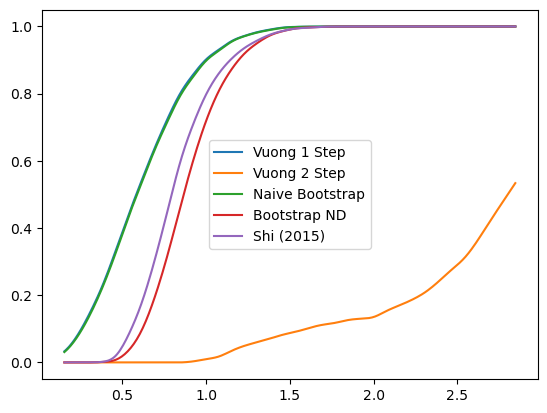

0.06324555320336758 0.00012180932094479097


In [11]:
nobs = 250
c1,c2 = calc_c(nobs)

mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)

Quantiles: 1th: 0.70, 5th: 1.83, 10th: 3.27, 30th: 9.52, 50th: 16.36, 70th: 24.76, 90th: 40.23, 95th: 47.66, 99th: 61.91
bonus term 3.291017751278609 // variance stats 19.154730432334837 //part1 66.32957562504915 //part2 20.154730432334837 19.154730432334837
1.506850671544896 -0.21062279033863893 5.1720058407314875
-5.075184831012322 -0.21062279033863893 -1.4100296618257302
---
Quantiles: 1th: 0.69, 5th: 1.79, 10th: 2.98, 30th: 8.71, 50th: 15.41, 70th: 23.56, 90th: 38.29, 95th: 45.44, 99th: 61.05
bonus term 1.6193564515669998 // variance stats 36.11142421917669 //part1 60.09662423616357 //part2 37.11142421917669 36.11142421917669
-0.1879629574731417 0.4480875373046958 3.466406400249192
-3.4266758606071415 0.4480875373046958 0.22769349711519266
---
Quantiles: 1th: 0.69, 5th: 2.10, 10th: 3.63, 30th: 11.01, 50th: 19.39, 70th: 29.79, 90th: 46.87, 95th: 55.04, 99th: 73.39
bonus term 2.56768271264924 // variance stats 34.05907431646614 //part1 90.02057904387506 //part2 35.05907431646614 34.0

Quantiles: 1th: 0.73, 5th: 1.78, 10th: 3.10, 30th: 8.84, 50th: 15.67, 70th: 23.80, 90th: 37.14, 95th: 44.82, 99th: 58.02
bonus term 6.68242011711453 // variance stats 7.458588480012044 //part1 56.52384182122569 //part2 8.458588480012043 7.458588480012044
4.880359899925513 -1.1651230590645123 8.421275377016014
-8.484480334303546 -1.1651230590645123 -4.943564857213046
---
Quantiles: 1th: 0.70, 5th: 2.00, 10th: 3.49, 30th: 10.09, 50th: 17.68, 70th: 27.25, 90th: 43.38, 95th: 51.26, 99th: 66.36
bonus term 5.170451081487618 // variance stats 13.91387454793486 //part1 77.11145878554046 //part2 14.91387454793486 13.91387454793486
3.387450580817666 -0.6289556659968258 7.094011093856754
-6.95345158215757 -0.6289556659968258 -3.2468910691184827
---
Quantiles: 1th: 0.64, 5th: 1.76, 10th: 3.22, 30th: 9.06, 50th: 15.63, 70th: 23.80, 90th: 38.37, 95th: 45.59, 99th: 60.67
bonus term 14.09998872198615 // variance stats 3.278700716676572 //part1 60.32963184989373 //part2 4.278700716676572 3.278700716676

Quantiles: 1th: 0.61, 5th: 1.71, 10th: 3.32, 30th: 9.31, 50th: 16.28, 70th: 25.32, 90th: 39.77, 95th: 46.98, 99th: 60.83
bonus term 1.195544610878107 // variance stats 53.220748250173926 //part1 64.82332336827399 //part2 54.22074825017393 53.220748250173926
-0.7726323997528077 0.829932515045316 3.1197175645641866
-3.1637216215090214 0.829932515045316 0.728628342807973
---
Quantiles: 1th: 0.72, 5th: 1.90, 10th: 3.27, 30th: 9.65, 50th: 16.71, 70th: 25.71, 90th: 41.07, 95th: 49.19, 99th: 66.94
bonus term 7.134942704472134 // variance stats 8.688581118669033 //part1 69.12747116933407 //part2 9.688581118669033 8.688581118669033
5.280391376386739 -1.1475858164522117 8.872581872261152
-8.989494032557529 -1.1475858164522117 -5.397303536683115
---
Quantiles: 1th: 0.70, 5th: 1.74, 10th: 3.07, 30th: 9.36, 50th: 16.56, 70th: 25.72, 90th: 40.70, 95th: 48.76, 99th: 64.93
bonus term 3.8248454899948503 // variance stats 16.746612840998022 //part1 67.87805208757597 //part2 17.746612840998022 16.7466128

Quantiles: 1th: 0.72, 5th: 1.73, 10th: 3.22, 30th: 9.39, 50th: 16.64, 70th: 25.69, 90th: 39.96, 95th: 47.21, 99th: 60.03
bonus term 3.7041191278016665 // variance stats 16.66920039402287 //part1 65.44882315246085 //part2 17.66920039402287 16.66920039402287
1.8865449664007046 -0.9697571389331652 5.514483655714586
-5.521693289202629 -0.9697571389331652 -1.8937545998887475
---
Quantiles: 1th: 0.62, 5th: 2.00, 10th: 3.41, 30th: 10.42, 50th: 18.20, 70th: 27.95, 90th: 44.33, 95th: 53.42, 99th: 68.35
bonus term 1.265113915085264 // variance stats 62.666109577895874 //part1 80.54488114633928 //part2 63.66610957789588 62.666109577895874
-0.6983390095825662 0.8577722023006289 3.1911301525342544
-3.228566839753094 0.8577722023006289 0.6609023223637267
---
Quantiles: 1th: 0.65, 5th: 1.75, 10th: 3.13, 30th: 8.69, 50th: 15.12, 70th: 23.49, 90th: 37.57, 95th: 44.96, 99th: 59.10
bonus term 3.116023410552164 // variance stats 17.569413252453842 //part1 57.86272641486377 //part2 18.569413252453842 17.56

Quantiles: 1th: 0.77, 5th: 1.77, 10th: 2.92, 30th: 8.50, 50th: 15.11, 70th: 22.62, 90th: 35.85, 95th: 43.26, 99th: 56.70
bonus term 0.8330247727237747 // variance stats 62.250571657204105 //part1 52.689293079391284 //part2 63.25057165720411 62.250571657204105
-1.0753970902580685 0.8193553490557146 3.075769848908201
-2.7414466357056178 0.8193553490557146 1.4097203034606514
---
Quantiles: 1th: 0.83, 5th: 1.95, 10th: 3.22, 30th: 9.02, 50th: 15.70, 70th: 24.45, 90th: 38.15, 95th: 45.27, 99th: 59.18
bonus term 2.9357559669863007 // variance stats 19.315328961806284 //part1 59.640848220912396 //part2 20.315328961806284 19.315328961806284
1.0220596931163601 -0.4641705722870884 4.8416260379708564
-4.849452240856241 -0.4641705722870884 -1.0298858960017447
---
Quantiles: 1th: 0.75, 5th: 1.95, 10th: 3.37, 30th: 9.95, 50th: 17.83, 70th: 27.92, 90th: 43.98, 95th: 52.23, 99th: 68.02
bonus term 3.339484774056621 // variance stats 22.740686106609267 //part1 79.28165977867921 //part2 23.740686106609267

Quantiles: 1th: 0.74, 5th: 2.04, 10th: 3.64, 30th: 10.61, 50th: 18.08, 70th: 27.40, 90th: 44.10, 95th: 52.34, 99th: 68.52
bonus term 6.151475457330596 // variance stats 11.959106070846937 //part1 79.71762294375885 //part2 12.959106070846936 11.959106070846937
4.1409718136562 -1.6897999274408646 7.997957780194466
-8.161979101004993 -1.6897999274408646 -4.304993134466726
---
Quantiles: 1th: 0.74, 5th: 1.85, 10th: 3.11, 30th: 9.36, 50th: 16.13, 70th: 25.28, 90th: 39.87, 95th: 47.15, 99th: 60.84
bonus term 1.7097597694118551 // variance stats 37.097593643183295 //part1 65.13773292251562 //part2 38.097593643183295 37.097593643183295
-0.2854704582272063 -0.3317802275093306 3.5252900281289317
-3.704989997050917 -0.3317802275093306 0.10577048930522147
---
Quantiles: 1th: 0.75, 5th: 1.88, 10th: 3.44, 30th: 10.03, 50th: 17.72, 70th: 27.64, 90th: 43.10, 95th: 50.88, 99th: 66.51
bonus term 6.88188966352457 // variance stats 10.063647588329935 //part1 76.13880197900632 //part2 11.063647588329935 10

Quantiles: 1th: 0.81, 5th: 2.03, 10th: 3.63, 30th: 10.10, 50th: 17.74, 70th: 27.00, 90th: 43.36, 95th: 51.16, 99th: 67.69
bonus term 7.793763681398152 // variance stats 8.886057750623076 //part1 77.04959784901084 //part2 9.886057750623076 8.886057750623076
6.028146931743013 -2.2651162482799525 9.519220945149268
-9.559380431053292 -2.2651162482799525 -6.068306417647037
---
Quantiles: 1th: 0.83, 5th: 1.90, 10th: 3.44, 30th: 10.15, 50th: 17.04, 70th: 26.16, 90th: 42.19, 95th: 50.67, 99th: 67.41
bonus term 6.304589681767092 // variance stats 10.569808008241864 //part1 72.94289218878792 //part2 11.569808008241866 10.569808008241864
4.498922008831672 -4.3034090830445155 8.103948690859951
-8.110257354702512 -4.3034090830445155 -4.505230672674231
---
Quantiles: 1th: 0.76, 5th: 1.78, 10th: 3.31, 30th: 9.37, 50th: 15.68, 70th: 24.04, 90th: 37.96, 95th: 45.78, 99th: 57.61
bonus term 1.261731105143721 // variance stats 45.813116902858766 //part1 59.0655657250662 //part2 46.81311690285877 45.813116

Quantiles: 1th: 0.71, 5th: 1.81, 10th: 3.14, 30th: 9.07, 50th: 15.60, 70th: 23.78, 90th: 37.57, 95th: 44.24, 99th: 57.76
bonus term 2.1772798122406485 // variance stats 25.577568316620138 //part1 57.86680295422369 //part2 26.577568316620138 25.577568316620138
0.26114585581431543 -1.5010459800088165 4.159067927105005
-4.093413768666982 -1.5010459800088165 -0.19549169737629235
---
Quantiles: 1th: 0.80, 5th: 2.14, 10th: 3.74, 30th: 11.08, 50th: 18.31, 70th: 27.80, 90th: 44.34, 95th: 52.91, 99th: 69.14
bonus term 10.219592749715963 // variance stats 6.884504016201659 //part1 80.57642007908086 //part2 7.884504016201659 6.884504016201659
8.305859142692514 -4.406366645430212 11.78816179878029
-12.133326356739412 -4.406366645430212 -8.651023700651635
---
Quantiles: 1th: 0.77, 5th: 1.95, 10th: 3.46, 30th: 9.83, 50th: 16.82, 70th: 26.12, 90th: 42.34, 95th: 50.44, 99th: 64.97
bonus term 2.759857963013592 // variance stats 25.621201998998682 //part1 73.47073632192986 //part2 26.621201998998682 25.

Quantiles: 1th: 0.82, 5th: 1.96, 10th: 3.42, 30th: 10.31, 50th: 17.50, 70th: 26.70, 90th: 42.67, 95th: 51.68, 99th: 68.01
bonus term 5.8917508091880695 // variance stats 11.66589849676301 //part1 74.62431771739742 //part2 12.66589849676301 11.66589849676301
4.114659705605219 -5.689599696911719 7.76665009417807
-7.66884191277092 -5.689599696911719 -4.016851524198069
---
Quantiles: 1th: 0.74, 5th: 1.88, 10th: 3.51, 30th: 9.81, 50th: 16.96, 70th: 26.01, 90th: 41.33, 95th: 49.29, 99th: 67.32
bonus term 4.537375742441122 // variance stats 14.43138627405867 //part1 70.01799775215268 //part2 15.43138627405867 14.43138627405867
2.669950692658266 -5.549646130487508 6.293337022975433
-6.404800792223978 -5.549646130487508 -2.781414461906811
---
Quantiles: 1th: 0.84, 5th: 1.84, 10th: 3.21, 30th: 9.54, 50th: 16.51, 70th: 25.53, 90th: 40.12, 95th: 47.78, 99th: 62.49
bonus term 2.1907716301190323 // variance stats 29.106105069048677 //part1 65.95560087865462 //part2 30.106105069048677 29.106105069048

Quantiles: 1th: 0.75, 5th: 1.84, 10th: 3.22, 30th: 9.64, 50th: 16.24, 70th: 25.11, 90th: 38.72, 95th: 46.56, 99th: 61.65
bonus term 3.3988430180096327 // variance stats 17.07844501515738 //part1 61.44579661623871 //part2 18.07844501515738 17.07844501515738
1.5706336702439445 -3.790331443779764 5.21895638397132
-5.227052365775321 -3.790331443779764 -1.5787296520479455
---
Quantiles: 1th: 0.88, 5th: 1.99, 10th: 3.36, 30th: 10.11, 50th: 17.89, 70th: 27.22, 90th: 43.61, 95th: 51.98, 99th: 67.20
bonus term 6.200577001929256 // variance stats 11.571051036841116 //part1 77.94776994911594 //part2 12.571051036841114 11.571051036841116
4.302308622003766 -6.036104358677527 7.902031517118387
-8.098845381854746 -6.036104358677527 -4.4991224867401245
---
Quantiles: 1th: 0.77, 5th: 1.89, 10th: 3.30, 30th: 9.48, 50th: 16.67, 70th: 25.21, 90th: 40.08, 95th: 47.03, 99th: 61.90
bonus term 4.067879224156302 // variance stats 15.183726844322466 //part1 65.83344619943999 //part2 16.183726844322468 15.183726

Quantiles: 1th: 0.72, 5th: 1.88, 10th: 3.19, 30th: 9.15, 50th: 15.73, 70th: 24.82, 90th: 39.31, 95th: 46.57, 99th: 59.75
bonus term 2.4562018996721116 // variance stats 24.79033015361123 //part1 63.34625791647083 //part2 25.79033015361123 24.79033015361123
0.5268002851128671 -3.202370546695793 4.459357201561025
-4.385603514231356 -3.202370546695793 -0.453046597783198
---
Quantiles: 1th: 0.79, 5th: 1.98, 10th: 3.57, 30th: 10.53, 50th: 18.69, 70th: 28.69, 90th: 45.49, 95th: 53.96, 99th: 71.74
bonus term 2.4765565381240404 // variance stats 33.23906388548501 //part1 84.7949775248446 //part2 34.23906388548501 33.23906388548501
0.5650597758729926 -2.5814711070297807 4.380186202095535
-4.388053300375089 -2.5814711070297807 -0.5729268741525462
---
Quantiles: 1th: 0.72, 5th: 1.83, 10th: 3.23, 30th: 9.54, 50th: 16.26, 70th: 25.10, 90th: 39.89, 95th: 47.54, 99th: 63.13
bonus term 2.522579282381444 // variance stats 24.852023118359376 //part1 65.21377792601949 //part2 25.852023118359376 24.852023

Quantiles: 1th: 0.75, 5th: 1.89, 10th: 3.44, 30th: 9.62, 50th: 16.73, 70th: 25.35, 90th: 41.43, 95th: 49.20, 99th: 64.27
bonus term 3.2576836142156473 // variance stats 20.596363840718155 //part1 70.35412061054683 //part2 21.596363840718155 20.596363840718155
1.397165099564867 -4.5240190349851455 5.030072481277642
-5.118202128866428 -4.5240190349851455 -1.4852947471536524
---
Quantiles: 1th: 0.68, 5th: 1.73, 10th: 3.01, 30th: 8.30, 50th: 14.79, 70th: 23.25, 90th: 36.62, 95th: 43.69, 99th: 56.51
bonus term 1.880043956962034 // variance stats 28.231417702744956 //part1 54.95635020547868 //part2 29.231417702744956 28.231417702744956
-0.2823999748991733 -4.269946769084912 3.76906445399186
-4.042487888823241 -4.269946769084912 0.008976540067791514
---
Quantiles: 1th: 0.66, 5th: 1.88, 10th: 3.32, 30th: 9.96, 50th: 18.17, 70th: 28.18, 90th: 43.95, 95th: 52.24, 99th: 67.75
bonus term 1.5906751875427303 // variance stats 48.78128795700145 //part1 79.18585955712196 //part2 49.78128795700146 48.7

Quantiles: 1th: 0.79, 5th: 1.88, 10th: 3.14, 30th: 9.31, 50th: 16.30, 70th: 25.49, 90th: 40.36, 95th: 48.07, 99th: 63.67
bonus term 1.4094593461604288 // variance stats 46.378419061118265 //part1 66.77795555199856 //part2 47.37841906111827 46.378419061118265
-0.4317782919975265 -1.895292103047548 3.4733476202342293
-3.2506969843183837 -1.895292103047548 0.6544289279133717
---
Quantiles: 1th: 0.71, 5th: 1.82, 10th: 3.09, 30th: 9.31, 50th: 15.96, 70th: 24.43, 90th: 39.31, 95th: 46.76, 99th: 61.04
bonus term 3.7813543916544994 // variance stats 15.745481555611303 //part1 63.32060022068021 //part2 16.745481555611303 15.745481555611303
1.8763200408633185 -7.333640167745771 5.67901425408004
-5.68638874244568 -7.333640167745771 -1.8836945292289582
---
Quantiles: 1th: 0.79, 5th: 2.19, 10th: 3.95, 30th: 11.54, 50th: 19.85, 70th: 30.68, 90th: 48.08, 95th: 57.87, 99th: 77.20
bonus term 5.213907925992653 // variance stats 17.17280947619005 //part1 94.75135536546168 //part2 18.17280947619005 17.172

Quantiles: 1th: 0.78, 5th: 1.83, 10th: 2.89, 30th: 8.41, 50th: 14.66, 70th: 22.56, 90th: 35.83, 95th: 41.79, 99th: 56.14
bonus term 2.7602811656658934 // variance stats 18.06417282198355 //part1 52.62247717952079 //part2 19.06417282198355 18.06417282198355
0.8719834322368538 -7.835056242585528 4.665552726089183
-4.648578899094933 -7.835056242585528 -0.8550096052426032
---
Quantiles: 1th: 0.83, 5th: 1.98, 10th: 3.34, 30th: 9.97, 50th: 17.34, 70th: 26.86, 90th: 42.70, 95th: 51.14, 99th: 67.21
bonus term 3.490599094201193 // variance stats 20.40850807009168 //part1 74.72851887766095 //part2 21.40850807009168 20.40850807009168
1.3527951106710217 -7.261753774254963 5.47087728596093
-5.628403077731365 -7.261753774254963 -1.510320902441456
---
Quantiles: 1th: 0.76, 5th: 1.79, 10th: 3.16, 30th: 9.54, 50th: 16.39, 70th: 25.36, 90th: 40.52, 95th: 48.14, 99th: 61.87
bonus term 2.9223347265268886 // variance stats 22.027452932832887 //part1 67.29392536908101 //part2 23.02745293283289 22.0274529328

Quantiles: 1th: 0.74, 5th: 1.80, 10th: 3.06, 30th: 8.62, 50th: 15.22, 70th: 23.06, 90th: 36.53, 95th: 43.74, 99th: 56.43
bonus term 2.8088459184346215 // variance stats 18.472340897128163 //part1 54.69480525126598 //part2 19.472340897128163 18.472340897128163
0.7189535481454834 -9.73207227233003 4.689678931549414
-4.898738288723759 -9.73207227233003 -0.9280129053198286
---
Quantiles: 1th: 0.72, 5th: 1.97, 10th: 3.36, 30th: 9.90, 50th: 17.54, 70th: 27.07, 90th: 43.08, 95th: 50.51, 99th: 66.52
bonus term 3.322915230455252 // variance stats 21.88663714489823 //part1 76.05035514268522 //part2 22.88663714489823 21.88663714489823
1.4847752730396597 -7.697541829751837 5.126908431620148
-5.161055187870844 -7.697541829751837 -1.518922029290355
---
Quantiles: 1th: 0.74, 5th: 1.78, 10th: 2.97, 30th: 8.64, 50th: 15.53, 70th: 23.75, 90th: 37.97, 95th: 45.13, 99th: 59.89
bonus term 2.4409030474934963 // variance stats 23.205338288625935 //part1 59.082883994318045 //part2 24.205338288625935 23.205338

Quantiles: 1th: 0.72, 5th: 1.85, 10th: 3.24, 30th: 9.94, 50th: 16.86, 70th: 26.11, 90th: 41.60, 95th: 50.22, 99th: 63.98
bonus term 1.6426031790348987 // variance stats 42.18463865351504 //part1 70.93522473773716 //part2 43.18463865351504 42.18463865351504
-0.3539140080189945 -4.939072631866249 3.463047833003166
-3.639120366088792 -4.939072631866249 0.17784147493336847
---
Quantiles: 1th: 0.76, 5th: 1.91, 10th: 3.28, 30th: 9.04, 50th: 15.60, 70th: 24.18, 90th: 38.30, 95th: 45.35, 99th: 59.06
bonus term 1.7726605871372965 // variance stats 32.92486331734321 //part1 60.13726812667414 //part2 33.92486331734321 32.92486331734321
-0.1967338477926214 -5.356514600913643 3.890030926861204
-3.742055022067214 -5.356514600913643 0.3447097525866111
---
Quantiles: 1th: 0.78, 5th: 2.04, 10th: 3.57, 30th: 10.35, 50th: 17.80, 70th: 27.33, 90th: 43.12, 95th: 51.49, 99th: 68.51
bonus term 3.353072690859508 // variance stats 21.724780805135083 //part1 76.19784192346678 //part2 22.724780805135083 21.72478

Quantiles: 1th: 0.76, 5th: 1.89, 10th: 3.29, 30th: 9.16, 50th: 16.29, 70th: 25.11, 90th: 39.17, 95th: 46.79, 99th: 61.79
bonus term 2.7158985798616215 // variance stats 22.15155690852054 //part1 62.87728052943645 //part2 23.151556908520543 22.15155690852054
0.6868653495998015 -9.437092304769076 4.720539941275948
-4.7449318101234415 -9.437092304769076 -0.7112572184472951
---
Quantiles: 1th: 0.76, 5th: 1.93, 10th: 3.38, 30th: 10.26, 50th: 17.46, 70th: 27.06, 90th: 42.11, 95th: 50.06, 99th: 66.43
bonus term 2.3877009500687 // variance stats 29.442116652269757 //part1 72.68667085272668 //part2 30.442116652269757 29.442116652269757
0.3036648921880469 -7.452912484361859 4.285955584661559
-4.471737007949353 -7.452912484361859 -0.4894463154758407
---
Quantiles: 1th: 0.76, 5th: 2.00, 10th: 3.42, 30th: 11.02, 50th: 19.38, 70th: 28.74, 90th: 46.41, 95th: 55.26, 99th: 71.21
bonus term 4.446525327976323 // variance stats 18.856084041721257 //part1 88.29058060594002 //part2 19.856084041721257 18.856

Quantiles: 1th: 0.70, 5th: 1.89, 10th: 3.40, 30th: 9.62, 50th: 16.84, 70th: 25.72, 90th: 40.57, 95th: 49.17, 99th: 64.41
bonus term 3.003175592592371 // variance stats 21.46360795342852 //part1 67.4621591273004 //part2 22.463607953428525 21.46360795342852
1.1171545662619689 -10.884737043100998 4.93564427409596
-4.889196618922773 -10.884737043100998 -1.0707069110887815
---
Quantiles: 1th: 0.61, 5th: 1.78, 10th: 2.99, 30th: 8.36, 50th: 14.78, 70th: 22.52, 90th: 36.55, 95th: 43.40, 99th: 57.19
bonus term 1.751487634506063 // variance stats 30.258600489148346 //part1 54.74905222870849 //part2 31.258600489148346 30.258600489148346
-0.12096801264531956 -7.7003994020865365 3.7107424987756703
-3.6239432816574455 -7.7003994020865365 0.20776722976354434
---
Quantiles: 1th: 0.71, 5th: 1.89, 10th: 3.69, 30th: 10.25, 50th: 17.72, 70th: 27.99, 90th: 45.22, 95th: 53.50, 99th: 71.72
bonus term 1.7043187546904839 // variance stats 48.17994021819473 //part1 83.81829446842609 //part2 49.17994021819474 48

Quantiles: 1th: 0.66, 5th: 1.65, 10th: 2.66, 30th: 8.21, 50th: 14.05, 70th: 21.87, 90th: 35.07, 95th: 42.36, 99th: 55.97
bonus term 1.5605089783903507 // variance stats 31.30637181001456 //part1 50.414383268744636 //part2 32.30637181001456 31.30637181001456
-0.5918614498074025 -8.908592223794322 3.589987343532324
-3.7128794065881037 -8.908592223794322 0.468969386751623
---
Quantiles: 1th: 0.75, 5th: 1.73, 10th: 2.95, 30th: 8.68, 50th: 15.35, 70th: 24.26, 90th: 37.33, 95th: 45.34, 99th: 57.99
bonus term 2.0250007623012327 // variance stats 27.2027619308086 //part1 57.11061440888759 //part2 28.2027619308086 27.2027619308086
-0.12464793521438422 -10.88877429894464 4.094323590478311
-4.174649459816849 -10.88877429894464 0.04432206587584609
---
Quantiles: 1th: 0.73, 5th: 1.77, 10th: 3.08, 30th: 9.46, 50th: 16.51, 70th: 24.79, 90th: 40.36, 95th: 47.69, 99th: 62.94
bonus term 2.2012037317448074 // variance stats 29.32367229126801 //part1 66.74858060774577 //part2 30.32367229126801 29.32367229

Quantiles: 1th: 0.80, 5th: 1.93, 10th: 3.44, 30th: 10.13, 50th: 17.61, 70th: 26.80, 90th: 42.36, 95th: 50.56, 99th: 66.12
bonus term 2.1342750672871684 // variance stats 33.45736439824531 //part1 73.5414937196035 //part2 34.45736439824531 33.45736439824531
-0.10315719034882695 -9.197968371712477 4.149447421489184
-4.371707324923164 -9.197968371712477 -0.11910271308515245
---
Quantiles: 1th: 0.71, 5th: 1.78, 10th: 3.04, 30th: 8.98, 50th: 15.79, 70th: 24.49, 90th: 38.20, 95th: 46.40, 99th: 59.99
bonus term 1.670208847894249 // variance stats 34.81556731428997 //part1 59.81947742067918 //part2 35.81556731428997 34.81556731428997
-0.4045080138890279 -6.928473550747476 3.7237985540339418
-3.7449257096775255 -6.928473550747476 0.3833808582454442
---
Quantiles: 1th: 0.76, 5th: 1.87, 10th: 3.27, 30th: 10.54, 50th: 18.91, 70th: 29.16, 90th: 45.22, 95th: 53.93, 99th: 70.86
bonus term 3.057112260820924 // variance stats 26.4097978231663 //part1 83.79482899182437 //part2 27.4097978231663 26.409797

Quantiles: 1th: 0.74, 5th: 1.88, 10th: 3.49, 30th: 9.62, 50th: 16.46, 70th: 25.37, 90th: 40.45, 95th: 48.17, 99th: 63.98
bonus term 1.4337745733707987 // variance stats 45.7759386863435 //part1 67.0661515340308 //part2 46.77593868634351 45.7759386863435
-0.516145787628941 -6.382682433894649 3.338660557121547
-3.383694934370538 -6.382682433894649 0.4711114103799498
---
Quantiles: 1th: 0.83, 5th: 1.94, 10th: 3.36, 30th: 9.76, 50th: 17.06, 70th: 26.27, 90th: 41.38, 95th: 49.21, 99th: 66.11
bonus term 2.434530030125779 // variance stats 27.831382048693488 //part1 70.1908654075736 //part2 28.831382048693488 27.831382048693488
0.49815348352310845 -10.750182754046632 4.3481156623873725
-4.37090657672845 -10.750182754046632 -0.5209443978641852
---
Quantiles: 1th: 0.71, 5th: 1.75, 10th: 3.05, 30th: 8.38, 50th: 14.75, 70th: 22.35, 90th: 35.20, 95th: 42.24, 99th: 55.14
bonus term 1.7343908411917286 // variance stats 28.27956341797995 //part1 50.78220662623681 //part2 29.27956341797995 28.27956341

Quantiles: 1th: 0.80, 5th: 1.88, 10th: 3.14, 30th: 9.18, 50th: 15.94, 70th: 25.28, 90th: 39.56, 95th: 47.50, 99th: 63.71
bonus term 2.231885566278664 // variance stats 27.742901477299824 //part1 64.15086694015517 //part2 28.742901477299824 27.742901477299824
0.2862253455017117 -12.329031700239096 4.084050817872076
-4.1775457870556165 -12.329031700239096 -0.3797203146852522
---
Quantiles: 1th: 0.75, 5th: 1.80, 10th: 2.99, 30th: 9.05, 50th: 15.95, 70th: 24.29, 90th: 38.52, 95th: 46.16, 99th: 61.35
bonus term 0.9905449269742046 // variance stats 60.40798048364696 //part1 60.82736354380745 //part2 61.407980483646966 60.40798048364696
-0.762801827392102 -5.397585038084345 2.9855864504317458
-2.7438916813405116 -5.397585038084345 1.0044965964833366
---
Quantiles: 1th: 0.80, 5th: 2.01, 10th: 3.52, 30th: 10.42, 50th: 17.97, 70th: 27.74, 90th: 44.26, 95th: 53.78, 99th: 72.32
bonus term 2.049342428981324 // variance stats 38.175121890628404 //part1 80.28323945097985 //part2 39.175121890628404 38

Quantiles: 1th: 0.67, 5th: 1.91, 10th: 3.23, 30th: 9.46, 50th: 16.15, 70th: 24.50, 90th: 39.84, 95th: 47.34, 99th: 61.38
bonus term 2.0035244731522686 // variance stats 31.46283255984624 //part1 65.04007950149625 //part2 32.46283255984624 31.46283255984624
-0.1767203269261289 -13.166613267058004 3.9211819274380915
-4.1837692732306655 -13.166613267058004 -0.08586701886644549
---
Quantiles: 1th: 0.65, 5th: 1.99, 10th: 3.53, 30th: 9.99, 50th: 17.59, 70th: 26.97, 90th: 42.10, 95th: 50.45, 99th: 67.07
bonus term 1.9746567408977909 // variance stats 35.77980143167228 //part1 72.62748282593388 //part2 36.77980143167228 35.77980143167228
-0.27043031096431197 -11.446618341714622 3.939461953042897
-4.2197437927598935 -11.446618341714622 -0.009851528752684342
---
Quantiles: 1th: 0.75, 5th: 1.84, 10th: 3.34, 30th: 9.34, 50th: 16.45, 70th: 25.22, 90th: 39.74, 95th: 47.30, 99th: 64.05
bonus term 1.2216289143682966 // variance stats 51.981977001668824 //part1 64.72431504563475 //part2 52.981977001668

Quantiles: 1th: 0.76, 5th: 1.97, 10th: 3.56, 30th: 10.12, 50th: 17.95, 70th: 27.67, 90th: 42.82, 95th: 51.68, 99th: 66.42
bonus term 1.9540195785328973 // variance stats 37.455844376551234 //part1 75.14347282079532 //part2 38.455844376551234 37.455844376551234
0.02273426792666107 -11.585360801217456 3.910983719167136
-3.8853048891391335 -11.585360801217456 0.0029445621013412812
---
Quantiles: 1th: 0.61, 5th: 1.61, 10th: 2.83, 30th: 8.36, 50th: 14.83, 70th: 23.36, 90th: 37.06, 95th: 44.01, 99th: 58.24
bonus term 0.9149681698222948 // variance stats 60.53659921799135 //part1 56.30402956357359 //part2 61.53659921799136 60.53659921799135
-1.1412990260674047 -6.945160296958072 2.914222767776943
-2.9712353657119945 -6.945160296958072 1.084286428132353
---
Quantiles: 1th: 0.70, 5th: 1.87, 10th: 3.12, 30th: 9.15, 50th: 16.08, 70th: 24.74, 90th: 38.56, 95th: 46.67, 99th: 61.44
bonus term 1.5919628367390426 // variance stats 37.28141356270449 //part1 60.9425877296635 //part2 38.28141356270449 37

Quantiles: 1th: 0.77, 5th: 1.91, 10th: 3.46, 30th: 10.10, 50th: 18.09, 70th: 27.43, 90th: 43.22, 95th: 51.10, 99th: 67.36
bonus term 1.903394814242931 // variance stats 39.22000521826161 //part1 76.55454936126277 //part2 40.22000521826161 39.22000521826161
-0.3251841230300509 -12.317185072193363 3.9776252334563513
-4.131973751515913 -12.317185072193363 0.1708356049704891
---
Quantiles: 1th: 0.79, 5th: 1.75, 10th: 3.12, 30th: 9.19, 50th: 15.71, 70th: 24.05, 90th: 38.88, 95th: 47.14, 99th: 61.13
bonus term 1.818504050862223 // variance stats 33.0713738001857 //part1 61.958931274078694 //part2 34.0713738001857 33.0713738001857
-0.3313892245568362 -14.459565345271262 3.8685473138519675
-3.968397326281282 -14.459565345271262 0.2315392121275217
---
Quantiles: 1th: 0.69, 5th: 1.78, 10th: 3.11, 30th: 8.94, 50th: 16.37, 70th: 24.78, 90th: 39.37, 95th: 46.72, 99th: 62.89
bonus term 1.3628031030662007 // variance stats 45.606590735207504 //part1 63.51560647727723 //part2 46.60659073520751 45.6065

Quantiles: 1th: 0.68, 5th: 1.89, 10th: 3.25, 30th: 9.21, 50th: 16.44, 70th: 25.64, 90th: 41.49, 95th: 49.13, 99th: 65.41
bonus term 2.1184257759677463 // variance stats 32.30122822746901 //part1 70.54618024845504 //part2 33.30122822746901 32.30122822746901
-0.27070070581327965 -15.601442406531776 4.370840691232604
-4.507552257748772 -15.601442406531776 0.13398913929711126
---
Quantiles: 1th: 0.68, 5th: 2.02, 10th: 3.73, 30th: 10.79, 50th: 18.85, 70th: 28.83, 90th: 47.06, 95th: 55.98, 99th: 72.05
bonus term 2.638764314965513 // variance stats 33.392592491536014 //part1 90.75394576581607 //part2 34.392592491536014 33.392592491536014
0.313750533909224 -15.784108838847516 4.789852352994703
-4.9637780960218025 -15.784108838847516 -0.48767627693632387
---
Quantiles: 1th: 0.66, 5th: 1.72, 10th: 3.12, 30th: 9.59, 50th: 16.33, 70th: 25.20, 90th: 40.29, 95th: 47.16, 99th: 61.89
bonus term 2.0066112631865147 // variance stats 32.16125355854728 //part1 66.54174489196487 //part2 33.16125355854728 3

Quantiles: 1th: 0.78, 5th: 1.90, 10th: 3.18, 30th: 9.34, 50th: 16.57, 70th: 24.93, 90th: 38.85, 95th: 46.74, 99th: 62.07
bonus term 1.2756421616489082 // variance stats 47.49105528661007 //part1 61.857234586448 //part2 48.49105528661008 47.49105528661007
-0.8307430026909501 -13.130232110585146 3.294397335419234
-3.3820273259887665 -13.130232110585146 0.7431130121214181
---
Quantiles: 1th: 0.74, 5th: 1.90, 10th: 3.29, 30th: 9.94, 50th: 16.96, 70th: 26.62, 90th: 42.13, 95th: 50.42, 99th: 65.97
bonus term 1.518779849409902 // variance stats 46.895861603310266 //part1 72.74326947323307 //part2 47.89586160331027 46.895861603310266
-0.6982301297327743 -11.95855733164585 3.464327102484953
-3.735789828552578 -11.95855733164585 0.42676740366514887
---
Quantiles: 1th: 0.65, 5th: 1.96, 10th: 3.51, 30th: 10.39, 50th: 18.08, 70th: 27.57, 90th: 44.86, 95th: 53.38, 99th: 68.32
bonus term 1.7728181377539598 // variance stats 45.533685666839865 //part1 82.49576196671518 //part2 46.533685666839865 45.53

Quantiles: 1th: 0.73, 5th: 1.91, 10th: 3.40, 30th: 9.68, 50th: 16.67, 70th: 25.37, 90th: 40.01, 95th: 47.53, 99th: 62.91
bonus term 1.369153078373355 // variance stats 46.9233971443354 //part1 65.61446672627567 //part2 47.923397144335404 46.9233971443354
-0.76190873199824 -13.11287421569841 3.468622582974451
-3.50021488874495 -13.11287421569841 0.7303164262277413
---
Quantiles: 1th: 0.75, 5th: 2.02, 10th: 3.45, 30th: 9.81, 50th: 16.57, 70th: 25.68, 90th: 40.53, 95th: 48.57, 99th: 63.48
bonus term 1.3828877448117687 // variance stats 47.68308402316265 //part1 67.32324027527324 //part2 48.68308402316265 47.68308402316265
-0.6582659415720454 -13.576655900823216 3.261590620363379
-3.424041431195583 -13.576655900823216 0.4958151307398411
---
Quantiles: 1th: 0.81, 5th: 1.87, 10th: 3.32, 30th: 9.74, 50th: 17.59, 70th: 26.43, 90th: 42.15, 95th: 49.97, 99th: 64.79
bonus term 1.306326744745972 // variance stats 54.737942023739464 //part1 72.81196436271128 //part2 55.737942023739464 54.7379420237

Quantiles: 1th: 0.84, 5th: 2.00, 10th: 3.54, 30th: 10.89, 50th: 19.29, 70th: 29.96, 90th: 45.99, 95th: 53.80, 99th: 70.98
bonus term 1.9097065493608016 // variance stats 44.39407088668154 //part1 86.68935447444422 //part2 45.39407088668154 44.39407088668154
-0.23007373127160535 -15.539642545160628 3.7590772081160733
-4.049486829993209 -15.539642545160628 -0.06033589060552993
---
Quantiles: 1th: 0.73, 5th: 1.87, 10th: 3.19, 30th: 9.56, 50th: 16.64, 70th: 25.47, 90th: 40.27, 95th: 48.60, 99th: 63.84
bonus term 0.9265722474911562 // variance stats 70.74778607673832 //part1 66.47950739763812 //part2 71.74778607673832 70.74778607673832
-1.1345890191491186 -9.547781378489303 2.9318865686596443
-2.9877335141314307 -9.547781378489303 1.0787420736773317
---
Quantiles: 1th: 0.83, 5th: 2.08, 10th: 3.67, 30th: 10.22, 50th: 17.59, 70th: 26.78, 90th: 42.22, 95th: 50.13, 99th: 66.12
bonus term 1.5023541702252414 // variance stats 47.62035593325863 //part1 73.04499449416666 //part2 48.62035593325864 4

Quantiles: 1th: 0.73, 5th: 1.87, 10th: 3.41, 30th: 9.91, 50th: 17.33, 70th: 26.74, 90th: 41.04, 95th: 48.86, 99th: 65.00
bonus term 1.488639820369501 // variance stats 45.37909132790065 //part1 69.04176218326671 //part2 46.37909132790065 45.37909132790065
-0.7652969600422936 -16.48951064681966 3.5112446711632046
-3.742576600781296 -16.48951064681966 0.5339650304242021
---
Quantiles: 1th: 0.73, 5th: 1.71, 10th: 3.01, 30th: 9.08, 50th: 16.03, 70th: 24.50, 90th: 38.38, 95th: 45.60, 99th: 58.99
bonus term 1.4888499858804212 // variance stats 39.55798831428058 //part1 60.38476032905492 //part2 40.55798831428058 39.55798831428058
-1.0061489140086377 -18.182437213325247 3.74447687973899
-3.98384888576948 -18.182437213325247 0.7667769079781478
---
Quantiles: 1th: 0.71, 5th: 1.95, 10th: 3.51, 30th: 10.61, 50th: 18.17, 70th: 27.73, 90th: 44.69, 95th: 53.30, 99th: 68.63
bonus term 2.2151336584606165 // variance stats 35.9588894536021 //part1 81.86888000799911 //part2 36.9588894536021 35.958889453

Quantiles: 1th: 0.73, 5th: 1.90, 10th: 3.27, 30th: 9.67, 50th: 16.99, 70th: 27.00, 90th: 41.46, 95th: 49.61, 99th: 63.32
bonus term 1.5782912856262545 // variance stats 43.64085171885016 //part1 70.45626725079501 //part2 44.64085171885016 43.64085171885016
-0.7118291481547757 -17.639685647090673 3.7527629451279982
-3.8684117194072845 -17.639685647090673 0.5961803738754894
---
Quantiles: 1th: 0.71, 5th: 1.58, 10th: 3.06, 30th: 9.09, 50th: 15.98, 70th: 24.61, 90th: 39.54, 95th: 47.01, 99th: 62.31
bonus term 1.7466861512924499 // variance stats 35.685810886949476 //part1 64.07859782516843 //part2 36.685810886949476 35.685810886949476
-0.4775111570499606 -19.4499199121836 3.8962450615909634
-3.9708834596348606 -19.4499199121836 0.40287275900606356
---
Quantiles: 1th: 0.82, 5th: 1.96, 10th: 3.49, 30th: 10.08, 50th: 17.79, 70th: 27.48, 90th: 43.27, 95th: 51.75, 99th: 66.76
bonus term 1.902579331370196 // variance stats 39.33532898911081 //part1 76.74116325869933 //part2 40.33532898911081 39.

Quantiles: 1th: 0.77, 5th: 1.94, 10th: 3.40, 30th: 9.81, 50th: 17.49, 70th: 26.48, 90th: 41.89, 95th: 49.79, 99th: 67.23
bonus term 1.1686605834593404 // variance stats 60.53762148592218 //part1 71.91659263043786 //part2 61.53762148592219 60.53762148592218
-1.0829298896570505 -13.744820801130652 3.116272648333381
-3.420251056575731 -13.744820801130652 0.7789514814147002
---
Quantiles: 1th: 0.74, 5th: 1.86, 10th: 3.16, 30th: 9.36, 50th: 15.85, 70th: 24.51, 90th: 38.46, 95th: 46.31, 99th: 59.17
bonus term 1.4014894804683036 // variance stats 42.259184784978125 //part1 60.627292409781326 //part2 43.259184784978125 42.259184784978125
-0.9421274366940455 -19.758686720367347 3.535379893123602
-3.7451063976306527 -19.758686720367347 0.7324009321869946
---
Quantiles: 1th: 0.72, 5th: 1.90, 10th: 3.18, 30th: 9.94, 50th: 17.15, 70th: 26.22, 90th: 42.54, 95th: 50.98, 99th: 67.17
bonus term 1.8930682906746064 // variance stats 38.178625212890466 //part1 74.16781306274758 //part2 39.178625212890466 

Quantiles: 1th: 0.69, 5th: 1.85, 10th: 3.29, 30th: 9.90, 50th: 17.69, 70th: 26.79, 90th: 42.69, 95th: 51.00, 99th: 66.27
bonus term 1.5021089684939004 // variance stats 48.72635688238744 //part1 74.69440664356256 //part2 49.72635688238744 48.72635688238744
-0.8844461700839952 -19.464265866459918 3.558711998105988
-3.8886641070717958 -19.464265866459918 0.5544940611181869
---
Quantiles: 1th: 0.71, 5th: 1.83, 10th: 3.34, 30th: 9.53, 50th: 16.93, 70th: 25.40, 90th: 40.47, 95th: 48.51, 99th: 63.32
bonus term 1.4602072299704427 // variance stats 44.960593873827875 //part1 67.1119914682987 //part2 45.96059387382788 44.960593873827875
-0.8333886469410506 -20.163062145843885 3.6753955901112043
-3.753803106881936 -20.163062145843885 0.7549811301703189
---
Quantiles: 1th: 0.65, 5th: 1.79, 10th: 3.25, 30th: 9.77, 50th: 17.04, 70th: 25.80, 90th: 40.32, 95th: 48.60, 99th: 61.81
bonus term 1.1492853915832952 // variance stats 56.98722946192373 //part1 66.64387571897741 //part2 57.98722946192373 56.9

Quantiles: 1th: 0.66, 5th: 1.86, 10th: 3.40, 30th: 9.41, 50th: 16.48, 70th: 25.09, 90th: 39.68, 95th: 46.90, 99th: 61.29
bonus term 1.3104594838752035 // variance stats 48.24133929095523 //part1 64.52878007254897 //part2 49.24133929095524 48.24133929095523
-0.7714489135258694 -19.046571551296555 3.2590483714768363
-3.3923678812762765 -19.046571551296555 0.6381294037264293
---
Quantiles: 1th: 0.72, 5th: 1.83, 10th: 3.23, 30th: 9.11, 50th: 16.34, 70th: 25.10, 90th: 39.76, 95th: 47.36, 99th: 63.44
bonus term 1.3927610499269432 // variance stats 45.51962666915791 //part1 64.7907240819458 //part2 46.51962666915791 45.51962666915791
-0.763570377249434 -18.558269696739373 3.4054741459615876
-3.5490924771033203 -18.558269696739373 0.6199520461077014
---
Quantiles: 1th: 0.82, 5th: 1.93, 10th: 3.33, 30th: 9.86, 50th: 17.45, 70th: 27.10, 90th: 43.14, 95th: 51.34, 99th: 67.54
bonus term 1.5722072787170962 // variance stats 47.525019535981116 //part1 76.2913889143588 //part2 48.52501953598112 47.52

Quantiles: 1th: 0.74, 5th: 1.99, 10th: 3.43, 30th: 10.49, 50th: 18.12, 70th: 27.89, 90th: 44.43, 95th: 52.59, 99th: 68.69
bonus term 1.5075846453467845 // variance stats 52.67477032460554 //part1 80.91925958389055 //part2 53.67477032460555 52.67477032460554
-0.9252858278649628 -18.54633255403074 3.7172622281993366
-3.940455118558532 -18.54633255403074 0.7020929375057675
---
Quantiles: 1th: 0.73, 5th: 1.92, 10th: 3.29, 30th: 9.73, 50th: 17.07, 70th: 26.11, 90th: 41.08, 95th: 48.72, 99th: 64.44
bonus term 1.2963152361587729 // variance stats 52.363762586087255 //part1 69.17625849910439 //part2 53.36376258608726 52.363762586087255
-0.9825999366761023 -17.827189333198252 3.2556099375179617
-3.575230408993648 -17.827189333198252 0.6629794652004162
---
Quantiles: 1th: 0.67, 5th: 1.72, 10th: 3.15, 30th: 9.06, 50th: 16.09, 70th: 25.66, 90th: 40.74, 95th: 47.31, 99th: 62.92
bonus term 1.3277119753271491 // variance stats 50.241548716131554 //part1 68.03401786471737 //part2 51.24154871613156 50.

Quantiles: 1th: 0.72, 5th: 1.92, 10th: 3.27, 30th: 9.20, 50th: 16.42, 70th: 24.77, 90th: 40.01, 95th: 48.08, 99th: 61.53
bonus term 1.0101338679781322 // variance stats 63.943807873481326 //part1 65.60193984846836 //part2 64.94380787348133 63.943807873481326
-1.092683054975351 -16.54565890417064 2.957366610869493
-3.1129507909316154 -16.54565890417064 0.937098874913229
---
Quantiles: 1th: 0.70, 5th: 1.93, 10th: 3.30, 30th: 9.91, 50th: 17.61, 70th: 27.02, 90th: 43.17, 95th: 51.51, 99th: 66.40
bonus term 1.5768069759459273 // variance stats 47.452586863770975 //part1 76.40037696942008 //part2 48.45258686377098 47.452586863770975
-0.7671413229879448 -22.515517177519154 3.7741440951421086
-3.920755274879799 -22.515517177519154 0.6205301432502541
---
Quantiles: 1th: 0.73, 5th: 1.76, 10th: 2.97, 30th: 8.59, 50th: 14.87, 70th: 23.19, 90th: 37.26, 95th: 44.07, 99th: 56.89
bonus term 0.9447874841176237 // variance stats 59.21649524125033 //part1 56.89179104136175 //part2 60.21649524125033 59.21

Quantiles: 1th: 0.73, 5th: 1.84, 10th: 3.22, 30th: 10.31, 50th: 18.15, 70th: 28.11, 90th: 45.57, 95th: 54.52, 99th: 72.35
bonus term 1.5420969540776786 // variance stats 54.18751998765258 //part1 85.10450647606005 //part2 55.18751998765258 54.18751998765258
-0.766656313194886 -19.579170545477524 3.68417041171255
-3.8508502213502434 -19.579170545477524 0.5999765035571931
---
Quantiles: 1th: 0.68, 5th: 1.81, 10th: 3.12, 30th: 8.45, 50th: 15.03, 70th: 23.27, 90th: 36.35, 95th: 43.19, 99th: 56.90
bonus term 0.9743598755887839 // variance stats 54.584228360216265 //part1 54.15904182975887 //part2 55.584228360216265 54.584228360216265
-1.524277527837113 -21.829789406174456 3.1846508401015714
-3.472997279014681 -21.829789406174456 1.2359310889240034
---
Quantiles: 1th: 0.73, 5th: 1.90, 10th: 3.24, 30th: 8.98, 50th: 15.70, 70th: 24.10, 90th: 37.94, 95th: 44.57, 99th: 57.35
bonus term 1.177267251339928 // variance stats 49.10528042470934 //part1 58.98730576321387 //part2 50.10528042470935 49.10

Quantiles: 1th: 0.70, 5th: 1.82, 10th: 3.04, 30th: 8.43, 50th: 14.67, 70th: 22.76, 90th: 36.32, 95th: 43.36, 99th: 55.07
bonus term 0.851719290467426 // variance stats 62.47437622331286 //part1 54.06235067978248 //part2 63.47437622331286 62.47437622331286
-1.289400722436894 -18.770067608177204 2.987120436163824
-2.9928393033717464 -18.770067608177204 1.2836818552289717
---
Quantiles: 1th: 0.74, 5th: 1.89, 10th: 3.21, 30th: 9.50, 50th: 17.39, 70th: 26.76, 90th: 42.68, 95th: 50.08, 99th: 65.12
bonus term 1.1329629804563728 // variance stats 64.88713755870162 //part1 74.64768774224562 //part2 65.88713755870162 64.88713755870162
-1.1706362746185524 -17.819656339248056 3.1156780802209414
-3.4365622355312984 -17.819656339248056 0.8497521193081954
---
Quantiles: 1th: 0.73, 5th: 1.87, 10th: 3.32, 30th: 9.50, 50th: 16.64, 70th: 25.42, 90th: 39.96, 95th: 47.50, 99th: 63.16
bonus term 1.2543026954353935 // variance stats 51.16476325731548 //part1 65.43040316039998 //part2 52.164763257315485 51.16

Quantiles: 1th: 0.76, 5th: 2.03, 10th: 3.77, 30th: 10.62, 50th: 18.18, 70th: 27.62, 90th: 44.29, 95th: 53.29, 99th: 67.02
bonus term 1.4995838279037974 // variance stats 52.60745523653914 //part1 80.38887292779083 //part2 53.607455236539145 52.60745523653914
-0.7238511803911506 -25.128583807854273 3.564145098158202
-3.7230188361987455 -25.128583807854273 0.5649774423506072
---
Quantiles: 1th: 0.74, 5th: 2.04, 10th: 3.55, 30th: 9.50, 50th: 16.78, 70th: 25.90, 90th: 40.66, 95th: 48.17, 99th: 61.43
bonus term 1.2674093342612736 // variance stats 52.4705563886508 //part1 67.7690822751198 //part2 53.470556388650806 52.4705563886508
-1.1904942945237789 -23.77373004705356 3.5474424771886706
-3.725312963046326 -23.77373004705356 1.0126238086661232
---
Quantiles: 1th: 0.80, 5th: 2.07, 10th: 3.70, 30th: 10.85, 50th: 18.69, 70th: 28.76, 90th: 45.45, 95th: 53.93, 99th: 70.45
bonus term 1.4672261907348847 // variance stats 56.705740370535196 //part1 84.66737362739661 //part2 57.7057403705352 56.705

Quantiles: 1th: 0.70, 5th: 1.92, 10th: 3.45, 30th: 10.20, 50th: 17.62, 70th: 27.18, 90th: 43.24, 95th: 50.64, 99th: 67.77
bonus term 1.4074245235901668 // variance stats 53.45786303581744 //part1 76.6453319389239 //part2 54.45786303581745 53.45786303581744
-1.1584366042956569 -23.58827815384474 3.553846768403407
-3.97328565147599 -23.58827815384474 0.7389977212230738
---
Quantiles: 1th: 0.66, 5th: 1.83, 10th: 3.06, 30th: 9.02, 50th: 15.80, 70th: 24.21, 90th: 37.99, 95th: 44.59, 99th: 60.25
bonus term 0.8623676624949798 // variance stats 67.60678402251665 //part1 59.1642719687956 //part2 68.60678402251665 67.60678402251665
-1.3366214398955802 -19.211244633508887 2.847460984676921
-3.0613567648855393 -19.211244633508887 1.122725659686962
---
Quantiles: 1th: 0.69, 5th: 1.75, 10th: 3.03, 30th: 8.65, 50th: 15.02, 70th: 23.07, 90th: 36.80, 95th: 43.44, 99th: 57.53
bonus term 0.8988903564797388 // variance stats 60.76172024639227 //part1 55.51701472908145 //part2 61.76172024639228 60.76172024

Quantiles: 1th: 0.74, 5th: 1.74, 10th: 3.17, 30th: 8.93, 50th: 15.73, 70th: 23.93, 90th: 38.29, 95th: 46.45, 99th: 60.41
bonus term 1.065231592677449 // variance stats 55.41456236845466 //part1 60.094574121950224 //part2 56.41456236845466 55.41456236845466
-1.6182945972341967 -25.701144433814285 3.719403252006996
-3.7487577825890948 -25.701144433814285 1.588940066652098
---
Quantiles: 1th: 0.60, 5th: 1.72, 10th: 2.75, 30th: 8.04, 50th: 14.07, 70th: 21.20, 90th: 33.35, 95th: 40.11, 99th: 52.65
bonus term 0.6054529185828631 // variance stats 74.2900097229192 //part1 45.584556126873565 //part2 75.29000972291921 74.2900097229192
-1.7468460398894017 -19.029783024497213 2.81671001565571
-2.957751877055128 -19.029783024497213 1.605804178489984
---
Quantiles: 1th: 0.72, 5th: 1.72, 10th: 3.09, 30th: 9.23, 50th: 16.24, 70th: 24.60, 90th: 39.41, 95th: 46.14, 99th: 60.13
bonus term 1.0772821574595375 // variance stats 58.095591879633076 //part1 63.66262671643945 //part2 59.09559187963308 58.095591

Quantiles: 1th: 0.71, 5th: 1.86, 10th: 3.39, 30th: 9.29, 50th: 16.18, 70th: 24.88, 90th: 38.82, 95th: 46.38, 99th: 60.56
bonus term 0.8367191003016432 // variance stats 72.8293773011189 //part1 61.774450151222766 //part2 73.82937730111891 72.8293773011189
-1.4942112709684312 -19.607469731150854 3.1428399992425047
-3.1676494715717176 -19.607469731150854 1.4694017986392185
---
Quantiles: 1th: 0.72, 5th: 1.80, 10th: 3.27, 30th: 9.53, 50th: 16.80, 70th: 25.88, 90th: 40.94, 95th: 48.68, 99th: 65.84
bonus term 1.2098926074532972 // variance stats 55.76589889857453 //part1 68.68064143282658 //part2 56.765898898574534 55.76589889857453
-1.3013956164615867 -26.732591015501107 3.524970902724275
-3.7211808313681813 -26.732591015501107 1.1051856878176802
---
Quantiles: 1th: 0.70, 5th: 1.91, 10th: 3.38, 30th: 10.30, 50th: 17.79, 70th: 27.36, 90th: 43.44, 95th: 52.21, 99th: 68.38
bonus term 1.0641055339601655 // variance stats 71.69323615622926 //part1 77.35327487531674 //part2 72.69323615622926 71.

Quantiles: 1th: 0.85, 5th: 1.98, 10th: 3.33, 30th: 9.59, 50th: 16.48, 70th: 25.03, 90th: 39.86, 95th: 46.90, 99th: 61.85
bonus term 0.7761599606729509 // variance stats 82.88919636063102 //part1 65.11143534815282 //part2 83.88919636063102 82.88919636063102
-1.5013097402044164 -18.011575436422905 2.7958534633733674
-3.053629661550318 -18.011575436422905 1.2435335420274658
---
Quantiles: 1th: 0.79, 5th: 1.76, 10th: 3.01, 30th: 8.56, 50th: 14.79, 70th: 22.50, 90th: 36.07, 95th: 43.17, 99th: 56.34
bonus term 0.9377244665805274 // variance stats 55.85393725193275 //part1 53.31332798257142 //part2 56.853937251932756 55.85393725193275
-1.6130599825130412 -25.82598369319881 3.271061043344612
-3.488508915674096 -25.82598369319881 1.3956121101835572
---
Quantiles: 1th: 0.75, 5th: 1.90, 10th: 3.14, 30th: 9.60, 50th: 16.42, 70th: 25.57, 90th: 40.43, 95th: 47.65, 99th: 64.01
bonus term 1.056446172107967 // variance stats 62.41471297802963 //part1 66.99423078096483 //part2 63.414712978029634 62.4147

Quantiles: 1th: 0.77, 5th: 2.04, 10th: 3.55, 30th: 10.03, 50th: 17.44, 70th: 26.43, 90th: 41.32, 95th: 48.91, 99th: 63.51
bonus term 1.0907760368521908 // variance stats 63.14998403480169 //part1 69.9732653496123 //part2 64.14998403480169 63.14998403480169
-1.5239347316530585 -24.208598625670493 3.3952161215381076
-3.70548680535744 -24.208598625670493 1.2136640478337262
---
Quantiles: 1th: 0.68, 5th: 1.82, 10th: 3.22, 30th: 8.96, 50th: 15.94, 70th: 24.75, 90th: 39.78, 95th: 47.03, 99th: 64.47
bonus term 0.9957768701223076 // variance stats 64.13032354702308 //part1 64.85526973170786 //part2 65.13032354702308 64.13032354702308
-1.7802794483709095 -25.508373832011863 3.398780910204317
-3.771833188615525 -25.508373832011863 1.4072271699597017
---
Quantiles: 1th: 0.60, 5th: 1.83, 10th: 3.30, 30th: 9.42, 50th: 16.52, 70th: 24.97, 90th: 39.66, 95th: 46.75, 99th: 60.60
bonus term 1.1296540546775098 // variance stats 56.08074997741206 //part1 64.4815006560167 //part2 57.08074997741206 56.08074

Quantiles: 1th: 0.75, 5th: 1.87, 10th: 3.17, 30th: 9.65, 50th: 16.76, 70th: 25.79, 90th: 41.31, 95th: 49.95, 99th: 65.83
bonus term 0.8120614207224677 // variance stats 85.13612723421592 //part1 69.94782585734862 //part2 86.13612723421592 85.13612723421592
-2.0330399156388874 -18.930914960423607 3.272577096712337
-3.6571627570838223 -18.930914960423607 1.648454255267402
---
Quantiles: 1th: 0.72, 5th: 1.82, 10th: 2.95, 30th: 9.05, 50th: 15.75, 70th: 23.89, 90th: 37.54, 95th: 44.12, 99th: 57.64
bonus term 0.7903016522632766 // variance stats 72.08225012303876 //part1 57.75702302335558 //part2 73.08225012303876 72.08225012303876
-1.9236185344898094 -23.334359214437306 3.2491228984094653
-3.5042218390163624 -23.334359214437306 1.668519593882912
---
Quantiles: 1th: 0.76, 5th: 1.77, 10th: 3.19, 30th: 9.45, 50th: 16.04, 70th: 24.39, 90th: 38.10, 95th: 45.14, 99th: 59.60
bonus term 0.9095270183128789 // variance stats 64.40080463365743 //part1 59.483798833713564 //part2 65.40080463365744 64.40

Quantiles: 1th: 0.69, 5th: 1.85, 10th: 3.33, 30th: 9.86, 50th: 17.15, 70th: 27.11, 90th: 42.73, 95th: 51.25, 99th: 68.42
bonus term 1.1705343131727461 // variance stats 62.925427665824124 //part1 74.82690656708951 //part2 63.92542766582413 62.925427665824124
-1.6233899287476667 -29.512478013331208 3.620801564179935
-3.9644585550931595 -29.512478013331208 1.2797329378344422
---
Quantiles: 1th: 0.64, 5th: 1.68, 10th: 2.90, 30th: 8.73, 50th: 15.36, 70th: 23.57, 90th: 38.10, 95th: 45.88, 99th: 60.28
bonus term 0.8768082366616077 // variance stats 66.86373282309373 //part1 59.503479909891276 //part2 67.86373282309374 66.86373282309373
-1.4931711696582917 -27.222996149748376 3.138885986880788
-3.246787642981507 -27.222996149748376 1.3852695135575726
---
Quantiles: 1th: 0.78, 5th: 1.76, 10th: 3.11, 30th: 9.09, 50th: 15.76, 70th: 23.81, 90th: 38.08, 95th: 45.39, 99th: 61.04
bonus term 0.9342406796180355 // variance stats 62.61302911285876 //part1 59.42987955095904 //part2 63.61302911285877 62.

Quantiles: 1th: 0.70, 5th: 1.79, 10th: 3.24, 30th: 8.93, 50th: 15.69, 70th: 24.34, 90th: 38.60, 95th: 46.48, 99th: 60.63
bonus term 0.8289873179919967 // variance stats 72.65846519256057 //part1 61.06193350738762 //part2 73.65846519256057 72.65846519256057
-1.817623198730271 -26.298893571163223 2.961256788167246
-3.4755978347142644 -26.298893571163223 1.3032821521832523
---
Quantiles: 1th: 0.67, 5th: 1.77, 10th: 2.93, 30th: 8.92, 50th: 15.54, 70th: 24.02, 90th: 38.00, 95th: 45.50, 99th: 59.38
bonus term 0.8239871840345556 // variance stats 70.83765356466188 //part1 59.1933058683957 //part2 71.83765356466188 70.83765356466188
-2.061853597606326 -27.341023424126668 3.3400584776913256
-3.7098279656754367 -27.341023424126668 1.6920841096222146
---
Quantiles: 1th: 0.72, 5th: 1.84, 10th: 3.12, 30th: 9.52, 50th: 16.31, 70th: 25.08, 90th: 38.82, 95th: 45.78, 99th: 61.29
bonus term 0.9759667434939653 // variance stats 62.28562814051211 //part1 61.764668406265656 //part2 63.28562814051212 62.285

Quantiles: 1th: 0.67, 5th: 1.84, 10th: 3.33, 30th: 9.39, 50th: 16.67, 70th: 25.82, 90th: 40.34, 95th: 48.22, 99th: 62.10
bonus term 1.0561970350422403 // variance stats 62.140743230067464 //part1 66.68906578996067 //part2 63.140743230067464 62.140743230067464
-1.7740987127755006 -30.781701552075475 3.749095325073234
-3.886492782859981 -30.781701552075475 1.6367012549887534
---
Quantiles: 1th: 0.79, 5th: 1.93, 10th: 3.38, 30th: 10.11, 50th: 17.27, 70th: 25.86, 90th: 40.77, 95th: 48.85, 99th: 64.65
bonus term 1.12220703012906 // variance stats 59.707355778767024 //part1 68.12622143547837 //part2 60.70735577876703 59.707355778767024
-2.1929084879034604 -32.000438053392685 4.061277422444687
-4.43732254816158 -32.000438053392685 1.8168633621865666
---
Quantiles: 1th: 0.82, 5th: 1.98, 10th: 3.54, 30th: 10.18, 50th: 17.38, 70th: 26.91, 90th: 42.48, 95th: 49.99, 99th: 65.60
bonus term 1.0847420697014265 // variance stats 67.18243499506542 //part1 73.96035565383023 //part2 68.18243499506542 67.

Quantiles: 1th: 0.69, 5th: 1.75, 10th: 3.15, 30th: 9.02, 50th: 15.93, 70th: 23.87, 90th: 38.48, 95th: 45.50, 99th: 59.31
bonus term 0.958792788815042 // variance stats 62.30118067499622 //part1 60.69271555466447 //part2 63.301180674996225 62.30118067499622
-1.8819968413649848 -32.010143825655824 3.607671890537264
-3.799582418995069 -32.010143825655824 1.6900863129071797
---
Quantiles: 1th: 0.82, 5th: 2.03, 10th: 3.76, 30th: 10.18, 50th: 17.70, 70th: 26.75, 90th: 42.96, 95th: 50.72, 99th: 66.00
bonus term 1.2184317237509659 // variance stats 61.091668768890955 //part1 75.65445900865382 //part2 62.09166876889096 61.091668768890955
-1.8798443964452034 -32.9612960575104 4.078071992715757
-4.3167078439471345 -32.9612960575104 1.6412085452138252
---
Quantiles: 1th: 0.80, 5th: 1.92, 10th: 3.37, 30th: 9.28, 50th: 16.17, 70th: 24.81, 90th: 39.38, 95th: 46.57, 99th: 60.18
bonus term 1.0244091632902448 // variance stats 61.05621643686064 //part1 63.57095675704273 //part2 62.056216436860645 61.056

Quantiles: 1th: 0.74, 5th: 2.05, 10th: 3.61, 30th: 10.28, 50th: 17.75, 70th: 27.57, 90th: 43.86, 95th: 51.84, 99th: 69.20
bonus term 1.1450091202452055 // variance stats 67.87323315874937 //part1 78.86048010754253 //part2 68.87323315874937 67.87323315874937
-1.6053717299496684 -30.92291810803077 3.721639941925535
-3.8953899704400796 -30.92291810803077 1.4316217014351238
---
Quantiles: 1th: 0.79, 5th: 1.89, 10th: 3.29, 30th: 9.43, 50th: 16.45, 70th: 25.39, 90th: 40.24, 95th: 48.36, 99th: 63.05
bonus term 0.9859447351891131 // variance stats 66.30904050138477 //part1 66.36299411297108 //part2 67.30904050138477 66.30904050138477
-1.950173484849252 -32.64907341053643 3.2156372934240265
-3.922062955227478 -32.64907341053643 1.2437478230458003
---
Quantiles: 1th: 0.74, 5th: 2.00, 10th: 3.69, 30th: 10.47, 50th: 18.10, 70th: 27.68, 90th: 42.99, 95th: 50.84, 99th: 65.95
bonus term 1.151945574489302 // variance stats 64.74379540682956 //part1 75.7332741690274 //part2 65.74379540682956 64.7437954

Quantiles: 1th: 0.83, 5th: 2.01, 10th: 3.43, 30th: 9.60, 50th: 17.02, 70th: 26.68, 90th: 42.85, 95th: 51.21, 99th: 67.47
bonus term 0.9757556382915153 // variance stats 76.1404279784992 //part1 75.27020754024115 //part2 77.1404279784992 76.1404279784992
-2.1676922092693336 -29.06657622944251 3.669370426779669
-4.119203485852363 -29.06657622944251 1.7178591501966387
---
Quantiles: 1th: 0.73, 5th: 2.04, 10th: 3.31, 30th: 9.99, 50th: 16.87, 70th: 25.88, 90th: 40.84, 95th: 48.22, 99th: 61.48
bonus term 0.7803920718947032 // variance stats 86.58651042286942 //part1 68.35181833893009 //part2 87.58651042286944 86.58651042286942
-1.7262971486747023 -25.431590230853896 2.994252346409487
-3.2870812924641086 -25.431590230853896 1.4334682026200807
---
Quantiles: 1th: 0.74, 5th: 1.98, 10th: 3.43, 30th: 10.13, 50th: 17.93, 70th: 27.31, 90th: 43.95, 95th: 52.76, 99th: 68.54
bonus term 0.9195361885354406 // variance stats 85.09865319723251 //part1 79.1708273990179 //part2 86.09865319723251 85.09865319

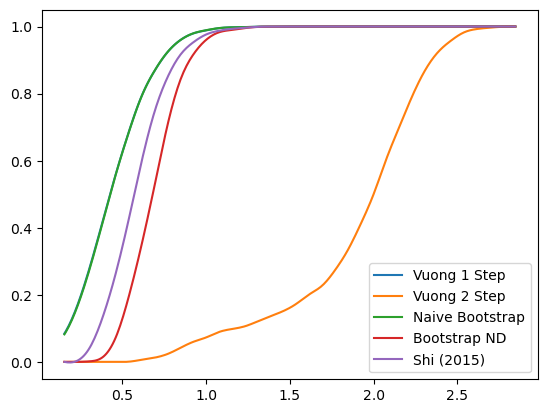

0.044721359549995794 8.197159426200533e-05


In [12]:
nobs = 500
c1,c2 = calc_c(nobs)

mc_run_power(nobs,c1,c2,data_tuned_c=data_tuned_c)
print(c1,c2)